# Tourists at Home

### Executive Summary

This project aims to understand the local perception of Domestic Tourism and to provide further insights for STB to plan its next phase of the #SingapoRediscovers campaign. By targetting Singaporeans more effectively, we aim to build up a sustainable economy of domestic tourism based on renewed and sustained interest in their own home country, which should serve our tourism industry well both during and after Covid-19.

In this notebook, we will tune hyper-parameters to optimise our final models for their best performance. From our model selection process, we have selected XGBoost as the model that gives us the best results with the shortest training time required. Using the model design (vectorizer, platform dummies, etc) as tried and tested in model selection notebook 3.5, we built our final XGBoost model after suitable tuning the hyper-parameters. While the results achieved were decent, we hit a wall when it came to inferring features importance from our final model. The features were difficult to interpret because their weights were skewed by the presence of the platform dummies as well as the difficulty associated with qualifying a unit like on different platforms. At this juncture, the project reached a turning point and after much deliberation, we decided to pivot the data science problem to a classification problem as well as to redesign the model build as a hybrid model.

After the turning point, we returned to EDA notebook 3.0 to engineer our popularity target labels for classification as well as other relevant features that may contribute to our model predictions. The updated dataset was then re-imported and the whole building process begins again starting with the tuning of hyper-parameters. In the end, 3 classification models were built, the first was optimised for ROC-AUC, the second optimised for F-1 score, and the last was optimised on the F-1 score too but trained on a SMOTE-transformed oversampled training set. Our best performing and final model turned out to be Model_02.

The optimisation process by tuning hyper-parameters is an important part of building our final models. In this notebook, the general strategy for tuning hyper-parameters is to grid search with `GridSearchCV`. However, in the interest of time, this notebook believed it would be faster and with greater time-control to begin grid searching with `RandomizedSearchCV`. There are two key benefits to performing a randomised grid search:

- Randomised grid searching allows us to specify the number of iterations and therefore grid of hyper-parameter values that we want to search through, thereby also allowing us to control the grid search time without having to search through all possible permutations.
- Randomised grid searching also allows us to input probability density functions as argument to the hyper-parameters, which given enough iterations, will mean that we are more likely to be able to end up with the best optimised parameter value than if we were blindly providing parameter values to search through at random/fixed intervals.

However, randomised grid searching is not thorough, so what we saved on grid searching time, we will have to spend on analysing hyper-parameters against the metric/score we want to optimise. Therefore, part of the process after grid searching is to plot out the hyper-paramters against the metric/score and understand the patterns/trends (if any), following which we would then be able to make an informed choice on the parameter values for a more targetted grid search with `GridSearchCV`.

In the end, Model_02 was selected as our best model. We conclude by interpreting the features importance for both its NLP and non-NLP model components, and propose some initiaties based on our findings that we believe will have a good chance of achieving success and popularity.

#### Content

- [Build Transformers](#Build-Transformers)
- [Tune Hyper-Parameters](#Tune-Hyper-Parameters)
- [XGBoost Model](#XGBoost-Model)
- [Updated Training Set](#Updated-Training-Set)
- [Tune NLP Model](#Tune-NLP-Model)
- [Tune non-NLP Model](#Tune-non-NLP-Model)
- [Model_01](#Model_01)
- [Re-Tune NLP Model](#Re-Tune-NLP-Model)
- [Re-Tune non-NLP Model](#Re-Tune-non-NLP-Model)
- [Model_02](#Model_02)
- [Re-Tune NLP Model, Again](#Re-Tune-NLP-Model,-Again)
- [Re-Tune non-NLP Model, Again](#Re-Tune-non-NLP-Model,-Again)
- [Model_03](#Model_03)
- [Conclusion](#Conclusion)
- [Recommendations](#Recommendations)

#### Data Dictionary

<details><summary>List of Features used in training set for the Final Model</summary>
    
|Feature|Data Type|Format|Description|
|---|---|---|:--|
|**content**|string|*discrete*|Relevant text content for each data point were concatenated into a single column feature.|
|**likes**|integer|*continuous*|The number of likes acquired by each data point.|
|**age**|integer|*continuous*|The age of data point in number of days from when it was first published to when it was scraped.|
|**popular**|integer|*binary*|Our target labels for classification indicating if a data point is popular or not.<br>It was engineered by identifying likes outliers using the inter-quartile range of each likes distribution.|
|**date_time**|datetime|*discrete*|Pandas Timestamp objects indicating the date and time of when each data point was published.|
|**year**|integer|*discrete*|Year when each data point was published.|
|**month**|string|*discrete*|Month when each data point was published.|
|**day**|string|*discrete*|Day when each data point was published.|
|**time_of_day**|string|*discrete*|Time of day when each data point was published.<br>This feature was engineered by apportioning four parts to the day and labelling each data point accordingly.<br>We have "Midnight" from 00:00 to 05:59; "Morning" from 06:00 to 11:59; "Afternoon" from 12:00 to 17:59; and "Night" from 18:00 to 23:59.
|**hash_count**|integer|*continuous*|Counts total number of hashtags found in the text content of each data point.|
|**content_len**|integer|*continuous*|Counts total character length of the text content of each data point.|
    
</details>

#### Metrics Employed

Below are the key metrics used in evaluating our classification models.

|Metric|Definition|
|:--|:--|
|**Accuracy**|Percentage of observations correctly predicted.|
|**Recall**|Percentage of correct positive predictions out of total number of actual positives, or True Positive Rate (TPR).|
|**Specificity**|Percentage of correct negative predictions out of total number of actual negatives, or True Negative Rate (TNR).|
|**Precision**|Percentage of correct positive predictions out of total number of positive predictions, in other words the accuracy of the positive predictions.|
|**ROC-AUC**|Receiver-Operating Characteristics curve plots TPR (recall) against FPR (1 - Specificity) and evaluates the area under the curve.|
|**F-1 Score**|The F-1 score is measured by evaluating the harmonic mean between Precision and Recall.|

#### Python Libraries

In [57]:
# # uncomment to install imblearn for SMOTE
# !pip install imbalanced-learn

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.sparse import hstack
from scipy.stats import uniform, truncnorm, randint
import re

import os
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, precision_score, recall_score,\
roc_auc_score, roc_curve, confusion_matrix, f1_score, precision_recall_curve

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTE

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Build Transformers

In [2]:
df_merged_drop_targets = pd.read_csv("../datasets/df_merged_drop_targets.csv")
df_merged_drop_targets.head(3)

content  likes         platform
0  oh look natural heart shaped form ivan heng gl...     40  Instagram Posts
1  #exploresingapore #instasg #gfsingapore #gameo...     33  Instagram Posts
2  road hell reliving haw par villa 15 16 22 23 m...      3  Instagram Posts

In [3]:
# split into training and unseen test data
features = [feat for feat in df_merged_drop_targets.columns if feat != "likes"]
X = df_merged_drop_targets[features]
y = df_merged_drop_targets["likes"]

X_train, X_unseen, y_train, y_unseen = train_test_split(X, y, test_size=0.25,
                                                        stratify=df_merged_drop_targets["platform"], random_state=42)
print("Training set size:", len(X_train))
print("Unseen test set size:", len(X_unseen))

Training set size: 18109
Unseen test set size: 6037


In [4]:
# build transformers

text_features = "content"
text_transformer = Pipeline(steps=[
    ('tvec', TfidfVectorizer(stop_words="english"))])

categorical_features = ["platform"] # add square brackets to so array input to transformer is (n_rows, 1)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, text_features),
        ('cat', categorical_transformer, categorical_features)])

In [5]:
text_transformer.fit_transform(X_train["content"]) # check that shape is correct - 43313 word features found

<18109x43313 sparse matrix of type '<class 'numpy.float64'>'
	with 419370 stored elements in Compressed Sparse Row format>

In [6]:
categorical_transformer.fit_transform(X_train[["platform"]]) # check that shape is correct - 3 dummies found

<18109x3 sparse matrix of type '<class 'numpy.float64'>'
	with 18109 stored elements in Compressed Sparse Row format>

In [7]:
preprocessor.fit_transform(X_train) # check that shape is correct - 43316 total features (word + dummies)

<18109x43316 sparse matrix of type '<class 'numpy.float64'>'
	with 437479 stored elements in Compressed Sparse Row format>

### Tune Hyper-Parameters

#### Prep Training Set

In [8]:
df_merged_drop_targets.head(3)

content  likes         platform
0  oh look natural heart shaped form ivan heng gl...     40  Instagram Posts
1  #exploresingapore #instasg #gfsingapore #gameo...     33  Instagram Posts
2  road hell reliving haw par villa 15 16 22 23 m...      3  Instagram Posts

In [9]:
# porter stemmer was chosen as the vectorizer better for the model
p_stemmer = PorterStemmer() # instantiate porter stemmer
text_tokens = [] # create empty list

for doc in df_merged_drop_targets["content"]:
    text_tokens.append([p_stemmer.stem(word) for word in doc.split()]) # stem each token in post and append list to list
df_merged_drop_targets["content_stem"] = [" ".join(doc) for doc in text_tokens] # concat into single str and create new col
df_merged_drop_targets.head(3) # verify new col added

content  likes         platform  \
0  oh look natural heart shaped form ivan heng gl...     40  Instagram Posts   
1  #exploresingapore #instasg #gfsingapore #gameo...     33  Instagram Posts   
2  road hell reliving haw par villa 15 16 22 23 m...      3  Instagram Posts   

                                        content_stem  
0  oh look natur heart shape form ivan heng glen ...  
1  #exploresingapor #instasg #gfsingapor #gameoft...  
2  road hell reliv haw par villa 15 16 22 23 marc...

In [10]:
# redo train-test split
X = df_merged_drop_targets[["content_stem", "platform"]]
y = df_merged_drop_targets["likes"]

X_train, X_unseen, y_train, y_unseen = train_test_split(X, y, test_size=0.25, stratify=X["platform"], random_state=42)

print("Training set size:", len(X_train))
print("Unseen test set size:", len(X_unseen))

Training set size: 18109
Unseen test set size: 6037


In [11]:
# rebuild transformers

text_features = "content_stem"
text_transformer = Pipeline(steps=[
    ('tvec', TfidfVectorizer(stop_words="english"))])

categorical_features = ["platform"] # add square brackets to so array input to transformer is (n_rows, 1)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, text_features),
        ('cat', categorical_transformer, categorical_features)])

#### Random Forest

Even though Random Forest gave us our best score during model selection via cross-validation, it was only a marginal edge over our next-best performing XGBoost model. However, through hyper-parameters tuning and by training on a larger training set, the score may swing in either directions. Therefore, despite reservations over its training time relative to XGBoost, we shall test out Random Forest anyway and see how it measures up against XGBoost.

In [371]:
# build pipeline
pipe_rf = Pipeline(steps=[('preprocessor', preprocessor),
                            ("rf", RandomForestRegressor())])

# set hyper params to tune
pipe_params_rf = {
    "preprocessor__text__tvec__max_features": [2500, 5000, 7500],
    "preprocessor__text__tvec__ngram_range": [(1,1), (1,2), (1,3)],
    "rf__n_estimators": [100, 150, 200],
    "rf__max_depth": randint(2, 6),
    "rf__min_samples_split": randint(2, 6),
    "rf__min_samples_leaf": randint(2, 5),
    "rf__max_features": ["auto", "sqrt"],
    "rf__bootstrap": [True, False],
    "rf__max_samples": [0.8, 0.9, 1]
}

In [373]:
%%time
np.random.seed(42)
rs_rf = RandomizedSearchCV(estimator=pipe_rf, param_distributions=pipe_params_rf, n_iter=100, cv=4)
rs_rf.fit(X_train, y_train)
print("Best score in Randomised Search:", rs_rf.best_score_)
print()
print("Using the following hyper-parameters:")
rs_rf.best_params_

Best score in Grid Search: 0.32799863139587326

Using the following hyper-parameters:
Wall time: 2h 49min 28s


{'preprocessor__text__tvec__max_features': 5000,
 'preprocessor__text__tvec__ngram_range': (1, 2),
 'rf__bootstrap': True,
 'rf__max_depth': 5,
 'rf__max_features': 'auto',
 'rf__max_samples': 0.8,
 'rf__min_samples_leaf': 4,
 'rf__min_samples_split': 3,
 'rf__n_estimators': 200}

In [539]:
df_rs_rf = pd.DataFrame(rs_rf.cv_results_)
df_rs_rf.to_csv("../datasets/df_rs_rf.csv", index=False) # save out df of randomized search
df_rs_rf.info() # notice certain cols that are numeric are not numeric

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 21 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   mean_fit_time                                 100 non-null    float64
 1   std_fit_time                                  100 non-null    float64
 2   mean_score_time                               100 non-null    float64
 3   std_score_time                                100 non-null    float64
 4   param_preprocessor__text__tvec__max_features  100 non-null    object 
 5   param_preprocessor__text__tvec__ngram_range   100 non-null    object 
 6   param_rf__bootstrap                           100 non-null    object 
 7   param_rf__max_depth                           100 non-null    object 
 8   param_rf__max_features                        100 non-null    object 
 9   param_rf__max_samples                         100 non-null    obje

In [562]:
# re-import df
df_rs_rf = pd.read_csv("../datasets/df_rs_rf.csv")
df_rs_rf.head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      18.147601      0.489196         0.417193        0.005821   
1      39.409956      0.556671         1.050912        0.043067   
2      18.038885      0.108893         0.422752        0.008733   

   param_preprocessor__text__tvec__max_features  \
0                                          2500   
1                                          5000   
2                                          7500   

  param_preprocessor__text__tvec__ngram_range  param_rf__bootstrap  \
0                                      (1, 1)                False   
1                                      (1, 3)                False   
2                                      (1, 1)                 True   

   param_rf__max_depth param_rf__max_features  param_rf__max_samples  ...  \
0                    2                   auto                    0.9  ...   
1                    3                   auto                    0.8  ...   
2                    5                   auto                    0.9  ...   

   param_rf__min_samples_split  param_rf__n_estimators  \
0                            5                     200   
1                            2                     200   
2                            5                     100   

                                              params split0_test_score  \
0  {'preprocessor__text__tvec__max_features': 250...          0.225965   
1  {'preprocessor__text__tvec__max_features': 500...          0.279304   
2  {'preprocessor__text__tvec__max_features': 750...          0.294182   

   split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
0          -0.013587           0.292998           0.107640         0.153254   
1          -0.478512           0.346725           0.065772         0.053322   
2           0.262553           0.452325           0.264537         0.318399   

   std_test_score  rank_test_score  
0        0.116974               66  
1        0.324097               71  
2        0.078330                3  

[3 rows x 21 columns]

In [543]:
# convert all cols that can be numeric into numeric dtypes
df_rs_rf["param_preprocessor__text__tvec__max_features"] = df_rs_rf["param_preprocessor__text__tvec__max_features"].astype(int)
df_rs_rf["param_rf__max_depth"] = df_rs_rf["param_rf__max_depth"].astype(int)
df_rs_rf["param_rf__max_samples"] = df_rs_rf["param_rf__max_samples"].astype(float)
df_rs_rf["param_rf__min_samples_leaf"] = df_rs_rf["param_rf__min_samples_leaf"].astype(int)
df_rs_rf["param_rf__min_samples_split"] = df_rs_rf["param_rf__min_samples_split"].astype(int)
df_rs_rf["param_rf__n_estimators"] = df_rs_rf["param_rf__n_estimators"].astype(int)
df_rs_rf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 21 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   mean_fit_time                                 100 non-null    float64
 1   std_fit_time                                  100 non-null    float64
 2   mean_score_time                               100 non-null    float64
 3   std_score_time                                100 non-null    float64
 4   param_preprocessor__text__tvec__max_features  100 non-null    int32  
 5   param_preprocessor__text__tvec__ngram_range   100 non-null    object 
 6   param_rf__bootstrap                           100 non-null    object 
 7   param_rf__max_depth                           100 non-null    int32  
 8   param_rf__max_features                        100 non-null    object 
 9   param_rf__max_samples                         100 non-null    floa

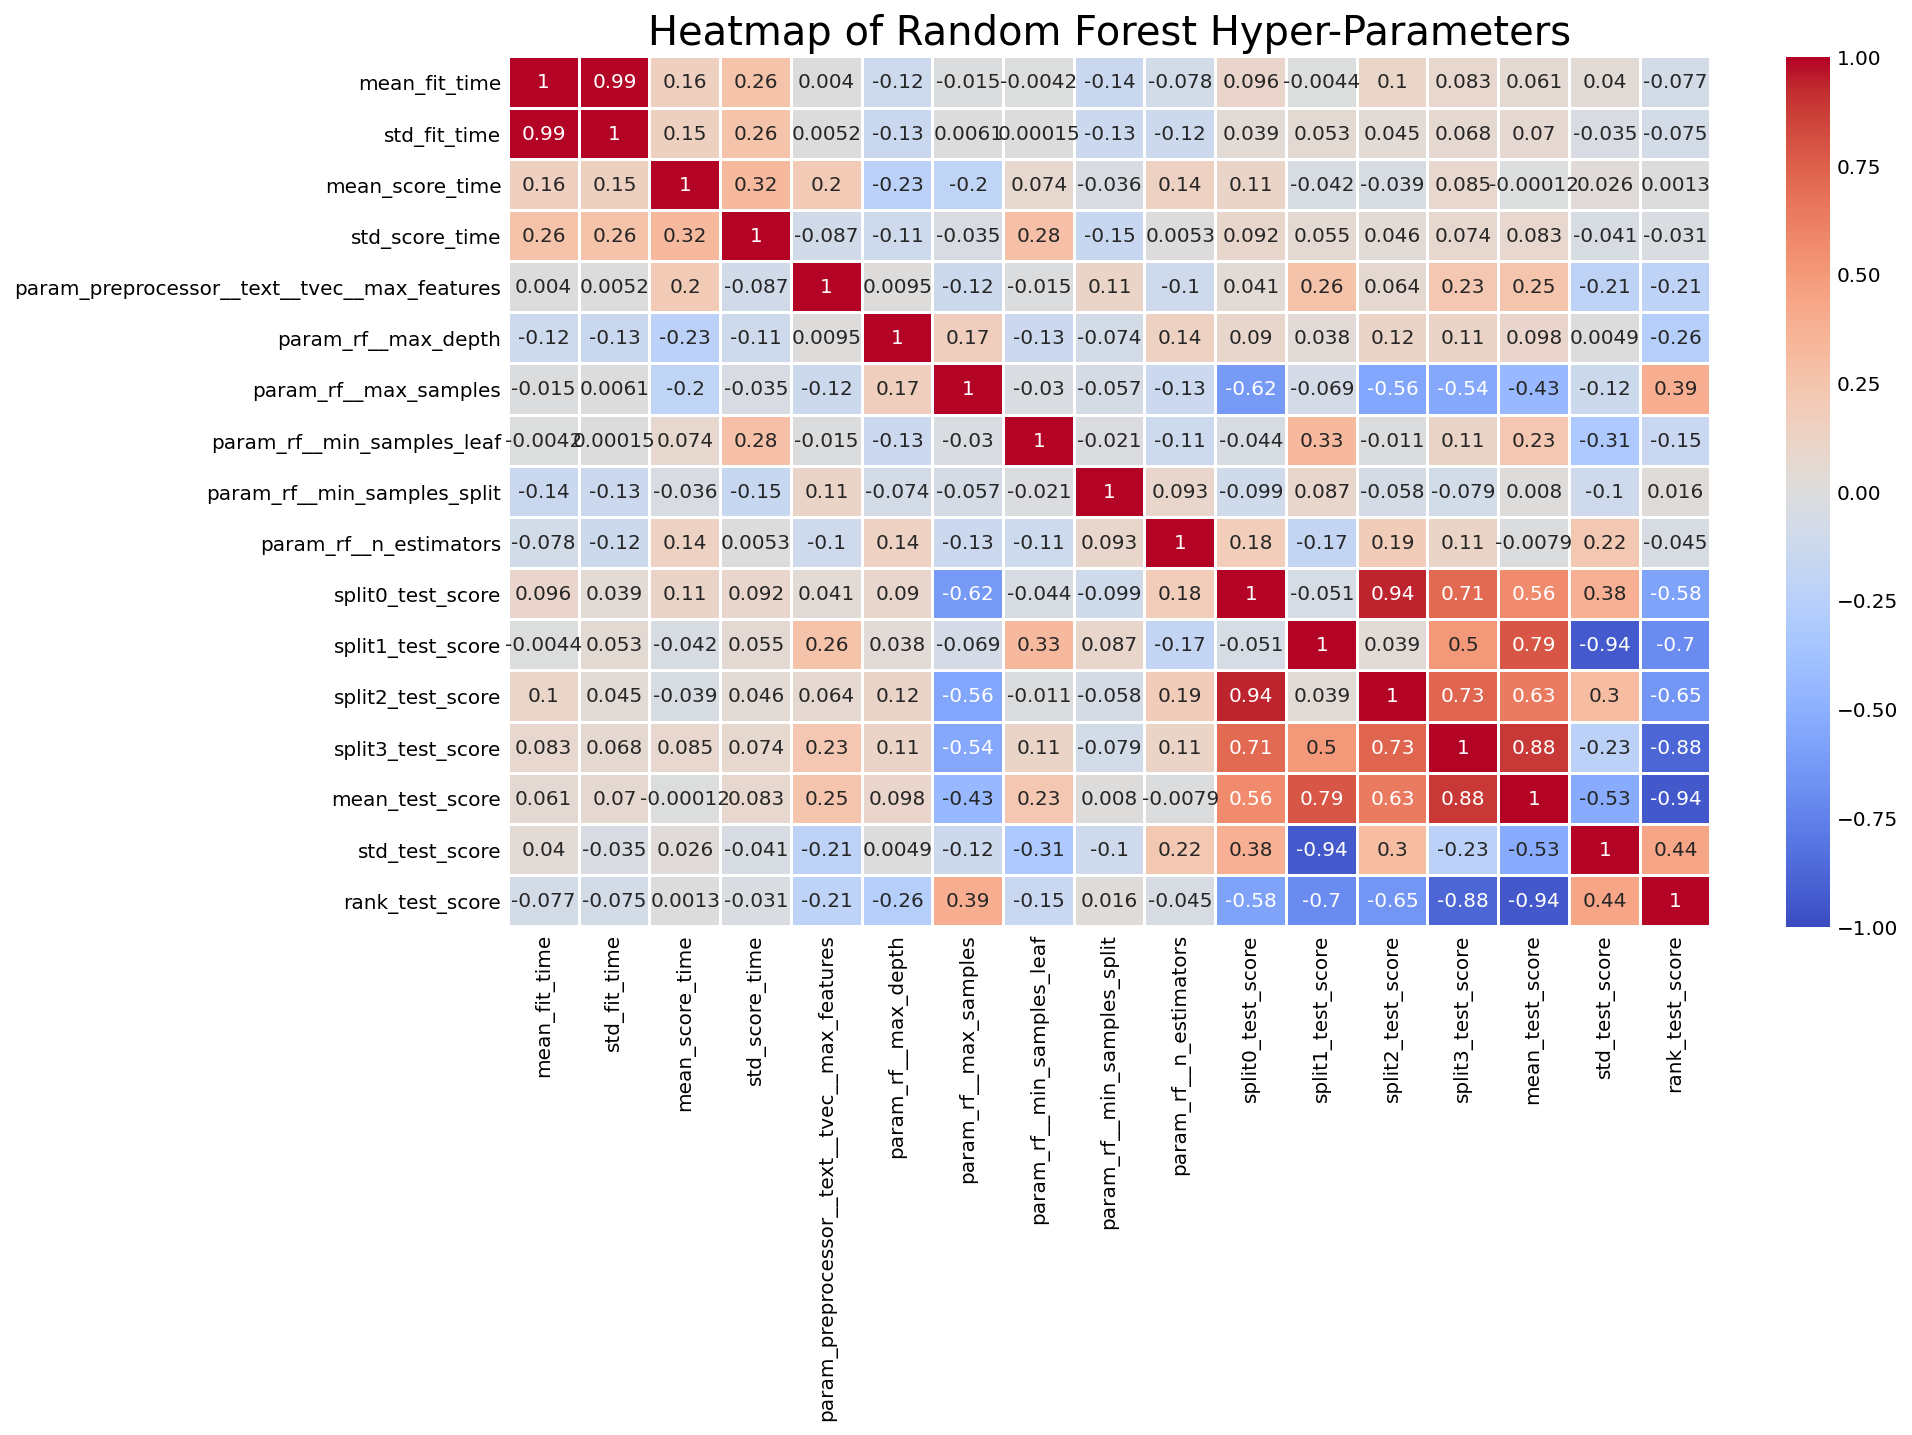

In [544]:
plt.figure(figsize=[12,8])
plt.title("Heatmap of Random Forest Hyper-Parameters", size=20)
sns.heatmap(df_rs_rf.corr(), annot=True, linewidths=1, vmin=-1, vmax=1, cmap="coolwarm")
plt.savefig("../assets/hparams_rf_heatmap.png", transparent=True, bbox_inches='tight')
plt.show()

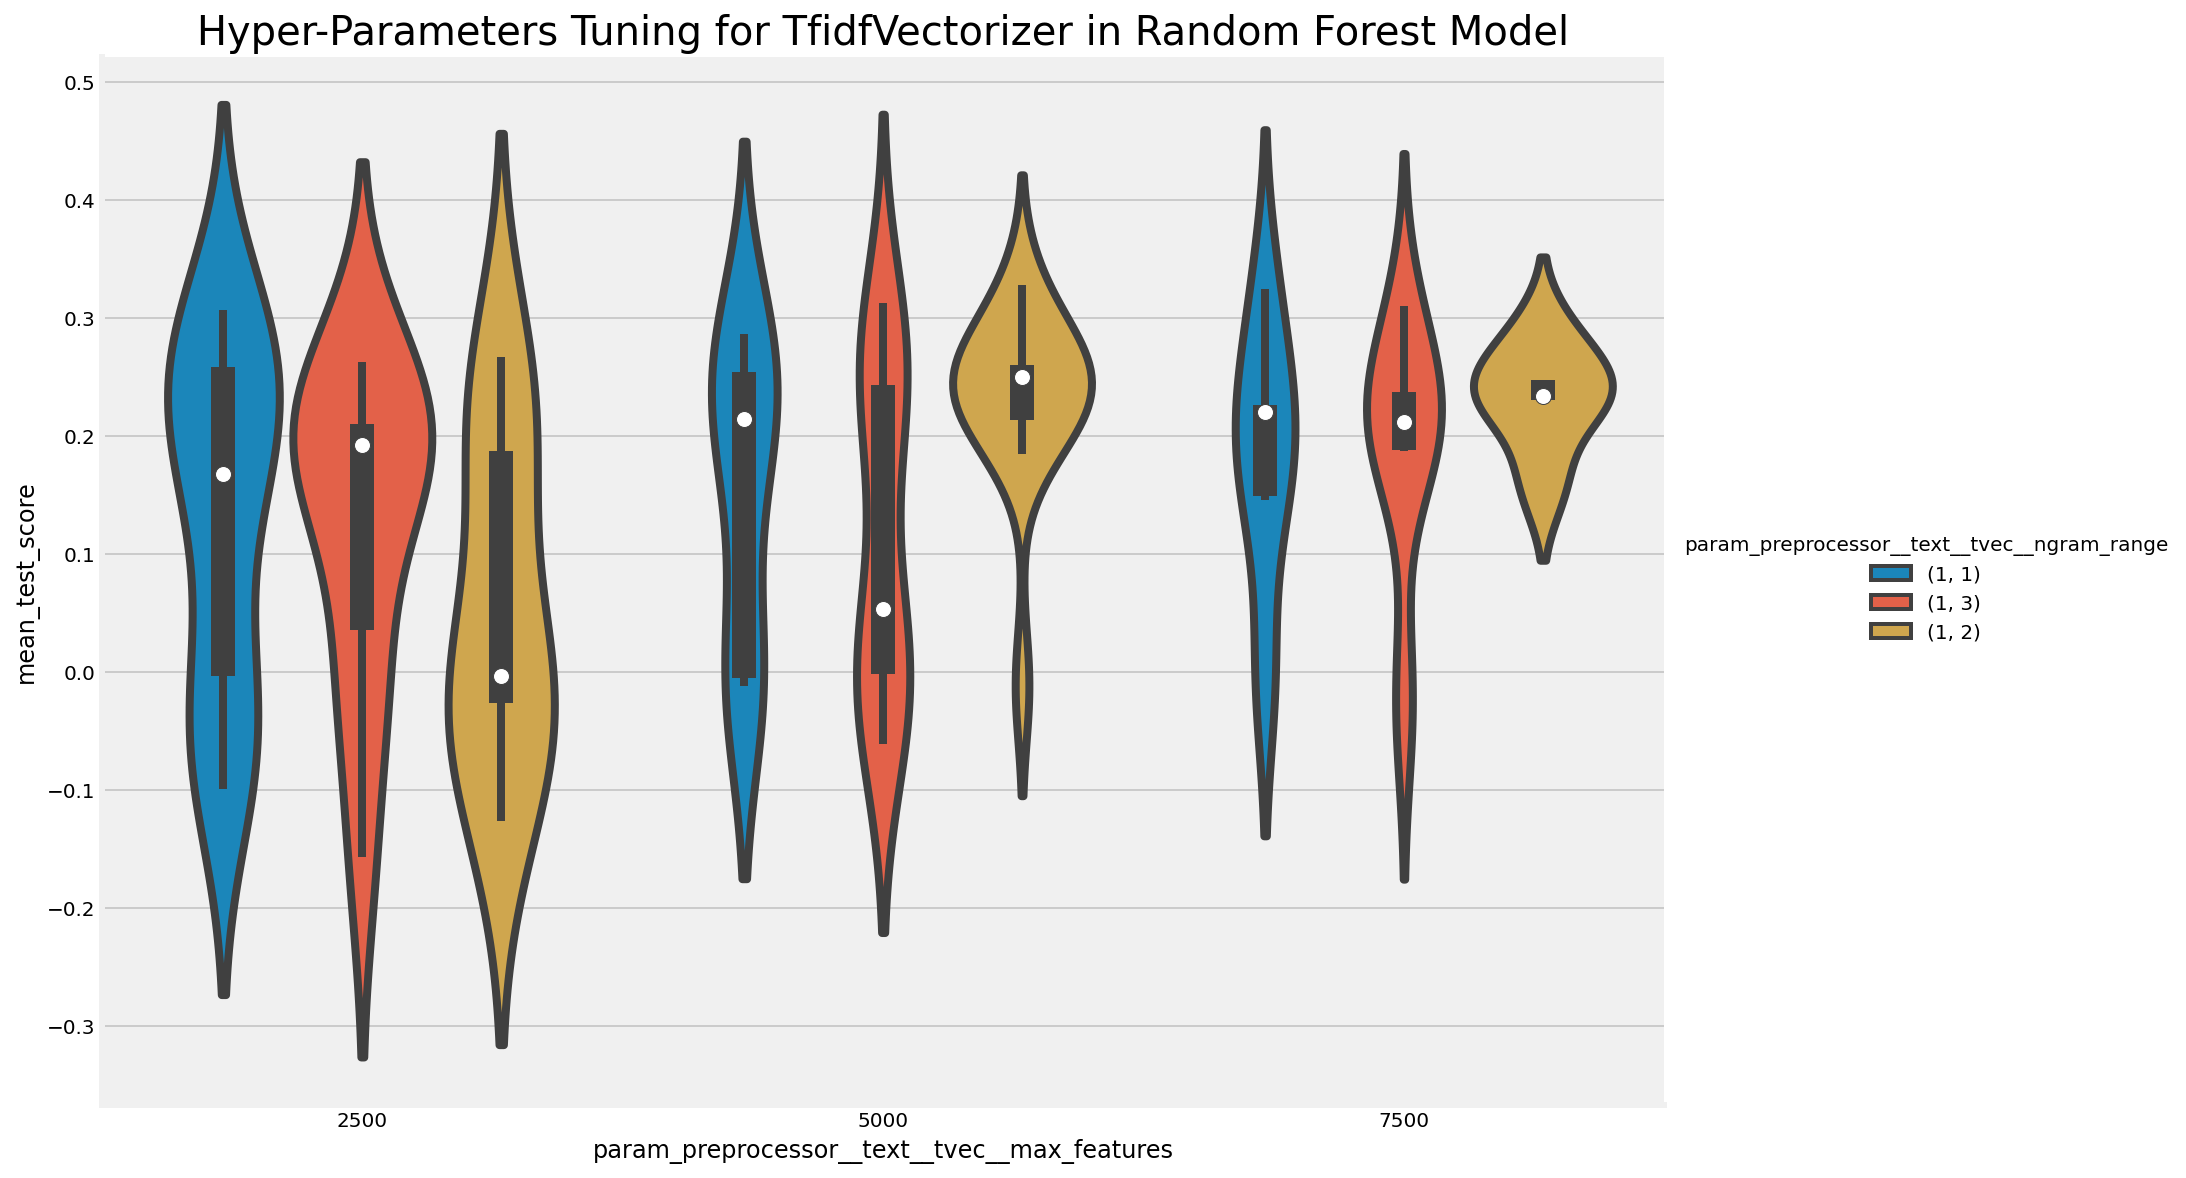

In [566]:
sns.catplot(data=df_rs_rf,
            x='param_preprocessor__text__tvec__max_features',
            y='mean_test_score',
            hue='param_preprocessor__text__tvec__ngram_range',
            height=8, aspect=1.5, kind="violin")
plt.gcf()
plt.title("Hyper-Parameters Tuning for TfidfVectorizer in Random Forest Model", size=20)
plt.savefig("../assets/hparams_rf_tvec.png", transparent=True, bbox_inches='tight')
plt.show()

We can observe reduced variance in CV scores when `max_features` is 7500 with an `ngram_range` of (1,3). The mean CV score remained farly high too.

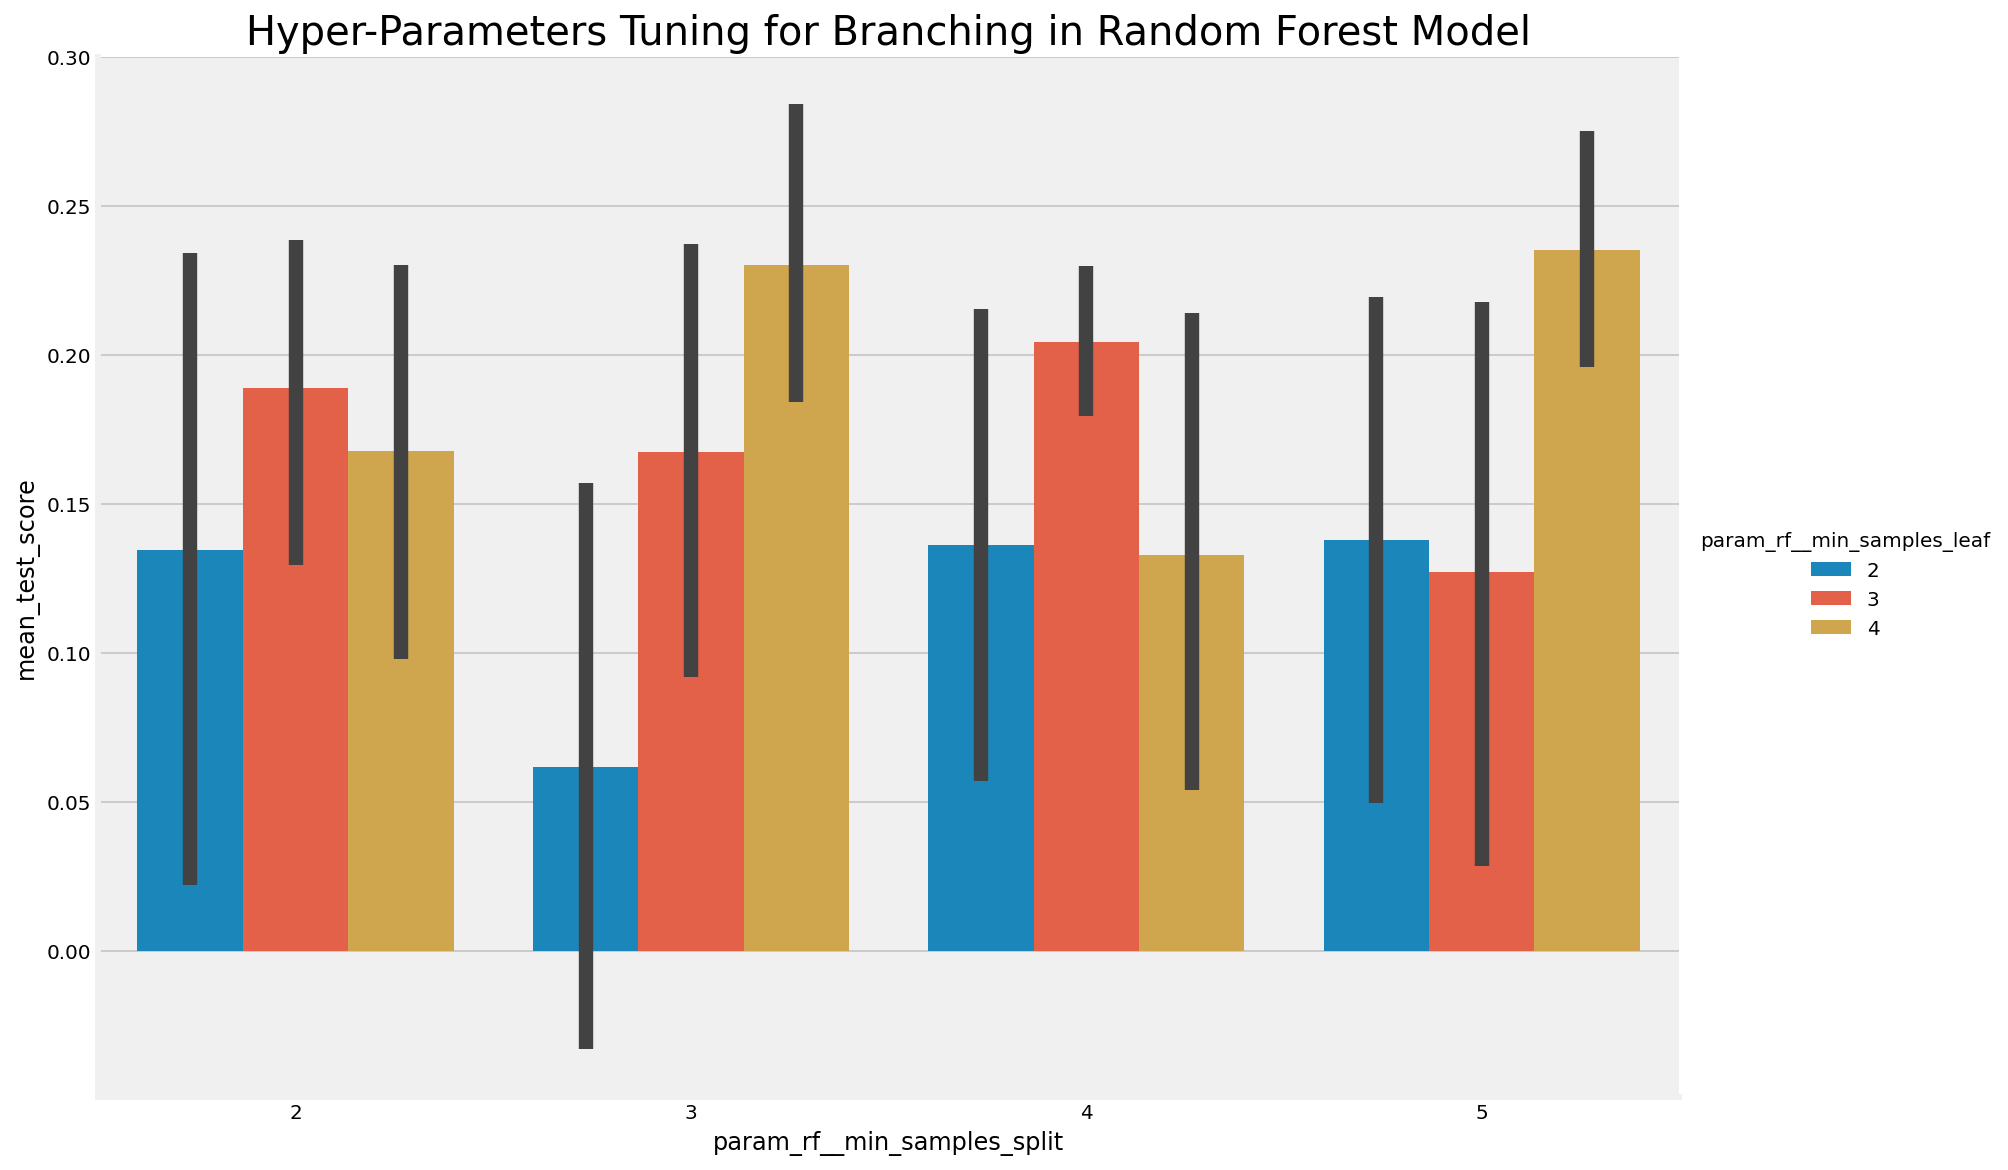

In [578]:
sns.catplot(data=df_rs_rf,
            x='param_rf__min_samples_split',
            y='mean_test_score',
            hue='param_rf__min_samples_leaf',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning for Branching in Random Forest Model", size=20)
plt.savefig("../assets/hparams_rf_branching.png", transparent=True, bbox_inches='tight')
plt.show()

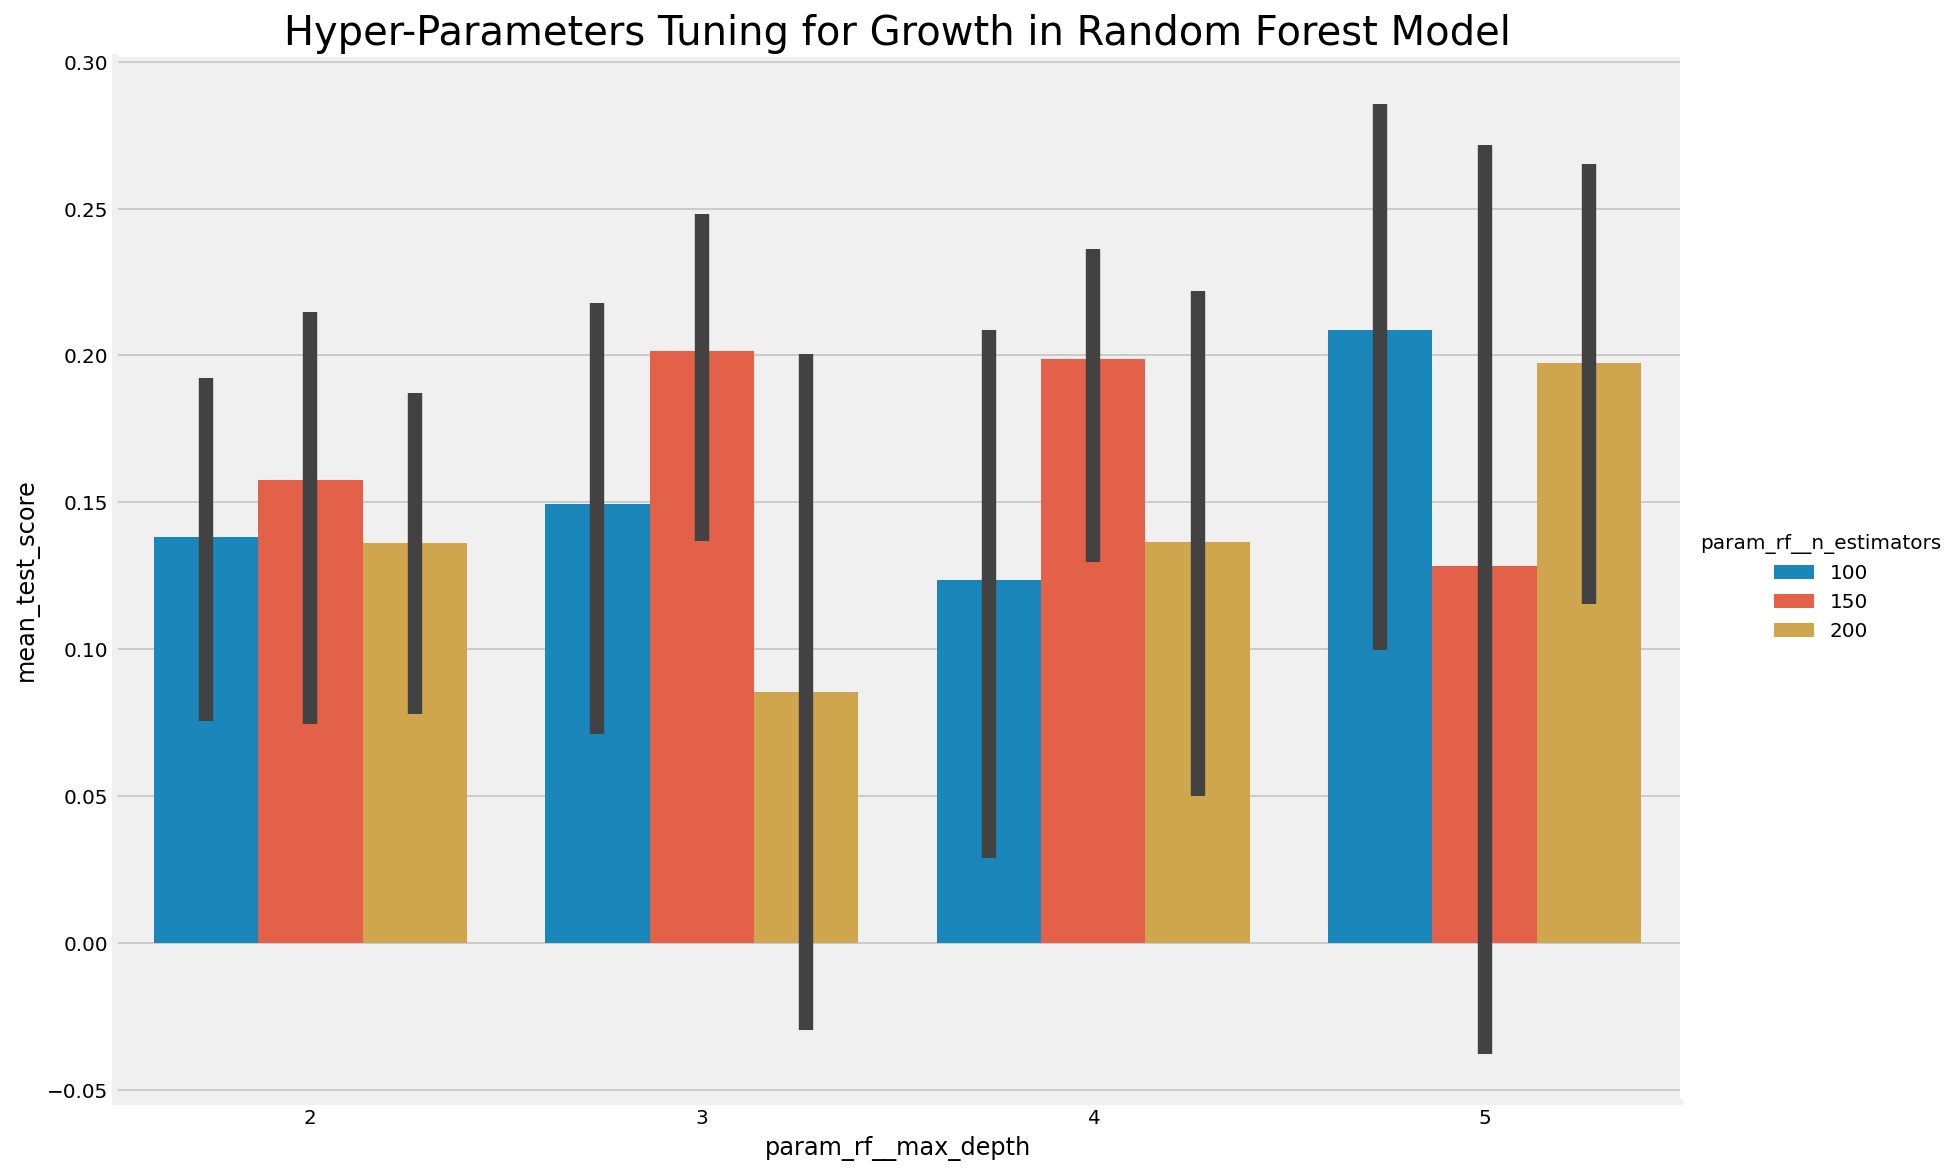

In [592]:
sns.catplot(data=df_rs_rf,
            x='param_rf__max_depth', # control growth of each tree
            y='mean_test_score',
            hue='param_rf__n_estimators', # control growth of forest size
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning for Growth in Random Forest Model", size=20)
plt.savefig("../assets/hparams_rf_growth.png", transparent=True, bbox_inches='tight')
plt.show()

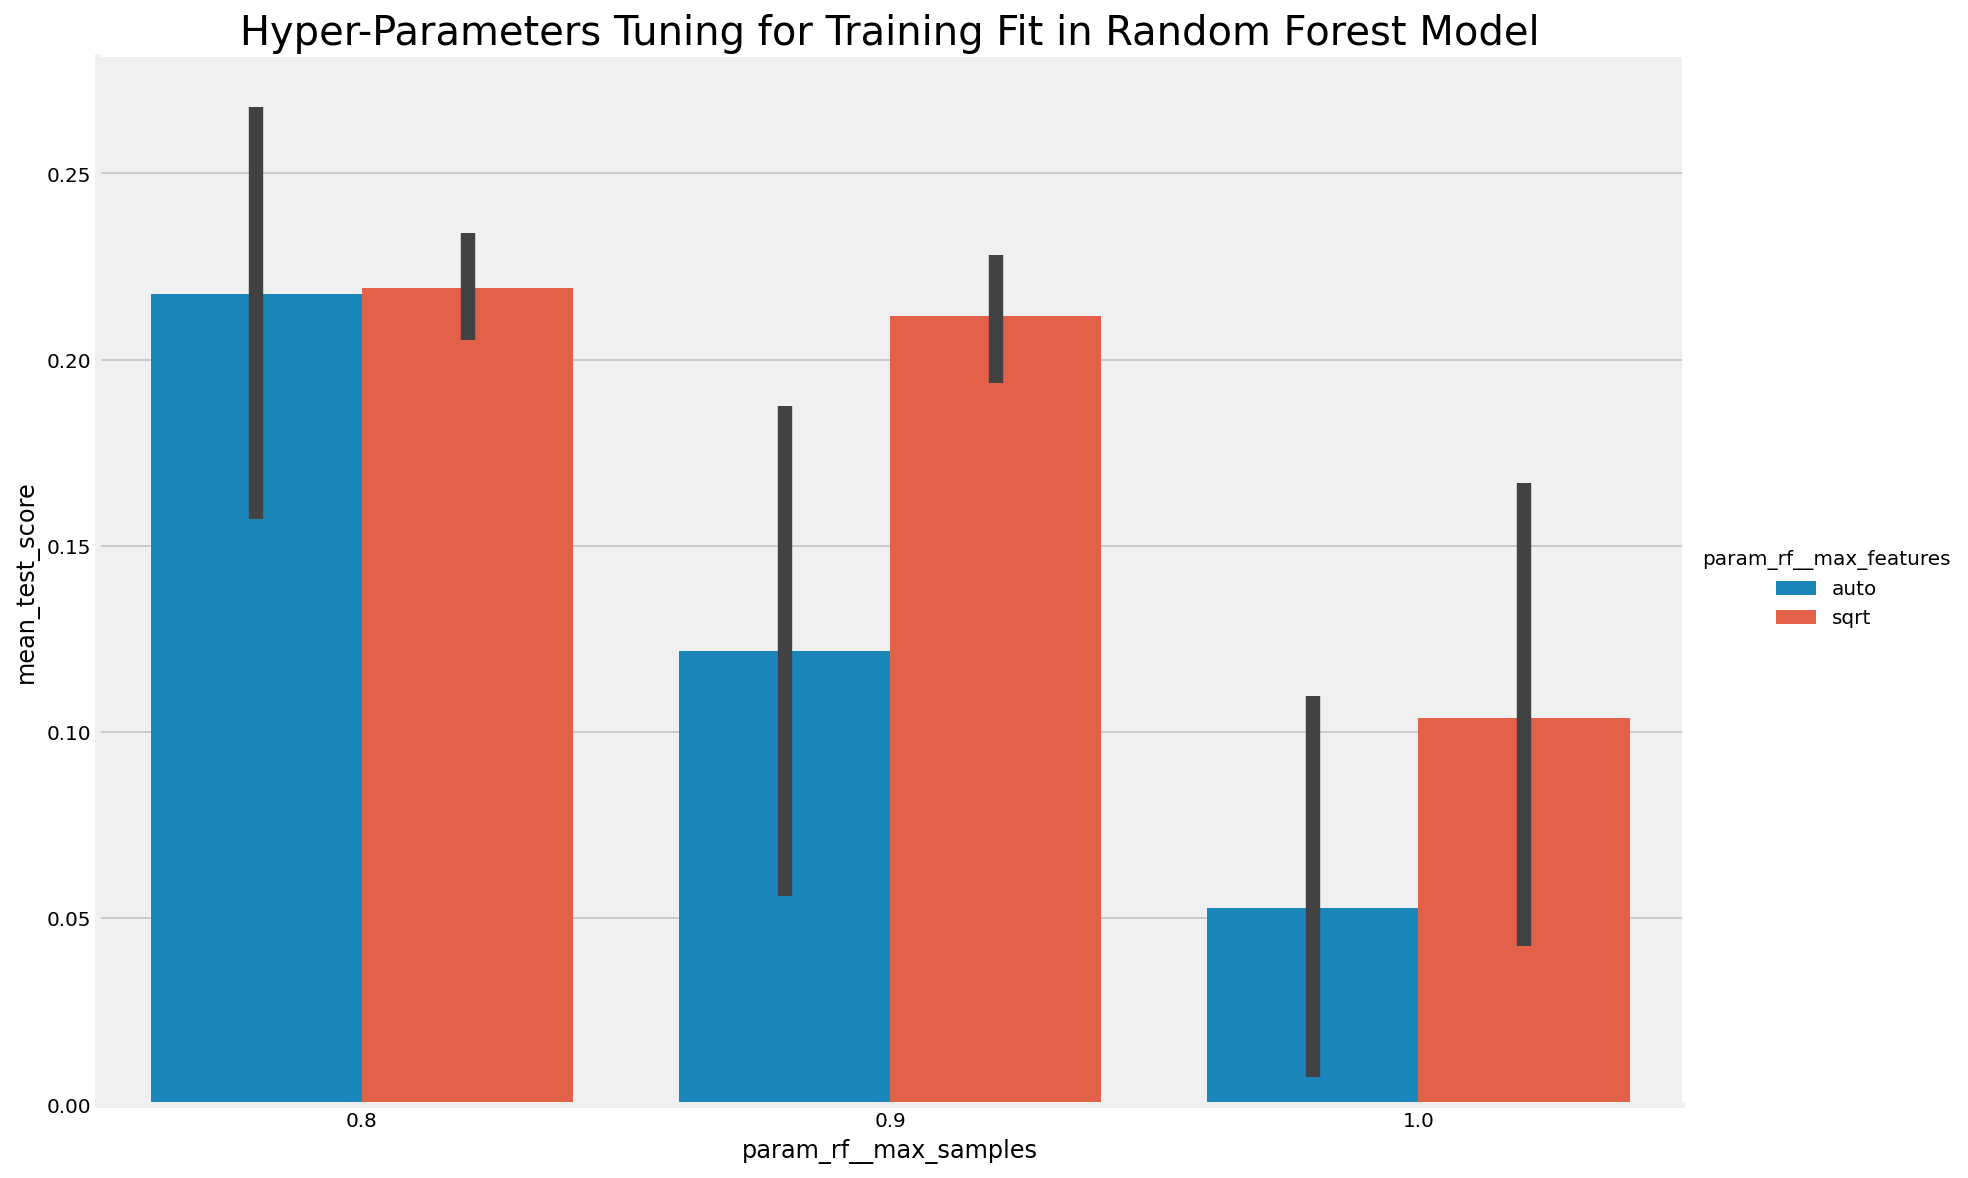

In [593]:
sns.catplot(data=df_rs_rf,
            x='param_rf__max_samples', # control sampling of rows to reduce over-fitting
            y='mean_test_score',
            hue='param_rf__max_features', # control sampling of column features to reduce over-fitting
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning for Training Fit in Random Forest Model", size=20)
plt.savefig("../assets/hparams_rf_trainfit.png", transparent=True, bbox_inches='tight')
plt.show()

The CV scores are at the highest when `max_samples` is smaller at 0.8. The model also performs better then `max_features` is set to "sqrt", but at `max_samples` of 0.8, the improvement in CV score is very marginal.

#### XGBoost

In [12]:
# build pipeline
pipe_xgbL = Pipeline(steps=[('preprocessor', preprocessor),
                            ("xgboost", xgb.XGBRegressor(booster="gblinear"))]) # "gblinear" as best booster from model selection

# set hyper params to tune
pipe_params_xgbL = {
    "preprocessor__text__tvec__max_features": [2500, 5000, 7500],
    "preprocessor__text__tvec__ngram_range": [(1,1), (1,2), (1,3)],
    "xgboost__objective": ["reg:squarederror", "reg:tweedie"],
    "xgboost__reg_alpha": randint(0, 11),
    "xgboost__reg_lambda": randint(0, 11),
    "xgboost__feature_selector": ["cyclic", "shuffle"]
}

In [13]:
%%time
np.random.seed(42)
rs_xgbL = RandomizedSearchCV(estimator=pipe_xgbL, param_distributions=pipe_params_xgbL, n_iter=100, cv=4)
rs_xgbL.fit(X_train, y_train)
print("Best score in Randomised Search:", rs_xgbL.best_score_)
print()
print("Using the following hyper-parameters:")
rs_xgbL.best_params_

Best score in Randomised Search: 0.2405312673015588

Using the following hyper-parameters:
Wall time: 29min 37s


{'preprocessor__text__tvec__max_features': 2500,
 'preprocessor__text__tvec__ngram_range': (1, 3),
 'xgboost__feature_selector': 'shuffle',
 'xgboost__objective': 'reg:squarederror',
 'xgboost__reg_alpha': 0,
 'xgboost__reg_lambda': 0}

From model selection in Notebook 3.5, `gblinear` was our best booster when paired with objective `reg:squarederror`. While RandomisedSearch agrees and provided the pairing as our best hyper-parameters, the model score fell drastically short of our initial score from model selection. This can be attributed to the smaller training size used during our model selection. Following this disappointing result, let's build another XGBoost model using the default `gbtree` as our booster instead. With Random Forest performing still decently on the increased training set, there is reason to believe that a tree-based algorithm may yield us a better and more consistent result.

In [14]:
# build pipeline
pipe_xgbT = Pipeline(steps=[('preprocessor', preprocessor),
                            ("xgboost", xgb.XGBRegressor(booster="gbtree"))]) # select "gbtree" as booster of choice

# set hyper params to tune
pipe_params_xgbT = {
    "preprocessor__text__tvec__max_features": [2500, 5000, 7500],
    "preprocessor__text__tvec__ngram_range": [(1,1), (1,2), (1,3)],
    "xgboost__objective": ["reg:squarederror", "reg:tweedie"],
    "xgboost__reg_alpha": randint(0, 11),
    "xgboost__reg_lambda": randint(0, 11),
    "xgboost__learning_rate": truncnorm(a=0, b=1, loc=0.1, scale=0.3),
    "xgboost__min_split_loss": [0, 0.05, 0.1],
    "xgboost__max_depth": randint(2, 6),
    "xgboost__min_child_weight": randint(0, 5),
    "xgboost__subsample": uniform(0.5, 0.5),
    "xgboost__colsample_bytree": [0.8, 0.9, 1]
}

In [15]:
%%time
np.random.seed(42)
rs_xgbT = RandomizedSearchCV(estimator=pipe_xgbT, param_distributions=pipe_params_xgbT, n_iter=100, cv=4)
rs_xgbT.fit(X_train, y_train)
print("Best score in Randomised Search:", rs_xgbT.best_score_)
print()
print("Using the following hyper-parameters:")
rs_xgbT.best_params_

Best score in Randomised Search: 0.4030826630738965

Using the following hyper-parameters:
Wall time: 56min 33s


{'preprocessor__text__tvec__max_features': 5000,
 'preprocessor__text__tvec__ngram_range': (1, 1),
 'xgboost__colsample_bytree': 0.8,
 'xgboost__learning_rate': 0.16253024946754588,
 'xgboost__max_depth': 5,
 'xgboost__min_child_weight': 3,
 'xgboost__min_split_loss': 0,
 'xgboost__objective': 'reg:squarederror',
 'xgboost__reg_alpha': 10,
 'xgboost__reg_lambda': 6,
 'xgboost__subsample': 0.6695148955243504}

This is our best score yet from hyper-parameters tuning. Let's evaluate the hyper-parameters for XGBoost on the `gbtree` booster.

In [16]:
df_rs_xgbT = pd.DataFrame(rs_xgbT.cv_results_)
df_rs_xgbT.to_csv("../datasets/df_rs_xgbT.csv", index=False) # save out df of randomized search
df_rs_xgbT.info() # notice certain cols that are numeric are not numeric

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 23 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   mean_fit_time                                 100 non-null    float64
 1   std_fit_time                                  100 non-null    float64
 2   mean_score_time                               100 non-null    float64
 3   std_score_time                                100 non-null    float64
 4   param_preprocessor__text__tvec__max_features  100 non-null    object 
 5   param_preprocessor__text__tvec__ngram_range   100 non-null    object 
 6   param_xgboost__colsample_bytree               100 non-null    object 
 7   param_xgboost__learning_rate                  100 non-null    object 
 8   param_xgboost__max_depth                      100 non-null    object 
 9   param_xgboost__min_child_weight               100 non-null    obje

In [17]:
# re-import df
df_rs_xgbT = pd.read_csv("../datasets/df_rs_xgbT.csv")
df_rs_xgbT.head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       5.269836      0.035453         0.451361        0.024614   
1       9.449544      0.062137         0.896663        0.059550   
2       5.856495      0.054404         0.692662        0.033581   

   param_preprocessor__text__tvec__max_features  \
0                                          7500   
1                                          2500   
2                                          5000   

  param_preprocessor__text__tvec__ngram_range  \
0                                      (1, 1)   
1                                      (1, 3)   
2                                      (1, 2)   

   param_xgboost__colsample_bytree  param_xgboost__learning_rate  \
0                              1.0                      0.302217   
1                              0.9                      0.114486   
2                              0.8                      0.213527   

   param_xgboost__max_depth  param_xgboost__min_child_weight  ...  \
0                         2                                4  ...   
1                         5                                3  ...   
2                         2                                2  ...   

   param_xgboost__reg_lambda param_xgboost__subsample  \
0                          6                 0.529042   
1                          4                 0.808741   
2                          2                 0.691231   

                                              params  split0_test_score  \
0  {'preprocessor__text__tvec__max_features': 750...           0.253974   
1  {'preprocessor__text__tvec__max_features': 250...           0.299309   
2  {'preprocessor__text__tvec__max_features': 500...           0.339928   

   split1_test_score split2_test_score  split3_test_score  mean_test_score  \
0           0.311306          0.287424           0.320544         0.293312   
1           0.382393          0.481516           0.319233         0.370612   
2           0.198324          0.443445           0.293132         0.318707   

   std_test_score  rank_test_score  
0        0.025727               94  
1        0.070997               22  
2        0.088255               82  

[3 rows x 23 columns]

In [18]:
# convert all cols that can be numeric into numeric dtypes
df_rs_xgbT["param_preprocessor__text__tvec__max_features"] = df_rs_xgbT["param_preprocessor__text__tvec__max_features"].astype(int)
df_rs_xgbT["param_xgboost__colsample_bytree"] = df_rs_xgbT["param_xgboost__colsample_bytree"].astype(float)
df_rs_xgbT["param_xgboost__learning_rate"] = df_rs_xgbT["param_xgboost__learning_rate"].astype(float)
df_rs_xgbT["param_xgboost__max_depth"] = df_rs_xgbT["param_xgboost__max_depth"].astype(int)
df_rs_xgbT["param_xgboost__min_child_weight"] = df_rs_xgbT["param_xgboost__min_child_weight"].astype(int)
df_rs_xgbT["param_xgboost__min_split_loss"] = df_rs_xgbT["param_xgboost__min_split_loss"].astype(float)
df_rs_xgbT["param_xgboost__reg_alpha"] = df_rs_xgbT["param_xgboost__reg_alpha"].astype(int)
df_rs_xgbT["param_xgboost__reg_lambda"] = df_rs_xgbT["param_xgboost__reg_lambda"].astype(int)
df_rs_xgbT["param_xgboost__subsample"] = df_rs_xgbT["param_xgboost__subsample"].astype(float)
df_rs_xgbT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 23 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   mean_fit_time                                 100 non-null    float64
 1   std_fit_time                                  100 non-null    float64
 2   mean_score_time                               100 non-null    float64
 3   std_score_time                                100 non-null    float64
 4   param_preprocessor__text__tvec__max_features  100 non-null    int32  
 5   param_preprocessor__text__tvec__ngram_range   100 non-null    object 
 6   param_xgboost__colsample_bytree               100 non-null    float64
 7   param_xgboost__learning_rate                  100 non-null    float64
 8   param_xgboost__max_depth                      100 non-null    int32  
 9   param_xgboost__min_child_weight               100 non-null    int3

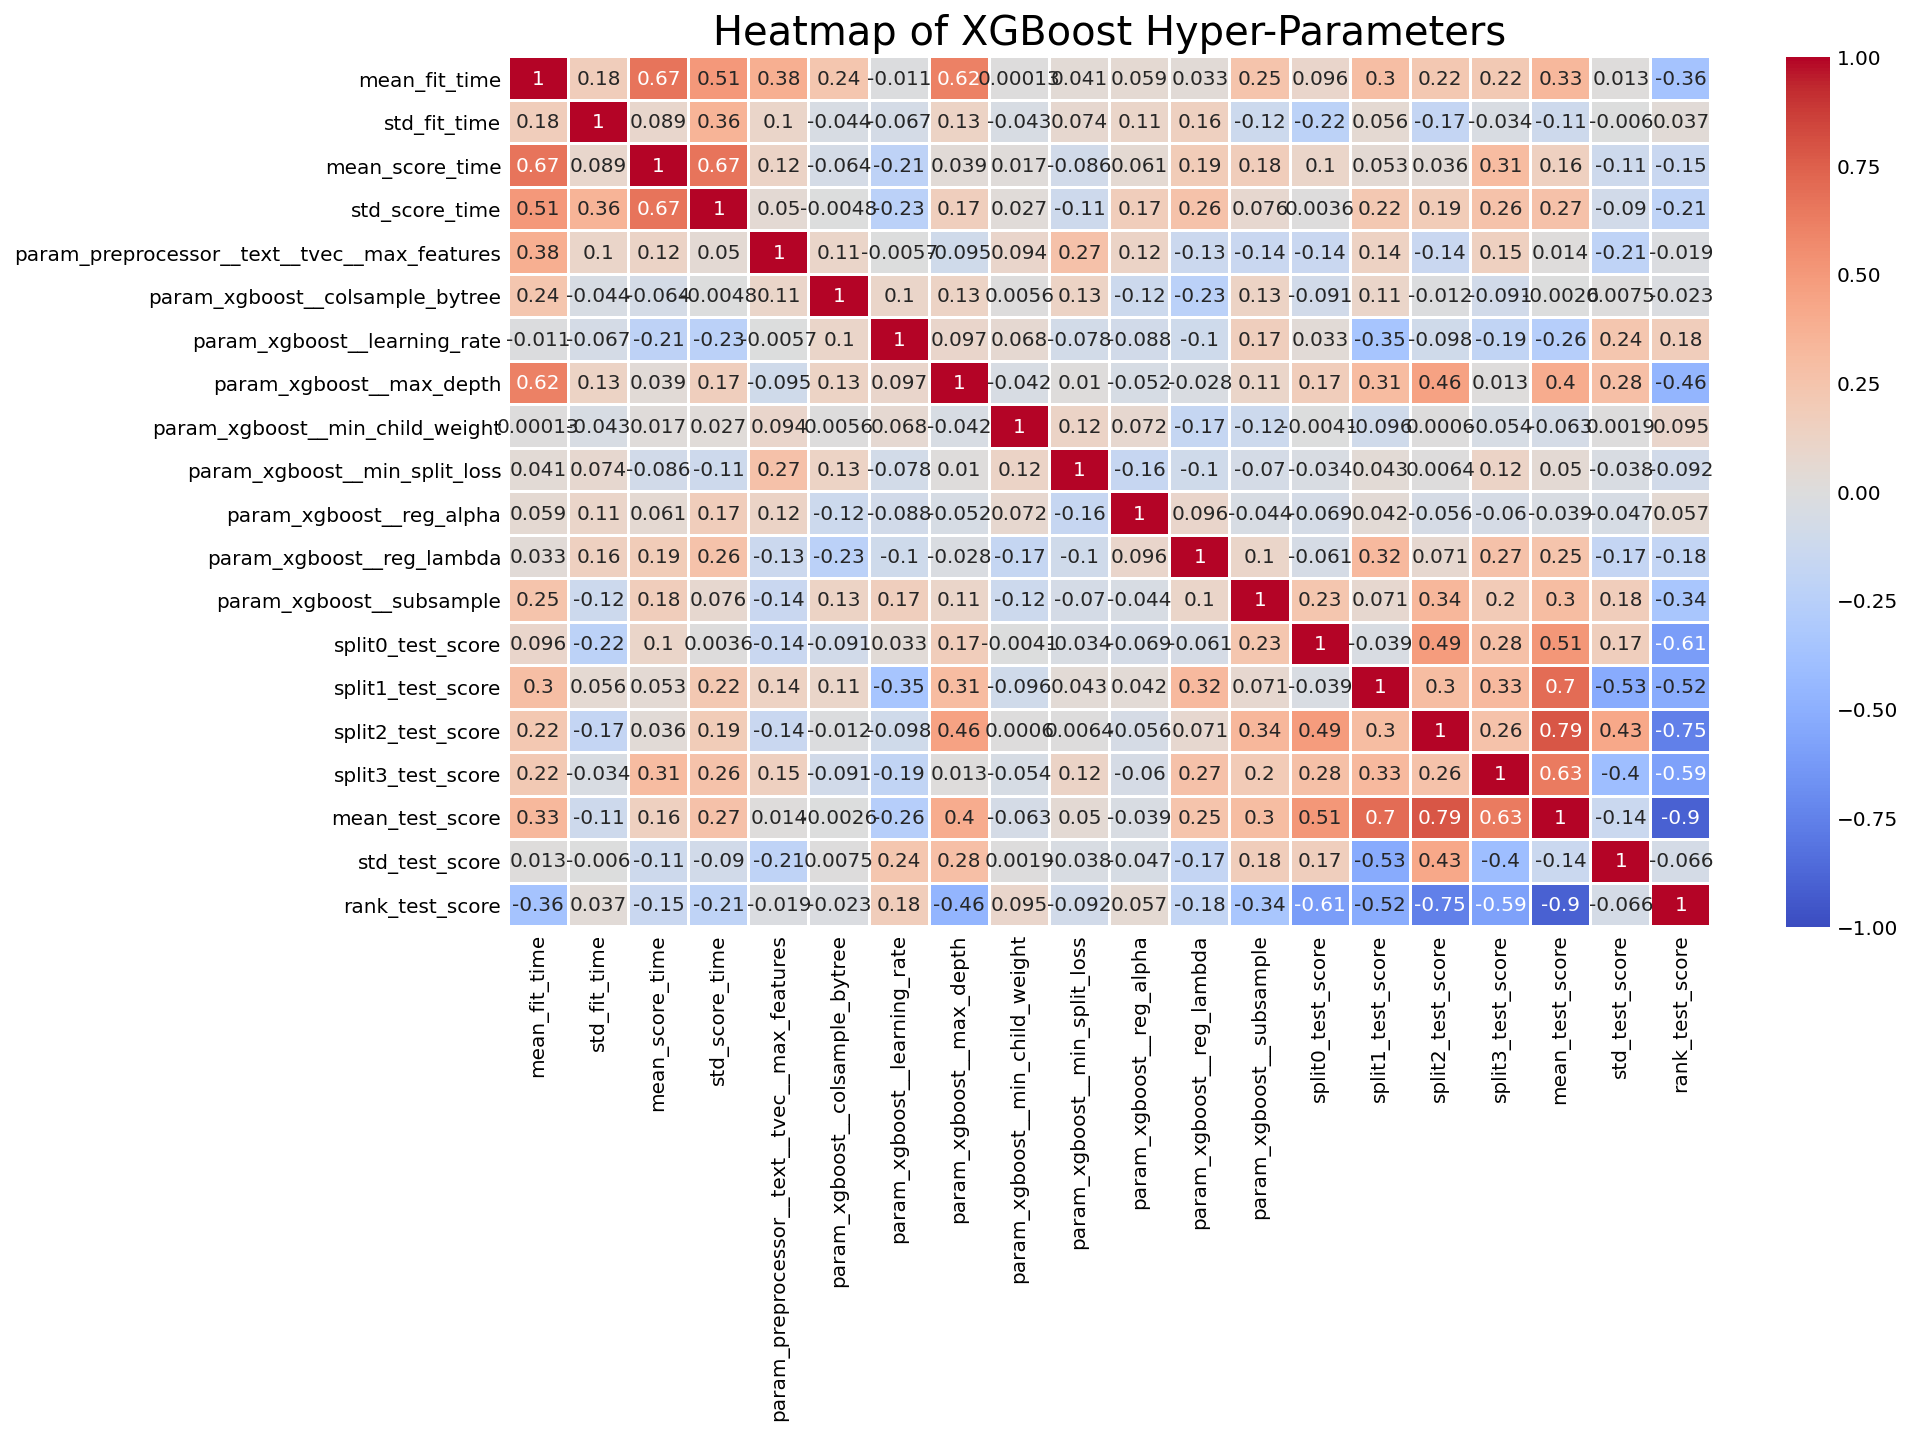

In [19]:
plt.figure(figsize=[12,8])
plt.title("Heatmap of XGBoost Hyper-Parameters", size=20)
sns.heatmap(df_rs_xgbT.corr(), annot=True, linewidths=1, vmin=-1, vmax=1, cmap="coolwarm")
plt.savefig("../assets/hparams_xgbT_heatmap.png", transparent=True, bbox_inches='tight')
plt.show()

By following the `mean_test_score` row, we can trace the CV score correlation to the hyper-parameters. Ignoring the test scores from the 4 CV splits as well as time-related observations, the parameter most highly-correlated with `mean_test_score` is `max_depth` at +0.4. A few other hyper-parameters of note are `subsample` at +0.3, `learning_rate` at -0.26, and `reg_lambda` at +0.25.

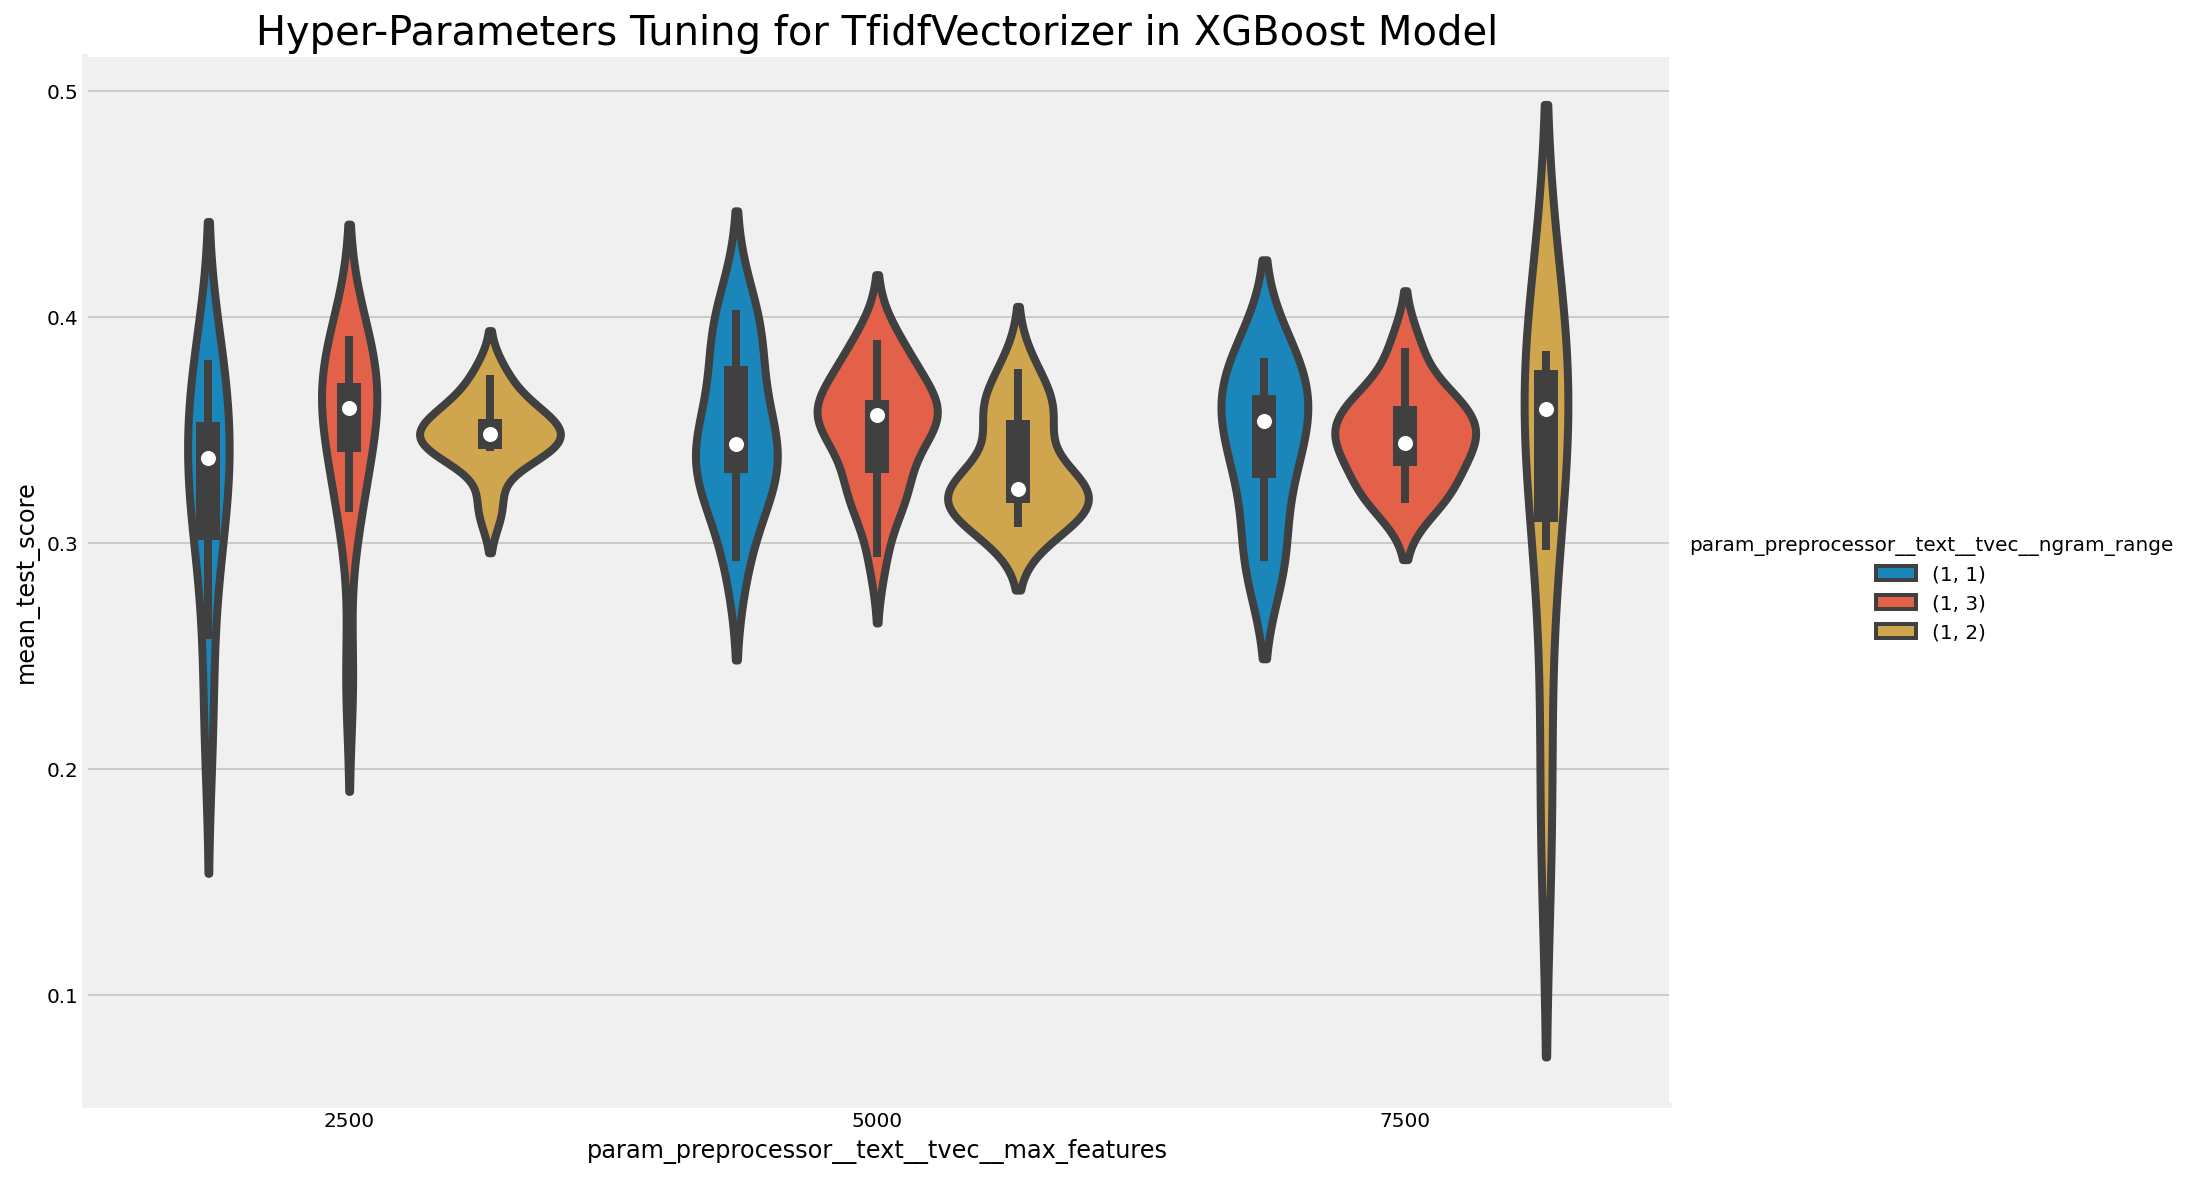

In [20]:
sns.catplot(data=df_rs_xgbT,
            x='param_preprocessor__text__tvec__max_features',
            y='mean_test_score',
            hue='param_preprocessor__text__tvec__ngram_range',
            height=8, aspect=1.5, kind="violin")
plt.gcf()
plt.title("Hyper-Parameters Tuning for TfidfVectorizer in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_tvec.png", transparent=True, bbox_inches='tight')
plt.show()

Generally as `ngram_range` and `max_features` increases, the variance of the score decreases. The only exception to this pattern is when `max_features` is 7500 with an `ngram_range` of (1,3).

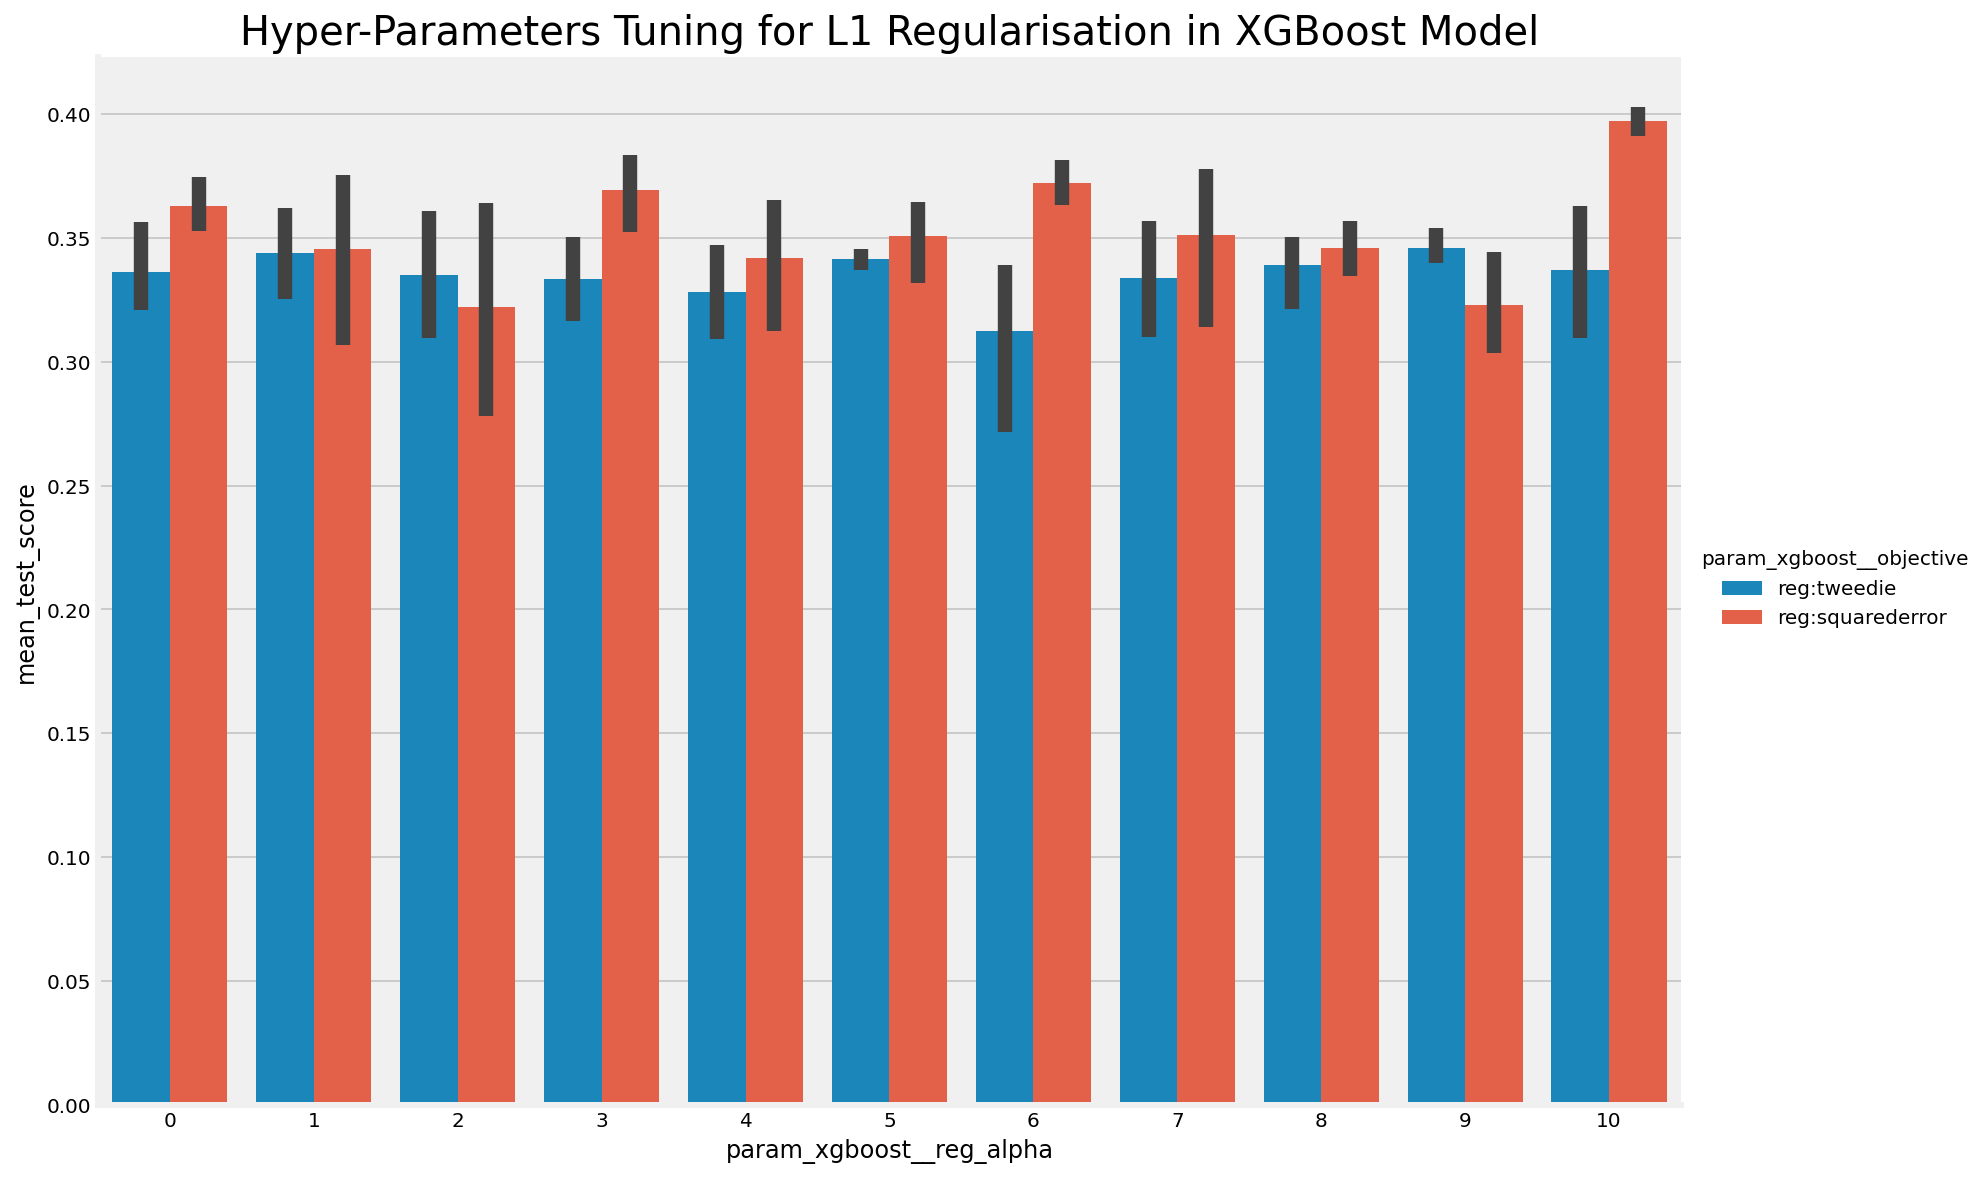

In [22]:
sns.catplot(data=df_rs_xgbT,
            x='param_xgboost__reg_alpha',
            y='mean_test_score',
            hue='param_xgboost__objective',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning for L1 Regularisation in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_alpha.png", transparent=True, bbox_inches='tight')
plt.show()

There is no discernible pattern here except that the CV score is generally better when `objective` is set to "reg:squarederror".

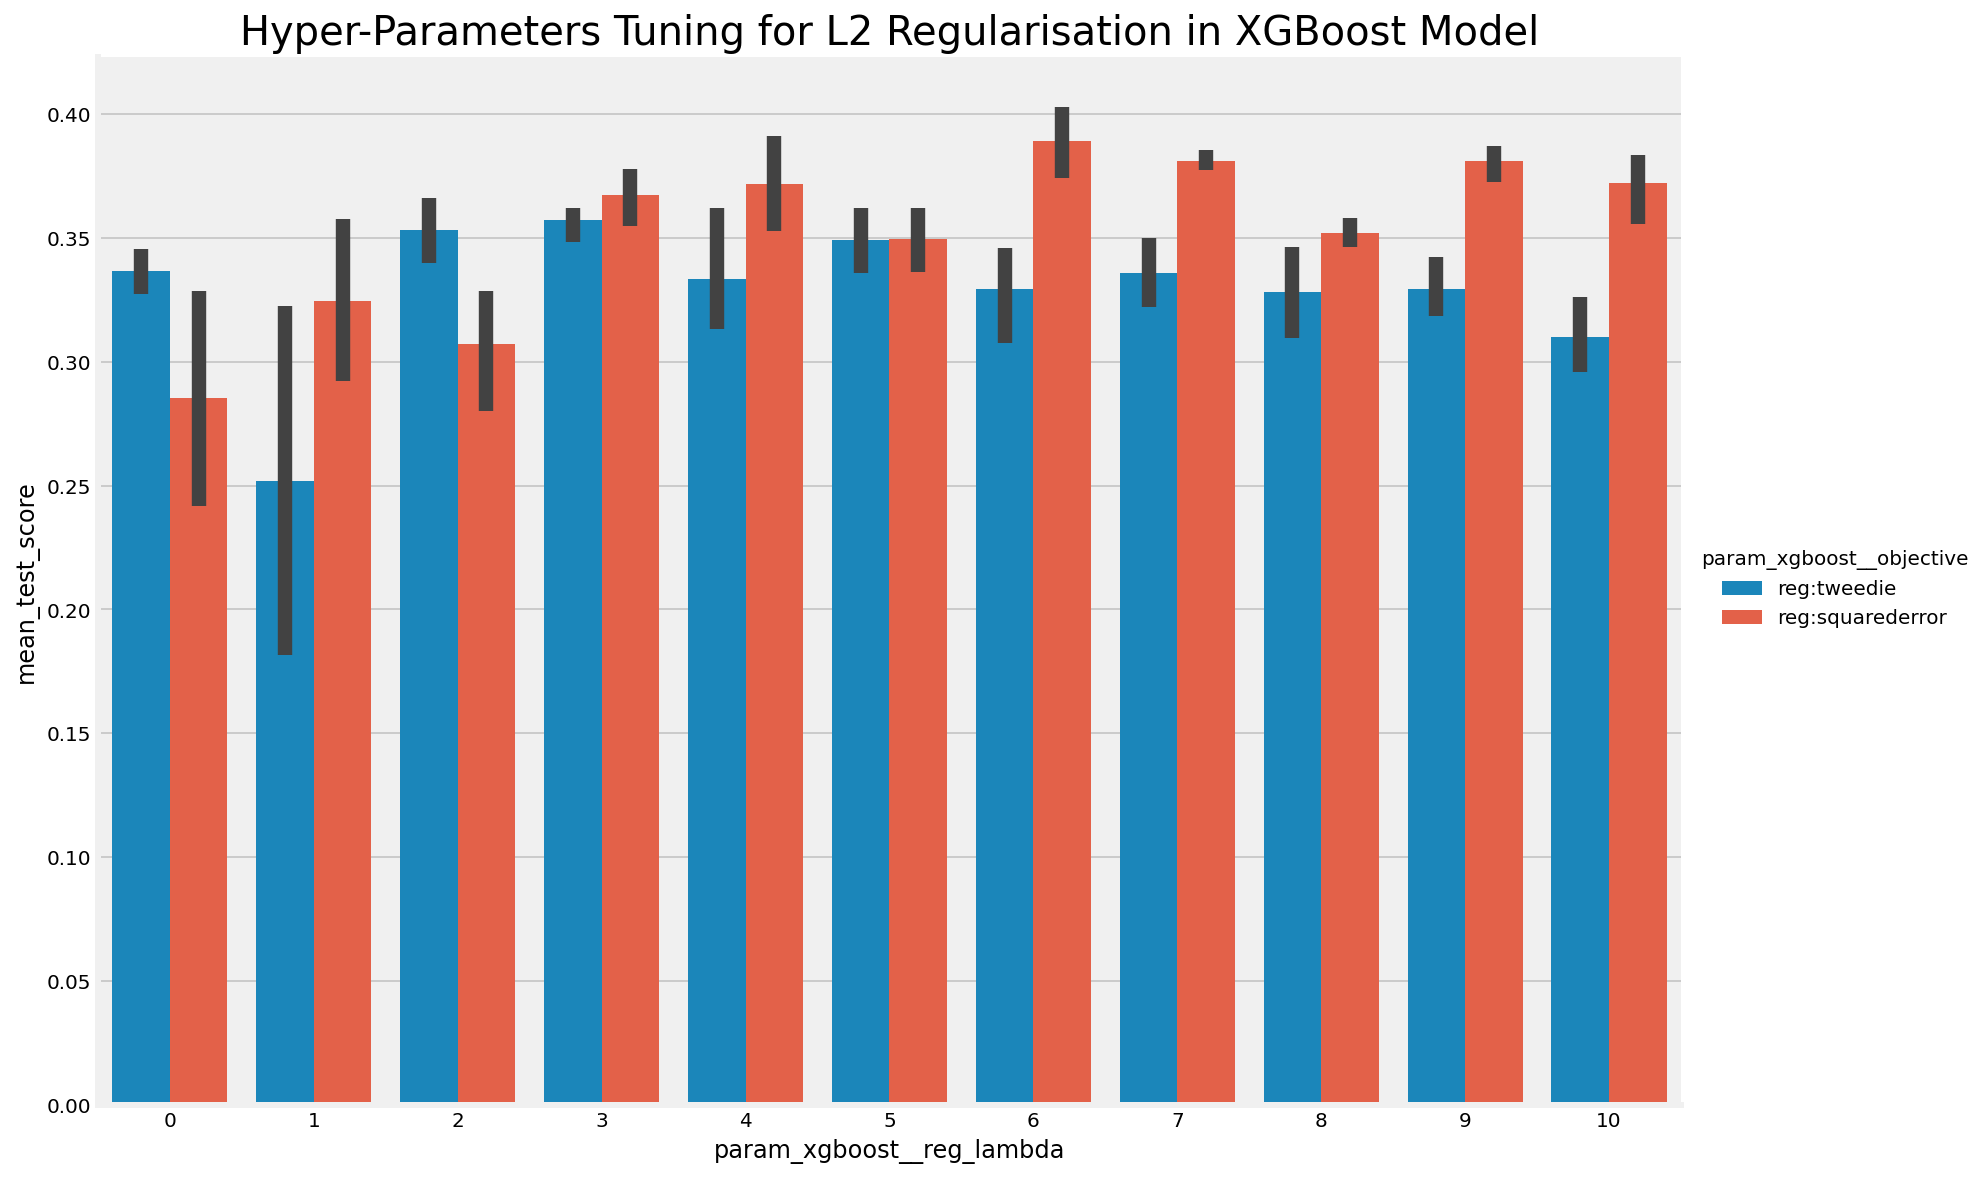

In [23]:
sns.catplot(data=df_rs_xgbT,
            x='param_xgboost__reg_lambda',
            y='mean_test_score',
            hue='param_xgboost__objective',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning for L2 Regularisation in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_lambda.png", transparent=True, bbox_inches='tight')
plt.show()

There is also no discernible pattern for `reg_lambda` here except that smaller values (less than 3) appear to give a worse CV score. When the CV score is higher, the CV score is generallyhigher when `objective` is set to "reg:squarederror".

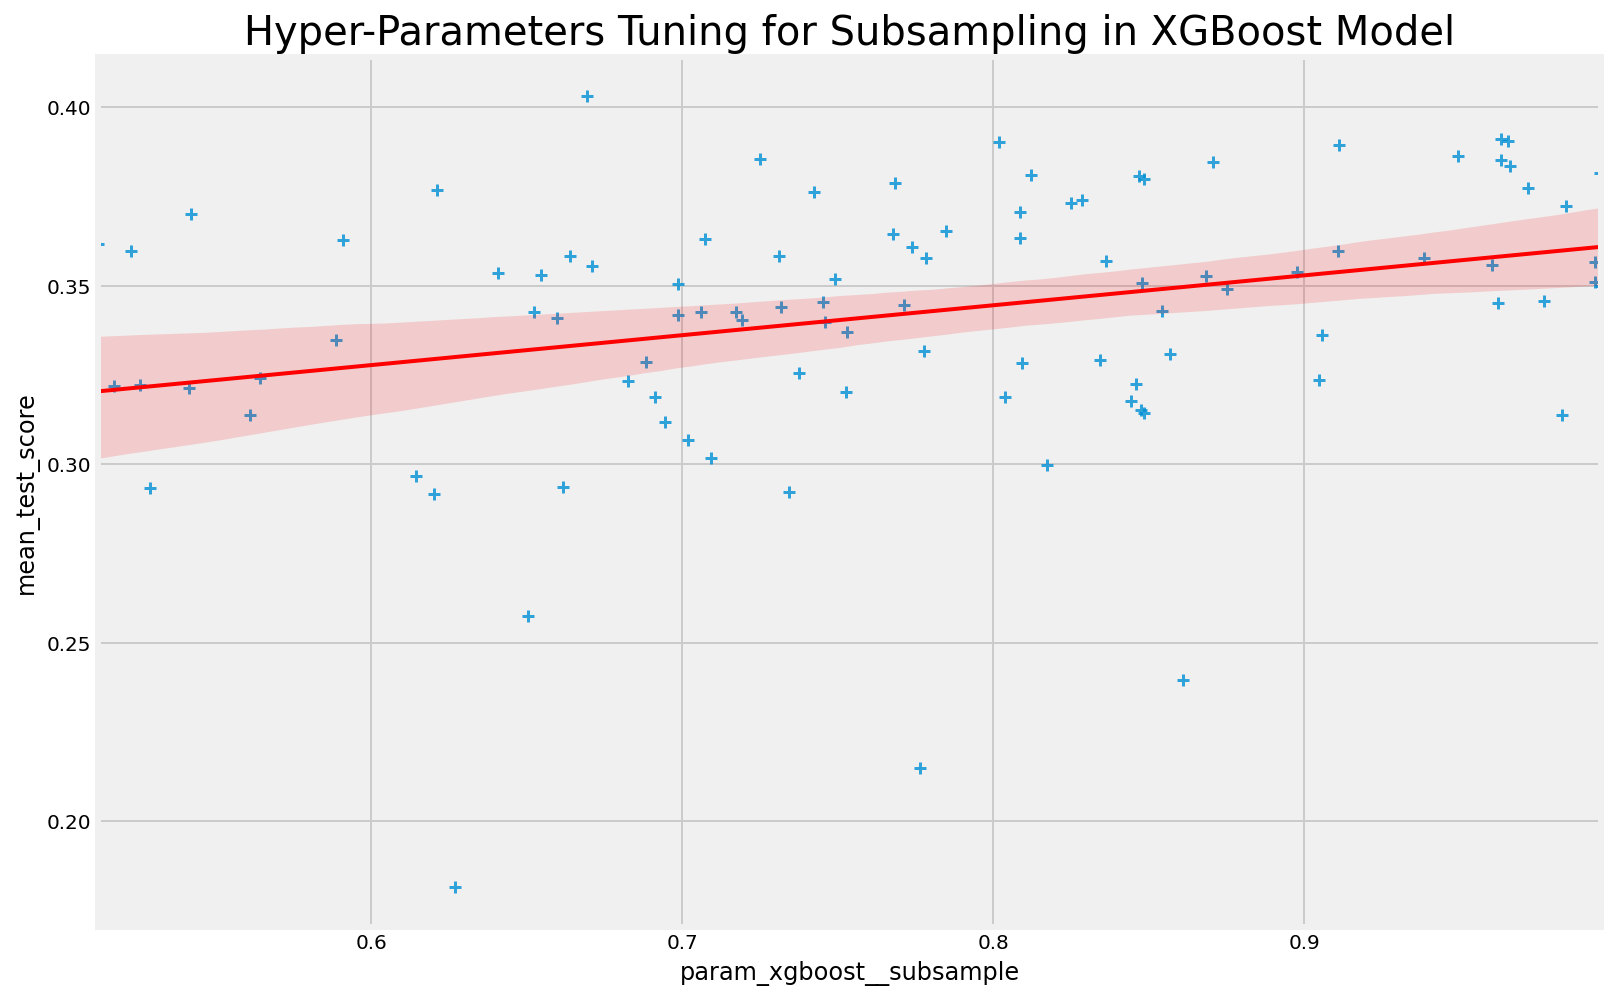

In [41]:
plt.figure(figsize=[12,8])
plt.title("Hyper-Parameters Tuning for Subsampling in XGBoost Model", size=20)
sns.regplot(data=df_rs_xgbT,
            x='param_xgboost__subsample',
            y='mean_test_score',
            marker="+", scatter_kws={"lw": 1.5},
            line_kws={"lw": 2, "color": "r"})
plt.savefig("../assets/hparams_xgbT_subsample.png", transparent=True, bbox_inches='tight')
plt.show()

There is an uptred between `subsample` and the CV scores.

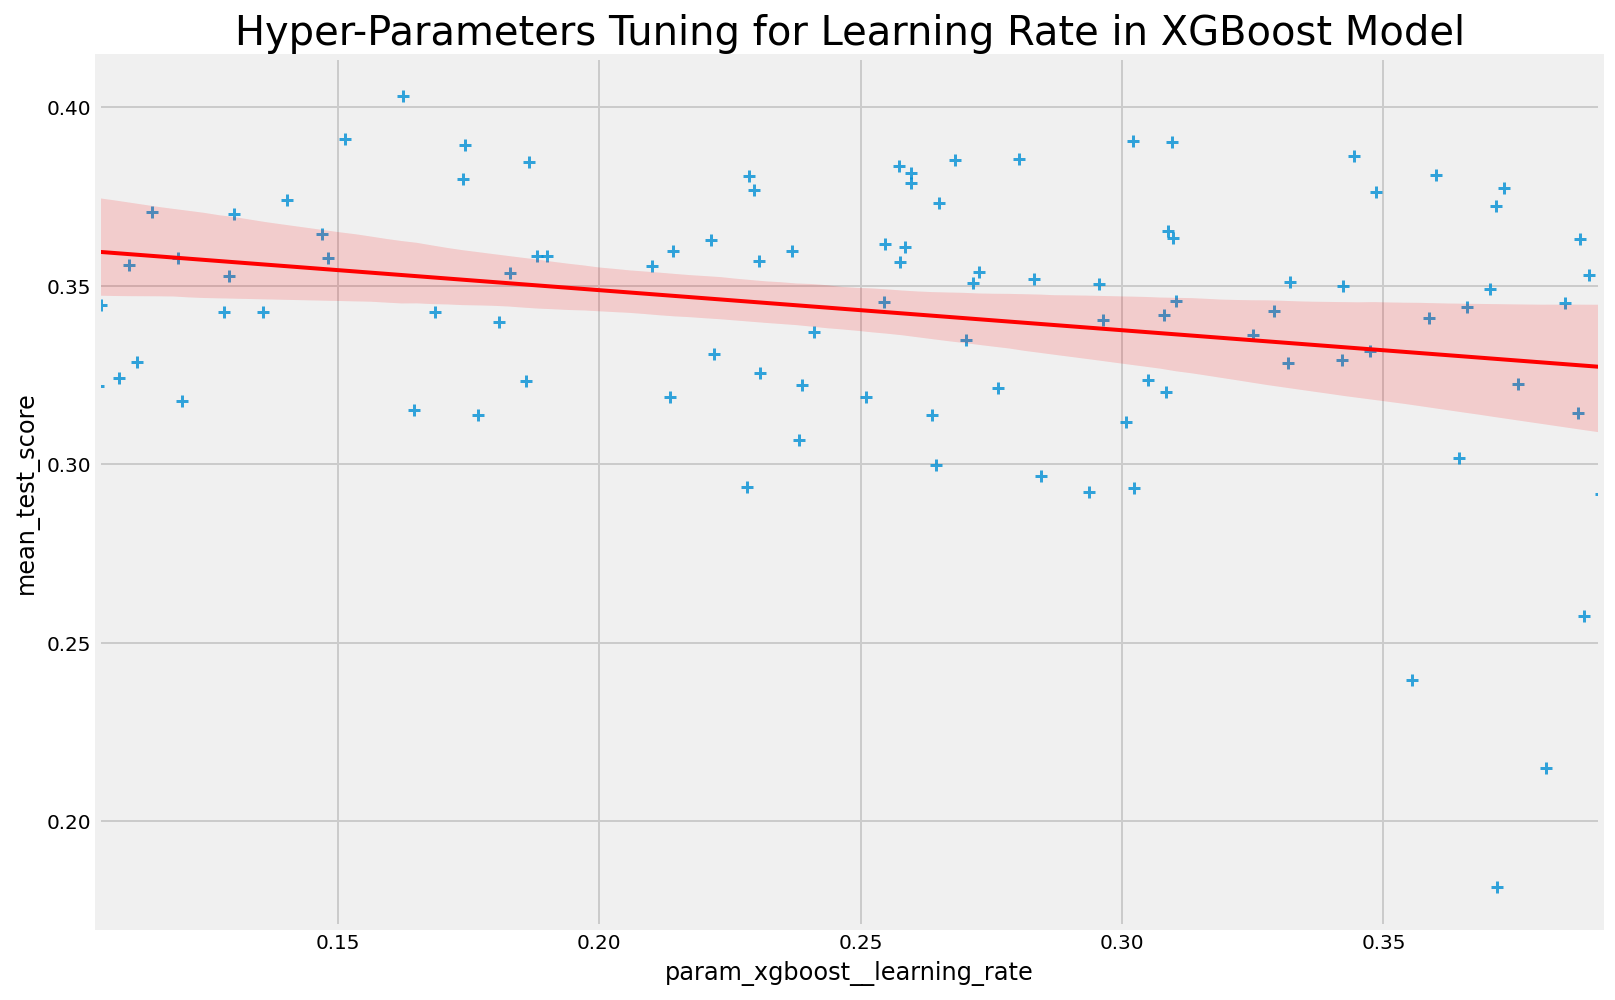

In [43]:
plt.figure(figsize=[12,8])
plt.title("Hyper-Parameters Tuning for Learning Rate in XGBoost Model", size=20)
sns.regplot(data=df_rs_xgbT,
            x='param_xgboost__learning_rate',
            y='mean_test_score',
            marker="+", scatter_kws={"lw": 1.5},
            line_kws={"lw": 2, "color": "r"})
plt.savefig("../assets/hparams_xgbT_learning.png", transparent=True, bbox_inches='tight')
plt.show()

There is a downtrend between `learning_rate` and the CV scores. We should therefore keep our learning rate low.

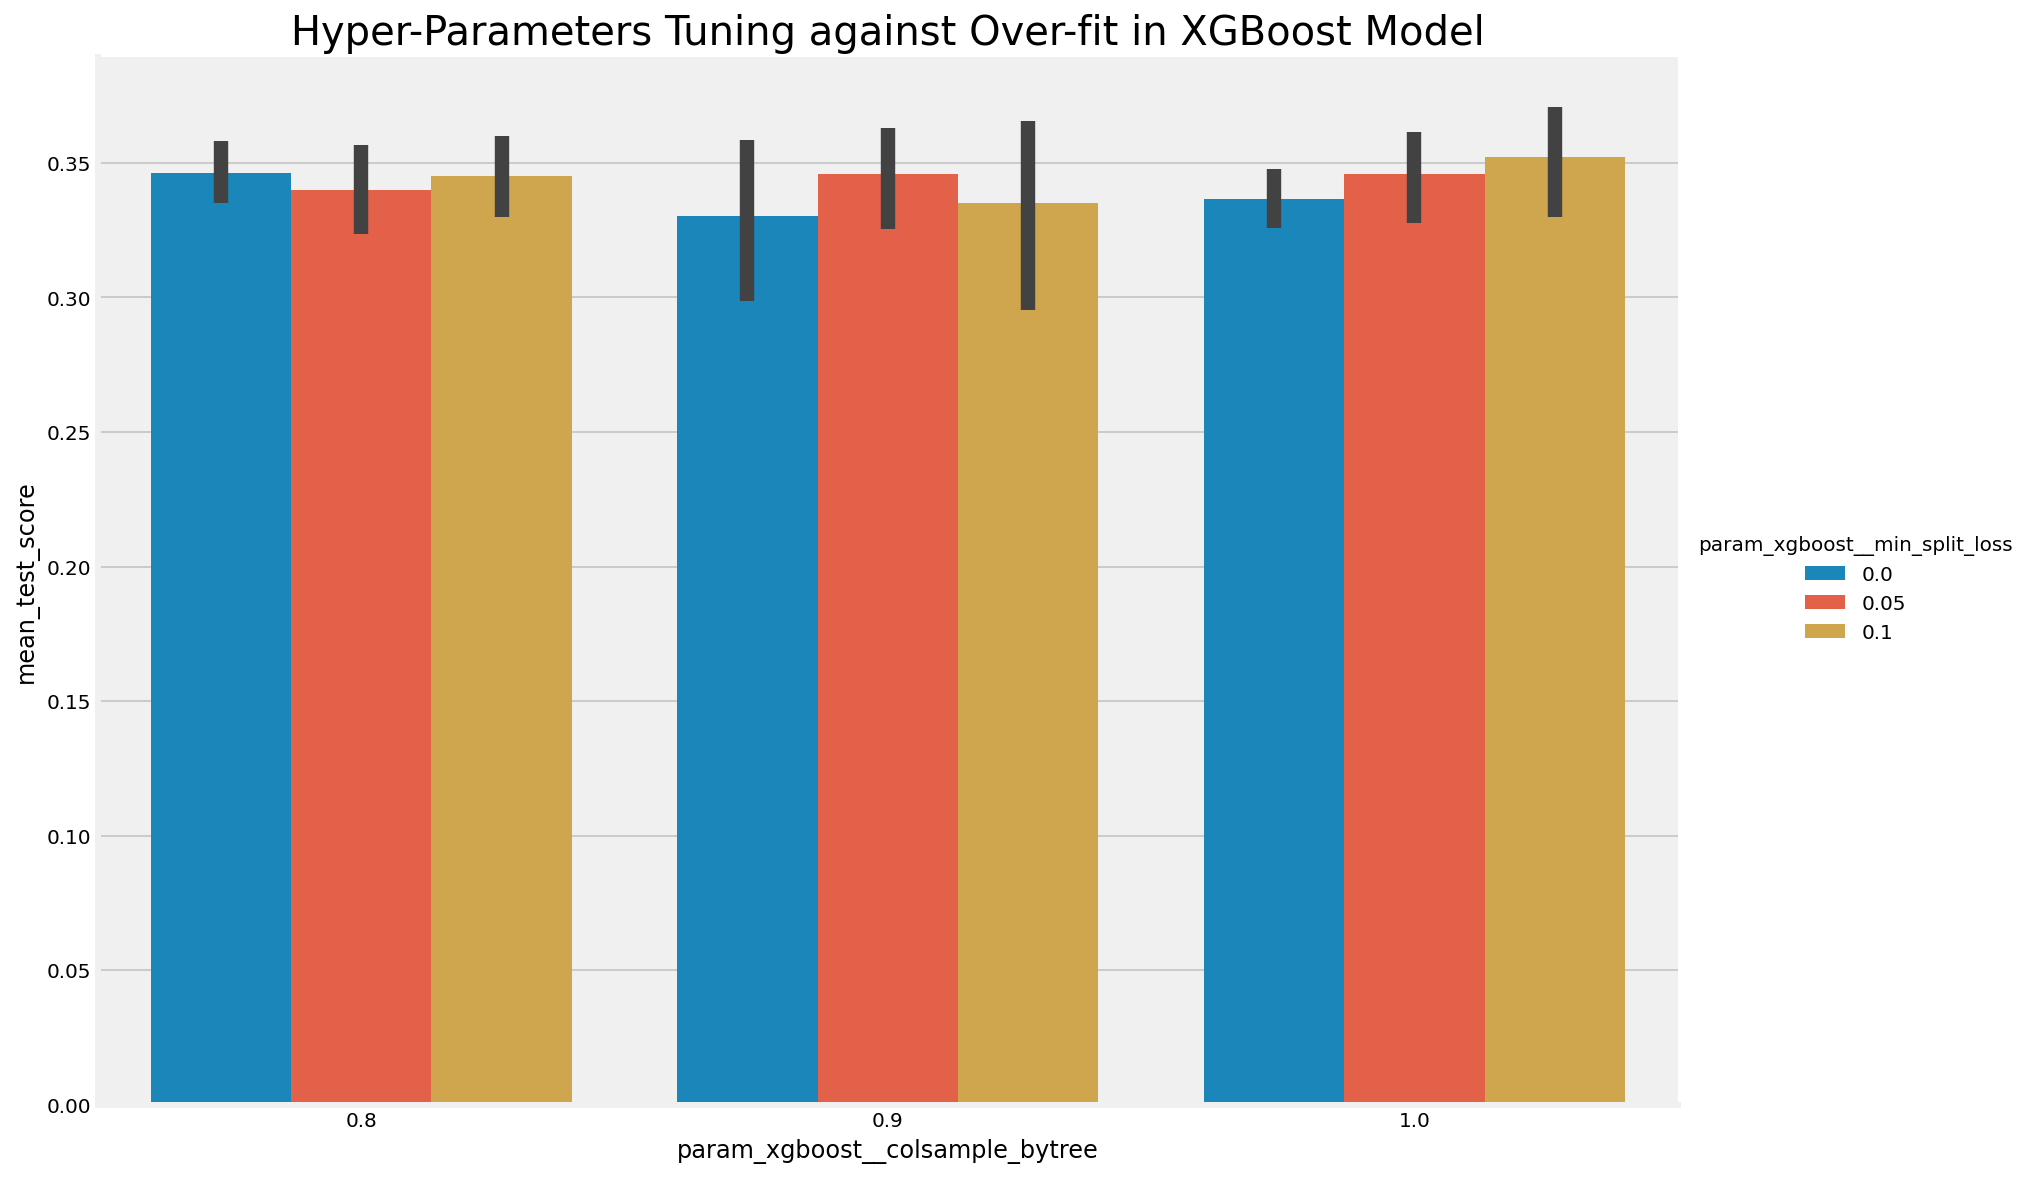

In [47]:
sns.catplot(data=df_rs_xgbT,
            x='param_xgboost__colsample_bytree',
            y='mean_test_score',
            hue='param_xgboost__min_split_loss',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning against Over-fit in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_overfit.png", transparent=True, bbox_inches='tight')
plt.show()

There is no discernible pattern here.

### XGBoost Model

Using the best hyper-parameters from Randomised Search above:
```
{'preprocessor__text__tvec__max_features': 7500,
 'preprocessor__text__tvec__ngram_range': (1, 1),
 'xgboost__colsample_bytree': 0.8,
 'xgboost__learning_rate': 0.1829580913840863,
 'xgboost__max_depth': 5,
 'xgboost__min_child_weight': 4,
 'xgboost__min_split_loss': 0.1,
 'xgboost__objective': 'reg:squarederror',
 'xgboost__reg_alpha': 7,
 'xgboost__reg_lambda': 5,
 'xgboost__subsample': 0.9480024594664191}
 ```
 Let's build our first full XGBoost model using said hyper-parameters and evaluate its performance.

In [48]:
# match best params from above for TfidfVectorizer
tvec = TfidfVectorizer(stop_words="english", max_features=7500)
X_train_tvec = tvec.fit_transform(X_train["content_stem"])
print("Shape of training sparse matrix:", X_train_tvec.shape)
X_unseen_tvec = tvec.transform(X_unseen["content_stem"])
print("Shape of test sparse matrix:", X_unseen_tvec.shape)

Shape of training sparse matrix: (18109, 7500)
Shape of test sparse matrix: (6037, 7500)


In [49]:
# get dummies for each platform
train_platforms = pd.get_dummies(X_train["platform"]).values
unseen_platforms = pd.get_dummies(X_unseen["platform"]).values

# add 3 cols of dummies data to tvec
X_train_tvec_dumm = hstack([X_train_tvec, train_platforms]).toarray()
X_unseen_tvec_dumm = hstack([X_unseen_tvec, unseen_platforms]).toarray()
print("Shape of training Tfidf-Vectorizer:", X_train_tvec_dumm.shape)
print("Shape of test Tfidf-Vectorizer:", X_unseen_tvec_dumm.shape)

Shape of training Tfidf-Vectorizer: (18109, 7503)
Shape of test Tfidf-Vectorizer: (6037, 7503)


In [50]:
%%time
xgboost = xgb.XGBRegressor(booster="gbtree",
                           objective="reg:squarederror",
                           colsample_bytree=0.8,
                           learning_rate=0.2,
                           max_depth=5,
                           min_child_weight=4,
                           min_split_loss=0.1,
                           reg_alpha=7,
                           reg_lambda=5,
                           subsample=0.95)

xgboost.fit(X_train_tvec_dumm, y_train)

Wall time: 4min 38s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.100000001,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=5,
             min_child_weight=4, min_split_loss=0.1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, random_state=0, reg_alpha=7, reg_lambda=5,
             scale_pos_weight=1, subsample=0.95, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [51]:
xgb_predictions = xgboost.predict(X_unseen_tvec_dumm)
print("R2 score:", r2_score(y_unseen, xgb_predictions))
print("MSE:", mean_squared_error(y_unseen, xgb_predictions))

R2 score: 0.4665557145579732
MSE: 51089.218907950366


Our XGBoost model is giving us our best score for both R2 and MSE to date. Let's take a closer look at the features that are contributing to this performance/predictions.

In [52]:
# compile feature labels
features = tvec.get_feature_names().copy()
features.extend(list(pd.get_dummies(X_train["platform"]).columns))
len(features)

7503

In [53]:
# create df for features and their weights
df_feat_weights = pd.DataFrame(zip(features, xgboost.feature_importances_), columns=["feature", "weight"])
df_feat_weights.sort_values("weight", ascending=False).head(3)

feature    weight
7502   YouTube Videos  0.132572
4047  modernnotorieti  0.052812
2113    exploreveryth  0.026947

In [54]:
df_feat_weights["weight"].describe()

count    7503.000000
mean        0.000133
std         0.001851
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.132572
Name: weight, dtype: float64

More than 75% of the features are weighted 0. This means our Lasso regularisation did a good job of removing irrelevant features. This is to be expected from an NLP model.

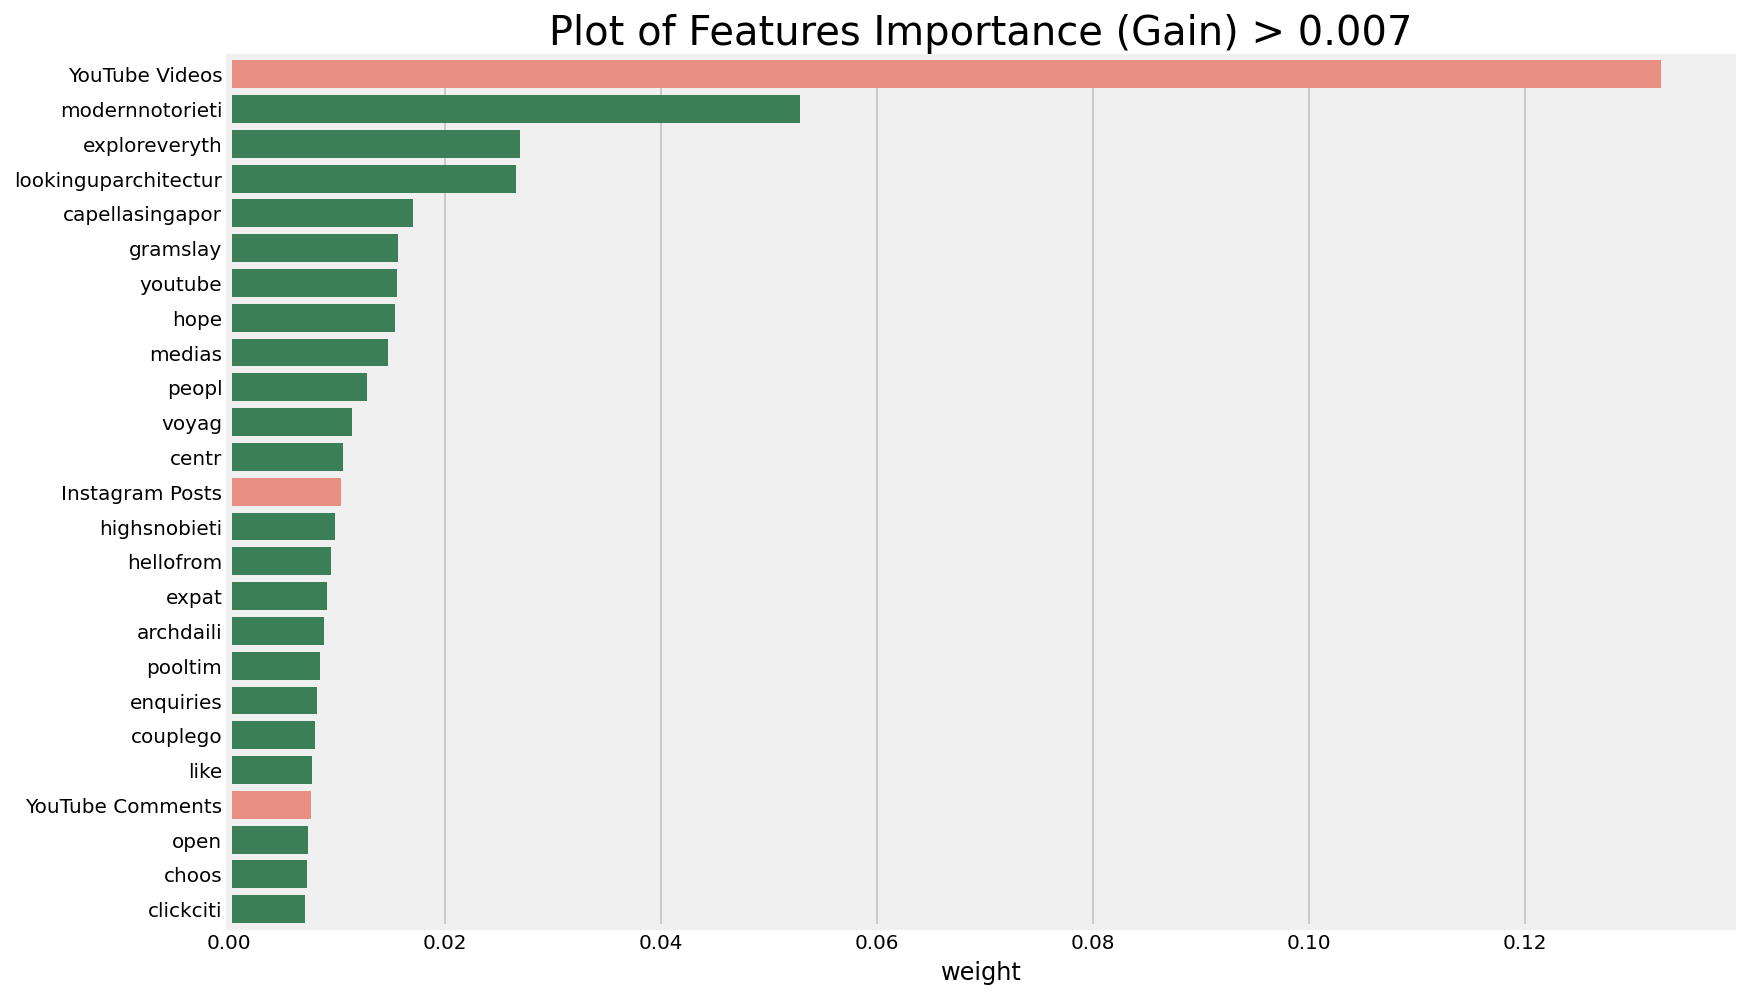

In [56]:
fig, ax = plt.subplots(1, 1, figsize=[12,8])
plt.title("Plot of Features Importance (Gain) > 0.007", size=20)
mask = df_feat_weights["weight"] > 0.007
order = df_feat_weights[mask].sort_values("weight", ascending=False)["feature"].values
palette = ['salmon' if feat=="Instagram Posts" or feat=="YouTube Videos" or feat=="YouTube Comments"
           else 'seagreen' for feat in df_feat_weights[mask].sort_values("weight", ascending=False)["feature"]]
sns.barplot(data=df_feat_weights[mask], x="weight", y="feature", orient="h", order=order, palette=palette)
ax.set_ylabel("")
plt.savefig("../assets/xgbT_features_gain.png", transparent=True, bbox_inches='tight')
plt.show()

#### Turning Point

The above bar chart maps out the importance of certain features by plotting out each feature's gain. "Gain" is the improvement in accuracy brought about by a feature to the branches it is on than if another feature/split were to be used. We must take extra care in evaluating the importance of our features as our features importance chart seems skewed, especially towards our `YouTube Videos` dummy.

The skewed importance of our `YouTube Videos` dummy suggests to us that the word features from YouTube videos (such as its title and its video captions) are not good predictors, when in fact, it would be more accurate to say that the word features from the videos are less helpful to accurate predictions than the data that tells us that the data point is a YouTube video. For the case study of `YouTube Videos` data points, this means that its corresponding word features would receive less weight since the `YouTube Videos` dummy is already able to account for much of the splits that lead to branches/predictions. This also means that word features are under-weighted in favour of non-NLP features, especially so for `YouTube Videos` data points.

This skewness highlights again another problem previously considered in notebook 3.5 - the different scales and distributions of likes on each platform. The rationale behind adding dummies rather than scaling the likes was because it gave us a better model and score. While the model was indeed able to account for the different distribution of likes through the dummies by giving us a decent score, the result is a features importance matrix that is skewed and not very useful for interpretation. When our model is over/under-reliant on the dummies, weightage given to the word features are accordingly over/under-weighted. For want of a model that can offer us meaningful NLP inference, we have two options previously considered that we may revert back to:

- Individually **scale** each distribution of likes and do away with the addition of platform dummies.
- Change our prediction problem to one of **classification** by setting a threshold for popularity and doing away with the addition of platform dummies.

While this current weight matrix of our features may give us our (current) best predictive model, we should also reconsider our process since we intend to include meta-data that could help improve our model. This could potentially exacerbate the problem we have now by skewing weight away from our word features, a worse problem if the skew is uneven across platforms as it is now. After much consideration, it is decided that a **hybrid** model of pure NLP and non-NLP features would be the best way forward and would give us the best of both worlds. With a hybrid model, we should be able to infer more meaningfully from the NLP model, whilst also improving our predictions and discerning useful meta-features that can be worth noting.

In light of this change in model strategy, further consideration of what a hybrid regression model can offer (even with scaled likes) raised certain concerns. While the NLP features importance matrix should in such a scenario give us a fairer picture of the weight of each word feature, it would still be difficult to interpret just how much of an impact each word feature could have for promoting domestic toursim. Even after we inverse transform our scaled likes are able to predict the number of likes a certain campaign idea may receive on any one platform, we are still left with crucial task of qualifying this performance, if it exceeds expectations or if it leaves more to be desired.

When we consider this problem alongside our objective for our model to provide inference that can inform the next phase of the STB's campaign, it becomes clear that it does not fall within the scope of this project to qualify each like gained on Instagram or YouTube or otherwise. Instead, it will be more useful to STB to qualify how popular each word/idea is, with a different threshold for popularity depending on the platform and its distribution of likes, changing this project's prediction problem to one of classification.

Thus, we have reached this project's turning point. We shall hence proceed with a **hybrid classification model** that predicts if a data point would be popular. In notebook 3.5, we have in our model selection also briefly tested out a basic regression model using `LogisticRegression` to positive effect, so we know the classification problem is a data problem that we can solve. Since we have selected XGBoost as our preferred model both in terms of performance and speed, let us continue to build our models with XGBoost. To that end, it is helpful that XGBoost has algorithms that offers us the option of both linear and tree-based models. We shall have to (re)tune XGBoost hyper-parameters for each NLP and non-NLP model respectively.

But before that, let us first return to our EDA notebook 3.0 to prepare a new DataFrame with new target variables of popularity for our classification model to train on.

### Updated Training Set

Import new DataFrame for classification from the EDA notebook 3.0. New DataFrame comes with an updated `content` column and several non-NLP features that we will incorporate into our hybrid model.

In [2]:
df_merged_pop_extra = pd.read_csv("../datasets/df_merged_pop_extra.csv", parse_dates=["date_time"])
df_merged_pop_extra.head(3)

content  likes   age  popular  \
0  oh look natural heart shaped form ivan heng gl...     40  1958        0   
1  #exploresingapore #instasg #gfsingapore #gameo...     33  1687        0   
2  road hell reliving haw par villa 15 16 22 23 m...      3  2412        0   

          platform           date_time  year  month       day time_of_day  \
0  Instagram Posts 2015-06-13 18:44:55  2015   June  Saturday       Night   
1  Instagram Posts 2016-03-10 12:55:27  2016  March  Thursday   Afternoon   
2  Instagram Posts 2014-03-16 02:29:46  2014  March    Sunday    Midnight   

   hash_count  content_len  
0          18          326  
1          21          274  
2           1           95

In [3]:
df_merged_pop_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24067 entries, 0 to 24066
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   content      24067 non-null  object        
 1   likes        24067 non-null  int64         
 2   age          24067 non-null  int64         
 3   popular      24067 non-null  int64         
 4   platform     24067 non-null  object        
 5   date_time    24067 non-null  datetime64[ns]
 6   year         24067 non-null  int64         
 7   month        24067 non-null  object        
 8   day          24067 non-null  object        
 9   time_of_day  24067 non-null  object        
 10  hash_count   24067 non-null  int64         
 11  content_len  24067 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(5)
memory usage: 2.2+ MB


#### Prepare Training Set

In [4]:
# porter stemmer was chosen as the vectorizer better for the model
p_stemmer = PorterStemmer() # instantiate porter stemmer
text_tokens = [] # create empty list

for doc in df_merged_pop_extra["content"]:
    text_tokens.append([p_stemmer.stem(word) for word in doc.split()]) # stem each token in post and append list to list
df_merged_pop_extra["content_stem"] = [" ".join(doc) for doc in text_tokens] # concat into single str and create new col
df_merged_pop_extra.head(3) # verify new col added

content  likes   age  popular  \
0  oh look natural heart shaped form ivan heng gl...     40  1958        0   
1  #exploresingapore #instasg #gfsingapore #gameo...     33  1687        0   
2  road hell reliving haw par villa 15 16 22 23 m...      3  2412        0   

          platform           date_time  year  month       day time_of_day  \
0  Instagram Posts 2015-06-13 18:44:55  2015   June  Saturday       Night   
1  Instagram Posts 2016-03-10 12:55:27  2016  March  Thursday   Afternoon   
2  Instagram Posts 2014-03-16 02:29:46  2014  March    Sunday    Midnight   

   hash_count  content_len                                       content_stem  
0          18          326  oh look natur heart shape form ivan heng glen ...  
1          21          274  #exploresingapor #instasg #gfsingapor #gameoft...  
2           1           95  road hell reliv haw par villa 15 16 22 23 marc...

In [5]:
# prep dataset for NLP model
all_else = [feat for feat in df_merged_pop_extra.columns if feat != "popular"]
X = df_merged_pop_extra[all_else]
y = df_merged_pop_extra["popular"] # popularity target variable is universal for both NLP and non-NLP models

# train-test split
X_train, X_unseen, y_train, y_unseen = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

print("Training set size:", len(X_train))
print("Unseen test set size:", len(X_unseen))

Training set size: 18050
Unseen test set size: 6017


From our above new DataFrame, we need to create two separate DataFrames for our train-test split. One will be for our NLP model, and the other for our non-NLP model.

In [6]:
# NLP
X_nlp_train = X_train["content_stem"]
X_nlp_unseen = X_unseen["content_stem"]
print("NLP training set shape:", X_nlp_train.shape)
print("NLP unseen test set shape:", X_nlp_unseen.shape)

# non-NLP
non_nlp = ["age", "platform", "year", "month", "day", "time_of_day", "hash_count", "content_len"]
X_nnlp_train = X_train[non_nlp]
X_nnlp_unseen = X_unseen[non_nlp]
print("non-NLP training set shape:", X_nnlp_train.shape)
print("non-NLP unseen test set shape:", X_nnlp_unseen.shape)

NLP training set shape: (18050,)
NLP unseen test set shape: (6017,)
non-NLP training set shape: (18050, 8)
non-NLP unseen test set shape: (6017, 8)


In [7]:
# dummy out our non-NLP dataset
X_nnlp_train_dumm = pd.get_dummies(data=X_nnlp_train, columns=["platform", "year", "month", "day", "time_of_day"])
X_nnlp_unseen_dumm = pd.get_dummies(data=X_nnlp_unseen, columns=["platform", "year", "month", "day", "time_of_day"])
print("non-NLP training set shape:", X_nnlp_train_dumm.shape)
print("non-NLP unseen test set shape:", X_nnlp_unseen_dumm.shape)

non-NLP training set shape: (18050, 40)
non-NLP unseen test set shape: (6017, 40)


#### Baseline Accuracy

In [8]:
y_train.value_counts() # view total count of positive and negative classes

0    12793
1     5257
Name: popular, dtype: int64

In [9]:
y_train.value_counts(normalize=True) # view proportion of positive and negative classes

0    0.708753
1    0.291247
Name: popular, dtype: float64

Our target labels for our training set is a binary class variable. A `popular` value of 1 indicates that the data point is popular while a `popular` value of 0 indicates that the data point is not popular. The `popular` value of 1 is our minority class at 29.1%. This means that if we were to simply predict that all our data points are unpopular, we would have a baseline accuracy of 70.9%. Hence, this is the baseline accuracy to beat for our model to be meaningful and to be of value.

### Tune NLP Model

#### Random Forest

In [29]:
# build pipeline
pipe_rf = Pipeline(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                          ("rf", RandomForestClassifier())])

# set hyper params to tune
pipe_params_rf = {
    "tvec__max_features": [2500, 5000, 7500, 10_000],
    "tvec__ngram_range": [(1,1), (1,2), (1,3)],
    "rf__n_estimators": [100, 150, 200],
    "rf__max_depth": randint(2, 6),
    "rf__min_samples_split": randint(2, 6),
    "rf__min_samples_leaf": randint(2, 5),
    "rf__max_features": ["auto", "sqrt"],
    "rf__bootstrap": [True, False],
    "rf__max_samples": [0.8, 0.9, 1]
}

In [30]:
%%time
np.random.seed(42)
rs_rf_nlp = RandomizedSearchCV(estimator=pipe_rf, param_distributions=pipe_params_rf, n_iter=200, cv=4)
rs_rf_nlp.fit(X_nlp_train, y_train)
print("Best score in Randomised Search:", rs_rf_nlp.best_score_)
print()
print("Using the following hyper-parameters:")
rs_rf_nlp.best_params_

Best score in Randomised Search: 0.7345705540573881

Using the following hyper-parameters:
Wall time: 46min 36s


{'rf__bootstrap': False,
 'rf__max_depth': 5,
 'rf__max_features': 'auto',
 'rf__max_samples': 0.9,
 'rf__min_samples_leaf': 4,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 150,
 'tvec__max_features': 2500,
 'tvec__ngram_range': (1, 2)}

#### XGBoost (Linear)

In [12]:
# build pipeline
pipe_xgbL = Pipeline(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                            ("xgboost", xgb.XGBClassifier(booster="gblinear", # try "gblinear" again even though it did not perform well
                                                          objective="binary:logistic"))])

# set hyper params to tune
pipe_params_xgbL = {
    "tvec__max_features": [2500, 5000, 7500],
    "tvec__ngram_range": [(1,1), (1,2), (1,3)],
    "xgboost__reg_alpha": randint(0, 11),
    "xgboost__reg_lambda": randint(0, 11),
    "xgboost__feature_selector": ["cyclic", "shuffle"]
}

In [13]:
%%time
np.random.seed(42)
rs_xgbL_nlp = RandomizedSearchCV(estimator=pipe_xgbL, param_distributions=pipe_params_xgbL, n_iter=100, cv=4, scoring="roc_auc")
rs_xgbL_nlp.fit(X_nlp_train, y_train)
print("Best score in Randomised Search:", rs_xgbL_nlp.best_score_)
print()
print("Using the following hyper-parameters:")
rs_xgbL_nlp.best_params_

Best score in Randomised Search: 0.7676940300311156

Using the following hyper-parameters:
Wall time: 16min 9s


{'tvec__max_features': 2500,
 'tvec__ngram_range': (1, 3),
 'xgboost__feature_selector': 'shuffle',
 'xgboost__reg_alpha': 0,
 'xgboost__reg_lambda': 0}

#### XGBoost (Tree)

In [14]:
# build pipeline
pipe_xgbT = Pipeline(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                            ("xgboost", xgb.XGBClassifier(booster="gbtree", # "gbtree" was our best performing model previously
                                                          objective="binary:logistic"))])

# set hyper params to tune
pipe_params_xgbT = {
    "tvec__max_features": [2500, 5000, 7500],
    "tvec__ngram_range": [(1,1), (1,2), (1,3)],
    "xgboost__reg_alpha": randint(0, 11),
    "xgboost__reg_lambda": randint(0, 11),
    "xgboost__gamma": uniform(0, 1),
    "xgboost__scale_pos_weight": [2, 2.5, 3], # xgb doc recommends sum(neg)/sum(pos) = 12_793/5257
    "xgboost__learning_rate": uniform(0, 1),
    "xgboost__min_split_loss": [0, 0.05, 0.1],
    "xgboost__max_depth": randint(2, 6),
    "xgboost__min_child_weight": randint(0, 5),
    "xgboost__subsample": uniform(0.5, 0.5),
    "xgboost__colsample_bytree": [0.8, 0.9, 1]
}

In [15]:
%%time
np.random.seed(42)
rs_xgbT_nlp = RandomizedSearchCV(estimator=pipe_xgbT, param_distributions=pipe_params_xgbT, n_iter=100, cv=4, scoring="roc_auc")
rs_xgbT_nlp.fit(X_nlp_train, y_train)
print("Best score in Randomised Search:", rs_xgbT_nlp.best_score_)
print()
print("Using the following hyper-parameters:")
rs_xgbT_nlp.best_params_

Best score in Randomised Search: 0.7849280823390798

Using the following hyper-parameters:
Wall time: 55min 13s


{'tvec__max_features': 2500,
 'tvec__ngram_range': (1, 3),
 'xgboost__colsample_bytree': 1,
 'xgboost__gamma': 0.3390297910487007,
 'xgboost__learning_rate': 0.3492095746126609,
 'xgboost__max_depth': 5,
 'xgboost__min_child_weight': 2,
 'xgboost__min_split_loss': 0.05,
 'xgboost__reg_alpha': 7,
 'xgboost__reg_lambda': 0,
 'xgboost__scale_pos_weight': 3,
 'xgboost__subsample': 0.9678174971104738}

#### Best NLP Model - XGBoost (Tree)

Since our tree-based XGBoost model gave us our best cross-validated ROC-AUC score, let us evaluate the hyper-parameters for this model.

In [33]:
df_rs_xgbT_nlp = pd.DataFrame(rs_xgbT_nlp.cv_results_)
df_rs_xgbT_nlp.to_csv("../datasets/df_rs_xgbT_nlp.csv", index=False) # save out df of randomized search
df_rs_xgbT_nlp.info() # notice certain cols that are numeric are not numeric

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   mean_fit_time                    100 non-null    float64
 1   std_fit_time                     100 non-null    float64
 2   mean_score_time                  100 non-null    float64
 3   std_score_time                   100 non-null    float64
 4   param_tvec__max_features         100 non-null    object 
 5   param_tvec__ngram_range          100 non-null    object 
 6   param_xgboost__colsample_bytree  100 non-null    object 
 7   param_xgboost__gamma             100 non-null    object 
 8   param_xgboost__learning_rate     100 non-null    object 
 9   param_xgboost__max_depth         100 non-null    object 
 10  param_xgboost__min_child_weight  100 non-null    object 
 11  param_xgboost__min_split_loss    100 non-null    object 
 12  param_xgboost__reg_alph

In [10]:
# re-import df
df_rs_xgbT_nlp = pd.read_csv("../datasets/df_rs_xgbT_nlp.csv")
df_rs_xgbT_nlp.head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       3.967408      0.033825         0.275762        0.038687   
1       5.881905      1.357587         0.612577        0.156654   
2       5.597018      0.159037         0.475379        0.030950   

   param_tvec__max_features param_tvec__ngram_range  \
0                      7500                  (1, 1)   
1                      7500                  (1, 2)   
2                      2500                  (1, 1)   

   param_xgboost__colsample_bytree  param_xgboost__gamma  \
0                              1.0              0.731994   
1                              0.8              0.969910   
2                              1.0              0.611853   

   param_xgboost__learning_rate  param_xgboost__max_depth  ...  \
0                      0.598658                         4  ...   
1                      0.832443                         3  ...   
2                      0.139494                         5  ...   

   param_xgboost__scale_pos_weight  param_xgboost__subsample  \
0                              3.0                  0.933088   
1                              2.5                  0.503533   
2                              2.0                  0.523225   

                                              params  split0_test_score  \
0  {'tvec__max_features': 7500, 'tvec__ngram_rang...           0.775401   
1  {'tvec__max_features': 7500, 'tvec__ngram_rang...           0.741266   
2  {'tvec__max_features': 2500, 'tvec__ngram_rang...           0.771233   

   split1_test_score  split2_test_score split3_test_score  mean_test_score  \
0           0.777363           0.780311          0.777825         0.777725   
1           0.752172           0.750637          0.757849         0.750481   
2           0.774996           0.773329          0.778806         0.774591   

   std_test_score  rank_test_score  
0        0.001748               13  
1        0.005960               89  
2        0.002775               23  

[3 rows x 24 columns]

In [11]:
# convert all cols that can be numeric into numeric dtypes
df_rs_xgbT_nlp["param_tvec__max_features"] = df_rs_xgbT_nlp["param_tvec__max_features"].astype(int)
df_rs_xgbT_nlp["param_xgboost__colsample_bytree"] = df_rs_xgbT_nlp["param_xgboost__colsample_bytree"].astype(float)
df_rs_xgbT_nlp["param_xgboost__gamma"] = df_rs_xgbT_nlp["param_xgboost__gamma"].astype(float)
df_rs_xgbT_nlp["param_xgboost__learning_rate"] = df_rs_xgbT_nlp["param_xgboost__learning_rate"].astype(float)
df_rs_xgbT_nlp["param_xgboost__max_depth"] = df_rs_xgbT_nlp["param_xgboost__max_depth"].astype(int)
df_rs_xgbT_nlp["param_xgboost__min_child_weight"] = df_rs_xgbT_nlp["param_xgboost__min_child_weight"].astype(int)
df_rs_xgbT_nlp["param_xgboost__min_split_loss"] = df_rs_xgbT_nlp["param_xgboost__min_split_loss"].astype(float)
df_rs_xgbT_nlp["param_xgboost__reg_alpha"] = df_rs_xgbT_nlp["param_xgboost__reg_alpha"].astype(int)
df_rs_xgbT_nlp["param_xgboost__reg_lambda"] = df_rs_xgbT_nlp["param_xgboost__reg_lambda"].astype(int)
df_rs_xgbT_nlp["param_xgboost__scale_pos_weight"] = df_rs_xgbT_nlp["param_xgboost__scale_pos_weight"].astype(float)
df_rs_xgbT_nlp["param_xgboost__subsample"] = df_rs_xgbT_nlp["param_xgboost__subsample"].astype(float)
df_rs_xgbT_nlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   mean_fit_time                    100 non-null    float64
 1   std_fit_time                     100 non-null    float64
 2   mean_score_time                  100 non-null    float64
 3   std_score_time                   100 non-null    float64
 4   param_tvec__max_features         100 non-null    int32  
 5   param_tvec__ngram_range          100 non-null    object 
 6   param_xgboost__colsample_bytree  100 non-null    float64
 7   param_xgboost__gamma             100 non-null    float64
 8   param_xgboost__learning_rate     100 non-null    float64
 9   param_xgboost__max_depth         100 non-null    int32  
 10  param_xgboost__min_child_weight  100 non-null    int32  
 11  param_xgboost__min_split_loss    100 non-null    float64
 12  param_xgboost__reg_alph

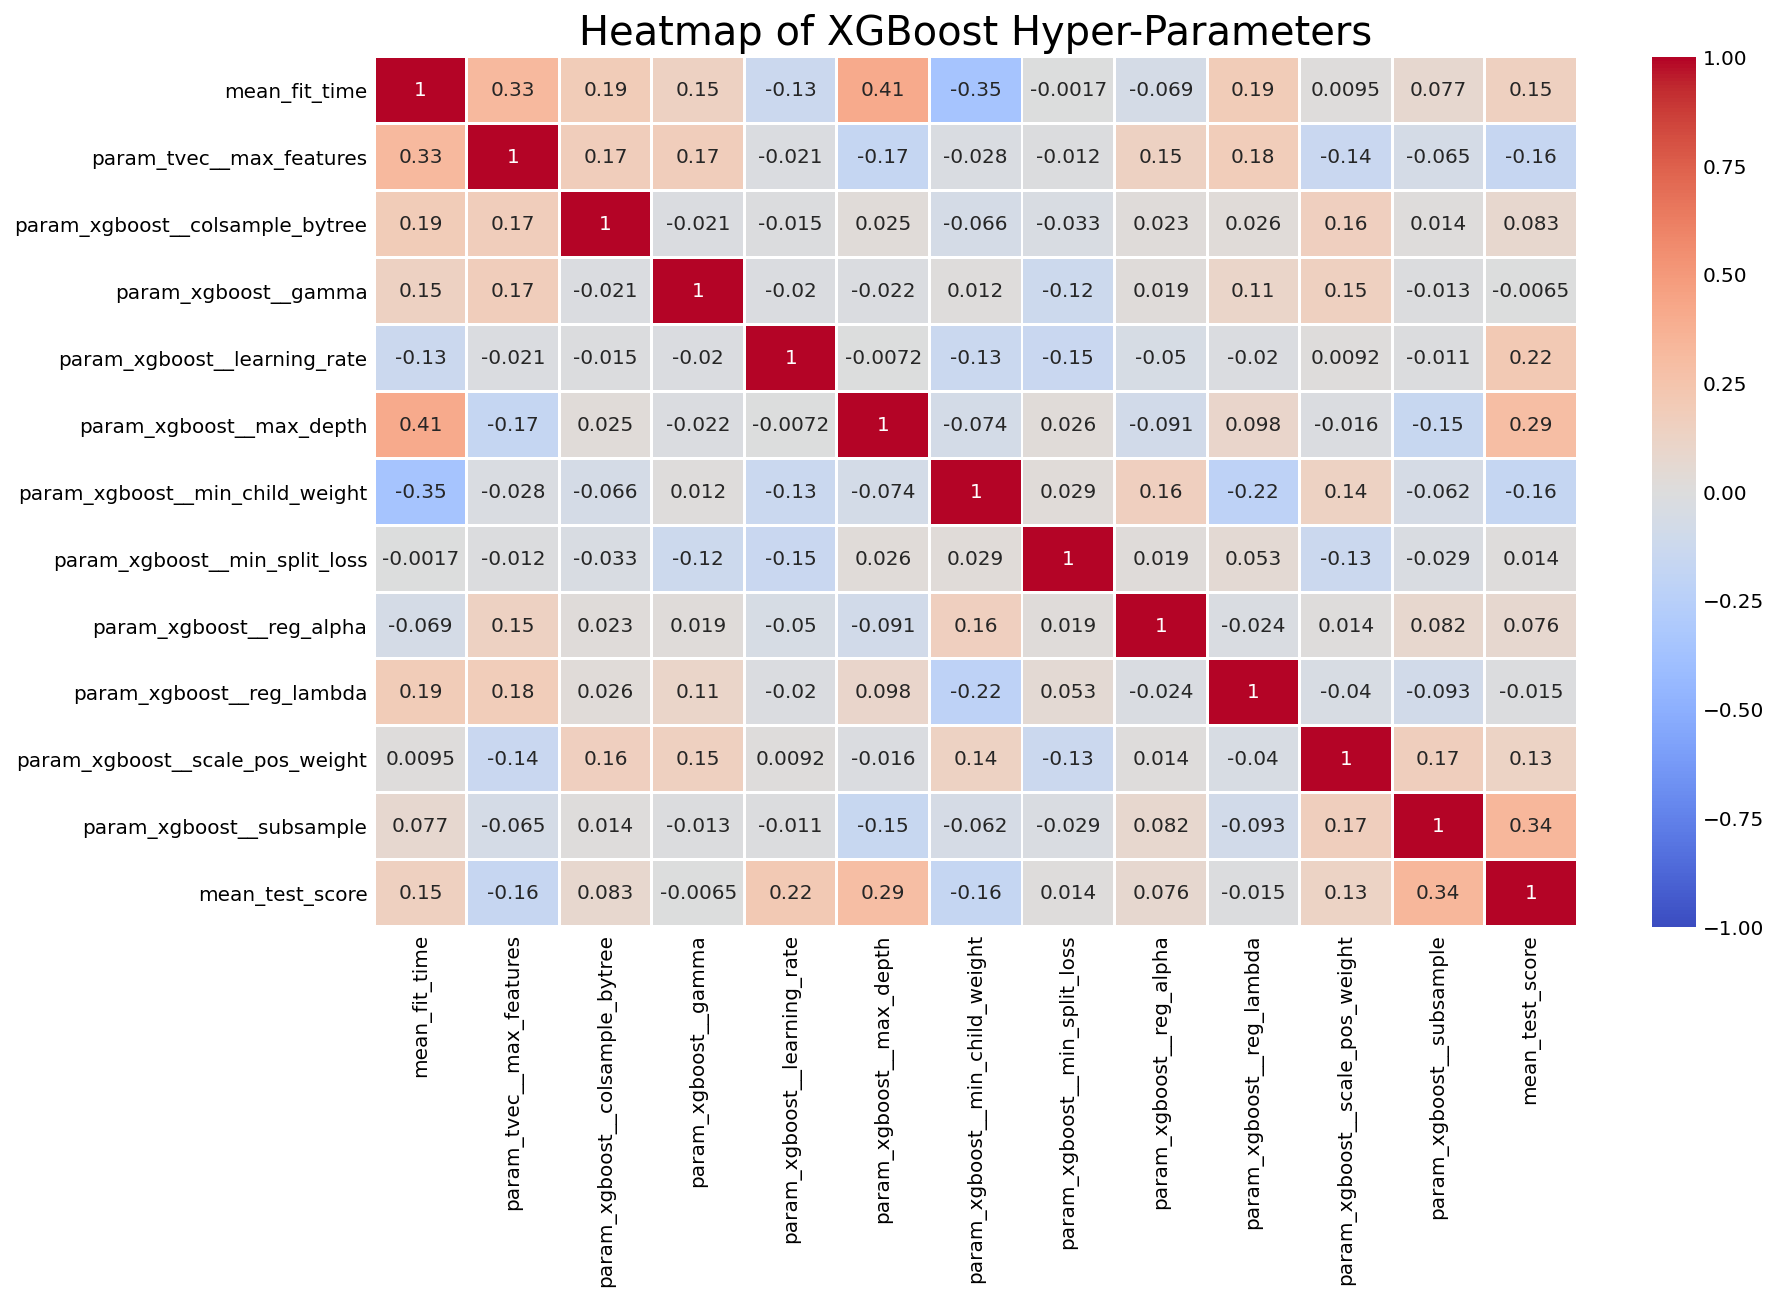

In [12]:
plt.figure(figsize=[12,8])
plt.title("Heatmap of XGBoost Hyper-Parameters", size=20)
include = ["mean_fit_time", "param_tvec__max_features", "param_tvec__ngram_range", "param_xgboost__colsample_bytree",
           "param_xgboost__gamma", "param_xgboost__learning_rate", "param_xgboost__max_depth",
           "param_xgboost__min_child_weight", "param_xgboost__min_split_loss", "param_xgboost__reg_alpha",
           "param_xgboost__reg_lambda", "param_xgboost__scale_pos_weight", "param_xgboost__subsample", "mean_test_score"]
sns.heatmap(df_rs_xgbT_nlp[include].corr(), annot=True, linewidths=1, vmin=-1, vmax=1, cmap="coolwarm")
plt.savefig("../assets/hparams_xgbT_nlp_heatmap.png", transparent=True, bbox_inches='tight')
plt.show()

By following the `mean_test_score` row, we can trace the CV score correlation to the hyper-parameters. Our top 3 hyper-parameters most correlated with `mean_test_score` is XGBoost's `subsample` at +0.34, `max_depth` at +0.29, and `learning_rate` at +0.22.

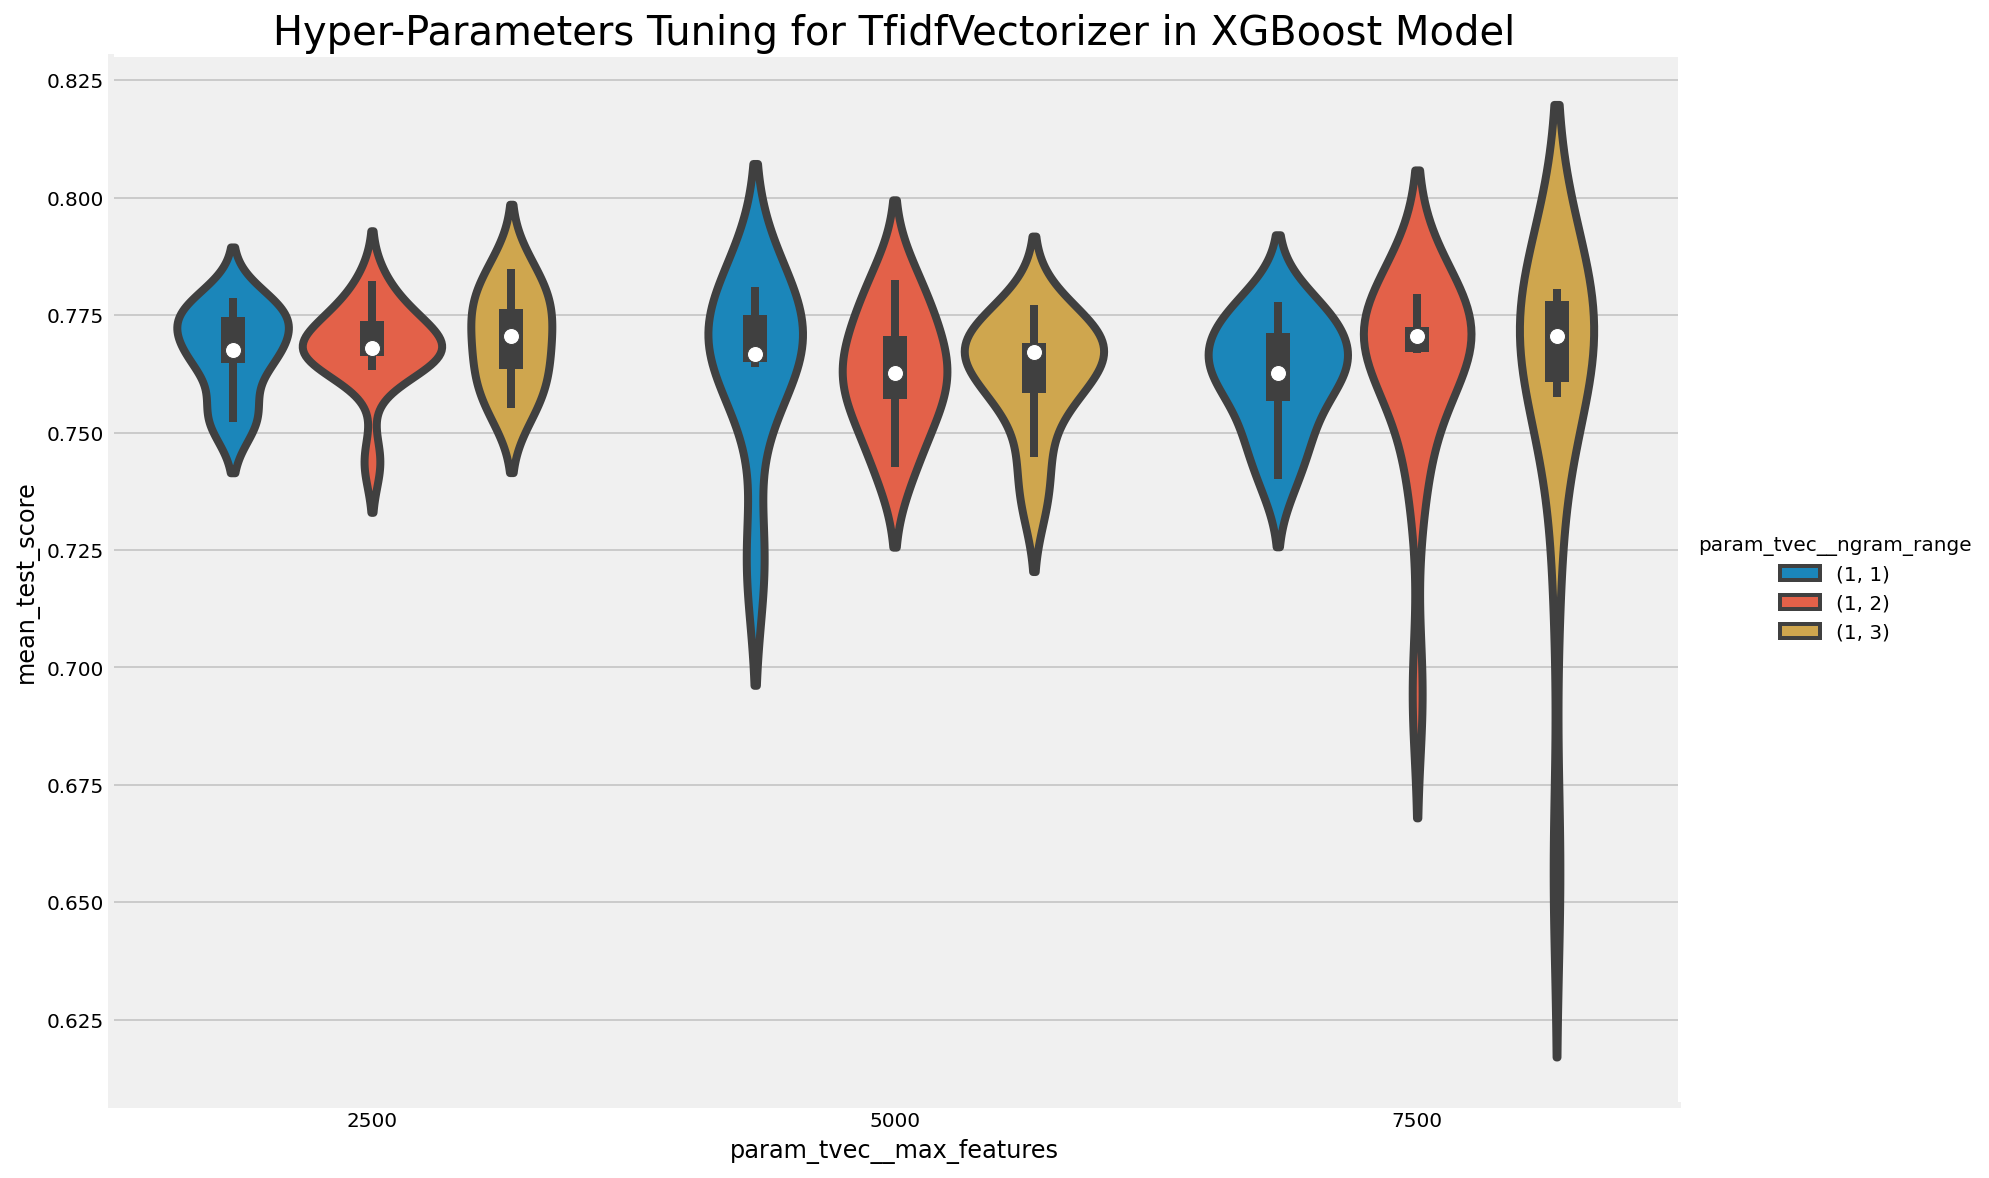

In [13]:
sns.catplot(data=df_rs_xgbT_nlp,
            x='param_tvec__max_features',
            y='mean_test_score',
            hue='param_tvec__ngram_range',
            height=8, aspect=1.5, kind="violin")
plt.gcf()
plt.title("Hyper-Parameters Tuning for TfidfVectorizer in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nlp_tvec.png", transparent=True, bbox_inches='tight')
plt.show()

Chart above plots the two hyper-parameters of our `TfidfVectorizer` in relation to the CV score of our randomised grid search. As our vectorizer's `max_features` increases and our model train on more words, there is a possibility of a better CV score at the cost of greater variance. Otherwise, by observing the mean of the CV scores, there is no indication that less or more `max_features` gives us a better result. For `ngram_range`, no clear pattern can be observed.

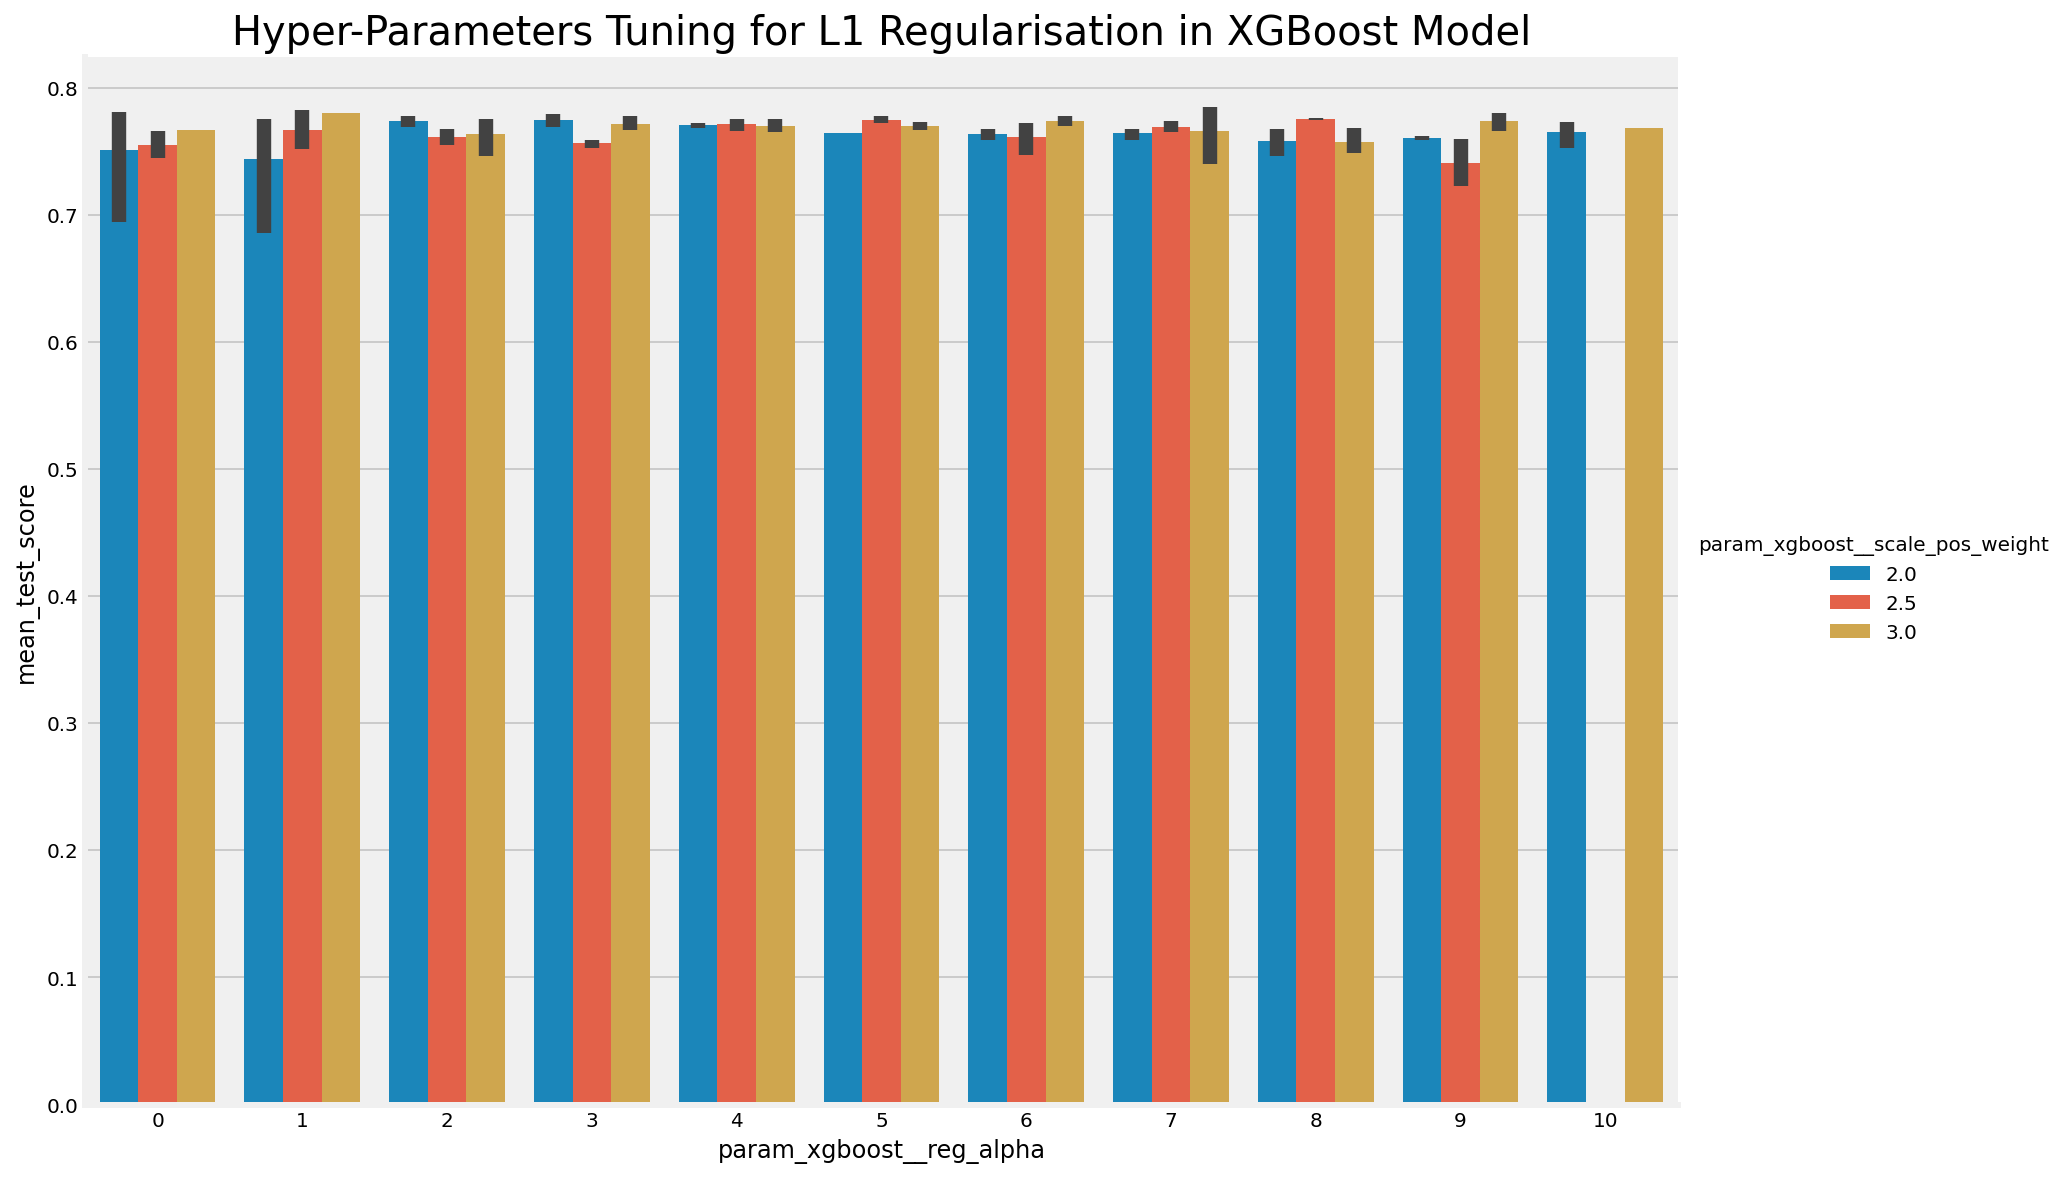

In [14]:
sns.catplot(data=df_rs_xgbT_nlp,
            x='param_xgboost__reg_alpha',
            y='mean_test_score',
            hue='param_xgboost__scale_pos_weight',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning for L1 Regularisation in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nlp_alpha.png", transparent=True, bbox_inches='tight')
plt.show()

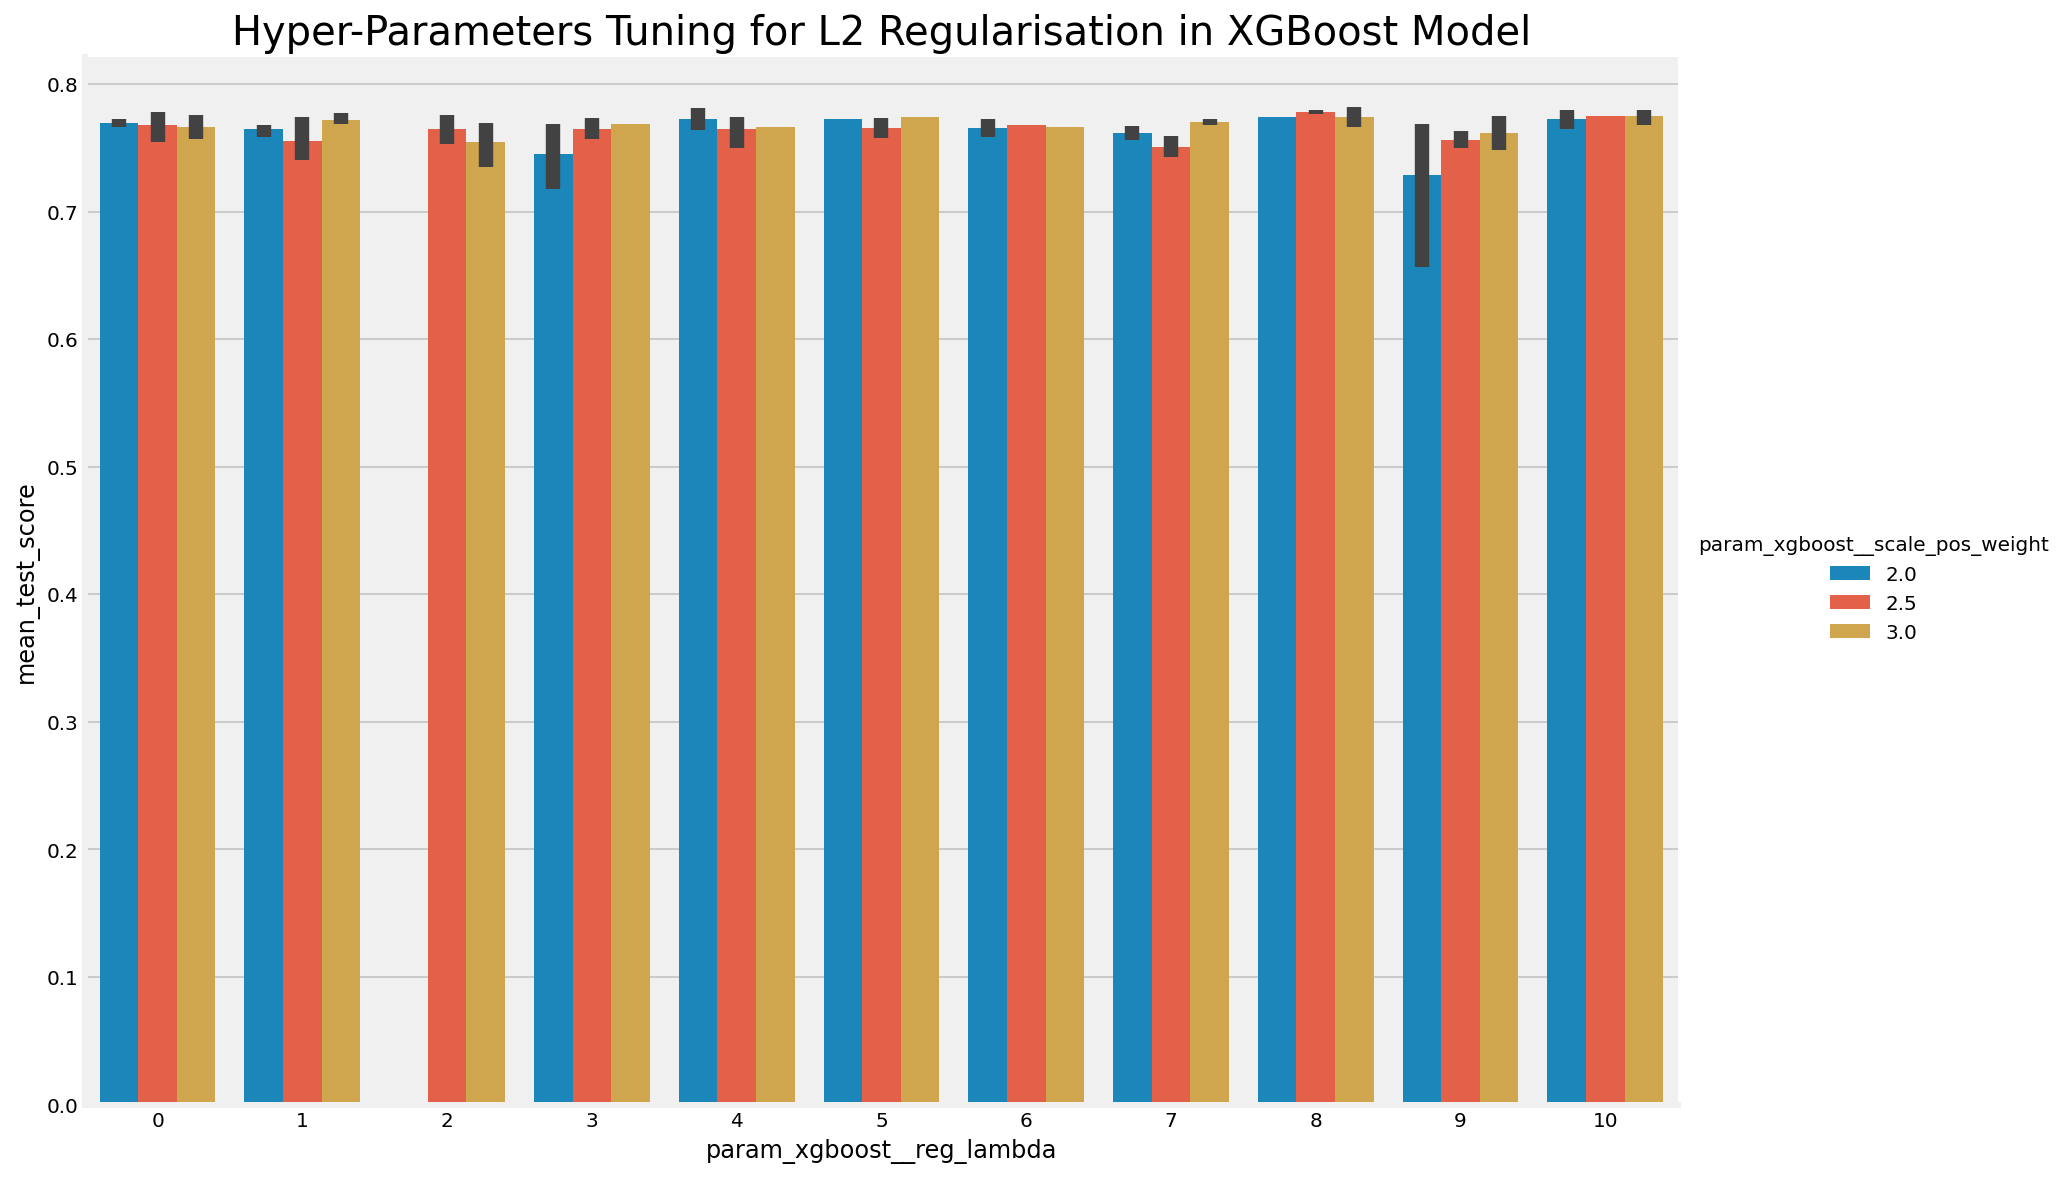

In [15]:
sns.catplot(data=df_rs_xgbT_nlp,
            x='param_xgboost__reg_lambda',
            y='mean_test_score',
            hue='param_xgboost__scale_pos_weight',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning for L2 Regularisation in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nlp_lambda.png", transparent=True, bbox_inches='tight')
plt.show()

No clear trend can observed for both L1 `reg_alpha` and L2 `reg_lambda` regularisation, even when grouped by `scale_pos_weight`.

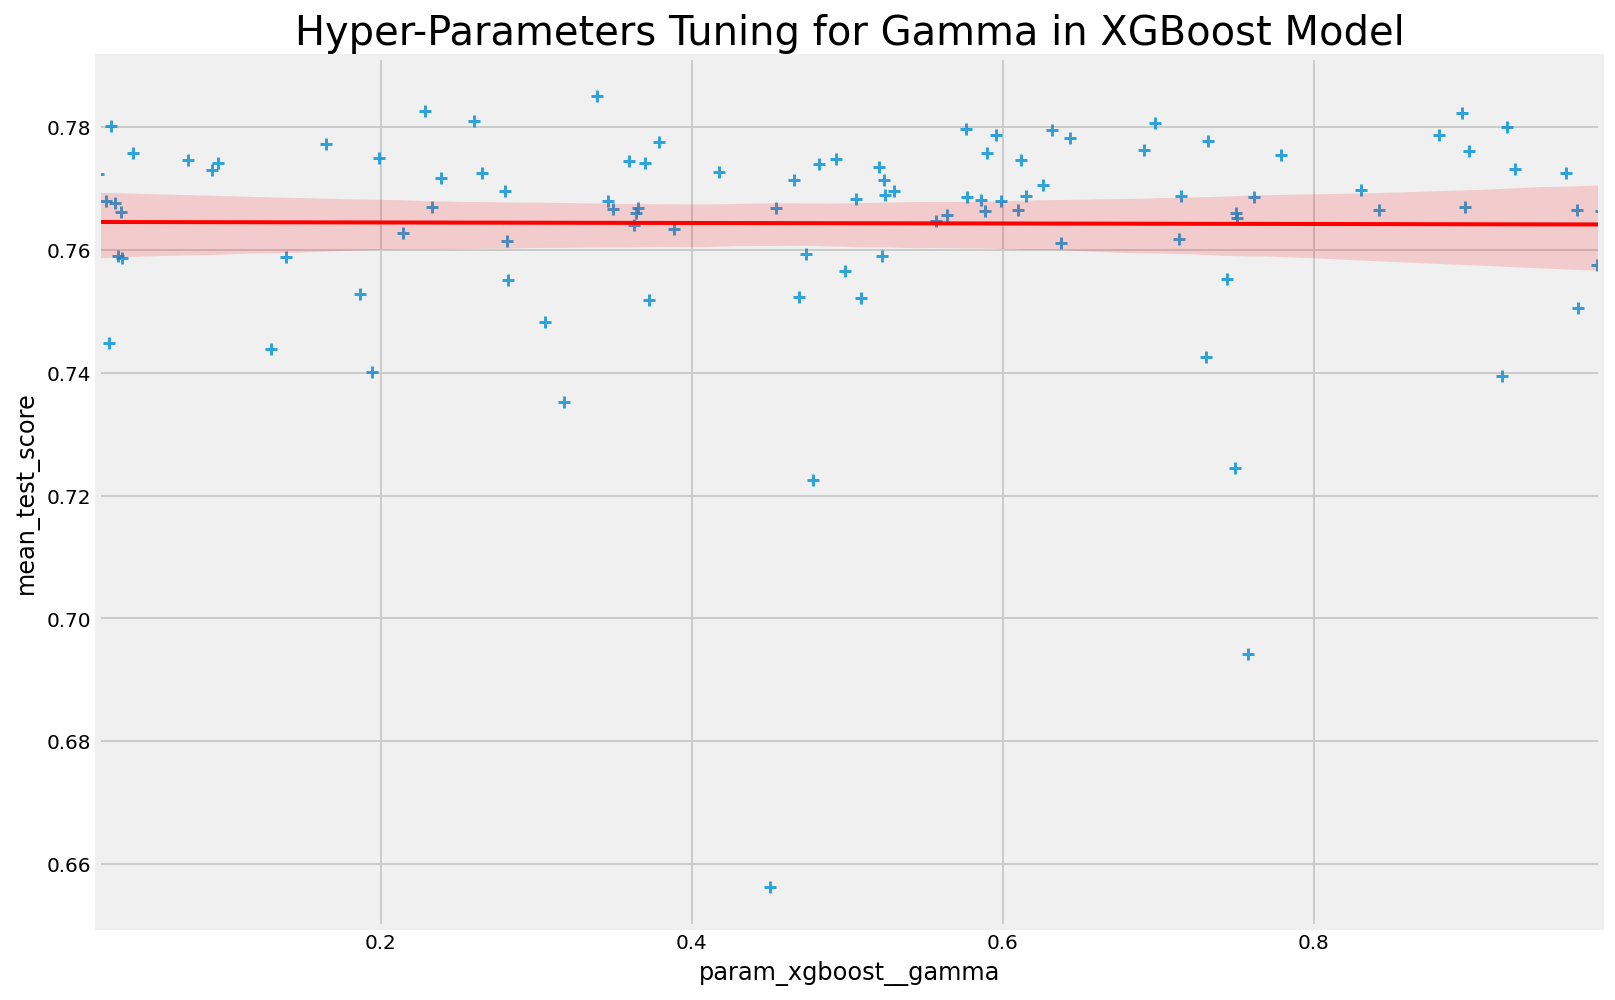

In [16]:
plt.figure(figsize=[12,8])
plt.title("Hyper-Parameters Tuning for Gamma in XGBoost Model", size=20)
sns.regplot(data=df_rs_xgbT_nlp,
            x='param_xgboost__gamma',
            y='mean_test_score',
            marker="+", scatter_kws={"lw": 1.5},
            line_kws={"lw": 2, "color": "r"})
plt.savefig("../assets/hparams_xgbT_nlp_gamma.png", transparent=True, bbox_inches='tight')
plt.show()

For `gamma`, there appears to be overall no effect on CV scores. Researching the hyper-parameter further online suggests that this parameter can be further tuned if needed once all other parameters have been fixed. The parameter `gamma` simply increases the threshold for loss reduction required to make a split, where the default `gamma` is 0. This means that `gamma` can be effective to prune trees that have over-fitted.

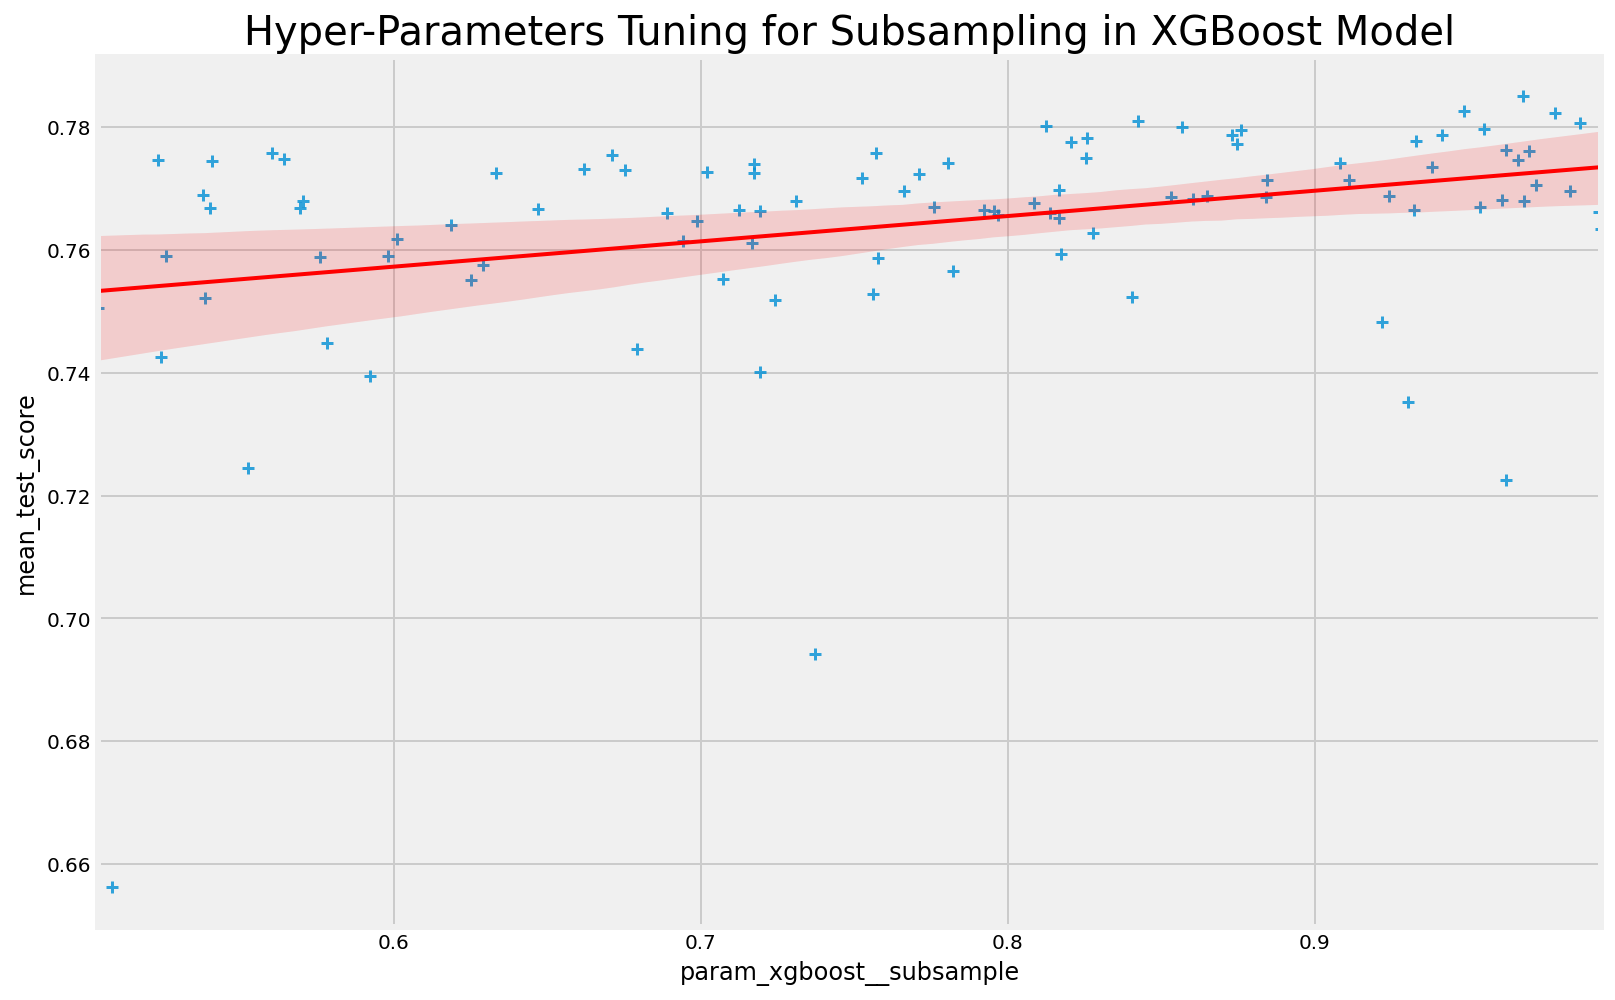

In [17]:
plt.figure(figsize=[12,8])
plt.title("Hyper-Parameters Tuning for Subsampling in XGBoost Model", size=20)
sns.regplot(data=df_rs_xgbT_nlp,
            x='param_xgboost__subsample',
            y='mean_test_score',
            marker="+", scatter_kws={"lw": 1.5},
            line_kws={"lw": 2, "color": "r"})
plt.savefig("../assets/hparams_xgbT_nlp_subsample.png", transparent=True, bbox_inches='tight')
plt.show()

The parameter `subsample` is the parameter most highly correlated with out CV scores. As subsampling size increases, CV score increases. Subsampling is a technique used to tamper the learning of over-fitting models by sampling a random subset of our data points (rows) for each CV model. As our model indicates a positive relationship between `subsample` and `mean_test_score`, this means that our model is currently under-fitting. In this case, we should therefore not bother with subsampling and revert to the default `subsample` of 1 (100% of training set).

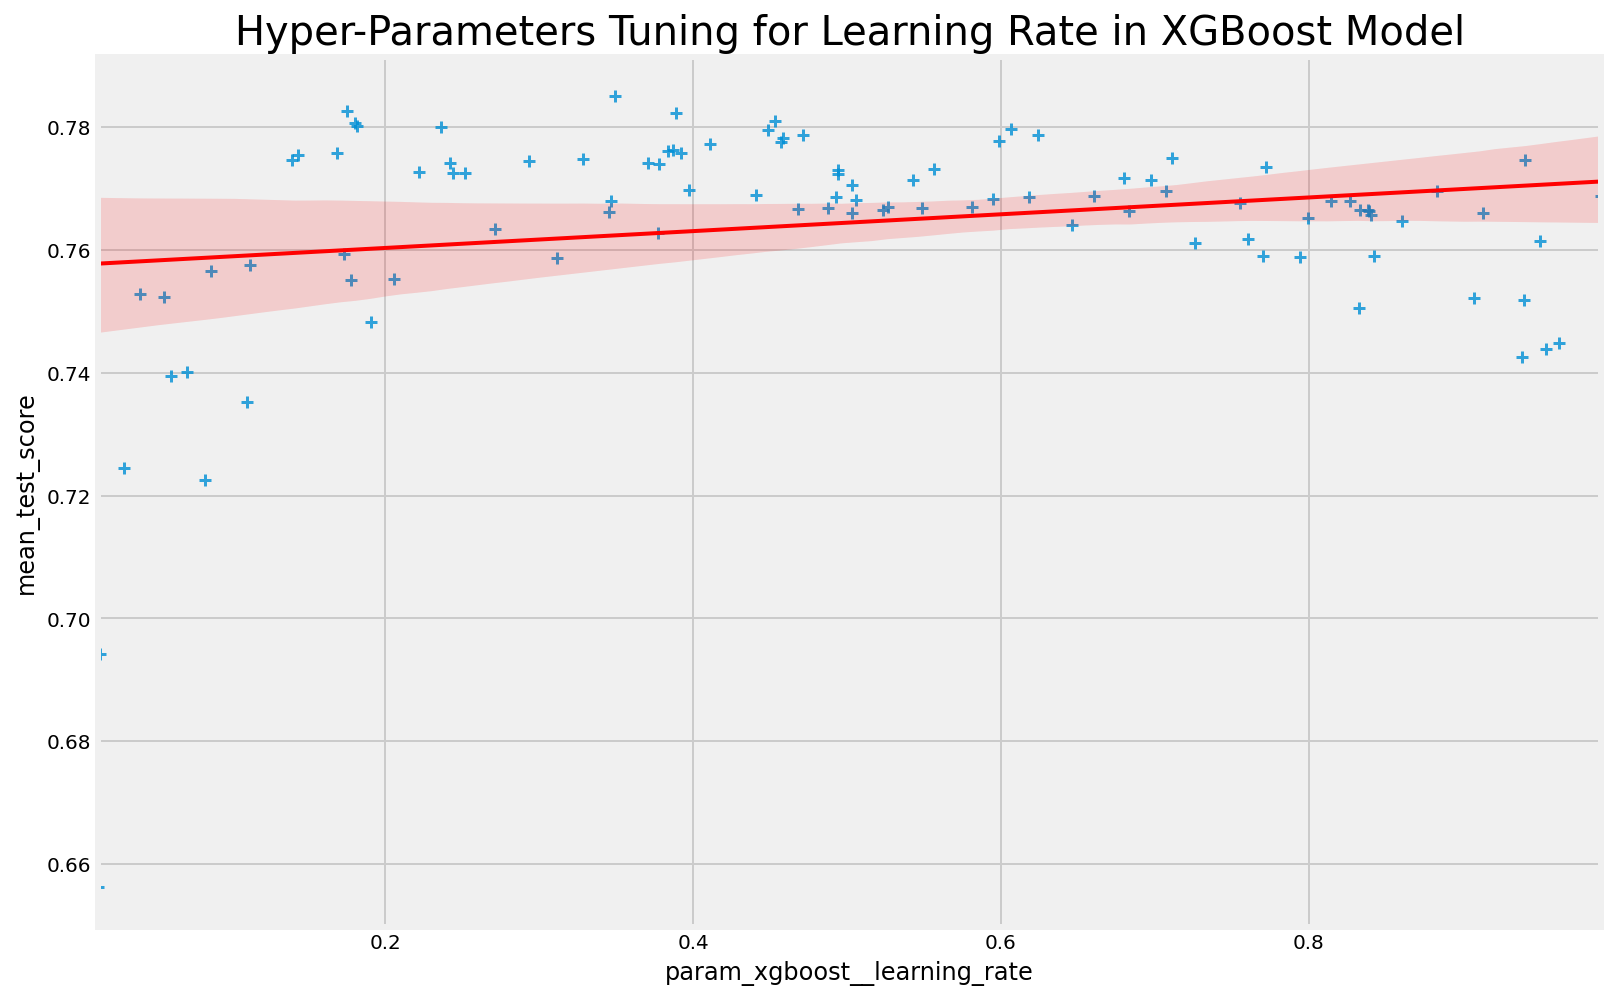

In [18]:
plt.figure(figsize=[12,8])
plt.title("Hyper-Parameters Tuning for Learning Rate in XGBoost Model", size=20)
sns.regplot(data=df_rs_xgbT_nlp,
            x='param_xgboost__learning_rate',
            y='mean_test_score',
            marker="+", scatter_kws={"lw": 1.5},
            line_kws={"lw": 2, "color": "r"})
plt.savefig("../assets/hparams_xgbT_nlp_learning.png", transparent=True, bbox_inches='tight')
plt.show()

The parameter `learning_rate` is another important hyper-parameter according to our heatmap. As learning rate increases, the CV score increases, when the inverse is usually expected when trying to find the minima of the loss function. This suggests that our model has not found the minima of its loss function yet and can afford bigger steps in its gradient descent.

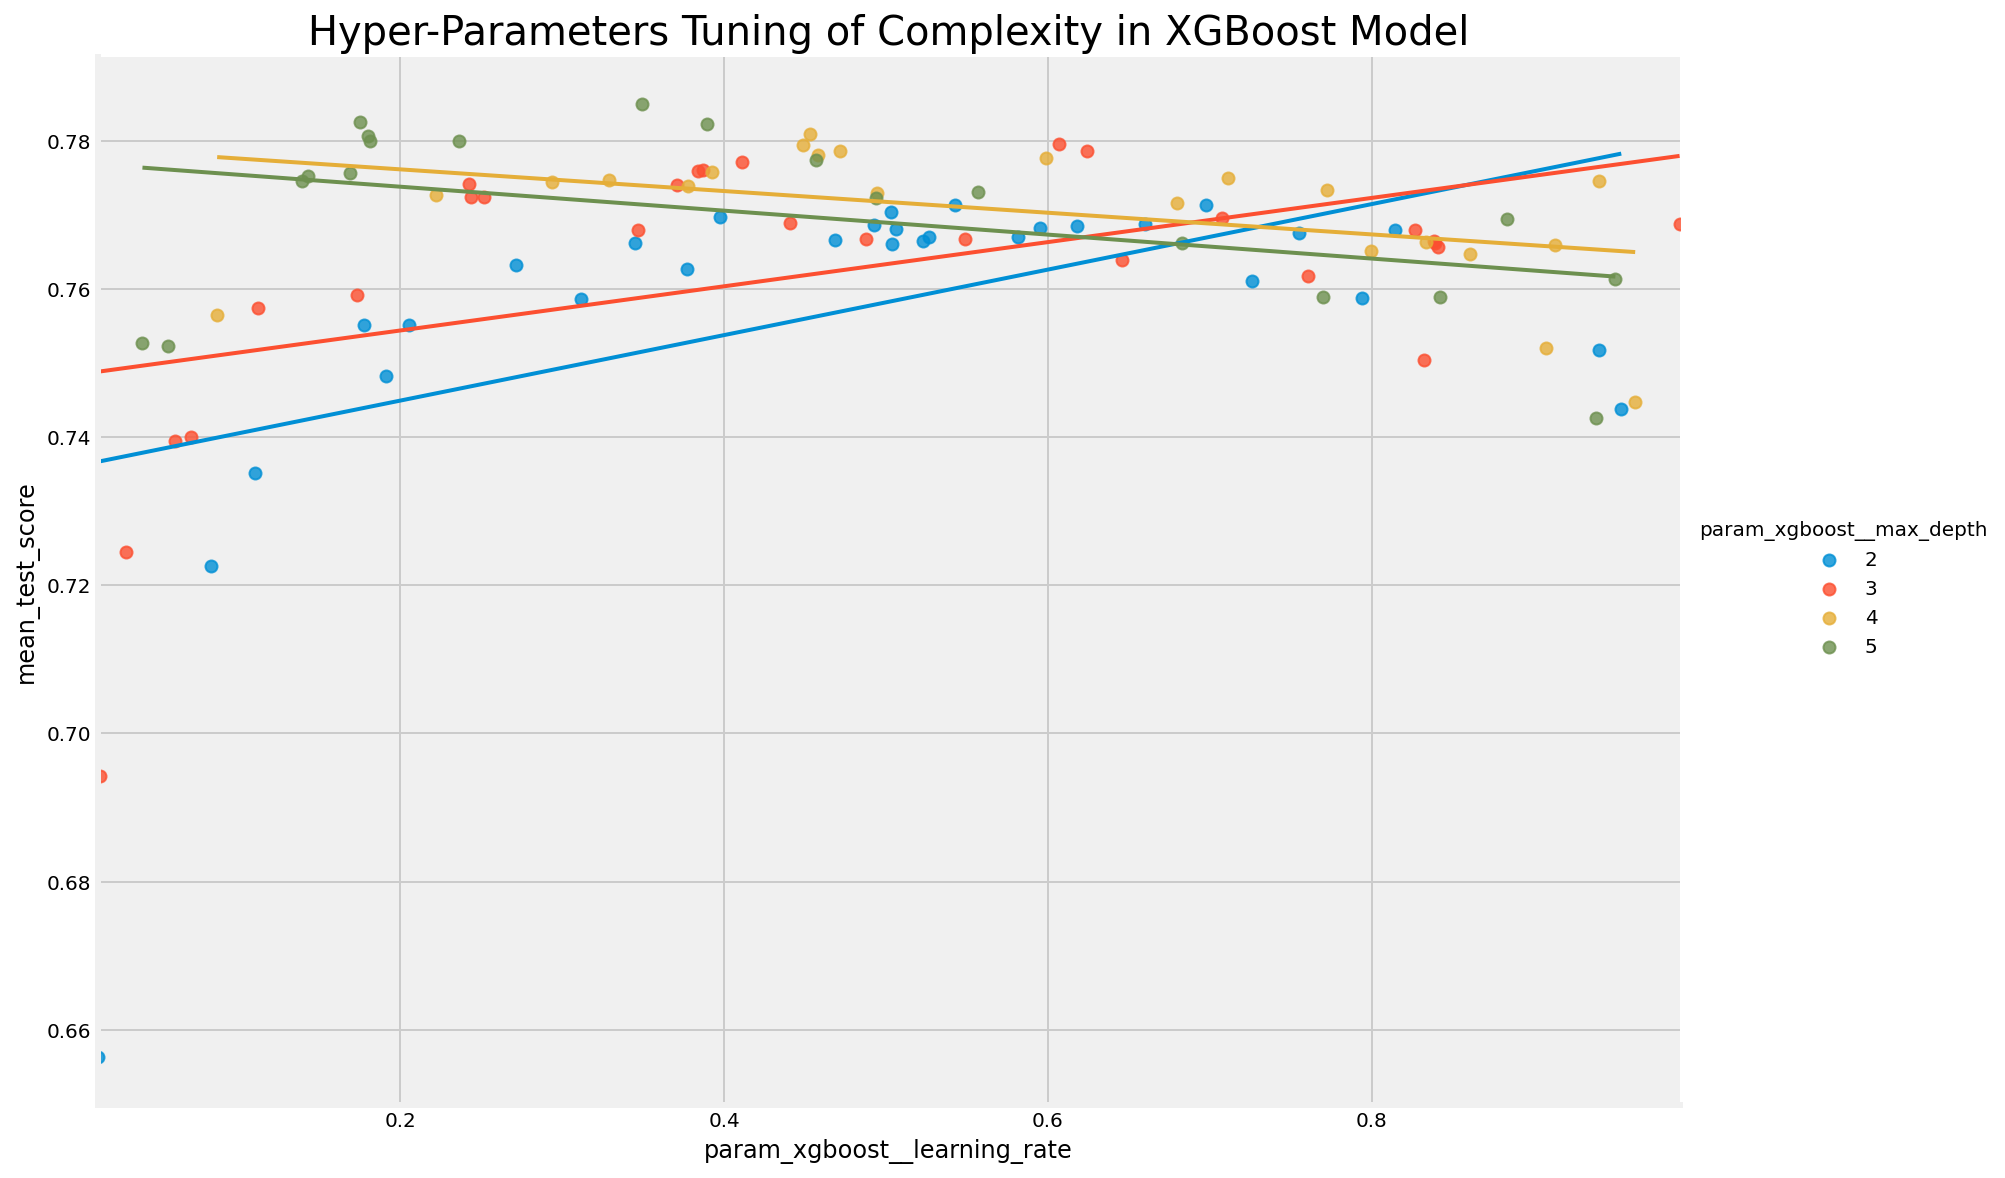

In [19]:
sns.lmplot(data=df_rs_xgbT_nlp,
           x='param_xgboost__learning_rate',
           y='mean_test_score',
           hue='param_xgboost__max_depth', fit_reg=True, ci=None,
           height=8, aspect=1.5, line_kws={"lw": 2})
plt.gcf()
plt.title("Hyper-Parameters Tuning of Complexity in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nlp_complex.png", transparent=True, bbox_inches='tight')
plt.show()

We can tune complexity of our model using both `max_depth` and `learning_rate`. The first allows us to control the size of each tree, the latter controls the size of each gradient descent step towards our loss minima. When we evaluate `learning_rate` against `max_depth`, it appears that bigger and deeper trees when `learning_rate` is small gives us a better CV score and smaller trees give us a better CV score as `learning_rate` increases past just before 0.7.

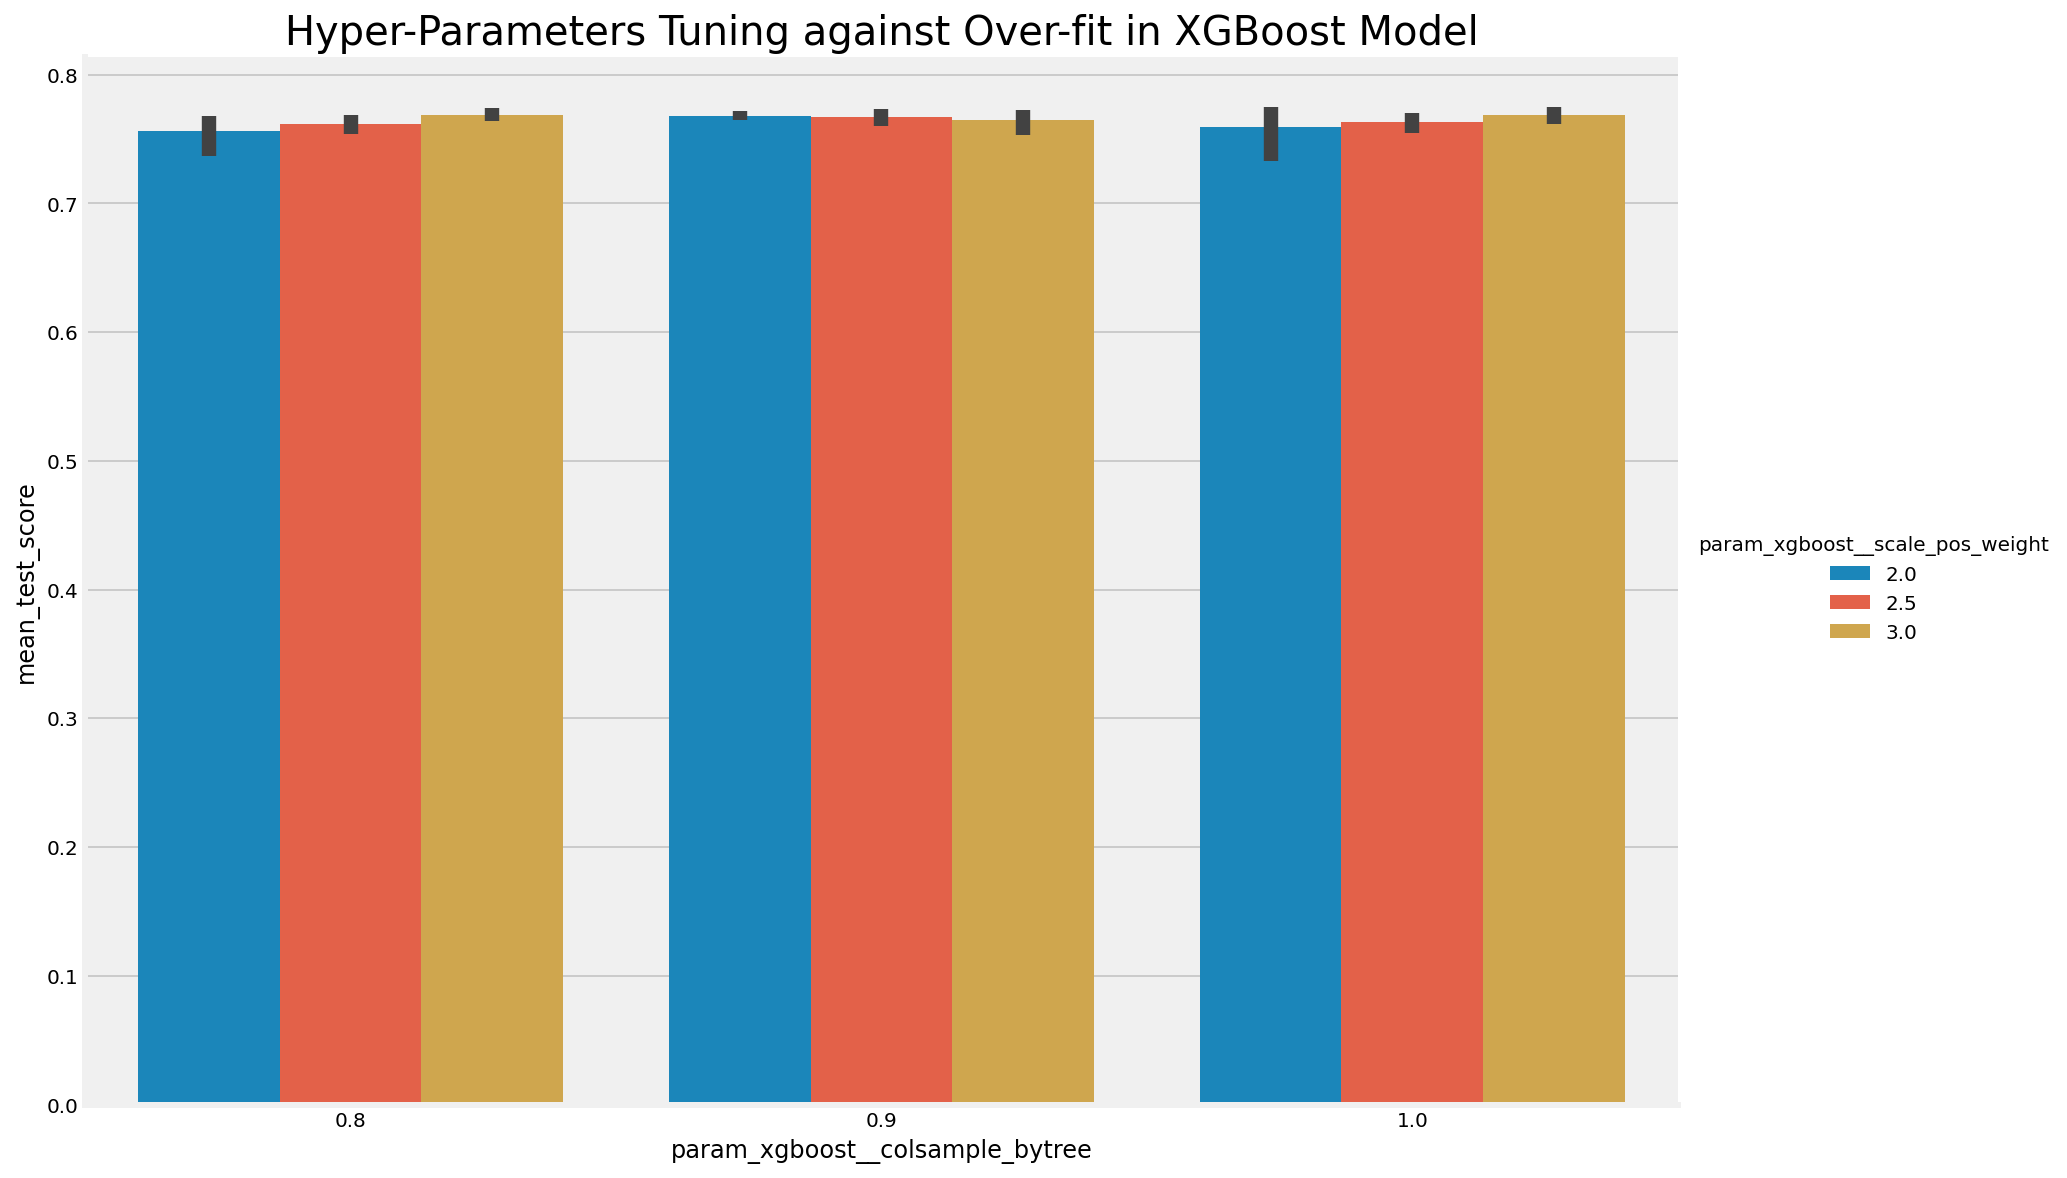

In [21]:
sns.catplot(data=df_rs_xgbT_nlp,
            x='param_xgboost__colsample_bytree',
            y='mean_test_score',
            hue='param_xgboost__scale_pos_weight',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning against Over-fit in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nlp_overfit.png", transparent=True, bbox_inches='tight')
plt.show()

The parameter `colsample_bytree` is the sampling ratio of our columns/features of each CV model. It is the other dimension to subsampling data rows as we have seen in `subsample`. There is no perceptible pattern here.

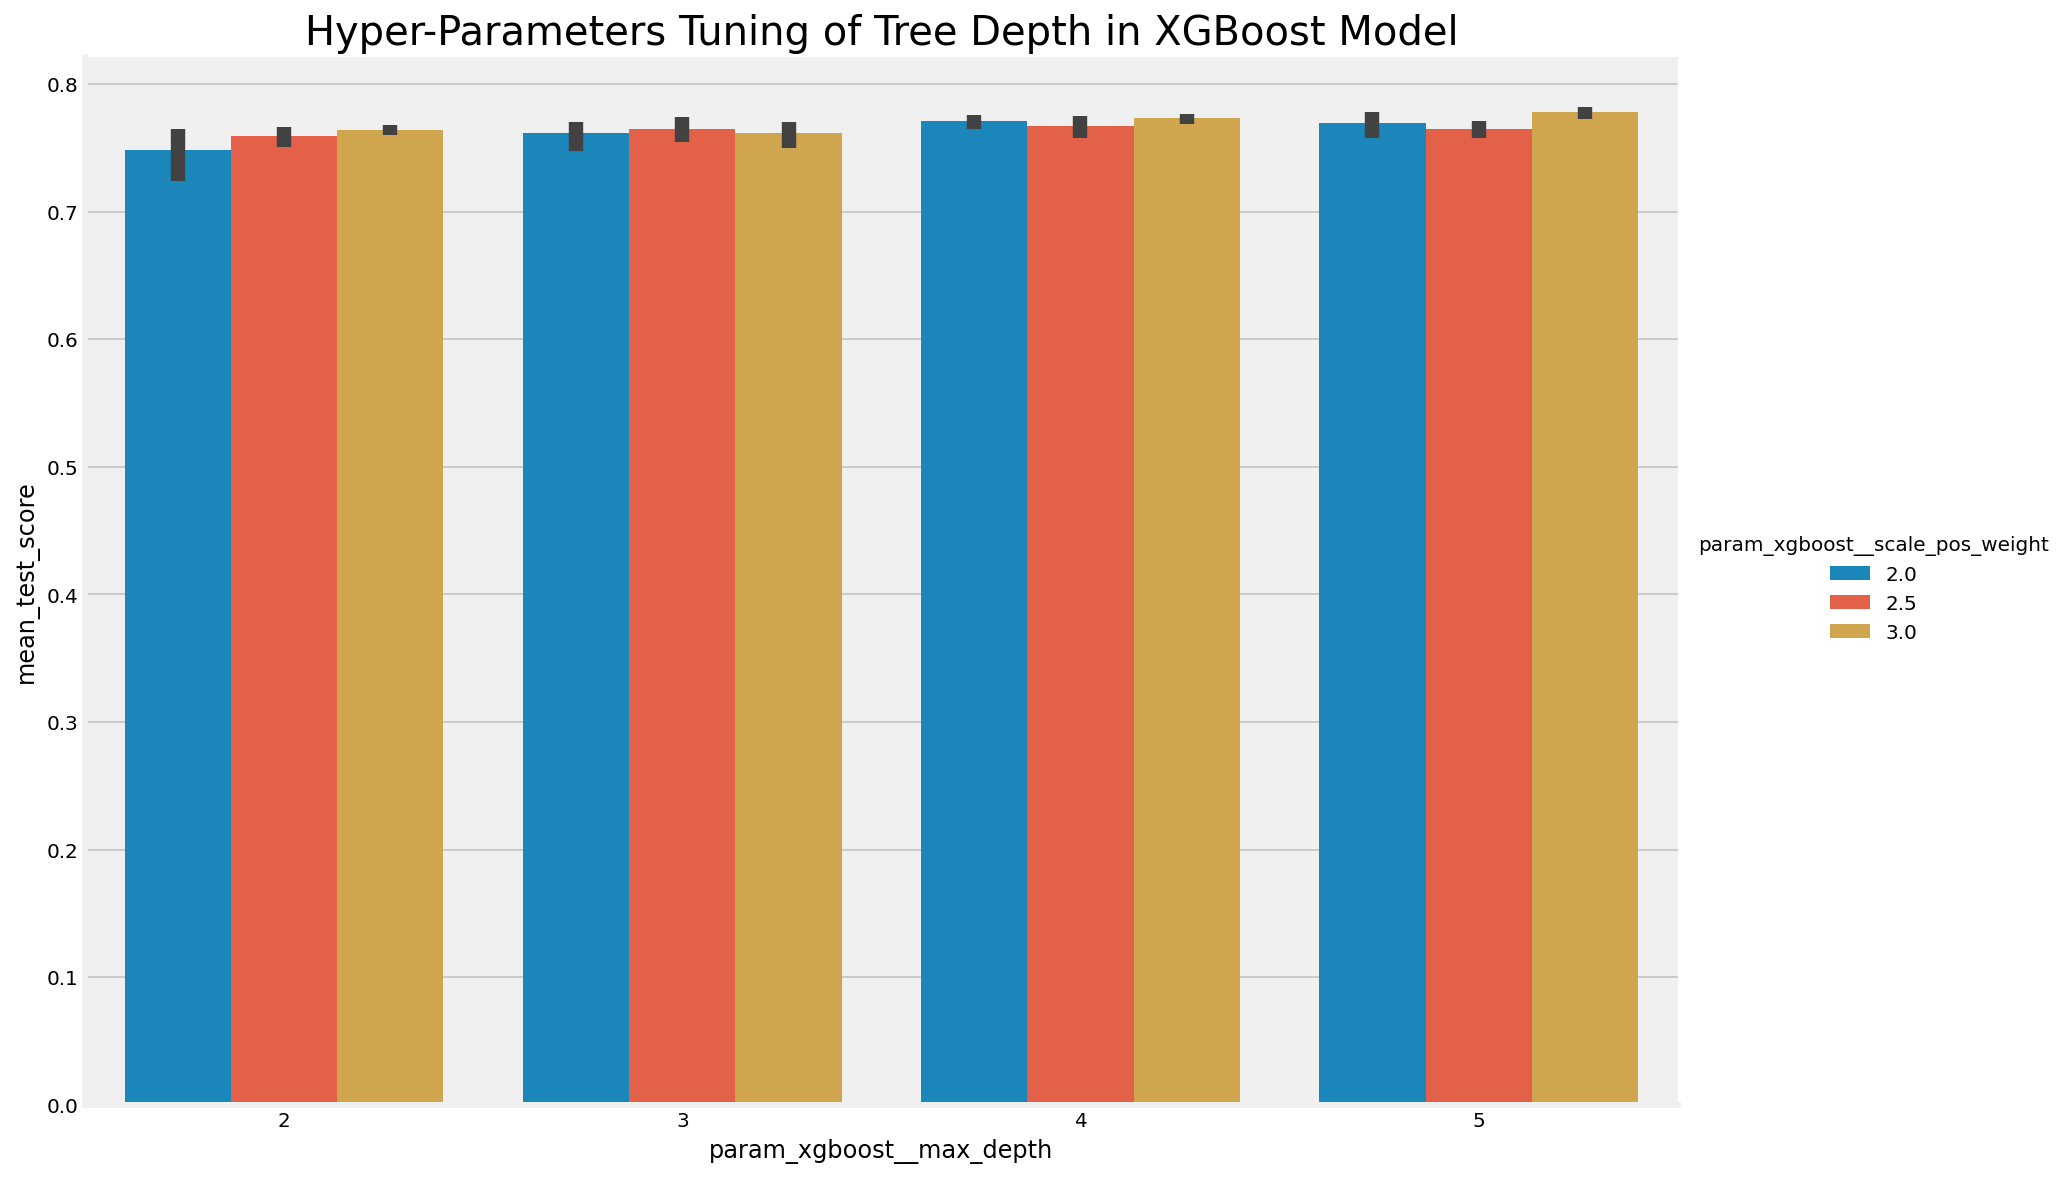

In [22]:
sns.catplot(data=df_rs_xgbT_nlp,
            x='param_xgboost__max_depth',
            y='mean_test_score',
            hue='param_xgboost__scale_pos_weight',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning of Tree Depth in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nlp_depth.png", transparent=True, bbox_inches='tight')
plt.show()

The parameter `max_depth` allows us to control the growth of our trees by limiting the number of levels of branches possible per tree. We can observe a positive trend with a slight increase in the CV scores with every increase of `max_depth`. The bar chart also groups by `scale_pos_weight`, which is a useful parameter to add weight to our minority positive class. We can observe that the heavier weighted positive classes generally allowed for better training and a better CV score.

#### Further Optimisation - XGBoost (Tree)

Best XGBoost Model (Tree) Hyper-Parameters for NLP:
```
{'tvec__max_features': 2500,
 'tvec__ngram_range': (1, 3),
 'xgboost__colsample_bytree': 1,
 'xgboost__gamma': 0.3390297910487007,
 'xgboost__learning_rate': 0.3492095746126609,
 'xgboost__max_depth': 5,
 'xgboost__min_child_weight': 2,
 'xgboost__min_split_loss': 0.05,
 'xgboost__reg_alpha': 7,
 'xgboost__reg_lambda': 0,
 'xgboost__scale_pos_weight': 3,
 'xgboost__subsample': 0.9678174971104738}
 ```

Optimal value for vectorizer parameter `max_features` was found to be at the lower limit of input arguments at 2500. Therefore, we shall test an even lower limit at 1500 to see if the performance improves.

Even though our randomised grid search recommended (1,3) for our `ngram_range`, we are unable to observe from our violin plot any pattern of better scores with a higher `ngram_range`. While there may not be an improvement in CV scores for the different `ngram_range` values, there appears at least to be a pattern of greater variance in score as `ngram_range` increases. Consistent generalisation is desirable too, as such, we shall test out `ngram_range` values for the two extremes - (1,1) and (1,3).

L1 and L2 regularisation through `reg_alpha` and `reg_lambda` respectively found its optimal value within the range of arguments provided during our randomised grid search. As such, we shall take these values as final.

The `gamma` parameter sets the minimum loss threshold for a split, effectively pruning the tree's growth and helping to reduce over-fitting of trees. It is recommended to tune this parameter after all other parameters have been fixed. We shall leave it at its default value of 0 for now.

The optimal value for `scale_pos_weight` was found at the upper limit of input arguments at 3. In a training set whereby there is an imbalance in classes, this is a parameter that incentivises the model to learn more of the minority positive class (popular = 1) by adding weight to the minority value. We shall test a range of arguments greater than 3 to see if the optimal value has been found.

For `learning_rate`, the optimal value was found to be at about 0.35. Even though we fed as input argument for the randomised grid search a uniform distribution of values from 0.0 to 1.0, suggesting that this is likely its optimal value after 100 iterations, our chart suggest a pattern whereby greater learning rate is correlated with an increase in CV scores. As such, we shall test a range of values to see if there is a greater value of `learning_rate` that is optimal.

The parameter `max_depth` was given a range of random integers from 2 to 5 and the upper limit of 5 was chosen as optimal. We shall test arguments greater than 5 to find the optimal value.

Parameter `min_child_weight` was given a range of random integers from 0 to 4 and the optimal value was found to be at 2. We will therefore accept this value as the optimal.

Since the `subsample` optimal value was given to be a value (0.97) very close to 1, and we believe our model to currently be under-fitting from our charts, we shall fix our optimal value at 1 and train each CV model on the full size (rows) of the training set.

Similarly for `colsample_bytree` which samples from the column axis as a technique to reduce over-fitting of model, we shall fix our optimal value at 1 which was also what is recommended by the randomised grid search.

In [89]:
# build pipeline
pipe_xgbT = Pipeline(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                            ("xgboost", xgb.XGBClassifier(booster="gbtree", # "gbtree" is our best performing model for NLP
                                                          objective="binary:logistic"))])

# set hyper params to tune
pipe_params_xgbT = {
    "tvec__max_features": [1500, 2500], # best argm was the lower limit at 2500
    "tvec__ngram_range": [(1,1), (1,3)], # suggest best argm was (1,3) but chart observed no real difference
    "xgboost__reg_alpha": [7],
    "xgboost__reg_lambda": [0],
    "xgboost__gamma": [0],
    "xgboost__scale_pos_weight": [3, 3.5, 4], # best argm was the upper limit at 3
    "xgboost__learning_rate": [0.35, 0.7, 1], # chart suggests increasing learning rate while our best argm was 0.35
    "xgboost__max_depth": [5, 6, 7], # best argm was the upper limit at 5
    "xgboost__min_child_weight": [2],
    "xgboost__subsample": [1],
    "xgboost__colsample_bytree": [1]
}

In [90]:
%%time
np.random.seed(42)
gs_xgbT_nlp = GridSearchCV(estimator=pipe_xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="roc_auc")
gs_xgbT_nlp.fit(X_nlp_train, y_train)
print("Best score in Grid Search:", gs_xgbT_nlp.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nlp.best_params_

Best score in Randomised Search: 0.7876913978584293

Using the following hyper-parameters:
Wall time: 54min 28s


{'tvec__max_features': 2500,
 'tvec__ngram_range': (1, 1),
 'xgboost__colsample_bytree': 1,
 'xgboost__gamma': 0,
 'xgboost__learning_rate': 0.35,
 'xgboost__max_depth': 7,
 'xgboost__min_child_weight': 2,
 'xgboost__reg_alpha': 7,
 'xgboost__reg_lambda': 0,
 'xgboost__scale_pos_weight': 3.5,
 'xgboost__subsample': 1}

Our CV score has improved! We have also found our optimal values for most of our hyper-parameters as they fall within the range of arguments tested thus far. The only exception is `max_depth` for which the optimal value was found at the upper limit 7 of its input arguments. We shall run another grid search to find the optimal value for `max_depth` by testing values greater than 7.

In [108]:
# build pipeline
pipe_xgbT = Pipeline(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                            ("xgboost", xgb.XGBClassifier(booster="gbtree", # "gbtree" is our best performing model for NLP
                                                          objective="binary:logistic"))])

# set hyper params to tune
pipe_params_xgbT = {
    "tvec__max_features": [2500],
    "tvec__ngram_range": [(1,1)],
    "xgboost__reg_alpha": [7],
    "xgboost__reg_lambda": [0],
    "xgboost__gamma": [0],
    "xgboost__scale_pos_weight": [3.5],
    "xgboost__learning_rate": [0.35],
    "xgboost__max_depth": [7, 8, 9, 10], # best param was our highest limit at 7
    "xgboost__min_child_weight": [2],
    "xgboost__subsample": [1],
    "xgboost__colsample_bytree": [1]
}

In [141]:
%%time
np.random.seed(42)
gs_xgbT_nlp = GridSearchCV(estimator=pipe_xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="roc_auc")
gs_xgbT_nlp.fit(X_nlp_train, y_train)
print("Best score in Grid Search:", gs_xgbT_nlp.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nlp.best_params_

Best score in Randomised Search: 0.7876913978584293

Using the following hyper-parameters:
Wall time: 1min 38s


{'tvec__max_features': 2500,
 'tvec__ngram_range': (1, 1),
 'xgboost__colsample_bytree': 1,
 'xgboost__gamma': 0,
 'xgboost__learning_rate': 0.35,
 'xgboost__max_depth': 7,
 'xgboost__min_child_weight': 2,
 'xgboost__reg_alpha': 7,
 'xgboost__reg_lambda': 0,
 'xgboost__scale_pos_weight': 3.5,
 'xgboost__subsample': 1}

The optimal value for `max_depth` did not change when tested against a range of arguments. We have therefore found our optimal hyper-parameters. As mentioned, we will tune `gamma` once we have fixed our other hyper-parameters. Let's see if tuning our `gamma` parameter gives us any improvement.

In [144]:
# build pipeline
pipe_xgbT = Pipeline(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                            ("xgboost", xgb.XGBClassifier(booster="gbtree", # "gbtree" is our best performing model for NLP
                                                          objective="binary:logistic"))])

# set hyper params to tune
pipe_params_xgbT = {
    "tvec__max_features": [2500],
    "tvec__ngram_range": [(1,1)],
    "xgboost__reg_alpha": [7],
    "xgboost__reg_lambda": [0],
    "xgboost__gamma": [0, 0.05, 0.1, 0.2, 0.4, 0.8], # gamma ranges from 0 to 1
    "xgboost__scale_pos_weight": [3.5],
    "xgboost__learning_rate": [0.35],
    "xgboost__max_depth": [7],
    "xgboost__min_child_weight": [2],
    "xgboost__subsample": [1],
    "xgboost__colsample_bytree": [1]
}

In [145]:
%%time
np.random.seed(42)
gs_xgbT_nlp = GridSearchCV(estimator=pipe_xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="roc_auc")
gs_xgbT_nlp.fit(X_nlp_train, y_train)
print("Best score in Grid Search:", gs_xgbT_nlp.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nlp.best_params_

Best score in Randomised Search: 0.788413621695393

Using the following hyper-parameters:
Wall time: 2min 49s


{'tvec__max_features': 2500,
 'tvec__ngram_range': (1, 1),
 'xgboost__colsample_bytree': 1,
 'xgboost__gamma': 0.05,
 'xgboost__learning_rate': 0.35,
 'xgboost__max_depth': 7,
 'xgboost__min_child_weight': 2,
 'xgboost__reg_alpha': 7,
 'xgboost__reg_lambda': 0,
 'xgboost__scale_pos_weight': 3.5,
 'xgboost__subsample': 1}

There is a further improvement in our CV score. It seems `gamma` value wants to be small at about 0.05 but not at its default of 0. Let's see if we can get a better `gamma` value using `RandomizedSearchCV` to feed in a distribution of `gamma` values to test out.

In [146]:
# build pipeline
pipe_xgbT = Pipeline(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                            ("xgboost", xgb.XGBClassifier(booster="gbtree", # "gbtree" is our best performing model for NLP
                                                          objective="binary:logistic"))])

# set hyper params to tune
pipe_params_xgbT = {
    "tvec__max_features": [2500],
    "tvec__ngram_range": [(1,1)],
    "xgboost__reg_alpha": [7],
    "xgboost__reg_lambda": [0],
    "xgboost__gamma": truncnorm(a=0, b=1, loc=0.05, scale=0.1), # skewed pdf with mean at 0.05
    "xgboost__scale_pos_weight": [3.5],
    "xgboost__learning_rate": [0.35],
    "xgboost__max_depth": [7],
    "xgboost__min_child_weight": [2],
    "xgboost__subsample": [1],
    "xgboost__colsample_bytree": [1]
}

In [147]:
%%time
np.random.seed(42)
gs_xgbT_nlp = RandomizedSearchCV(estimator=pipe_xgbT, param_distributions=pipe_params_xgbT, cv=4, n_iter=50, scoring="roc_auc")
gs_xgbT_nlp.fit(X_nlp_train, y_train)
print("Best score in Randomised Search:", gs_xgbT_nlp.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nlp.best_params_

Best score in Randomised Search: 0.7899181115163713

Using the following hyper-parameters:
Wall time: 23min 18s


{'tvec__max_features': 2500,
 'tvec__ngram_range': (1, 1),
 'xgboost__colsample_bytree': 1,
 'xgboost__gamma': 0.054971823085072924,
 'xgboost__learning_rate': 0.35,
 'xgboost__max_depth': 7,
 'xgboost__min_child_weight': 2,
 'xgboost__reg_alpha': 7,
 'xgboost__reg_lambda': 0,
 'xgboost__scale_pos_weight': 3.5,
 'xgboost__subsample': 1}

By tweaking our `gamma` value, we have another marginal improvement in our CV score. We shall fix our `gamma` value at 0.055 for the final NLP model. We have now tuned our hyper-parameters for our NLP model.

### Tune non-NLP Model

#### Random Forest

In [27]:
# instantiate RF model
rf = RandomForestClassifier()

# set hyper params to tune
pipe_params_rf = {
    "n_estimators": [100, 150, 200],
    "max_depth": randint(2, 6),
    "min_samples_split": randint(2, 6),
    "min_samples_leaf": randint(2, 5),
    "max_features": ["auto", "sqrt"],
    "bootstrap": [True, False],
    "max_samples": [0.8, 0.9, 1]
}

In [28]:
%%time
np.random.seed(42)
rs_rf_nnlp = RandomizedSearchCV(estimator=rf, param_distributions=pipe_params_rf, n_iter=200, cv=4)
rs_rf_nnlp.fit(X_nnlp_train_dumm, y_train)
print("Best score in Randomised Search:", rs_rf_nnlp.best_score_)
print()
print("Using the following hyper-parameters:")
rs_rf_nnlp.best_params_

Best score in Randomised Search: 0.718227253851364

Using the following hyper-parameters:
Wall time: 19min 38s


{'bootstrap': False,
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_samples': 0.9,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 100}

#### XGBoost (Linear)

In [22]:
# instantiate XGB model
xgbL = xgb.XGBClassifier(booster="gblinear", objective="binary:logistic")

# set hyper params to tune
pipe_params_xgbL = {
    "reg_alpha": randint(0, 11),
    "reg_lambda": randint(0, 11),
    "feature_selector": ["cyclic", "shuffle"]
}

In [23]:
%%time
np.random.seed(42)
rs_xgbL_nnlp = RandomizedSearchCV(estimator=xgbL, param_distributions=pipe_params_xgbL, n_iter=100, cv=4, scoring="roc_auc")
rs_xgbL_nnlp.fit(X_nnlp_train_dumm, y_train)
print("Best score in Randomised Search:", rs_xgbL_nnlp.best_score_)
print()
print("Using the following hyper-parameters:")
rs_xgbL_nnlp.best_params_

Best score in Randomised Search: 0.6563385652672051

Using the following hyper-parameters:
Wall time: 3min


{'feature_selector': 'shuffle', 'reg_alpha': 0, 'reg_lambda': 0}

#### XGBoost (Tree)

In [24]:
# instantiate XGB model
xgbT = xgb.XGBClassifier(booster="gbtree", objective="binary:logistic")

# set hyper params to tune
pipe_params_xgbT = {
    "reg_alpha": randint(0, 11),
    "reg_lambda": randint(0, 11),
    "gamma": uniform(0, 1),
    "scale_pos_weight": [2, 2.5, 3], # xgb doc recommends sum(neg)/sum(pos) = 12_793/5257
    "learning_rate": uniform(0, 1),
    "min_split_loss": [0, 0.05, 0.1],
    "max_depth": randint(2, 6),
    "min_child_weight": randint(0, 5),
    "subsample": uniform(0.5, 0.5),
    "colsample_bytree": [0.8, 0.9, 1]
}

In [26]:
%%time
np.random.seed(42)
rs_xgbT_nnlp = RandomizedSearchCV(estimator=xgbT, param_distributions=pipe_params_xgbT, n_iter=100, cv=4, scoring="roc_auc")
rs_xgbT_nnlp.fit(X_nnlp_train_dumm, y_train)
print("Best score in Randomised Search:", rs_xgbT_nnlp.best_score_)
print()
print("Using the following hyper-parameters:")
rs_xgbT_nnlp.best_params_

Best score in Randomised Search: 0.728859745935055

Using the following hyper-parameters:
Wall time: 11min 40s


{'colsample_bytree': 1,
 'gamma': 0.16829104217293056,
 'learning_rate': 0.21876421957307024,
 'max_depth': 5,
 'min_child_weight': 0,
 'min_split_loss': 0,
 'reg_alpha': 0,
 'reg_lambda': 9,
 'scale_pos_weight': 2.5,
 'subsample': 0.8481521364198942}

#### Best non-NLP Model - XGBoost (Tree)

Since our tree-based XGBoost model gave us our best cross-validated ROC-AUC score, let us evaluate the hyper-parameters for this model.

In [111]:
df_rs_xgbT_nnlp = pd.DataFrame(rs_xgbT_nnlp.cv_results_)
df_rs_xgbT_nnlp.to_csv("../datasets/df_rs_xgbT_nnlp.csv", index=False) # save out df of randomized search
df_rs_xgbT_nnlp.info() # notice certain cols that are numeric are not numeric

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mean_fit_time           100 non-null    float64
 1   std_fit_time            100 non-null    float64
 2   mean_score_time         100 non-null    float64
 3   std_score_time          100 non-null    float64
 4   param_colsample_bytree  100 non-null    object 
 5   param_gamma             100 non-null    object 
 6   param_learning_rate     100 non-null    object 
 7   param_max_depth         100 non-null    object 
 8   param_min_child_weight  100 non-null    object 
 9   param_min_split_loss    100 non-null    object 
 10  param_reg_alpha         100 non-null    object 
 11  param_reg_lambda        100 non-null    object 
 12  param_scale_pos_weight  100 non-null    object 
 13  param_subsample         100 non-null    object 
 14  params                  100 non-null    obj

In [114]:
# re-import df
df_rs_xgbT_nnlp = pd.read_csv("../datasets/df_rs_xgbT_nnlp.csv")
df_rs_xgbT_nnlp.head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       2.414658      0.056329         0.044760        0.003472   
1       2.462204      0.122462         0.052667        0.003087   
2       1.228067      0.035425         0.033201        0.008945   

   param_colsample_bytree  param_gamma  param_learning_rate  param_max_depth  \
0                     1.0     0.796543             0.183435                5   
1                     1.0     0.866176             0.601115                5   
2                     0.8     0.617482             0.611653                2   

   param_min_child_weight  param_min_split_loss  ...  param_scale_pos_weight  \
0                       4                  0.00  ...                     3.0   
1                       2                  0.05  ...                     2.5   
2                       3                  0.00  ...                     3.0   

   param_subsample                                             params  \
0         0.549987  {'colsample_bytree': 1, 'gamma': 0.79654298686...   
1         0.606170  {'colsample_bytree': 1, 'gamma': 0.86617614577...   
2         0.699930  {'colsample_bytree': 0.8, 'gamma': 0.617481509...   

   split0_test_score split1_test_score  split2_test_score  split3_test_score  \
0           0.714816          0.736320           0.729067           0.719817   
1           0.701677          0.711369           0.710359           0.713585   
2           0.697719          0.720185           0.706420           0.704204   

   mean_test_score  std_test_score  rank_test_score  
0         0.725005        0.008296                6  
1         0.709248        0.004524               72  
2         0.707132        0.008186               82  

[3 rows x 22 columns]

In [117]:
# convert all cols that can be numeric into numeric dtypes
df_rs_xgbT_nnlp["param_colsample_bytree"] = df_rs_xgbT_nnlp["param_colsample_bytree"].astype(float)
df_rs_xgbT_nnlp["param_gamma"] = df_rs_xgbT_nnlp["param_gamma"].astype(float)
df_rs_xgbT_nnlp["param_learning_rate"] = df_rs_xgbT_nnlp["param_learning_rate"].astype(float)
df_rs_xgbT_nnlp["param_max_depth"] = df_rs_xgbT_nnlp["param_max_depth"].astype(int)
df_rs_xgbT_nnlp["param_min_child_weight"] = df_rs_xgbT_nnlp["param_min_child_weight"].astype(int)
df_rs_xgbT_nnlp["param_min_split_loss"] = df_rs_xgbT_nnlp["param_min_split_loss"].astype(float)
df_rs_xgbT_nnlp["param_reg_alpha"] = df_rs_xgbT_nnlp["param_reg_alpha"].astype(int)
df_rs_xgbT_nnlp["param_reg_lambda"] = df_rs_xgbT_nnlp["param_reg_lambda"].astype(int)
df_rs_xgbT_nnlp["param_scale_pos_weight"] = df_rs_xgbT_nnlp["param_scale_pos_weight"].astype(float)
df_rs_xgbT_nnlp["param_subsample"] = df_rs_xgbT_nnlp["param_subsample"].astype(float)
df_rs_xgbT_nnlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mean_fit_time           100 non-null    float64
 1   std_fit_time            100 non-null    float64
 2   mean_score_time         100 non-null    float64
 3   std_score_time          100 non-null    float64
 4   param_colsample_bytree  100 non-null    float64
 5   param_gamma             100 non-null    float64
 6   param_learning_rate     100 non-null    float64
 7   param_max_depth         100 non-null    int32  
 8   param_min_child_weight  100 non-null    int32  
 9   param_min_split_loss    100 non-null    float64
 10  param_reg_alpha         100 non-null    int32  
 11  param_reg_lambda        100 non-null    int32  
 12  param_scale_pos_weight  100 non-null    float64
 13  param_subsample         100 non-null    float64
 14  params                  100 non-null    obj

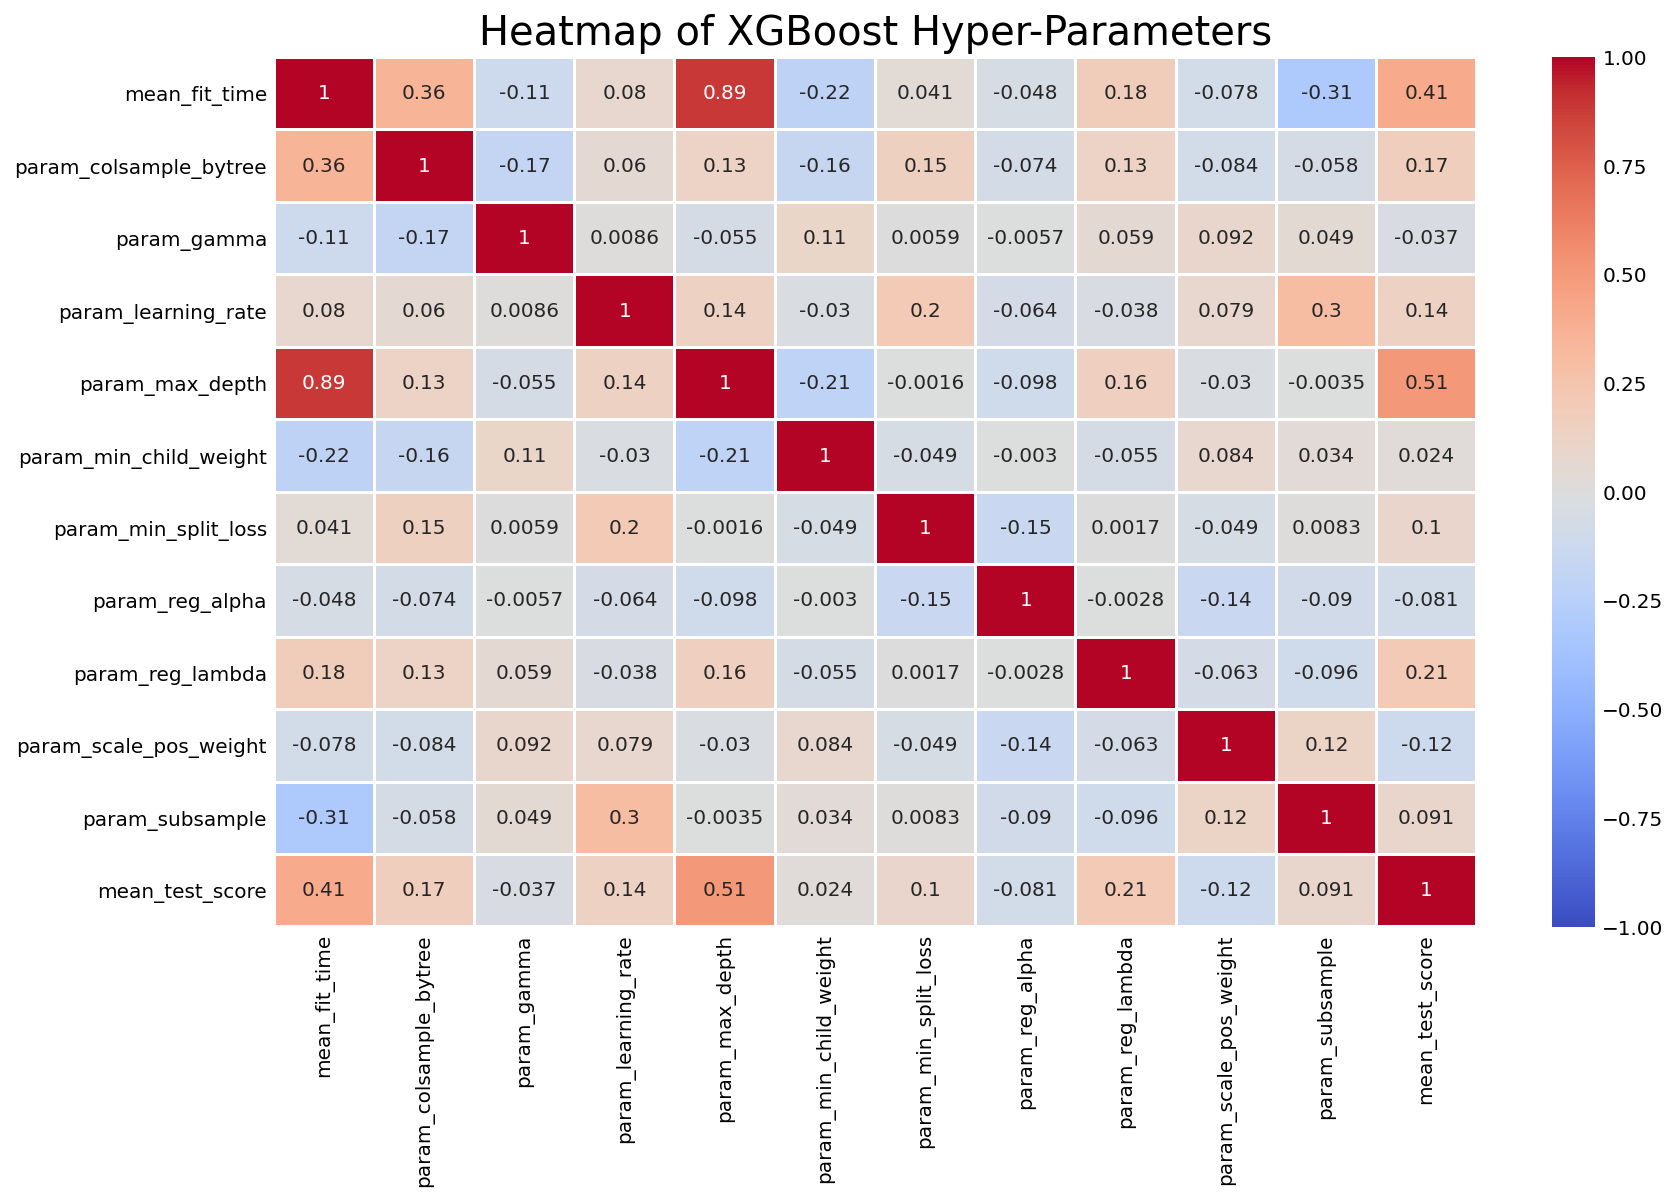

In [119]:
plt.figure(figsize=[12,8])
plt.title("Heatmap of XGBoost Hyper-Parameters", size=20)
include = ["mean_fit_time", "param_colsample_bytree", "param_gamma", "param_learning_rate", "param_max_depth",
           "param_min_child_weight", "param_min_split_loss", "param_reg_alpha", "param_reg_lambda",
           "param_scale_pos_weight", "param_subsample", "mean_test_score"]
sns.heatmap(df_rs_xgbT_nnlp[include].corr(), annot=True, linewidths=1, vmin=-1, vmax=1, cmap="coolwarm")
plt.savefig("../assets/hparams_xgbT_nnlp_heatmap.png", transparent=True, bbox_inches='tight')
plt.show()

By following the `mean_test_score` row, we can trace the CV score correlation to the hyper-parameters. Our top hyper-parameter most correlated with `mean_test_score` by a big margin is XGBoost's `max_depth` at +0.51. This is followed by `reg_lambda` at +0.21.

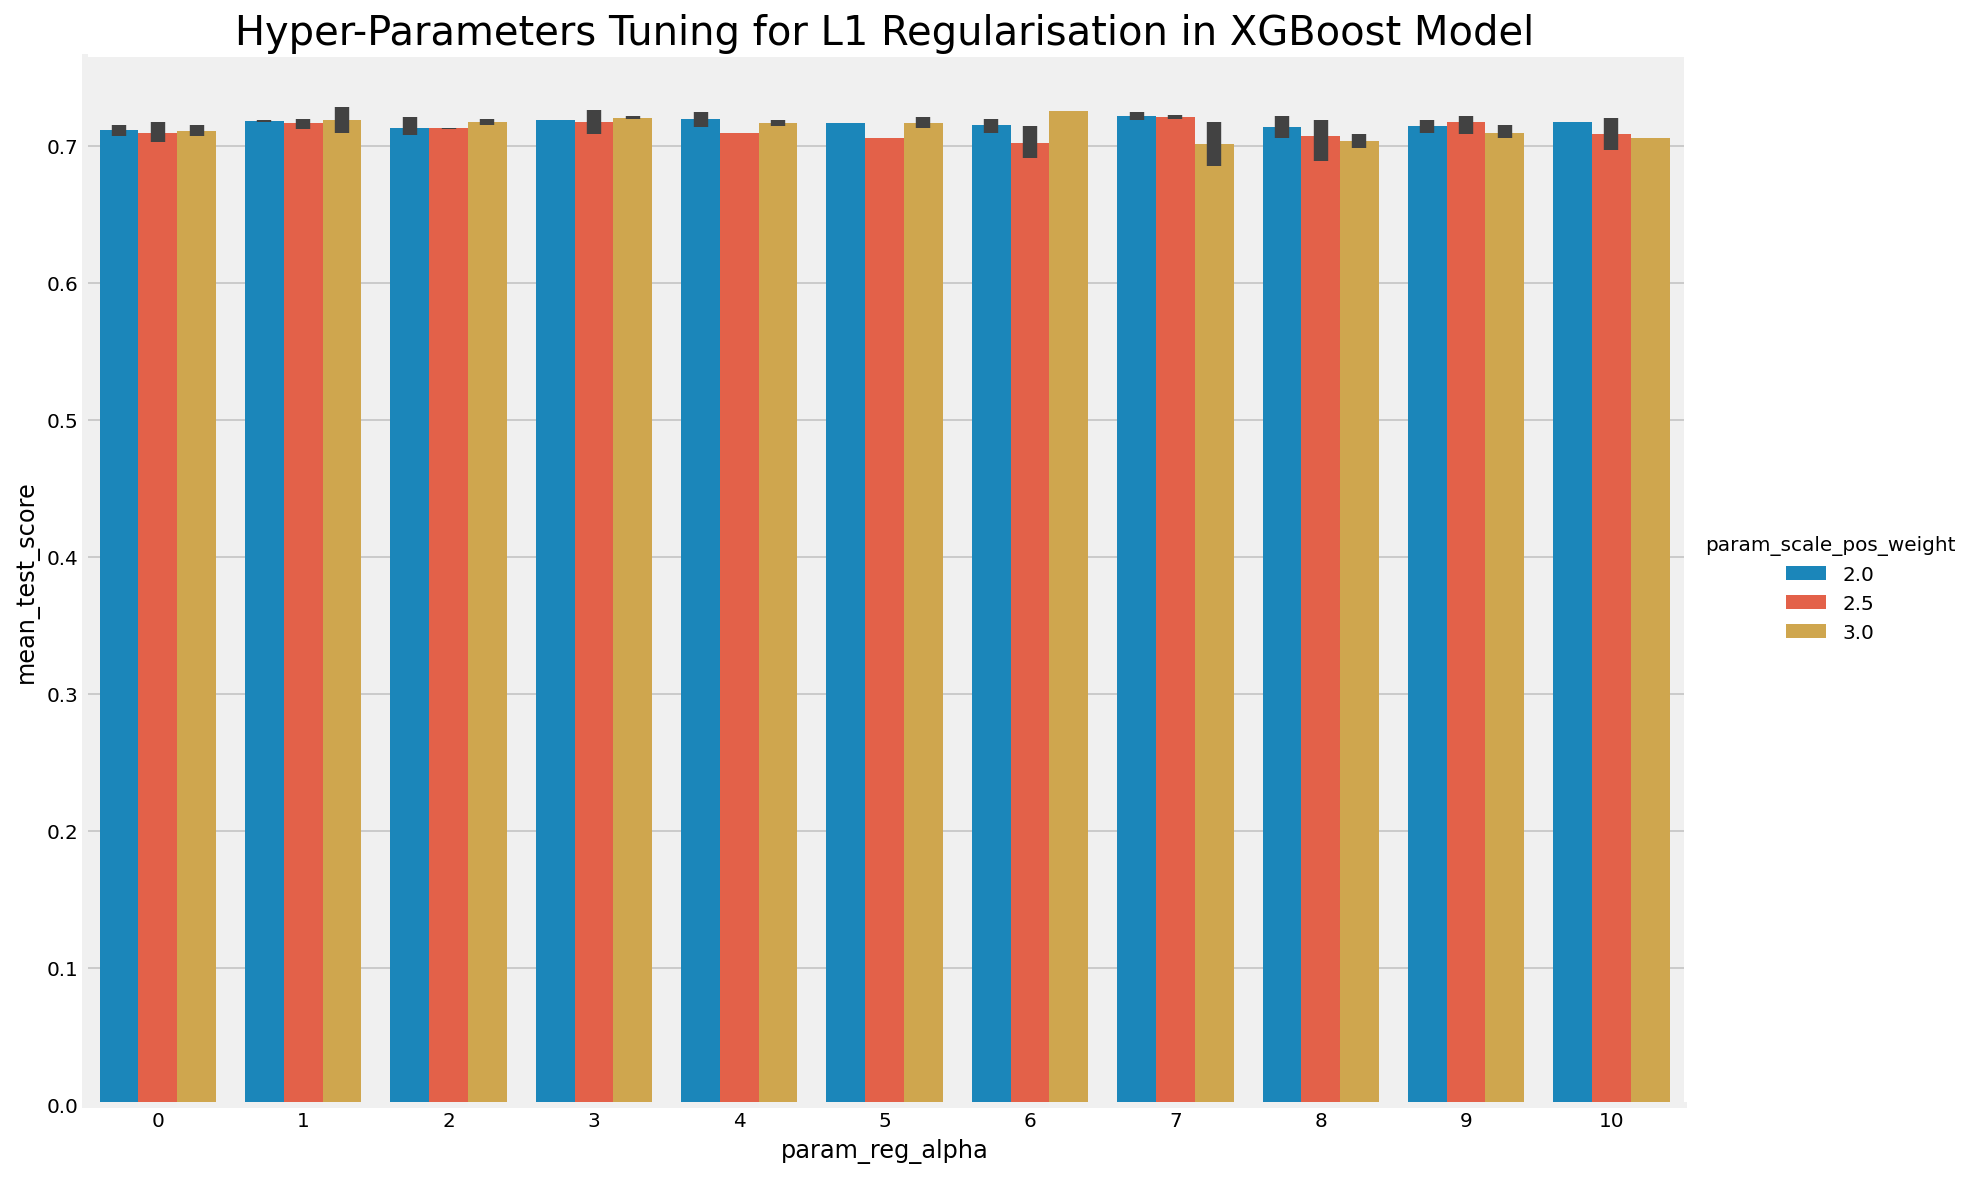

In [129]:
sns.catplot(data=df_rs_xgbT_nnlp,
            x='param_reg_alpha',
            y='mean_test_score',
            hue='param_scale_pos_weight',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning for L1 Regularisation in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nnlp_alpha.png", transparent=True, bbox_inches='tight')
plt.show()

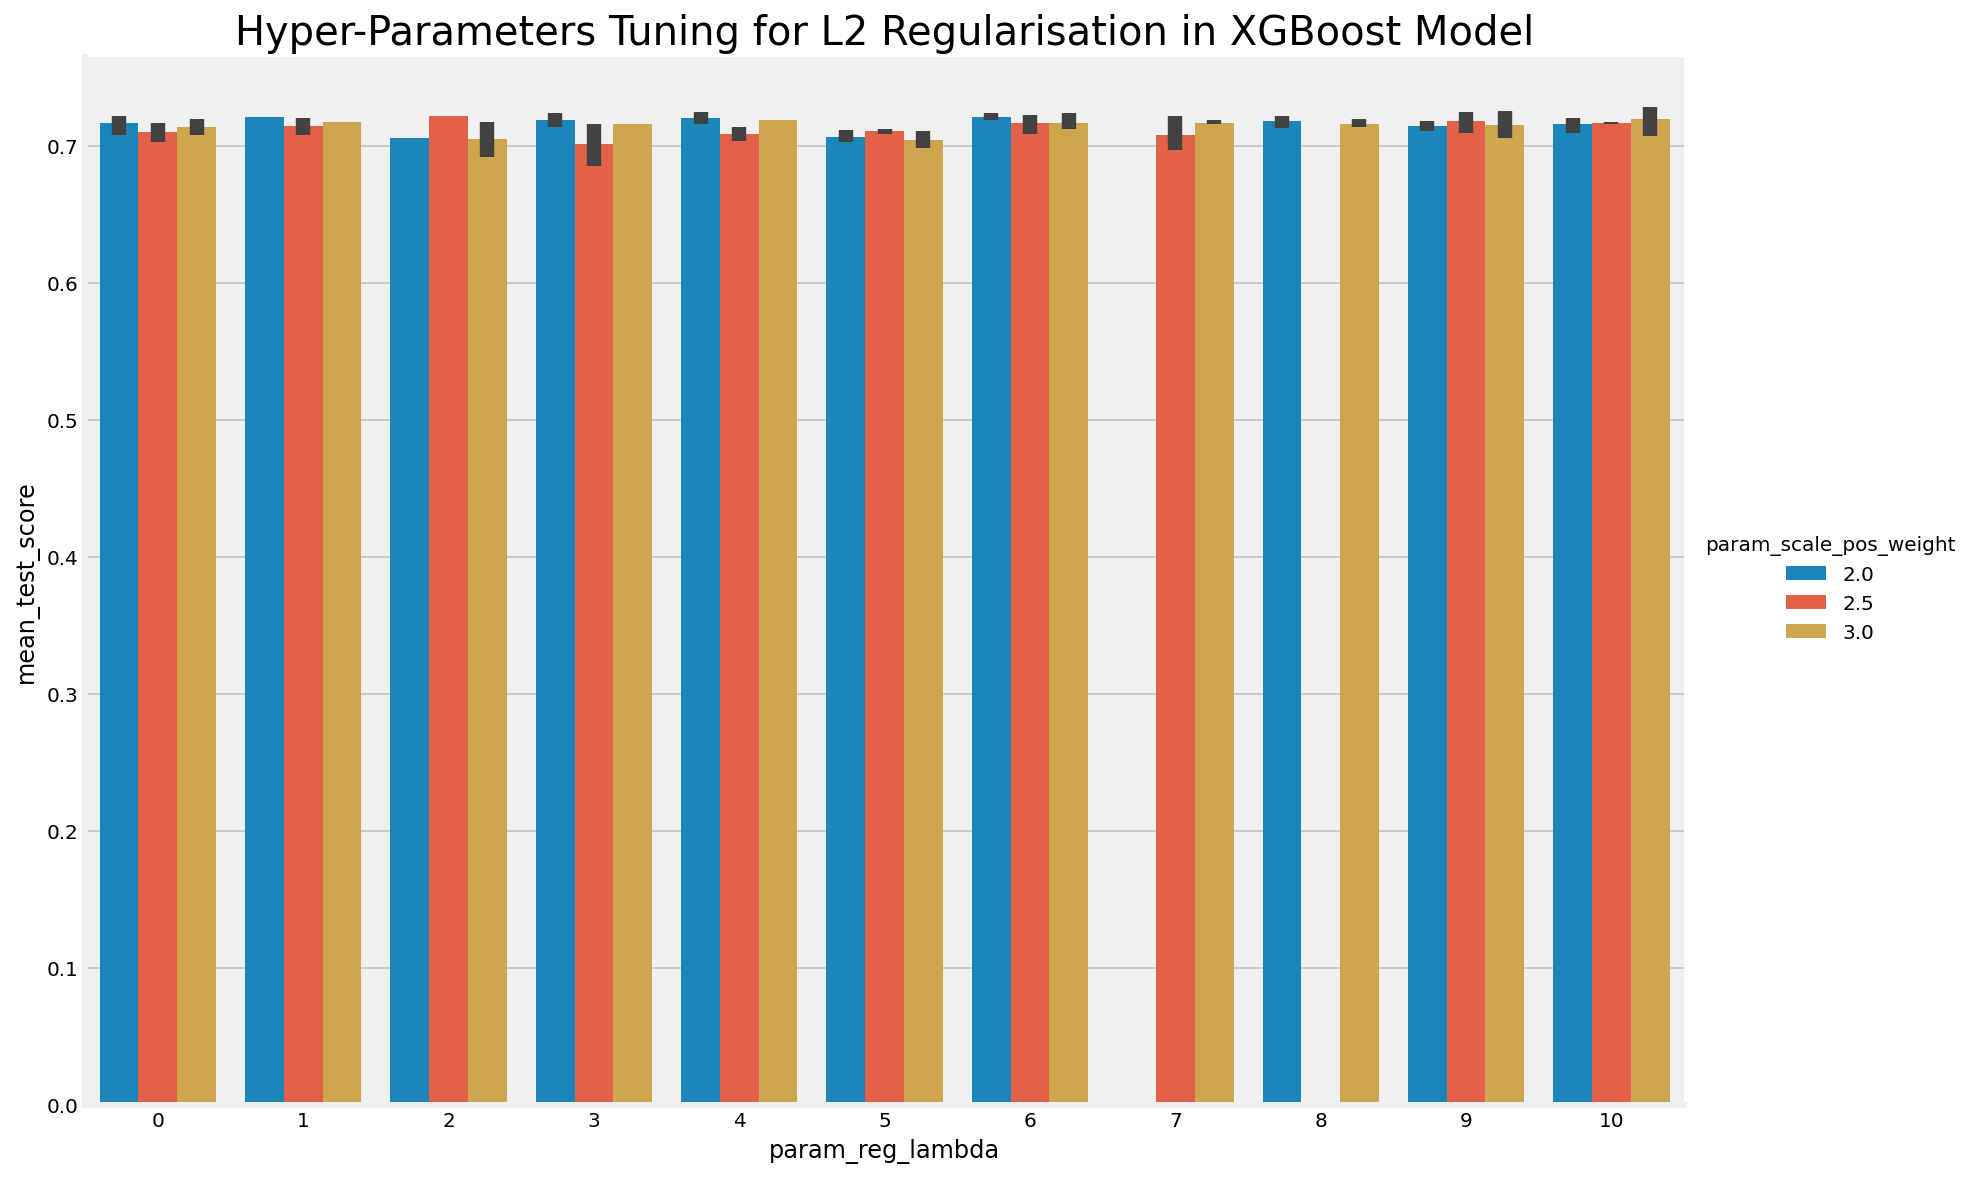

In [130]:
sns.catplot(data=df_rs_xgbT_nnlp,
            x='param_reg_lambda',
            y='mean_test_score',
            hue='param_scale_pos_weight',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning for L2 Regularisation in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nnlp_lambda.png", transparent=True, bbox_inches='tight')
plt.show()

No clear trend can observed for both L1 `reg_alpha` and L2 `reg_lambda` regularisation, even when grouped by `scale_pos_weight`.

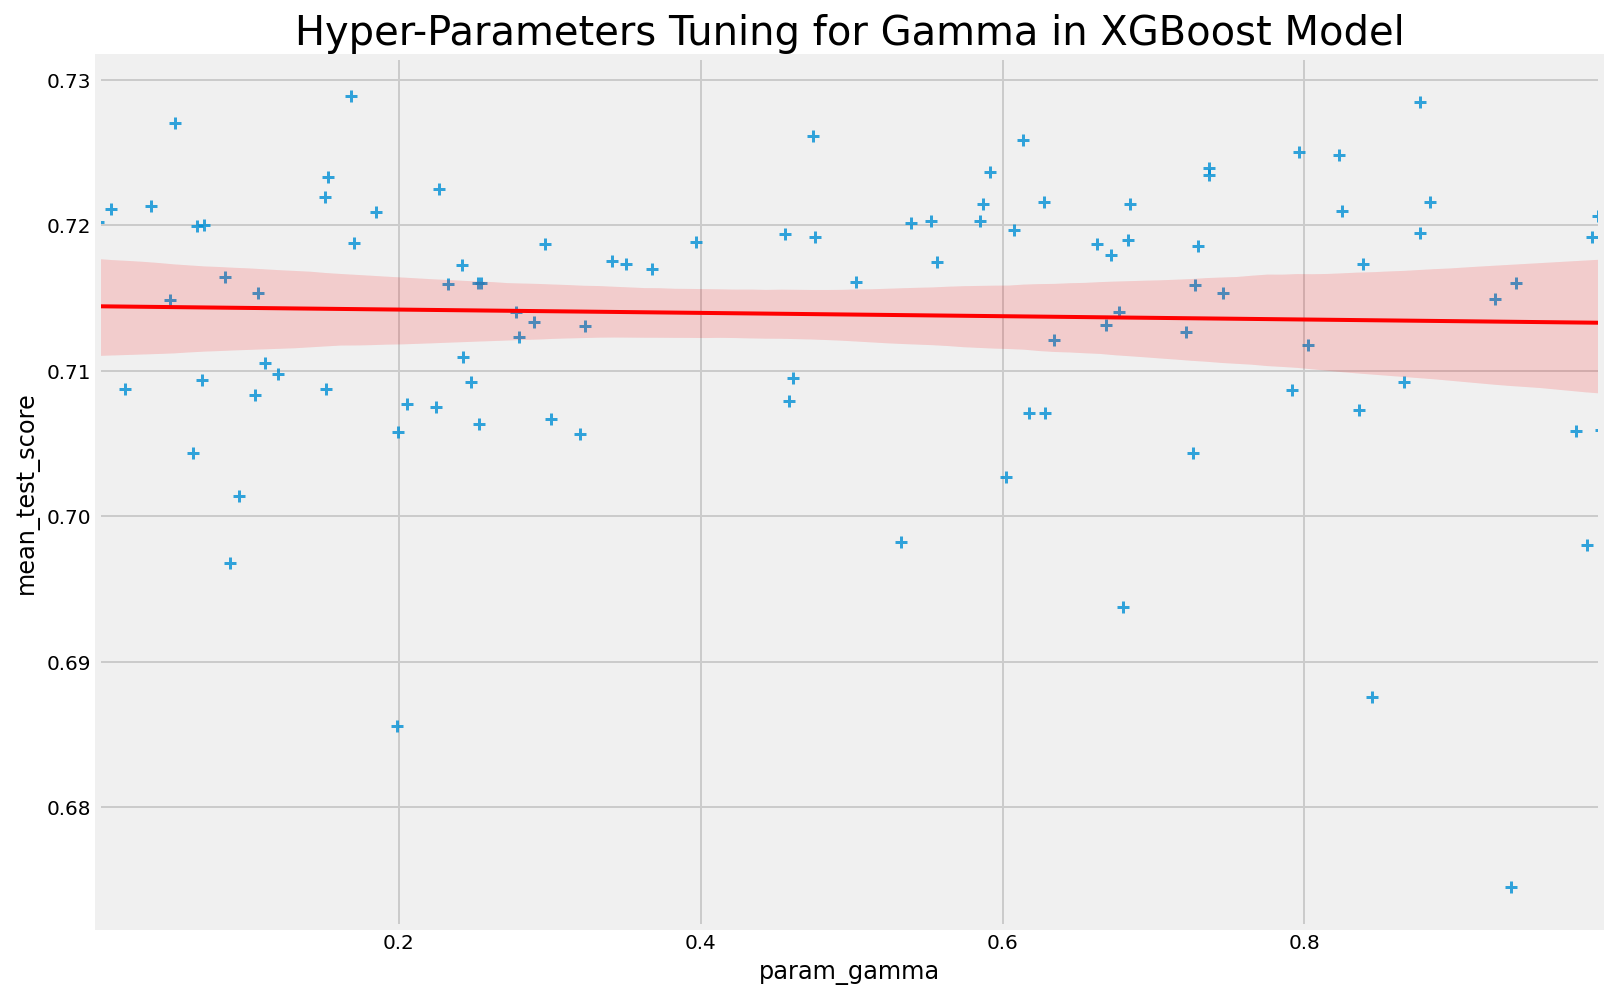

In [132]:
plt.figure(figsize=[12,8])
plt.title("Hyper-Parameters Tuning for Gamma in XGBoost Model", size=20)
sns.regplot(data=df_rs_xgbT_nnlp,
            x='param_gamma',
            y='mean_test_score',
            marker="+", scatter_kws={"lw": 1.5},
            line_kws={"lw": 2, "color": "r"})
plt.savefig("../assets/hparams_xgbT_nnlp_gamma.png", transparent=True, bbox_inches='tight')
plt.show()

For `gamma`, there appears to be overall no effect on CV scores. Researching the hyper-parameter further online suggests that this parameter can be further tuned if needed once all other parameters have been fixed. The parameter `gamma` simply increases the threshold for loss reduction required to make a split, where the default `gamma` is 0. This means that `gamma` can be effective to prune trees that have over-fitted.

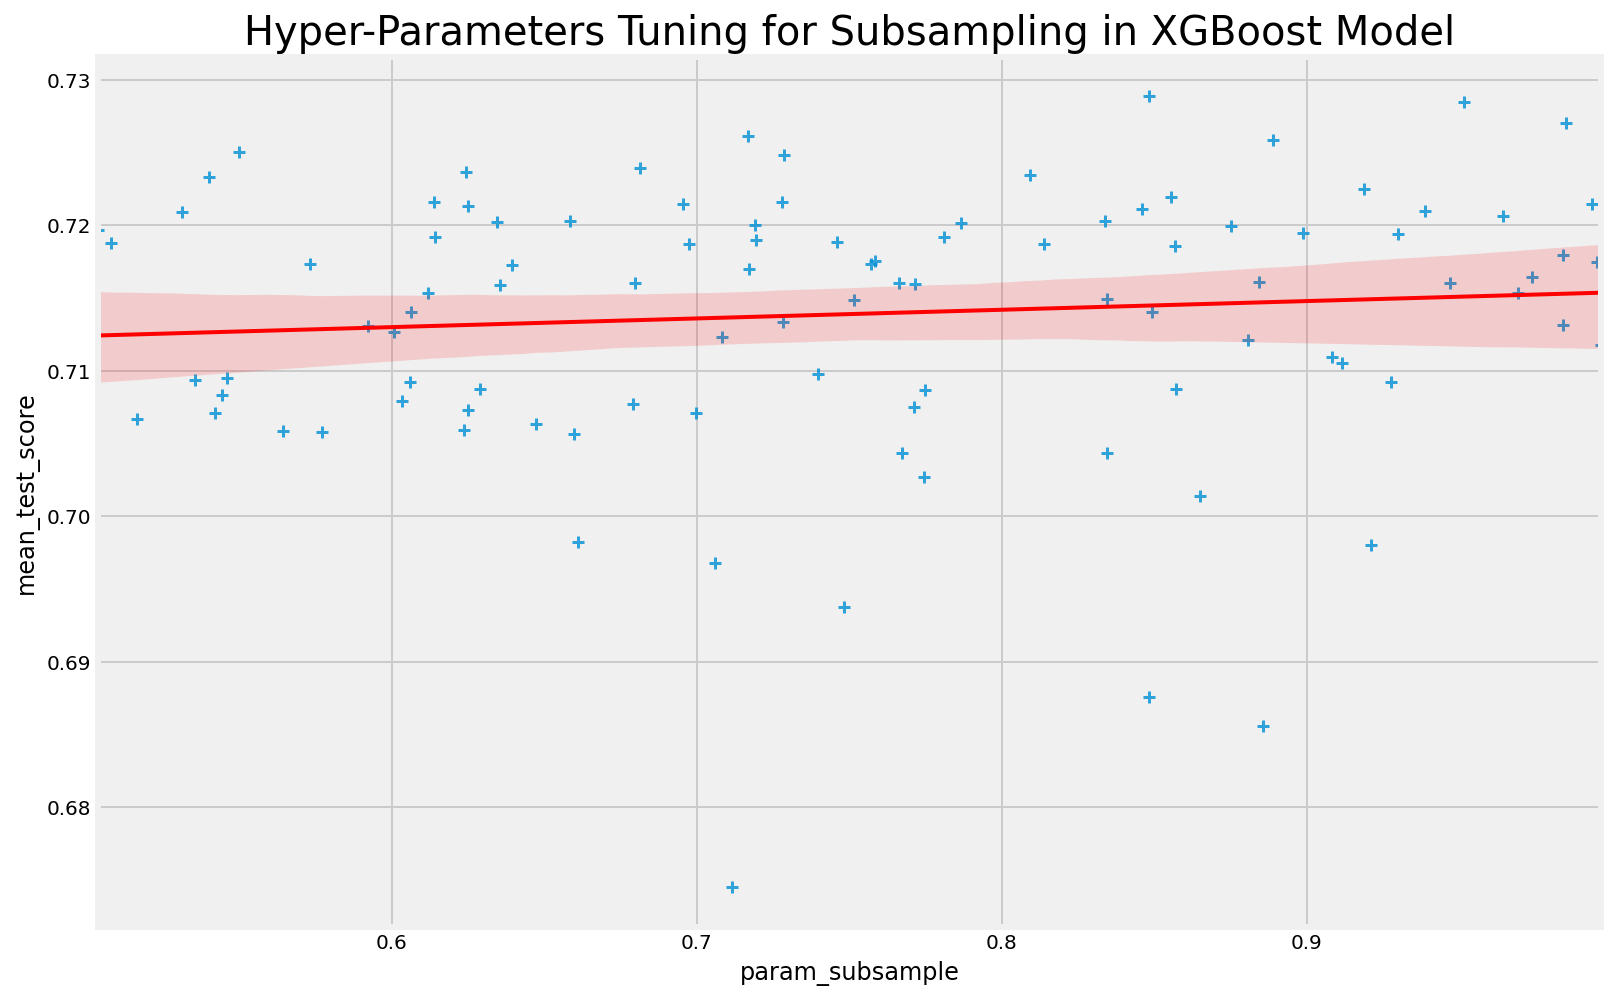

In [134]:
plt.figure(figsize=[12,8])
plt.title("Hyper-Parameters Tuning for Subsampling in XGBoost Model", size=20)
sns.regplot(data=df_rs_xgbT_nnlp,
            x='param_subsample',
            y='mean_test_score',
            marker="+", scatter_kws={"lw": 1.5},
            line_kws={"lw": 2, "color": "r"})
plt.savefig("../assets/hparams_xgbT_nnlp_subsample.png", transparent=True, bbox_inches='tight')
plt.show()

Subsampling is a technique used to tamper the learning of over-fitting models by sampling a random subset of our data points (rows) for each CV model. As subsampling size increases, CV score increases ever so slightly. As our model indicates a positive relationship between `subsample` and `mean_test_score`, this means that our model is currently under-fitting. In this case, we should therefore not bother with subsampling and revert to the default `subsample` of 1 (100% of training set).

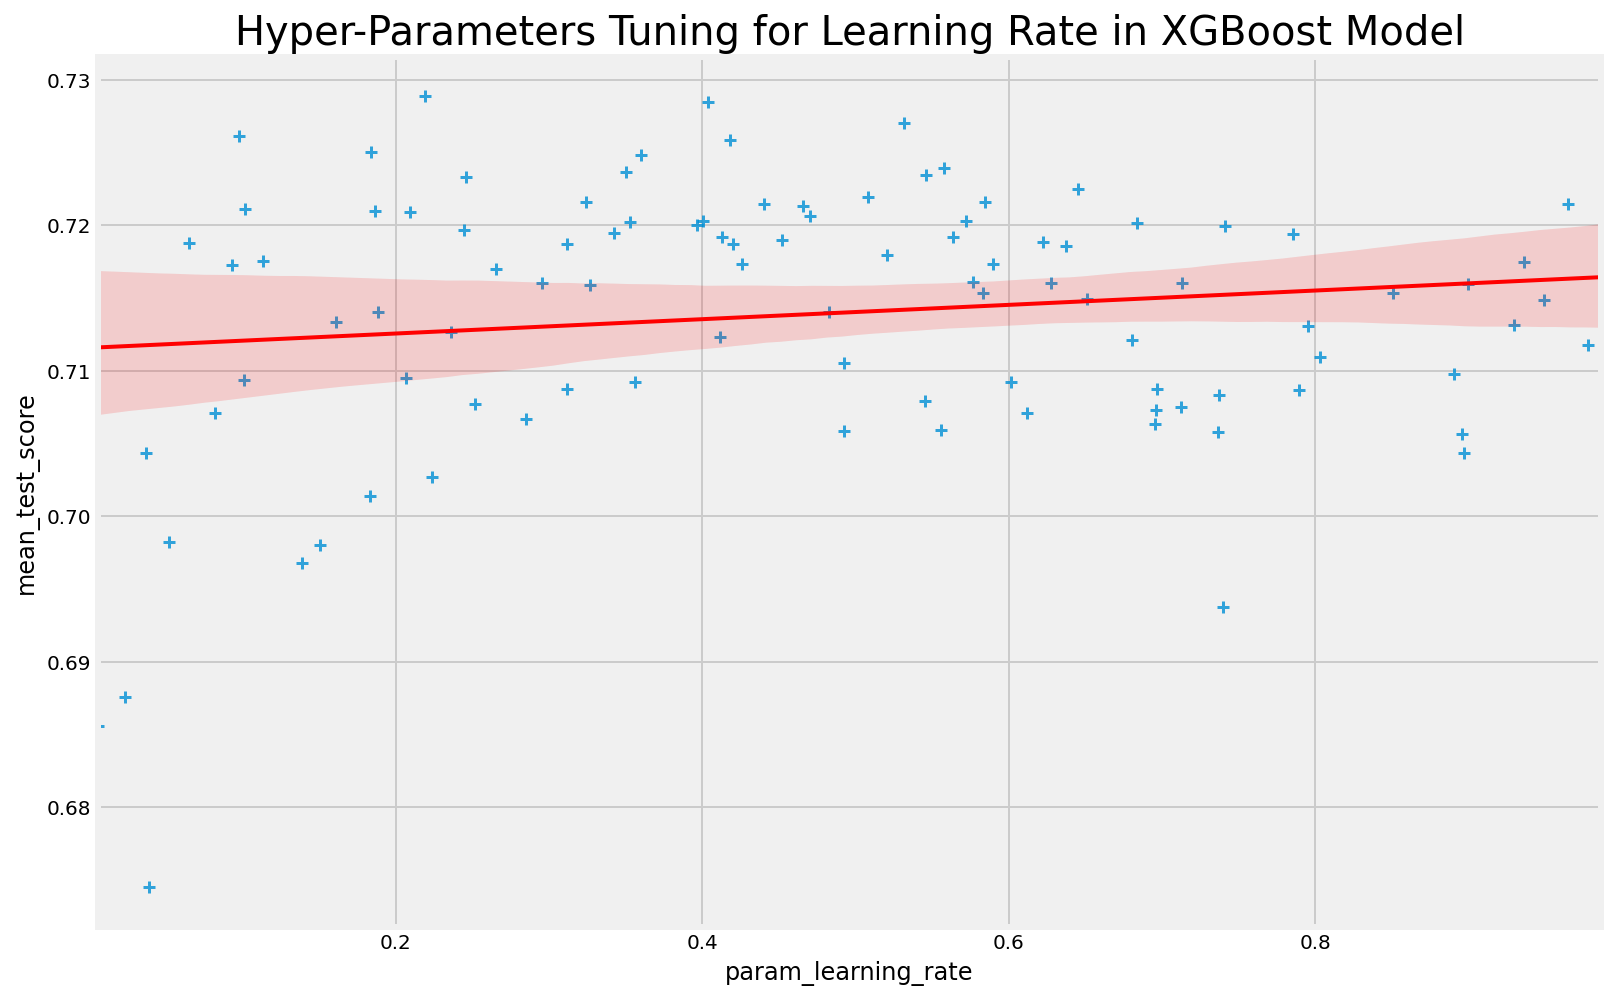

In [136]:
plt.figure(figsize=[12,8])
plt.title("Hyper-Parameters Tuning for Learning Rate in XGBoost Model", size=20)
sns.regplot(data=df_rs_xgbT_nnlp,
            x='param_learning_rate',
            y='mean_test_score',
            marker="+", scatter_kws={"lw": 1.5},
            line_kws={"lw": 2, "color": "r"})
plt.savefig("../assets/hparams_xgbT_nnlp_learning.png", transparent=True, bbox_inches='tight')
plt.show()

The parameter `learning_rate` is another important hyper-parameter according to our heatmap. As learning rate increases, the CV score increases, when the inverse is usually expected when trying to find the minima of the loss function. This suggests that our model has not found the minima of its loss function yet and can afford bigger steps in its gradient descent.

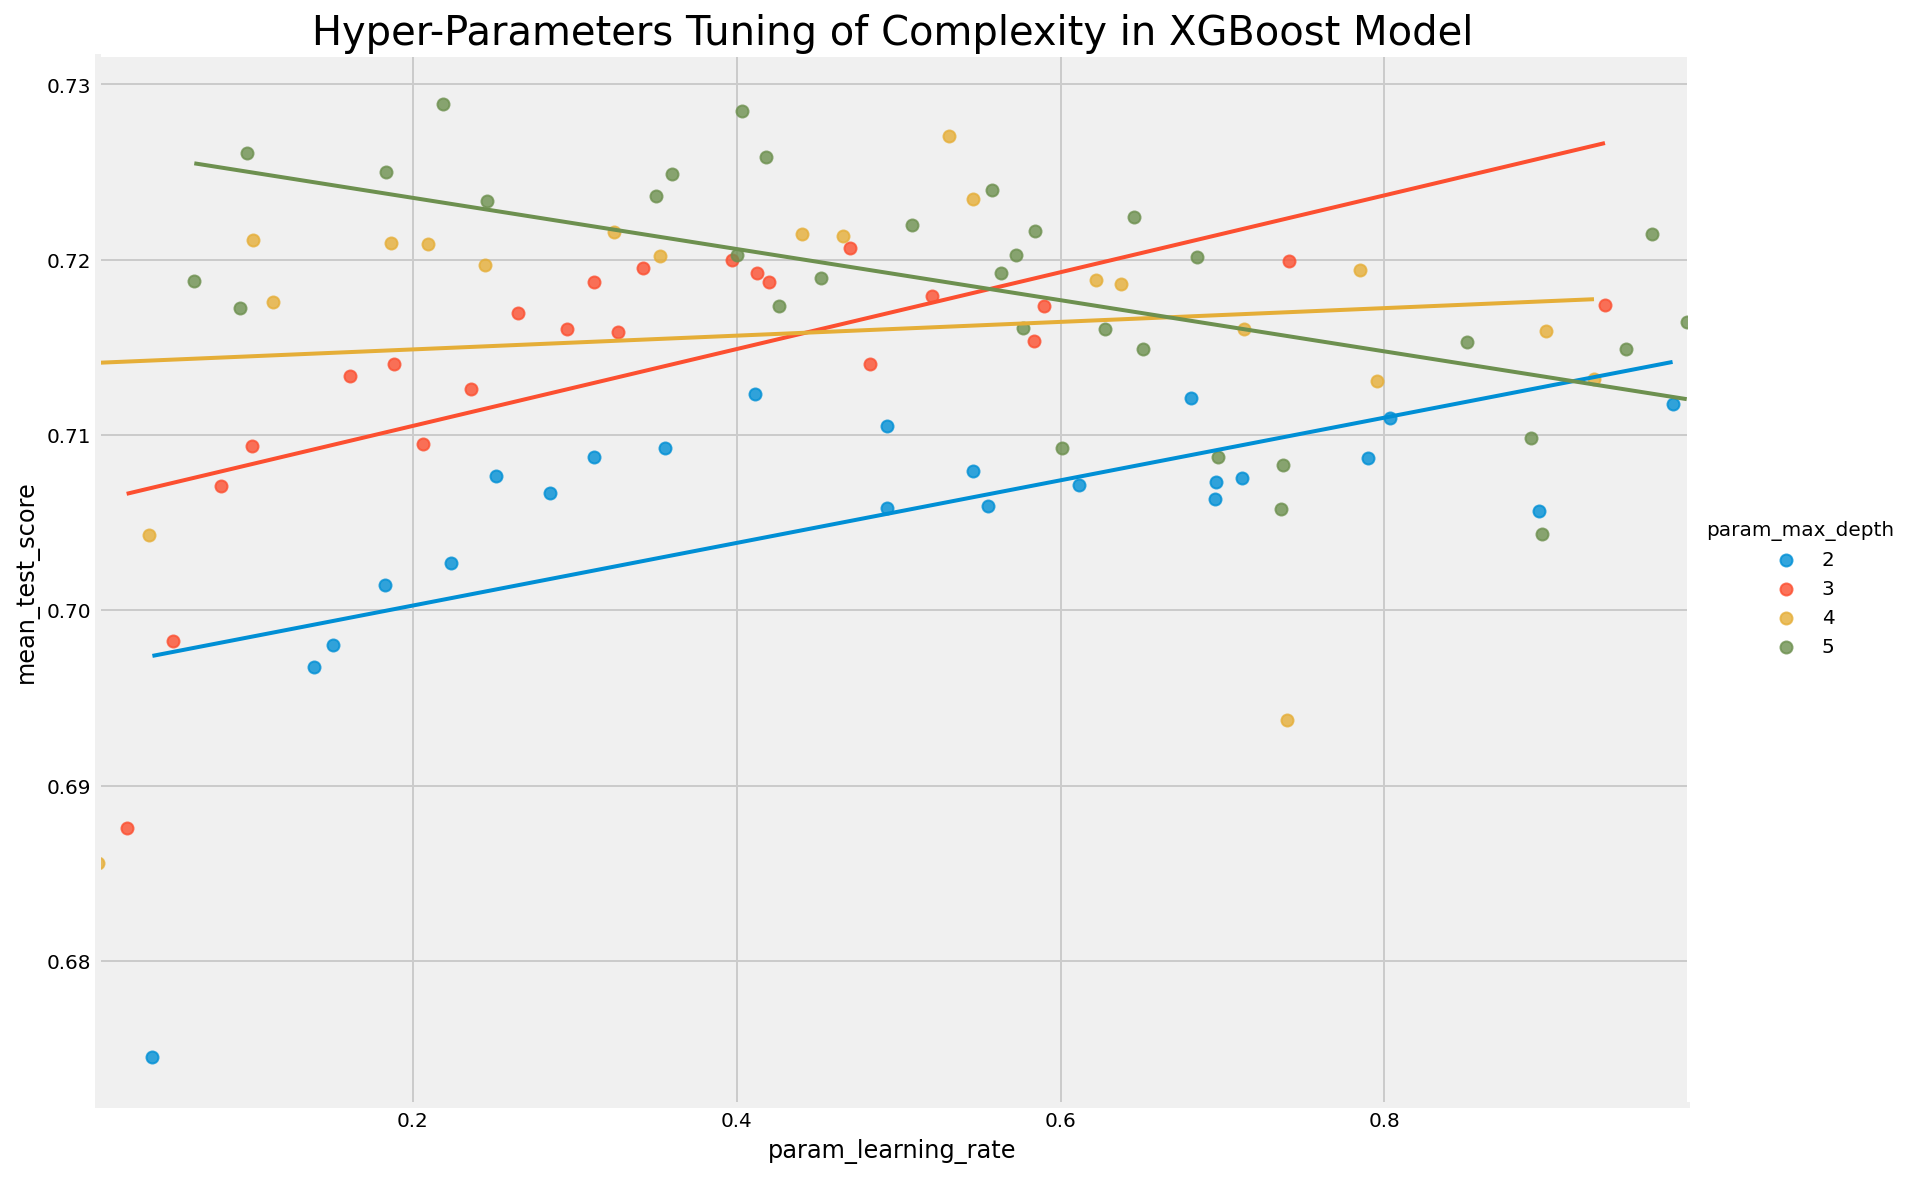

In [140]:
sns.lmplot(data=df_rs_xgbT_nnlp,
           x='param_learning_rate',
           y='mean_test_score',
           hue='param_max_depth', fit_reg=True, ci=None,
           height=8, aspect=1.5, line_kws={"lw": 2})
plt.gcf()
plt.title("Hyper-Parameters Tuning of Complexity in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nnlp_complex.png", transparent=True, bbox_inches='tight')
plt.show()

We can tune complexity of our model using both `max_depth` and `learning_rate`. The first allows us to control the size of each tree, the latter controls the size of each gradient descent step towards our loss minima. When we evaluate `learning_rate` against `max_depth`, it appears that bigger and deeper trees tend to give us better CV scores when `learning_rate` is small, but smaller trees give us better CV score when `learning_rate` increases past about 0.55.

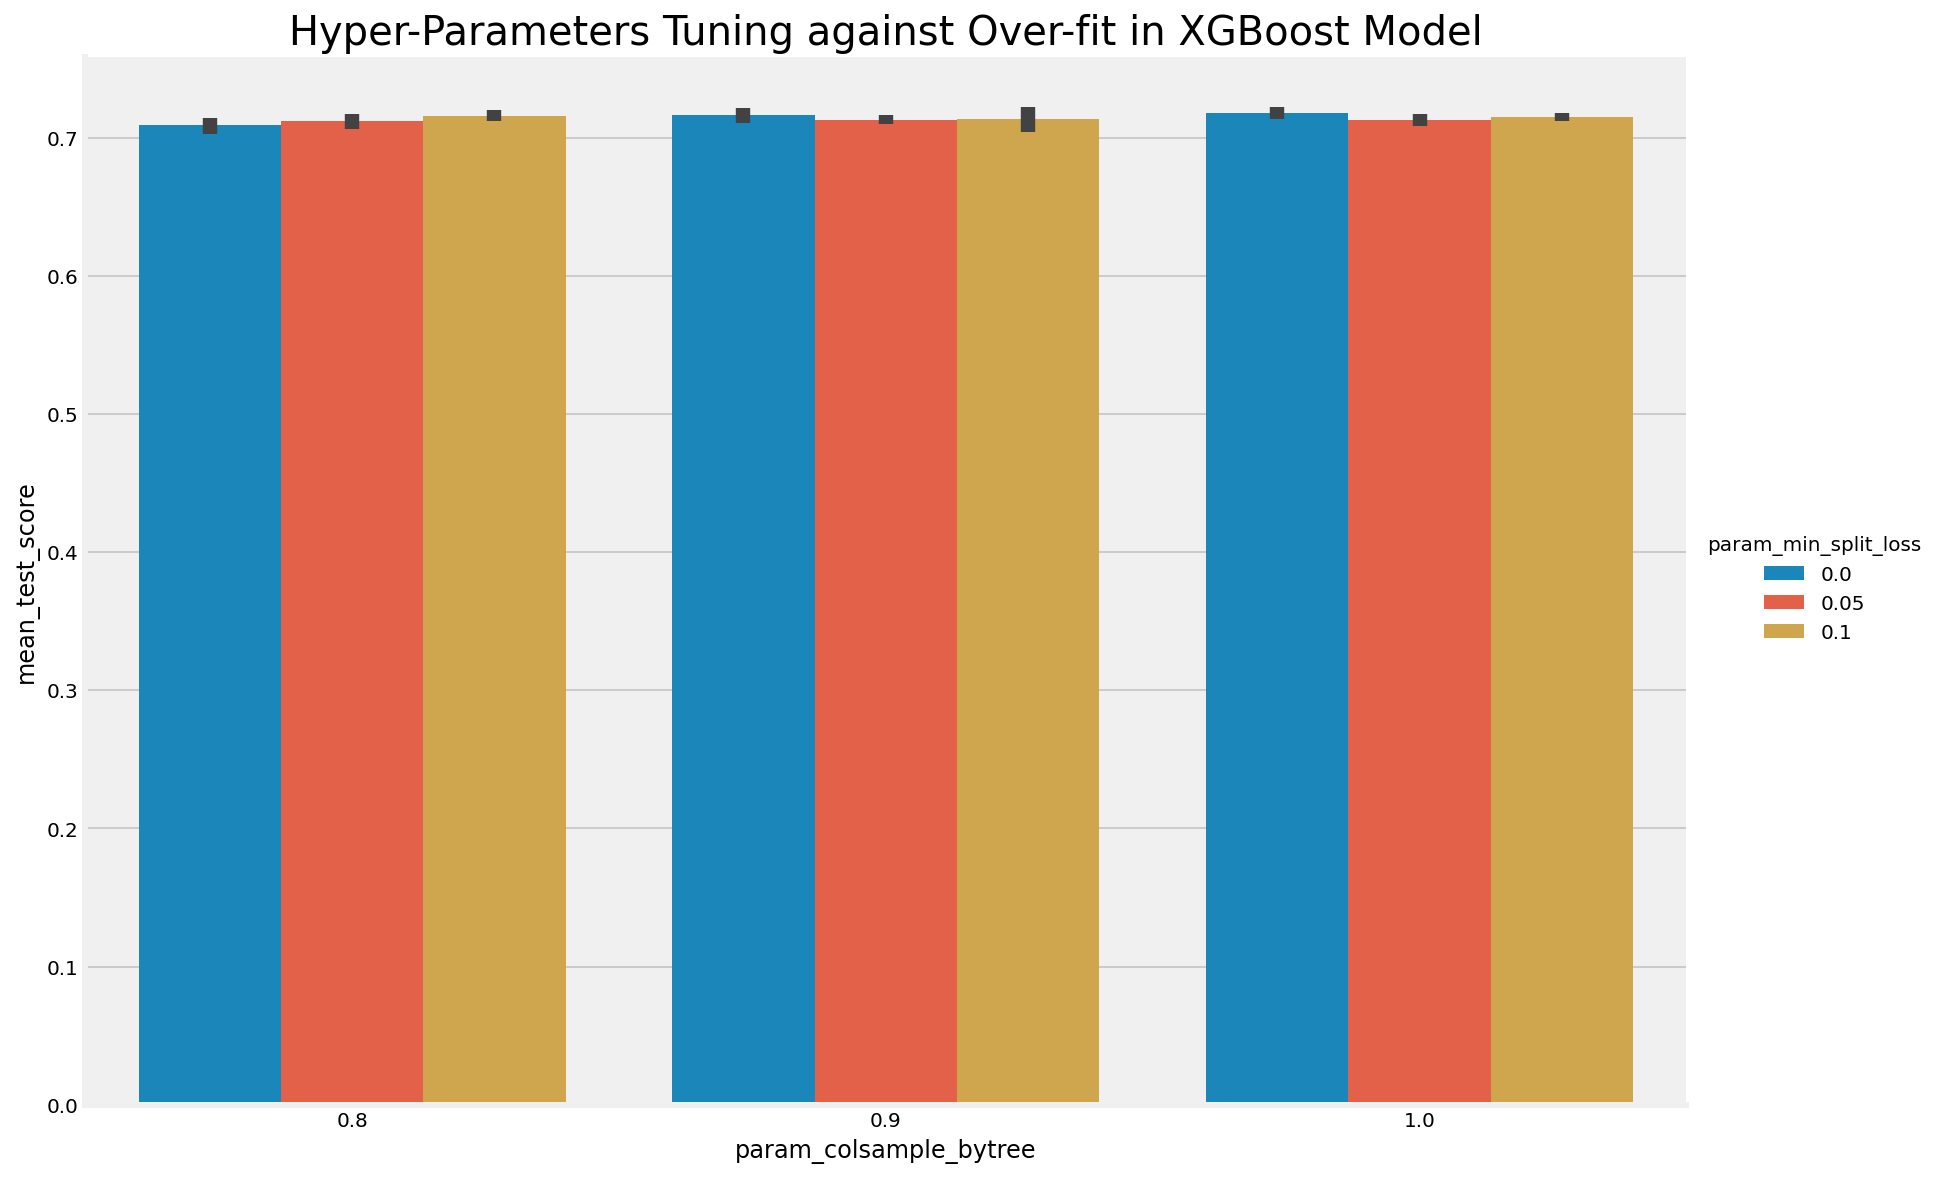

In [137]:
sns.catplot(data=df_rs_xgbT_nnlp,
            x='param_colsample_bytree',
            y='mean_test_score',
            hue='param_min_split_loss',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning against Over-fit in XGBoost Model", size=20)
# plt.savefig("../assets/hparams_xgbT_nnlp_overfit.png", transparent=True, bbox_inches='tight')
plt.show()

The parameter `colsample_bytree` is the sampling ratio of our columns/features of each CV model. It is the other dimension to subsampling data rows as we have seen in `subsample`. There is no perceptible pattern here.

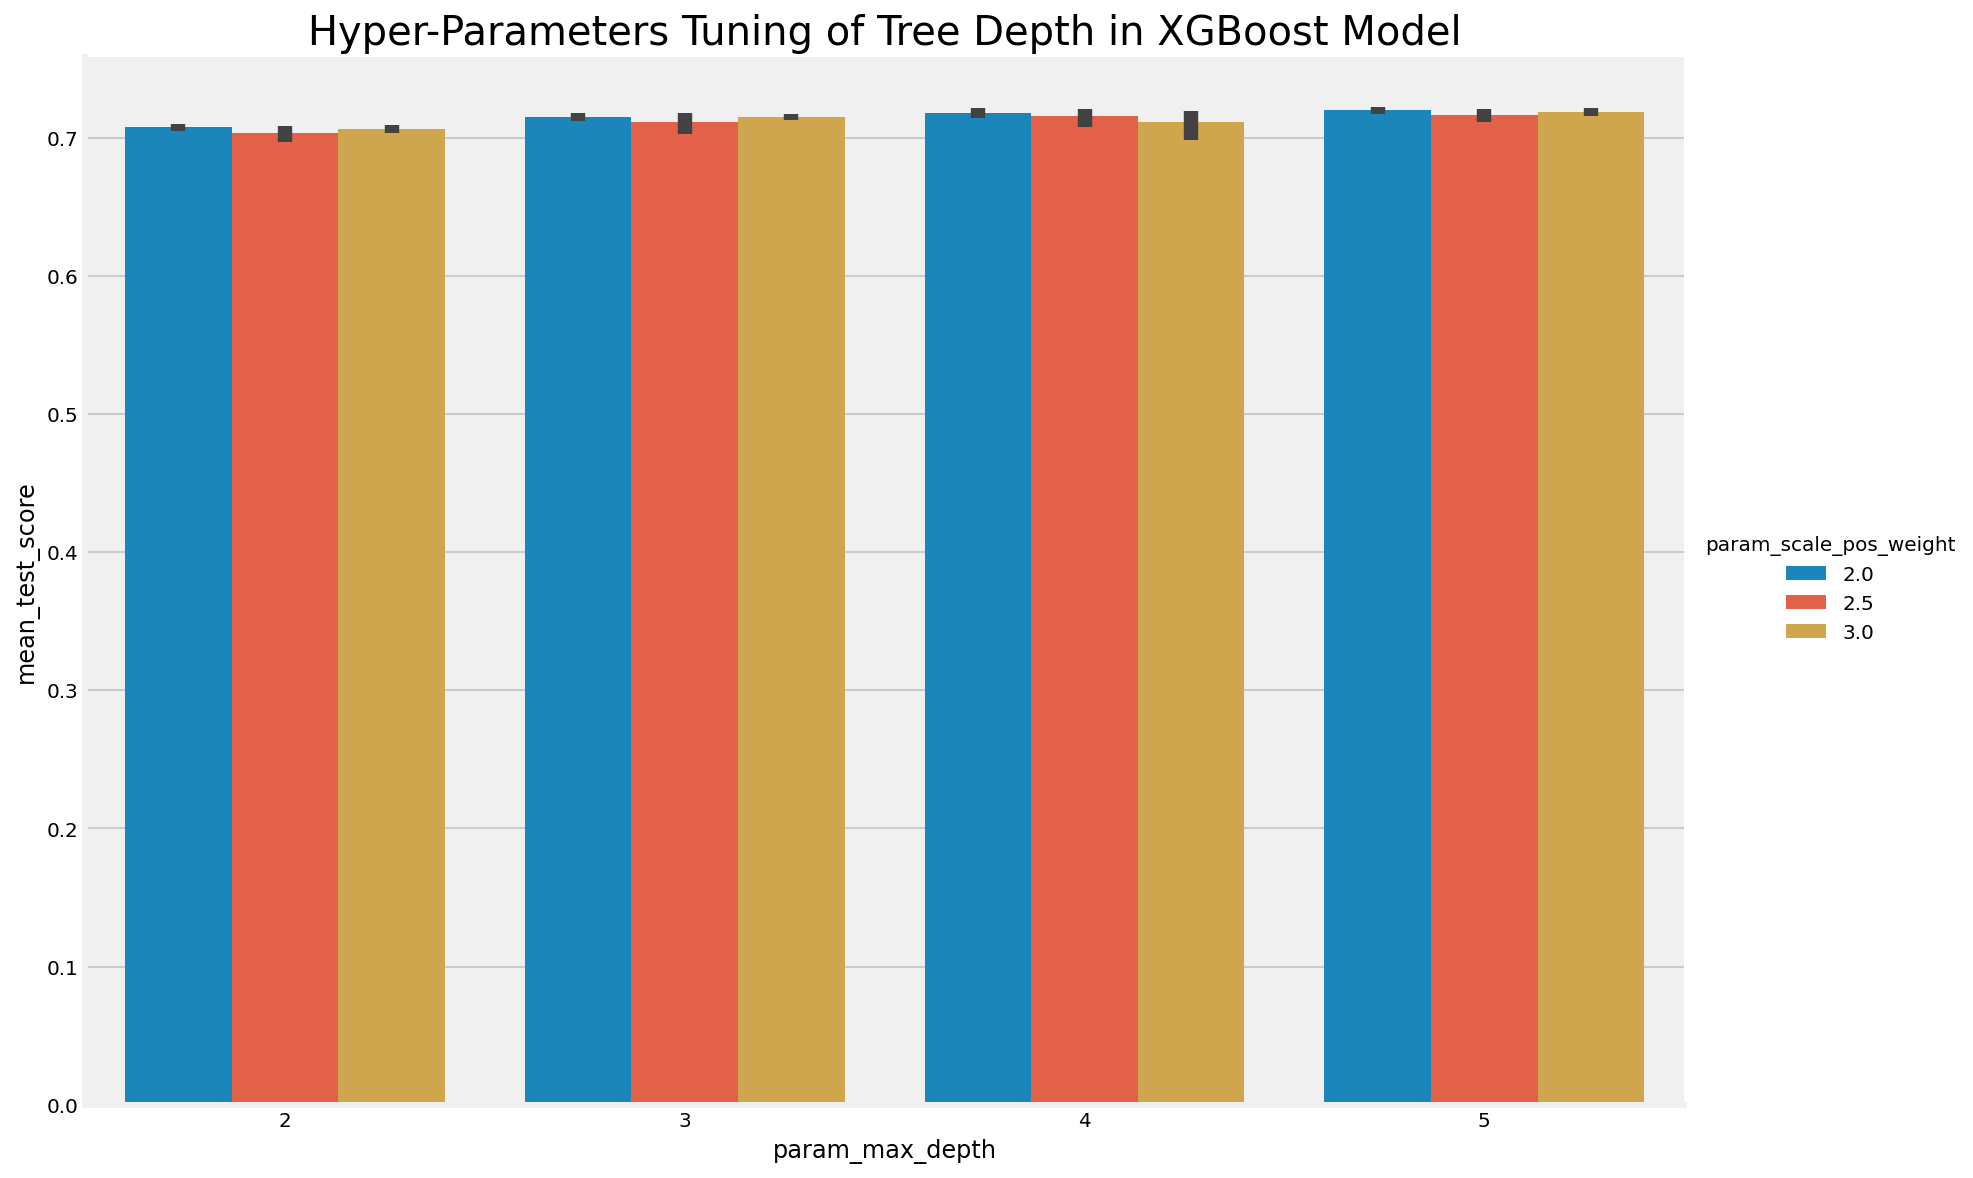

In [138]:
sns.catplot(data=df_rs_xgbT_nnlp,
            x='param_max_depth',
            y='mean_test_score',
            hue='param_scale_pos_weight',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning of Tree Depth in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nnlp_depth.png", transparent=True, bbox_inches='tight')
plt.show()

#### Further Optimisation - XGBoost (Tree)

In [ ]:
pipe_params_xgbT = {
    "reg_alpha": randint(0, 11),
    "reg_lambda": randint(0, 11),
    "gamma": uniform(0, 1),
    "scale_pos_weight": [2, 2.5, 3], # xgb doc recommends sum(neg)/sum(pos) = 12_793/5257
    "learning_rate": uniform(0, 1),
    "min_split_loss": [0, 0.05, 0.1],
    "max_depth": randint(2, 6),
    "min_child_weight": randint(0, 5),
    "subsample": uniform(0.5, 0.5),
    "colsample_bytree": [0.8, 0.9, 1]
}

Best XGBoost Model (Tree) Hyper-Parameters for non-NLP:
```
{'colsample_bytree': 1,
 'gamma': 0.16829104217293056,
 'learning_rate': 0.21876421957307024,
 'max_depth': 5,
 'min_child_weight': 0,
 'min_split_loss': 0,
 'reg_alpha': 0,
 'reg_lambda': 9,
 'scale_pos_weight': 2.5,
 'subsample': 0.8481521364198942}
 ```

L1 and L2 regularisation through `reg_alpha` and `reg_lambda` respectively found its optimal value within the range of arguments (0-10) provided during our randomised grid search. As such, we shall take these values as final.

The `gamma` parameter sets the minimum loss threshold for a split, effectively pruning the tree's growth and helping to reduce over-fitting of trees. It is recommended to tune this parameter after all other parameters have been fixed. We shall leave it at its default value of 0 for now.

The optimal value for `scale_pos_weight` was found to be at 2.5 within its range of input arguments. This is a parameter that incentivises the model to learn more of the minority positive class (popular = 1) by adding weight to the minority value. We shall therefore accept this value as our optimal value.

For `learning_rate`, the optimal value was found to be at about 0.22. Even though we fed as input argument for the randomised grid search a uniform distribution of values from 0.0 to 1.0, suggesting that this is likely its optimal value after 100 iterations, our chart suggest a pattern whereby greater learning rate is correlated with an increase in CV scores. As such, we shall test a range of greater values to see if there is a another value of `learning_rate` that is optimal.

The parameter `max_depth` was given a range of random integers from 2 to 5 and the upper limit of 5 was chosen as optimal. We shall test with arguments greater than 5 to find the optimal value.

Parameter `min_child_weight` was given a range of random integers from 0 to 4 and the optimal value was found to be at 0. We will therefore accept this value as the optimal.

Since the `subsample` optimal value was given to be at 0.85, but we believe our model to currently be under-fitting from our charts, let's input 0.85 and 1 as arguments into our `subsample` parameter and see if model performs better when trained on random subsamples (rows) of the training set or when trained on the full training set size.

Likewise, for `colsample_bytree` which samples from the column axis as a technique to reduce over-fitting of model, we shall fix our optimal value at 1 which was also what is recommended by the randomised grid search.

In [150]:
# instantiate XGB model
xgbT = xgb.XGBClassifier(booster="gbtree", objective="binary:logistic")

# set hyper params to tune
pipe_params_xgbT = {
    "reg_alpha": [0],
    "reg_lambda": [9],
    "gamma": [0],
    "scale_pos_weight": [2.5],
    "learning_rate": [0.2, 0.3, 0.4],
    "min_split_loss": [0],
    "max_depth": [5, 6, 7, 8, 9, 10],
    "min_child_weight": [0],
    "subsample": [0.85, 1],
    "colsample_bytree": [1]
}

In [151]:
%%time
np.random.seed(42)
gs_xgbT_nnlp = GridSearchCV(estimator=xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="roc_auc")
gs_xgbT_nnlp.fit(X_nnlp_train_dumm, y_train)
print("Best score in Grid Search:", gs_xgbT_nnlp.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nnlp.best_params_

Best score in Grid Search: 0.7324672313511251

Using the following hyper-parameters:
Wall time: 4min 21s


{'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.2,
 'max_depth': 8,
 'min_child_weight': 0,
 'min_split_loss': 0,
 'reg_alpha': 0,
 'reg_lambda': 9,
 'scale_pos_weight': 2.5,
 'subsample': 1}

The optimal `learning_rate` value was found at 0.2 and within the range of arguments tested thus far. Similarly, `max_depth` optimal value was found at 8 within the range of arguments provided in the grid search. We have therefore arrived at our optimal hyper-parameters. We have also found our `subsample` optimal value at 1 as suspected and will build our model as such. As mentioned, we will tune `gamma` once we have fixed our other hyper-parameters. Let's see if tuning our `gamma` parameter gives us any improvement.

In [148]:
# instantiate XGB model
xgbT = xgb.XGBClassifier(booster="gbtree", objective="binary:logistic")

# set hyper params to tune
pipe_params_xgbT = {
    "reg_alpha": [0],
    "reg_lambda": [9],
    "gamma": [0, 0.05, 0.1, 0.2, 0.4, 0.8], # gamma ranges from 0 to 1
    "scale_pos_weight": [2.5],
    "learning_rate": [0.2],
    "min_split_loss": [0],
    "max_depth": [8],
    "min_child_weight": [0],
    "subsample": [1],
    "colsample_bytree": [1]
}

In [149]:
%%time
np.random.seed(42)
gs_xgbT_nnlp = GridSearchCV(estimator=xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="roc_auc")
gs_xgbT_nnlp.fit(X_nnlp_train_dumm, y_train)
print("Best score in Grid Search:", gs_xgbT_nnlp.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nnlp.best_params_

Best score in Grid Search: 0.7324672313511251

Using the following hyper-parameters:
Wall time: 46.8 s


{'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.2,
 'max_depth': 8,
 'min_child_weight': 0,
 'min_split_loss': 0,
 'reg_alpha': 0,
 'reg_lambda': 9,
 'scale_pos_weight': 2.5,
 'subsample': 1}

Our grid search returned the exact same CV score and revealed that `gamma` values is best kept at the default of 0 as it does not improve our model's performance. We have now tuned our hyper-parameters for our non-NLP model.

### Model_01

Using tuned hyper-parameters from above, we shall build our individual NLP and non-NLP model. Both models will be built using `XGBClassifier` which has consistently gave us our best result thus far.

#### NLP_01

Using the best hyper-parameters for NLP model from Grid Search:
```
{'tvec__max_features': 2500,
 'tvec__ngram_range': (1, 1),
 'xgboost__colsample_bytree': 1,
 'xgboost__gamma': 0.054971823085072924,
 'xgboost__learning_rate': 0.35,
 'xgboost__max_depth': 7,
 'xgboost__min_child_weight': 2,
 'xgboost__reg_alpha': 7,
 'xgboost__reg_lambda': 0,
 'xgboost__scale_pos_weight': 3.5,
 'xgboost__subsample': 1}
```
Let's build our XGBoost model using tuned hyper-parameters and evaluate its performance.

In [10]:
# match best params from above for TfidfVectorizer
tvec = TfidfVectorizer(stop_words="english", max_features=2500, ngram_range=(1,1))
X_train_tvec = tvec.fit_transform(X_nlp_train)
print("Shape of training sparse matrix:", X_train_tvec.shape)
X_unseen_tvec = tvec.transform(X_nlp_unseen)
print("Shape of test sparse matrix:", X_unseen_tvec.shape)

Shape of training sparse matrix: (18050, 2500)
Shape of test sparse matrix: (6017, 2500)


In [11]:
%%time
xgboost_nlp_01 = xgb.XGBClassifier(booster="gbtree",
                                objective="binary:logistic",
                                colsample_bytree=1,
                                gamma=0.055,
                                learning_rate=0.35,
                                max_depth=7,
                                min_child_weight=2,
                                reg_alpha=7,
                                reg_lambda=0,
                                scale_pos_weight=3.5,
                                subsample=1)

xgboost_nlp_01.fit(X_train_tvec, y_train)

Wall time: 5.55 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.055, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.35, max_delta_step=0, max_depth=7,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=7, reg_lambda=0, scale_pos_weight=3.5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [13]:
def eval_classifier(y_true, y_pred): # def function to evaluate classifier performance
    
    # get confusion matrix labels
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp)
    print()
    
    # eval all metrics
    roc_auc = roc_auc_score(y_true, y_pred) # ROC-AUC eval recall against specificity
    recall = tp / (tp + fn) # ratio of predicted positives to all positives
    specificity = tn / (tn + fp) # ratio of predicted negatives to all negatives
    accuracy = accuracy_score(y_true, y_pred) # ratio of correct predictions to total predictions
    precision = precision_score(y_true, y_pred) # precision of predictions for positive
    f1 = f1_score(y_true, y_pred) # F-1 score that measures harmonic mean of recall and precision
    print("ROC-AUC score:", round(roc_auc, 3))
    print("Accuracy:", round(accuracy, 3))
    print("Recall:", round(recall, 3))
    print("Specificity:", round(specificity, 3))
    print("Precision:", round(precision, 3))
    print("F-1 score:", round(f1, 3))

In [13]:
# get predictions on unseen test set
xgb_nlp_predictions_01 = xgboost_nlp_01.predict(X_unseen_tvec)
eval_classifier(y_unseen, xgb_nlp_predictions_01) # evaluate predictions

True Negatives: 3074
False Positives: 1191
False Negatives: 515
True Positives: 1237

ROC-AUC score: 0.713
Accuracy: 0.716
Recall: 0.706
Specificity: 0.721
Precision: 0.509
F-1 score: 0.592


|*Confusion Matrix*|Predicted Negatives|Predicted Positives*|
|---|---|---|
|**Actual Negatives**|3074|1191|
|**Actual Positives**|515|1237|

<p style="text-align:right;"><sup>*predict for <i>popularity</i></sup></p>

Looking at the score, Our **ROC-AUC score** appears to be fairly decent at 0.713. This is because ROC-AUC measures recall against specificity, and our recall and specificity are decently scored at 0.706 and 0.721 respectively. This means that our model has a pretty good hit-rate for correctly classifying both our positive and negative classes.

- For recall, our model is able to correctly predict 70.6% of our **True Positive** or TP (popular) classes.
- For specificity, our model is able to correctly predict 72.1% of our **True Negative** or TN  (unpopular) classes.

However, our model scores poorly on precision, and consequently on the **F-1 score** at a paltry 0.592. This is because the F-1 score is calculated as the harmonic mean of recall against precision.

- Since our model has a decent recall of 0.706 - which means we are able to correctly classify 70.6% of the total possible true positive (popular) classes, it means we are misclassifying the negative (unpopular) classes 29.4% of the time. This results in our **False Negatives** or FN (actually popular) classification.
- But, it has a poor precision of only 0.509 - which translates to a predictive accuracy of only 50.9% for our positive (popular) predictions, which means we are misclassifying the positive (popular) classes 49.1% of the time. This results in our **False Positives** or FP (actually unpopular) classification.

We should consider which misclassification, FN or FP, that we would prefer to minimise as there is always going to be a trade-off between recall and precision.

#### nNLP_01

Using the best hyper-parameters for non-NLP model from Grid Search:
```
{'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.2,
 'max_depth': 8,
 'min_child_weight': 0,
 'min_split_loss': 0,
 'reg_alpha': 0,
 'reg_lambda': 9,
 'scale_pos_weight': 2.5,
 'subsample': 1}
```
Let's build our XGBoost model using tuned hyper-parameters and evaluate its performance.

In [14]:
%%time
xgboost_nnlp_01 = xgb.XGBClassifier(booster="gbtree",
                                objective="binary:logistic",
                                colsample_bytree=1,
                                gamma=0,
                                learning_rate=0.2,
                                max_depth=8,
                                min_child_weight=0,
                                min_split_loss=0,
                                reg_alpha=0,
                                reg_lambda=9,
                                scale_pos_weight=2.5,
                                subsample=1)

xgboost_nnlp_01.fit(X_nnlp_train_dumm, y_train)

Wall time: 2.04 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=8,
              min_child_weight=0, min_split_loss=0, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=9,
              scale_pos_weight=2.5, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [15]:
# get predictions on unseen test set
xgb_nnlp_predictions_01 = xgboost_nnlp_01.predict(X_nnlp_unseen_dumm)
eval_classifier(y_unseen, xgb_nnlp_predictions_01) # evaluate predictions

True Negatives: 2953
False Positives: 1312
False Negatives: 663
True Positives: 1089

ROC-AUC score: 0.657
Accuracy: 0.672
Recall: 0.622
Specificity: 0.692
Precision: 0.454
F-1 score: 0.524


|*Confusion Matrix*|Predicted Negatives|Predicted Positives*|
|---|---|---|
|**Actual Negatives**|2953|1312|
|**Actual Positives**|663|1089|

<p style="text-align:right;"><sup>*predict for <i>popularity</i></sup></p>

Looking at the score, Our **ROC-AUC score** appears to be still decent at 0.657. This is because ROC-AUC measures recall against specificity, and our recall and specificity are decently scored at 0.622 and 0.692 respectively. This means that our model has a pretty good hit-rate for correctly classifying both our positive and negative classes.

- For recall, our model is able to correctly predict 62.2% of our **True Positive** or TP (popular) classes.
- For specificity, our model is able to correctly predict 69.2% of our **True Negative** or TN  (unpopular) classes.

However, our model scores poorly on precision, and consequently on the **F-1 score** at a paltry 0.524. This is because the F-1 score is calculated as the harmonic mean of recall against precision.

- Since our model has a decent recall of 0.622 - which means we are able to correctly classify 62.2% of the total possible true positive (popular) classes, it means we are misclassifying the negative (unpopular) classes 37.8% of the time. This results in our **False Negatives** or FN (actually popular) classification.
- But, it has a poor precision of only 0.454 - which translates to a predictive accuracy of only 45.4% for our positive (popular) predictions, which means we are misclassifying the positive (popular) classes 54.6% of the time. This results in our **False Positives** or FP (actually unpopular) classification.

We should consider which misclassification, FN or FP, that we would prefer to minimise as there is always going to be a trade-off between recall and precision.

#### Hybrid_01

In [16]:
# extract probabilities for positive predictions from both NLP and non-NLP models
nlp_proba_01 = xgboost_nlp_01.predict_proba(X_unseen_tvec)[:, 1]
nnlp_proba_01 = xgboost_nnlp_01.predict_proba(X_nnlp_unseen_dumm)[:, 1]

In [17]:
# zip and create df matching predicted probabilities from NLP and non-NLP models to target y_unseen
df_results_01 = pd.DataFrame(zip(y_unseen, nlp_proba_01, nnlp_proba_01), columns=["y_unseen", "nlp_proba", "nnlp_proba"])
df_results_01.head(3)

y_unseen  nlp_proba  nnlp_proba
0         1   0.688491    0.540463
1         1   0.938865    0.545226
2         1   0.996576    0.953335

In [18]:
# create new col for aggregated prediction probabilities from both models
df_results_01["mean_proba"] = df_results_01[["nlp_proba", "nnlp_proba"]].T.mean()
df_results_01.head(3)

y_unseen  nlp_proba  nnlp_proba  mean_proba
0         1   0.688491    0.540463    0.614477
1         1   0.938865    0.545226    0.742045
2         1   0.996576    0.953335    0.974956

In [19]:
# create new col for predicted y values
df_results_01["y_pred"] = round(df_results_01["mean_proba"]).astype(int)
df_results_01.head(3)

y_unseen  nlp_proba  nnlp_proba  mean_proba  y_pred
0         1   0.688491    0.540463    0.614477       1
1         1   0.938865    0.545226    0.742045       1
2         1   0.996576    0.953335    0.974956       1

In [20]:
# evaluate predictions
eval_classifier(y_unseen, df_results_01["y_pred"])

True Negatives: 3168
False Positives: 1097
False Negatives: 506
True Positives: 1246

ROC-AUC score: 0.727
Accuracy: 0.734
Recall: 0.711
Specificity: 0.743
Precision: 0.532
F-1 score: 0.609


|*Confusion Matrix*|Predicted Negatives|Predicted Positives*|
|---|---|---|
|**Actual Negatives**|3168|1097|
|**Actual Positives**|506|1246|

<p style="text-align:right;"><sup>*predict for <i>popularity</i></sup></p>

Looking at the score, our **ROC-AUC score** has improved to 0.727. This is because ROC-AUC measures recall against specificity, and our recall and specificity are decently scored at 0.711 and 0.743 respectively. This means that our model has a pretty good hit-rate for correctly classifying both our positive and negative classes.

- For recall, our model is able to correctly predict 71.1% of our **True Positive** or TP (popular) classes.
- For specificity, our model is able to correctly predict 74.3% of our **True Negative** or TN  (unpopular) classes.

However, our model scores poorly on precision, and consequently on the **F-1 score** at a slight-improved 0.609. This is because the F-1 score is calculated as the harmonic mean of recall against precision.

- Since our model has a decent recall of 0.711 - which means we are able to correctly classify 71.1% of the total possible true positive (popular) classes, it means we are misclassifying the negative (unpopular) classes 28.9% of the time. This results in our **False Negatives** or FN (actually popular) classification.
- But, it has a poor precision of only 0.532 - which translates to a predictive accuracy of only 53.2% for our positive (popular) predictions, which means we are misclassifying the positive (popular) classes 46.8% of the time. This results in our **False Positives** or FP (actually unpopular) classification.

We should consider which misclassification, FN or FP, that we would prefer to minimise as there is always going to be a trade-off between recall and precision.

In [22]:
def plot_roc_auc(df, y_true, y_proba, y_pred, save_path):

    # def function to calculate sensitivity. (True positive rate.)
    def TPR(df, true_col, pred_prob_col, threshold):
        true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
        false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
        return true_positive / (true_positive + false_negative)


    # def function to calculate 1 - specificity. (False positive rate.)
    def FPR(df, true_col, pred_prob_col, threshold):
        true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
        false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
        return 1 - (true_negative / (true_negative + false_positive))
    
    # Create figure.
    plt.figure(figsize = (12,8))

    # Create threshold values. (Dashed red line in image.)
    thresholds = np.linspace(0, 1, 200)

    # Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
    tpr_values = [TPR(df, y_true, y_proba, prob) for prob in thresholds]
    fpr_values = [FPR(df, y_true, y_proba, prob) for prob in thresholds]

    # Plot ROC curve.
    plt.plot(fpr_values, # False Positive Rate on X-axis
             tpr_values, # True Positive Rate on Y-axis
             label='ROC Curve')

    # Plot baseline. (Perfect overlap between the two populations.)
    plt.plot(np.linspace(0, 1, 200),
             np.linspace(0, 1, 200),
             label='baseline',
             linestyle='--')

    # Label axes.
    plt.title(f"ROC Curve with AUC = {round(roc_auc_score(df[y_true], df[y_pred]),3)}", fontsize=20)
    plt.ylabel('Sensitivity', fontsize=10)
    plt.xlabel('1 - Specificity', fontsize=10)

    # Create legend.
    plt.legend(fontsize=16)

    # Save figure
    plt.savefig(save_path, transparent=True)
    plt.show()

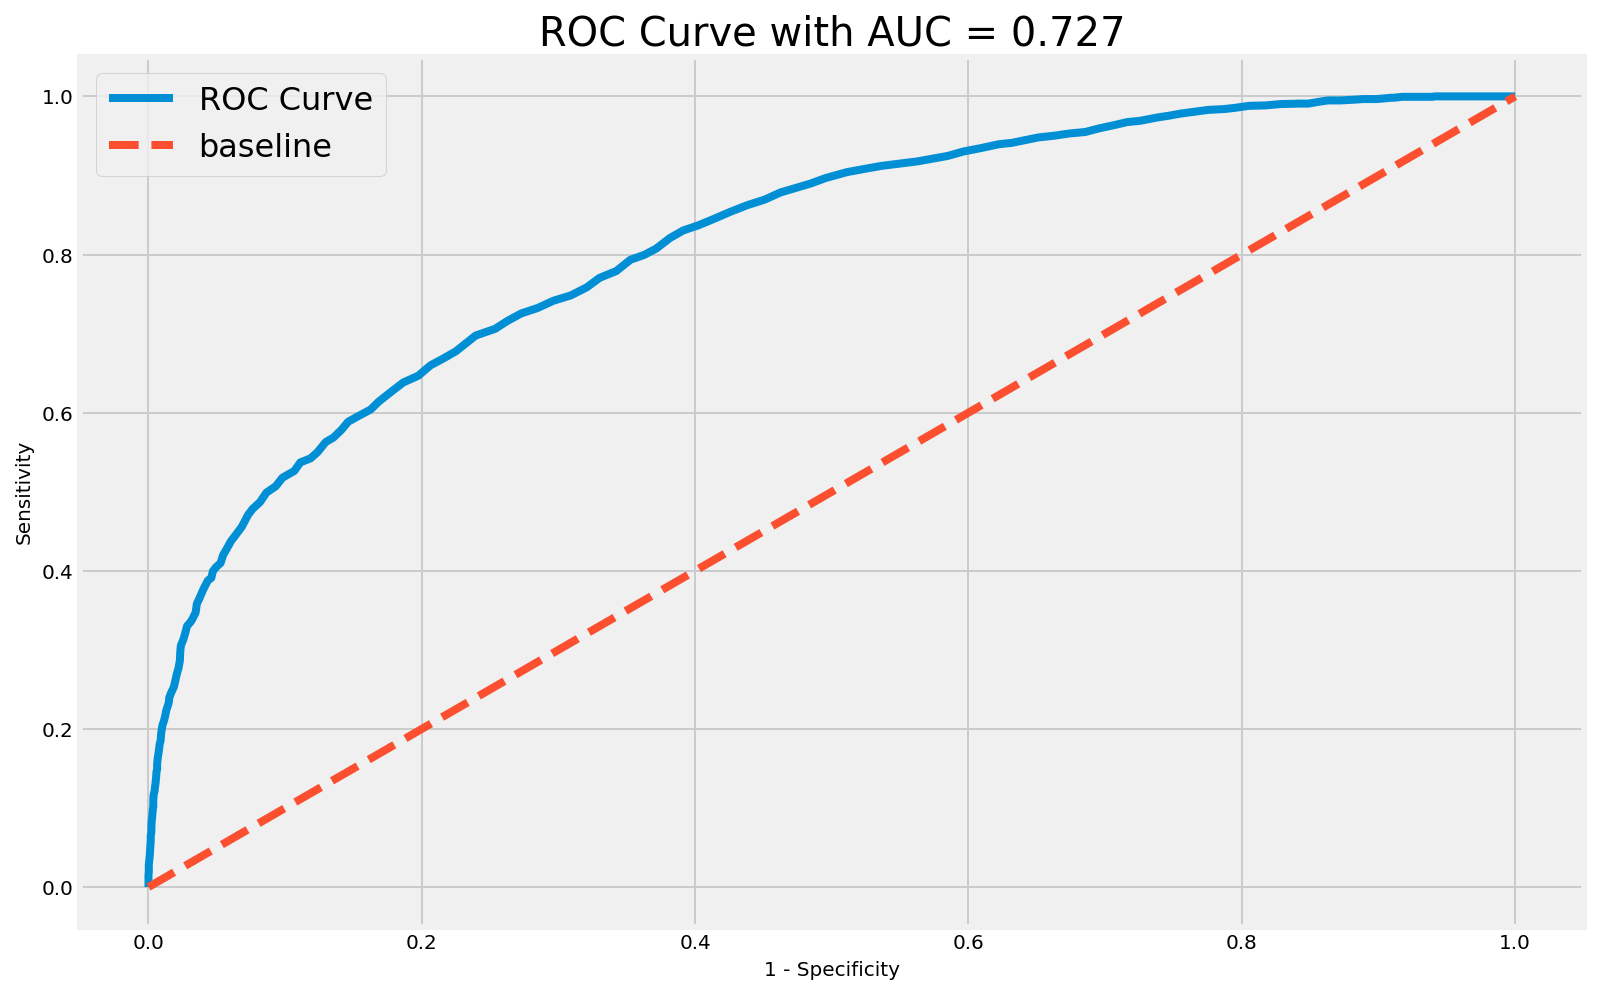

In [25]:
plot_roc_auc(df=df_results_01, y_true="y_unseen", y_proba="mean_proba", y_pred="y_pred",
             save_path="../assets/model_01_roc.png")

#### Performance Summary

|Model|Optimised on|ROC-AUC|Accuracy|Recall|Specificity|Precision|F-1 Score|
|---|---|---|---|---|---|---|---|
|baseline*|-|-|0.709|-|-|-|-|
|NLP_01|ROC-AUC|0.713|0.716|0.706|0.721|0.509|0.592|
|nNLP_01|ROC-AUC|0.657|0.672|0.622|0.692|0.454|0.524|
|Hybrid_01|ROC-AUC|0.727|0.734|0.711|0.743|0.532|0.609|

<p style='text-align: right;'><sub>*baseline accuracy by predicting all negative/unpopular</sub></p>


Recall measures the ratio of the popular (positive class) data points that the model has predicted correctly. A recall score of 0.706 means that of the popular posts, the model is misclassifying and missing out on about 29.4% of them (false negatives).

Precision, on the other hand, measures the accuracy of the model's positive predictions. A precision score of 0.509 means that the model is misclassifying 49.1% of its positive predictions, which also means that about half of its positive predictions turned out to be not popular (false positive).

Research tells us that there is a recall-precision trade-off - we cannot have our cake and eat it too.

So we must decide, which scenario is worse?

>Opportunity cost of missing out on popular ideas, or wasting resources pursuing an unpopular idea?

Upon giving it further thought, we return to our basic motivation for this project. This model was built to provide actionable insights for STB to plan out the next phase of their campaign in promoting domestic tourism. After all, this problem only came to the fore because the tourism industry is in crisis. In such an economic climate, it would be best to build a more conservative model and optimise for precision over recall. This way, we can be more certain in our proposals and minimise the risk of wasting resources on campaigns with low value-add.

It is interesting to note that our hybrid model was able to out-perform on all fronts for all metrics over either of the NLP or non-NLP model taken singly. This suggests that there each model has learnt something important about predicting the popularity of ideas and has something to contribute to the hybrid model, that when taken together by aggregating each respective prediction probabilities is able to give us stronger predictions.

However, can we do better? After coming to the conclusion that we should have a more conservative predictive model, let us build a new model and optimise Model_02 for **F-1 score**. By grid searching and optimising for F-1 score, we expect to maximise both precision and recall without losing one at the expense of the other.
<br>
<br>
<br>
<center>* * * <sup>End Model_01</sup> * * *</center>

### Re-Tune NLP Model

Let us jump ahead and use our tree-based XGBoost model since it has consistently been our best-performing model. Only difference is that this time we will select our best hyper-parameters based on the best F-1 score. The F-1 score is the harmonic mean of precision and recall, therefore maximising F-1 will allow us to also maximise both precision and recall.

#### XGBoost (Tree)

In [8]:
# build pipeline
pipe_xgbT = Pipeline(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                            ("xgboost", xgb.XGBClassifier(booster="gbtree",
                                                          objective="binary:logistic"))])

# set hyper params to tune
pipe_params_xgbT = {
    "tvec__max_features": [2500, 5000, 7500],
    "tvec__ngram_range": [(1,1), (1,2), (1,3)],
    "xgboost__reg_alpha": randint(0, 11),
    "xgboost__reg_lambda": randint(0, 11),
    "xgboost__gamma": [0],
    "xgboost__scale_pos_weight": [2, 2.5, 3], # xgb doc recommends sum(neg)/sum(pos) = 12_793/5257
    "xgboost__learning_rate": uniform(0, 1),
    "xgboost__max_depth": randint(2, 6),
    "xgboost__min_child_weight": randint(0, 5),
    "xgboost__subsample": uniform(0.5, 0.5),
    "xgboost__colsample_bytree": [0.8, 0.9, 1]
}

In [9]:
%%time
np.random.seed(42)
rs_xgbT_nlp_f1 = RandomizedSearchCV(estimator=pipe_xgbT, param_distributions=pipe_params_xgbT,
                                    n_iter=100, cv=4, scoring="f1")
rs_xgbT_nlp_f1.fit(X_nlp_train, y_train)
print("Best score in Randomised Search:", rs_xgbT_nlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
rs_xgbT_nlp_f1.best_params_

Best score in Randomised Search: 0.579334783704286

Using the following hyper-parameters:
Wall time: 47min 15s


{'tvec__max_features': 7500,
 'tvec__ngram_range': (1, 2),
 'xgboost__colsample_bytree': 1,
 'xgboost__gamma': 0,
 'xgboost__learning_rate': 0.38246199126716274,
 'xgboost__max_depth': 5,
 'xgboost__min_child_weight': 0,
 'xgboost__reg_alpha': 2,
 'xgboost__reg_lambda': 4,
 'xgboost__scale_pos_weight': 3,
 'xgboost__subsample': 0.8401537692938899}

#### Evaluate Hyper-Parameters

In [10]:
df_rs_xgbT_nlp_f1 = pd.DataFrame(rs_xgbT_nlp_f1.cv_results_)
df_rs_xgbT_nlp_f1.to_csv("../datasets/df_rs_xgbT_nlp_f1.csv", index=False) # save out df of randomized search
df_rs_xgbT_nlp_f1.info() # notice certain cols that are numeric are not numeric

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   mean_fit_time                    100 non-null    float64
 1   std_fit_time                     100 non-null    float64
 2   mean_score_time                  100 non-null    float64
 3   std_score_time                   100 non-null    float64
 4   param_tvec__max_features         100 non-null    object 
 5   param_tvec__ngram_range          100 non-null    object 
 6   param_xgboost__colsample_bytree  100 non-null    object 
 7   param_xgboost__gamma             100 non-null    object 
 8   param_xgboost__learning_rate     100 non-null    object 
 9   param_xgboost__max_depth         100 non-null    object 
 10  param_xgboost__min_child_weight  100 non-null    object 
 11  param_xgboost__reg_alpha         100 non-null    object 
 12  param_xgboost__reg_lamb

In [11]:
# re-import df
df_rs_xgbT_nlp_f1 = pd.read_csv("../datasets/df_rs_xgbT_nlp_f1.csv")
df_rs_xgbT_nlp_f1.head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       4.819913      0.101792         0.475373        0.023359   
1       6.210683      0.055434         0.467858        0.017928   
2       5.832446      0.025294         0.721265        0.049610   

   param_tvec__max_features param_tvec__ngram_range  \
0                      7500                  (1, 1)   
1                      7500                  (1, 1)   
2                      5000                  (1, 2)   

   param_xgboost__colsample_bytree  param_xgboost__gamma  \
0                              1.0                     0   
1                              1.0                     0   
2                              0.8                     0   

   param_xgboost__learning_rate  param_xgboost__max_depth  ...  \
0                      0.731994                         2  ...   
1                      0.020584                         3  ...   
2                      0.431945                         2  ...   

   param_xgboost__scale_pos_weight  param_xgboost__subsample  \
0                              3.0                  0.549987   
1                              2.0                  0.808741   
2                              3.0                  0.728035   

                                              params  split0_test_score  \
0  {'tvec__max_features': 7500, 'tvec__ngram_rang...           0.550493   
1  {'tvec__max_features': 7500, 'tvec__ngram_rang...           0.421836   
2  {'tvec__max_features': 5000, 'tvec__ngram_rang...           0.550651   

   split1_test_score split2_test_score  split3_test_score  mean_test_score  \
0           0.551702          0.558382           0.560258         0.555209   
1           0.414189          0.406691           0.432212         0.418732   
2           0.559223          0.571807           0.558862         0.560136   

   std_test_score  rank_test_score  
0        0.004187               67  
1        0.009447               99  
2        0.007560               52  

[3 rows x 23 columns]

In [13]:
# convert all cols that can be numeric into numeric dtypes
df_rs_xgbT_nlp_f1["param_tvec__max_features"] = df_rs_xgbT_nlp_f1["param_tvec__max_features"].astype(int)
df_rs_xgbT_nlp_f1["param_xgboost__colsample_bytree"] = df_rs_xgbT_nlp_f1["param_xgboost__colsample_bytree"].astype(float)
df_rs_xgbT_nlp_f1["param_xgboost__gamma"] = df_rs_xgbT_nlp_f1["param_xgboost__gamma"].astype(float)
df_rs_xgbT_nlp_f1["param_xgboost__learning_rate"] = df_rs_xgbT_nlp_f1["param_xgboost__learning_rate"].astype(float)
df_rs_xgbT_nlp_f1["param_xgboost__max_depth"] = df_rs_xgbT_nlp_f1["param_xgboost__max_depth"].astype(int)
df_rs_xgbT_nlp_f1["param_xgboost__min_child_weight"] = df_rs_xgbT_nlp_f1["param_xgboost__min_child_weight"].astype(int)
df_rs_xgbT_nlp_f1["param_xgboost__reg_alpha"] = df_rs_xgbT_nlp_f1["param_xgboost__reg_alpha"].astype(int)
df_rs_xgbT_nlp_f1["param_xgboost__reg_lambda"] = df_rs_xgbT_nlp_f1["param_xgboost__reg_lambda"].astype(int)
df_rs_xgbT_nlp_f1["param_xgboost__scale_pos_weight"] = df_rs_xgbT_nlp_f1["param_xgboost__scale_pos_weight"].astype(float)
df_rs_xgbT_nlp_f1["param_xgboost__subsample"] = df_rs_xgbT_nlp_f1["param_xgboost__subsample"].astype(float)
df_rs_xgbT_nlp_f1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   mean_fit_time                    100 non-null    float64
 1   std_fit_time                     100 non-null    float64
 2   mean_score_time                  100 non-null    float64
 3   std_score_time                   100 non-null    float64
 4   param_tvec__max_features         100 non-null    int32  
 5   param_tvec__ngram_range          100 non-null    object 
 6   param_xgboost__colsample_bytree  100 non-null    float64
 7   param_xgboost__gamma             100 non-null    float64
 8   param_xgboost__learning_rate     100 non-null    float64
 9   param_xgboost__max_depth         100 non-null    int32  
 10  param_xgboost__min_child_weight  100 non-null    int32  
 11  param_xgboost__reg_alpha         100 non-null    int32  
 12  param_xgboost__reg_lamb

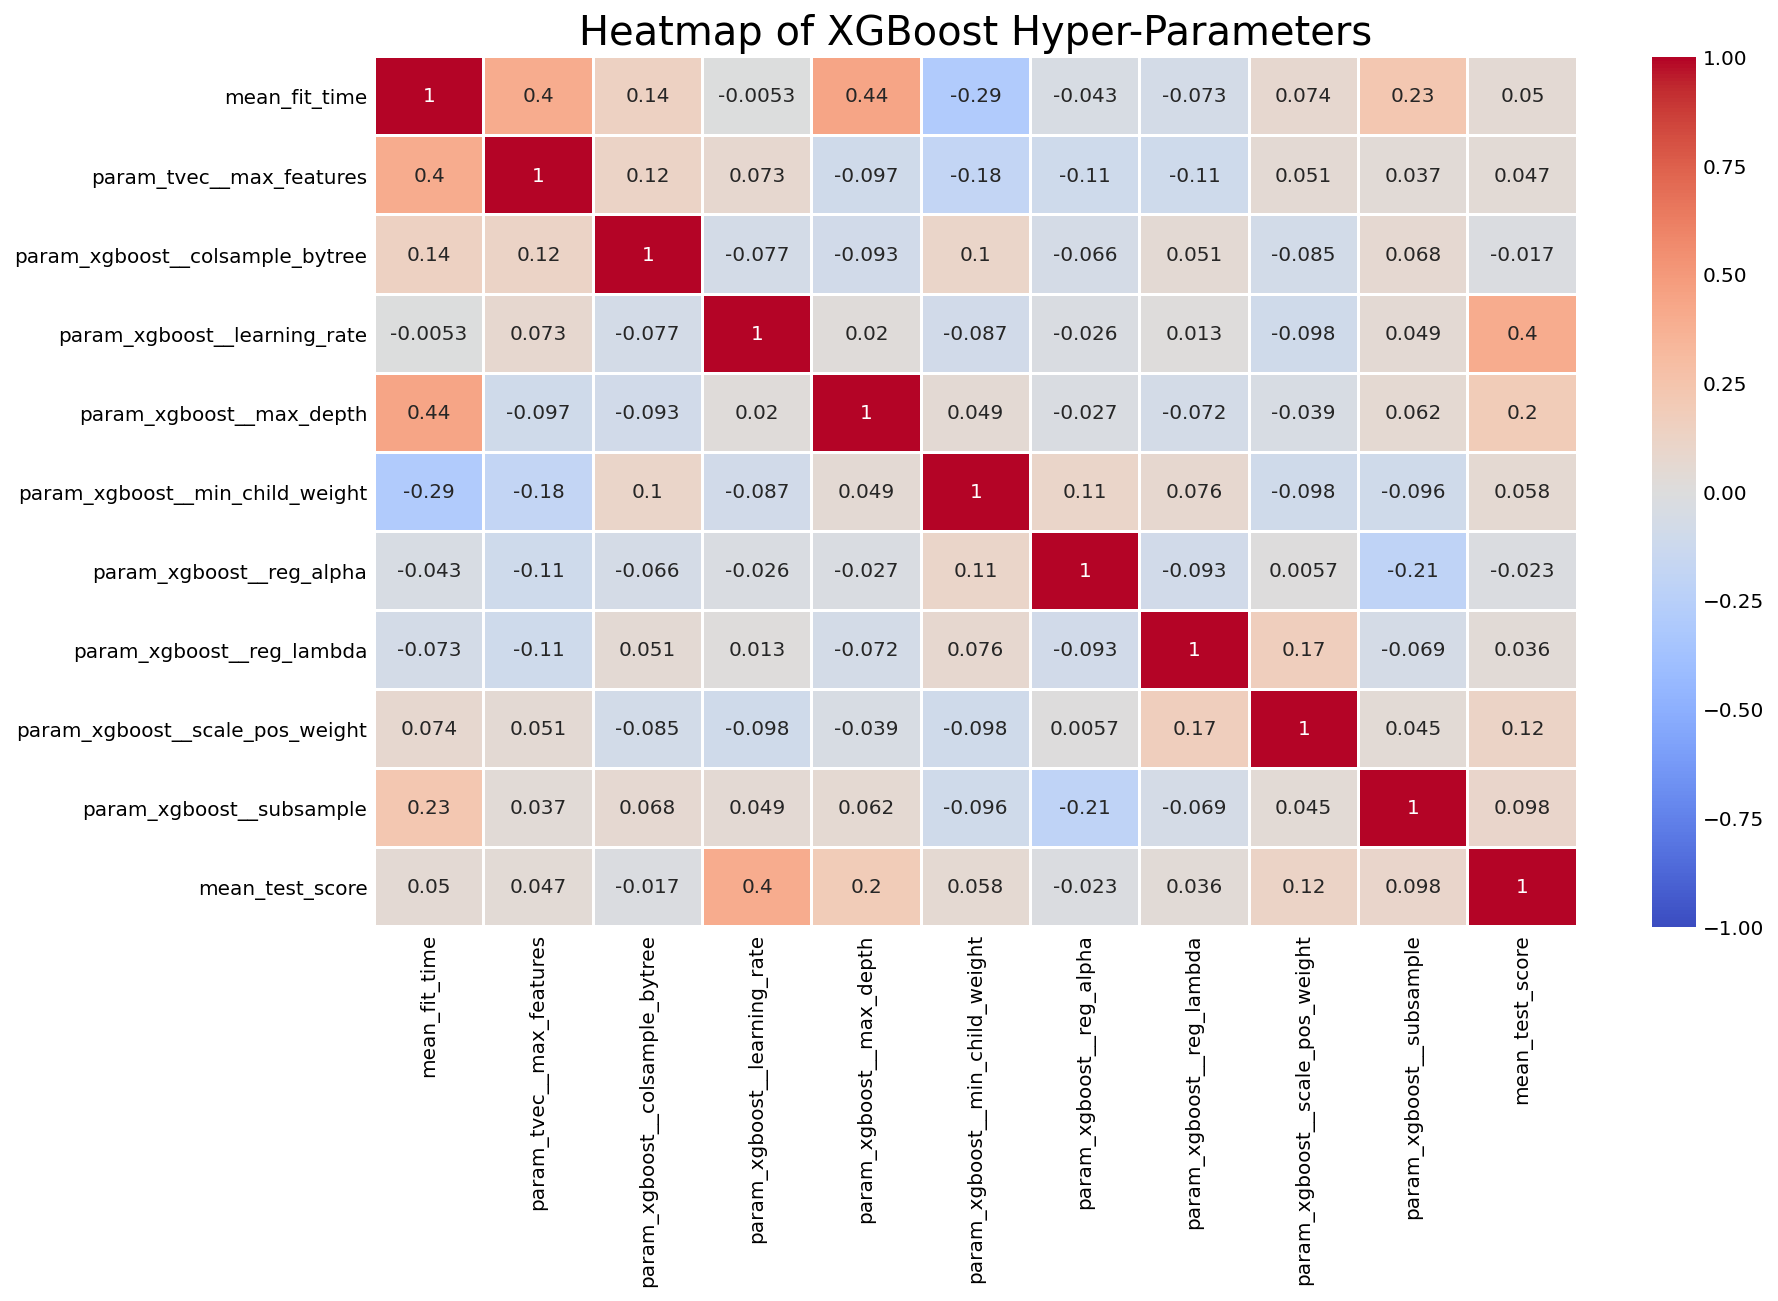

In [15]:
plt.figure(figsize=[12,8])
plt.title("Heatmap of XGBoost Hyper-Parameters", size=20)
include = ["mean_fit_time", "param_tvec__max_features", "param_tvec__ngram_range", "param_xgboost__colsample_bytree",
           "param_xgboost__learning_rate", "param_xgboost__max_depth", "param_xgboost__min_child_weight",
           "param_xgboost__reg_alpha", "param_xgboost__reg_lambda", "param_xgboost__scale_pos_weight",
           "param_xgboost__subsample", "mean_test_score"]
sns.heatmap(df_rs_xgbT_nlp_f1[include].corr(), annot=True, linewidths=1, vmin=-1, vmax=1, cmap="coolwarm")
plt.savefig("../assets/hparams_xgbT_nlp_f1_heatmap.png", transparent=True, bbox_inches='tight')
plt.show()

By following the `mean_test_score` row, we can trace the CV score correlation to the hyper-parameters. Our top hyper-parameter most correlated with `mean_test_score` is XGBoost's `learning_rate` at +0.40. Coming in second is `max_depth` at +0.20.

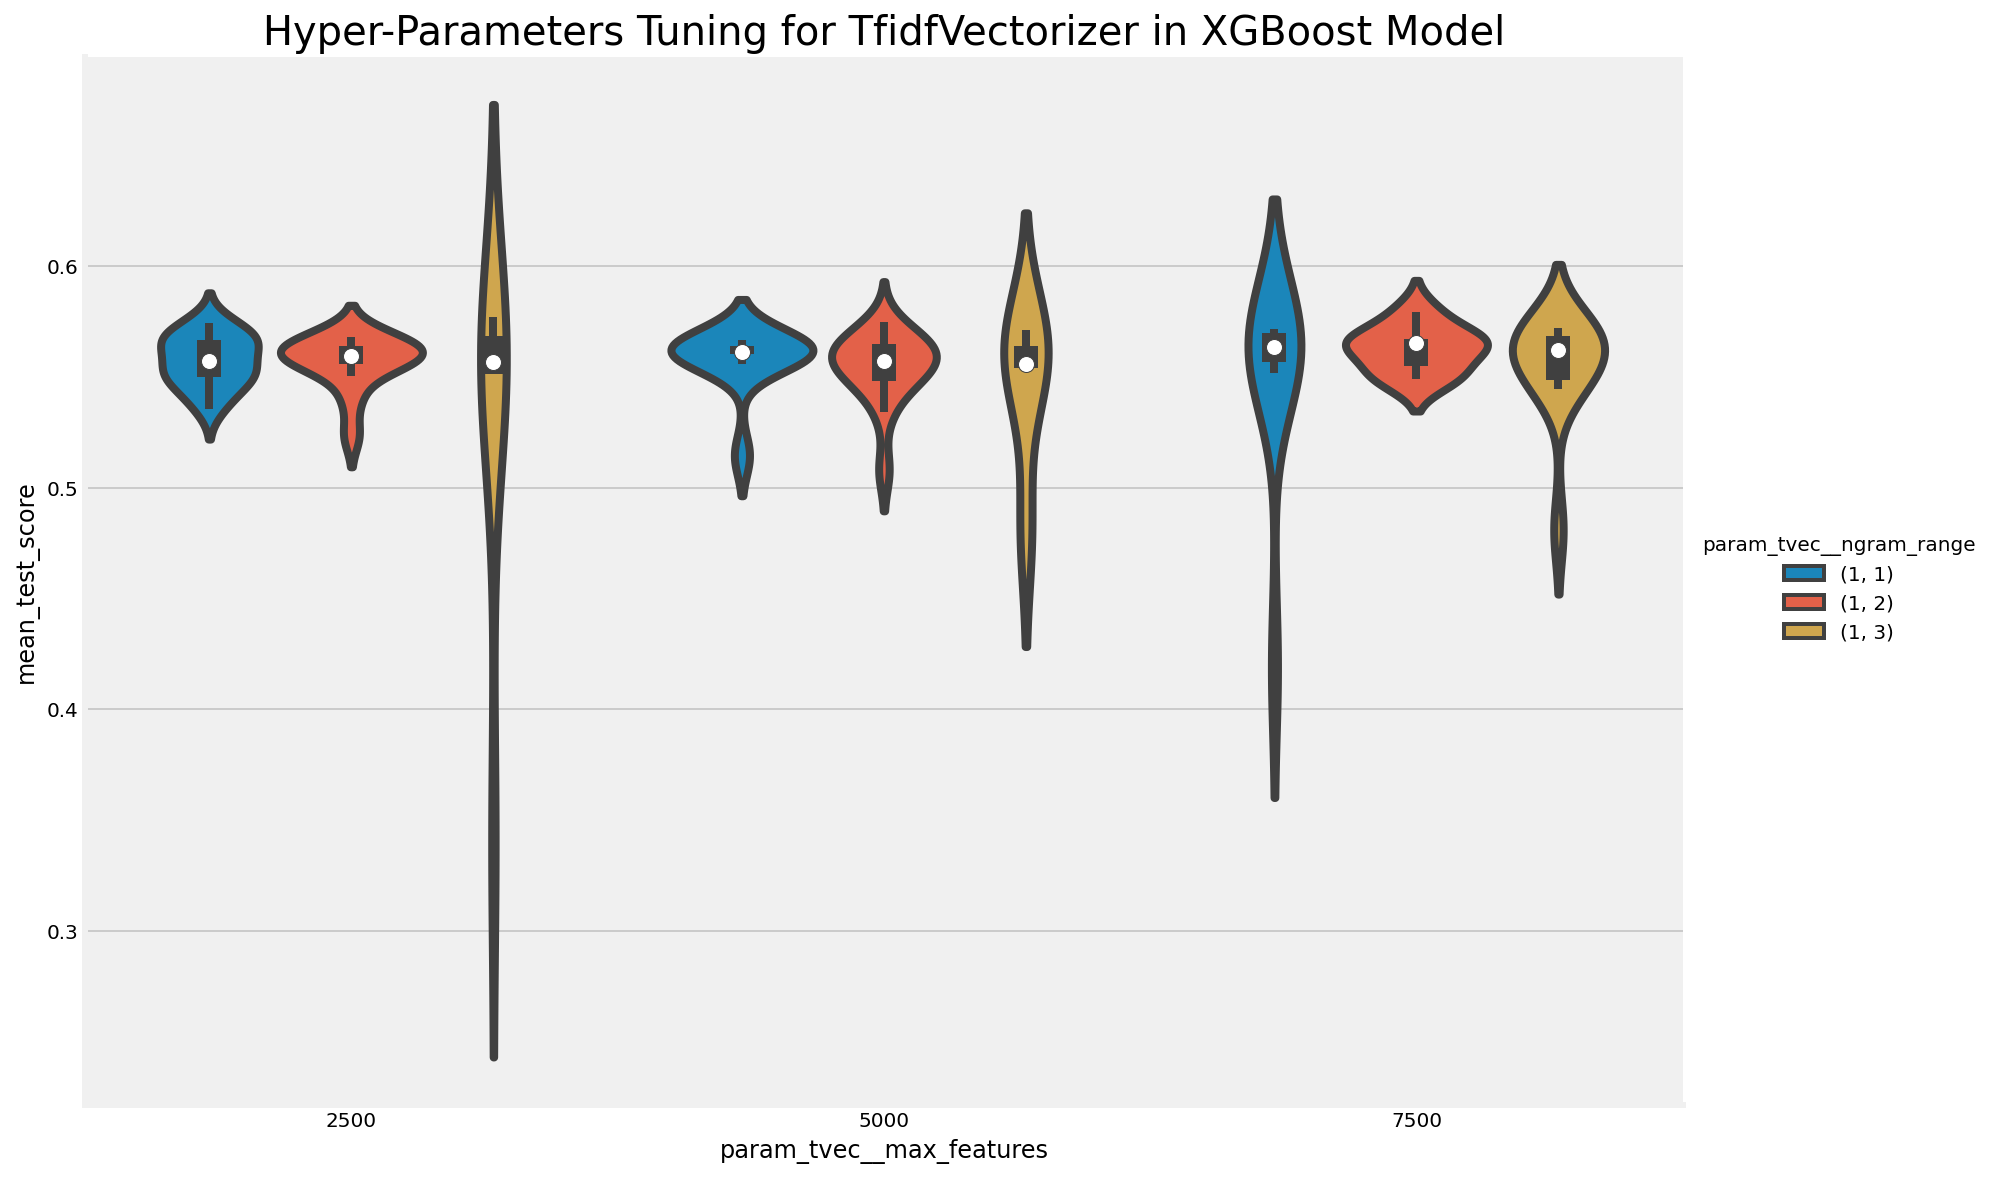

In [17]:
sns.catplot(data=df_rs_xgbT_nlp_f1,
            x='param_tvec__max_features',
            y='mean_test_score',
            hue='param_tvec__ngram_range',
            height=8, aspect=1.5, kind="violin")
plt.gcf()
plt.title("Hyper-Parameters Tuning for TfidfVectorizer in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nlp_f1_tvec.png", transparent=True, bbox_inches='tight')
plt.show()

Unlike our previous optimisation on ROC-AUC scores, the pattern appears to be reversed for our `TfidfVectorizer` hyper-parameters when scored on F-1 (precision and recall). As our vectorizer's `max_features` increases and our model train on more words, variance decreases. It also appears that greater `ngram_range` often result in greater variance. Other than that, there is no clear pattern relative to the CV scores as the mean scores all approximate to about the same.

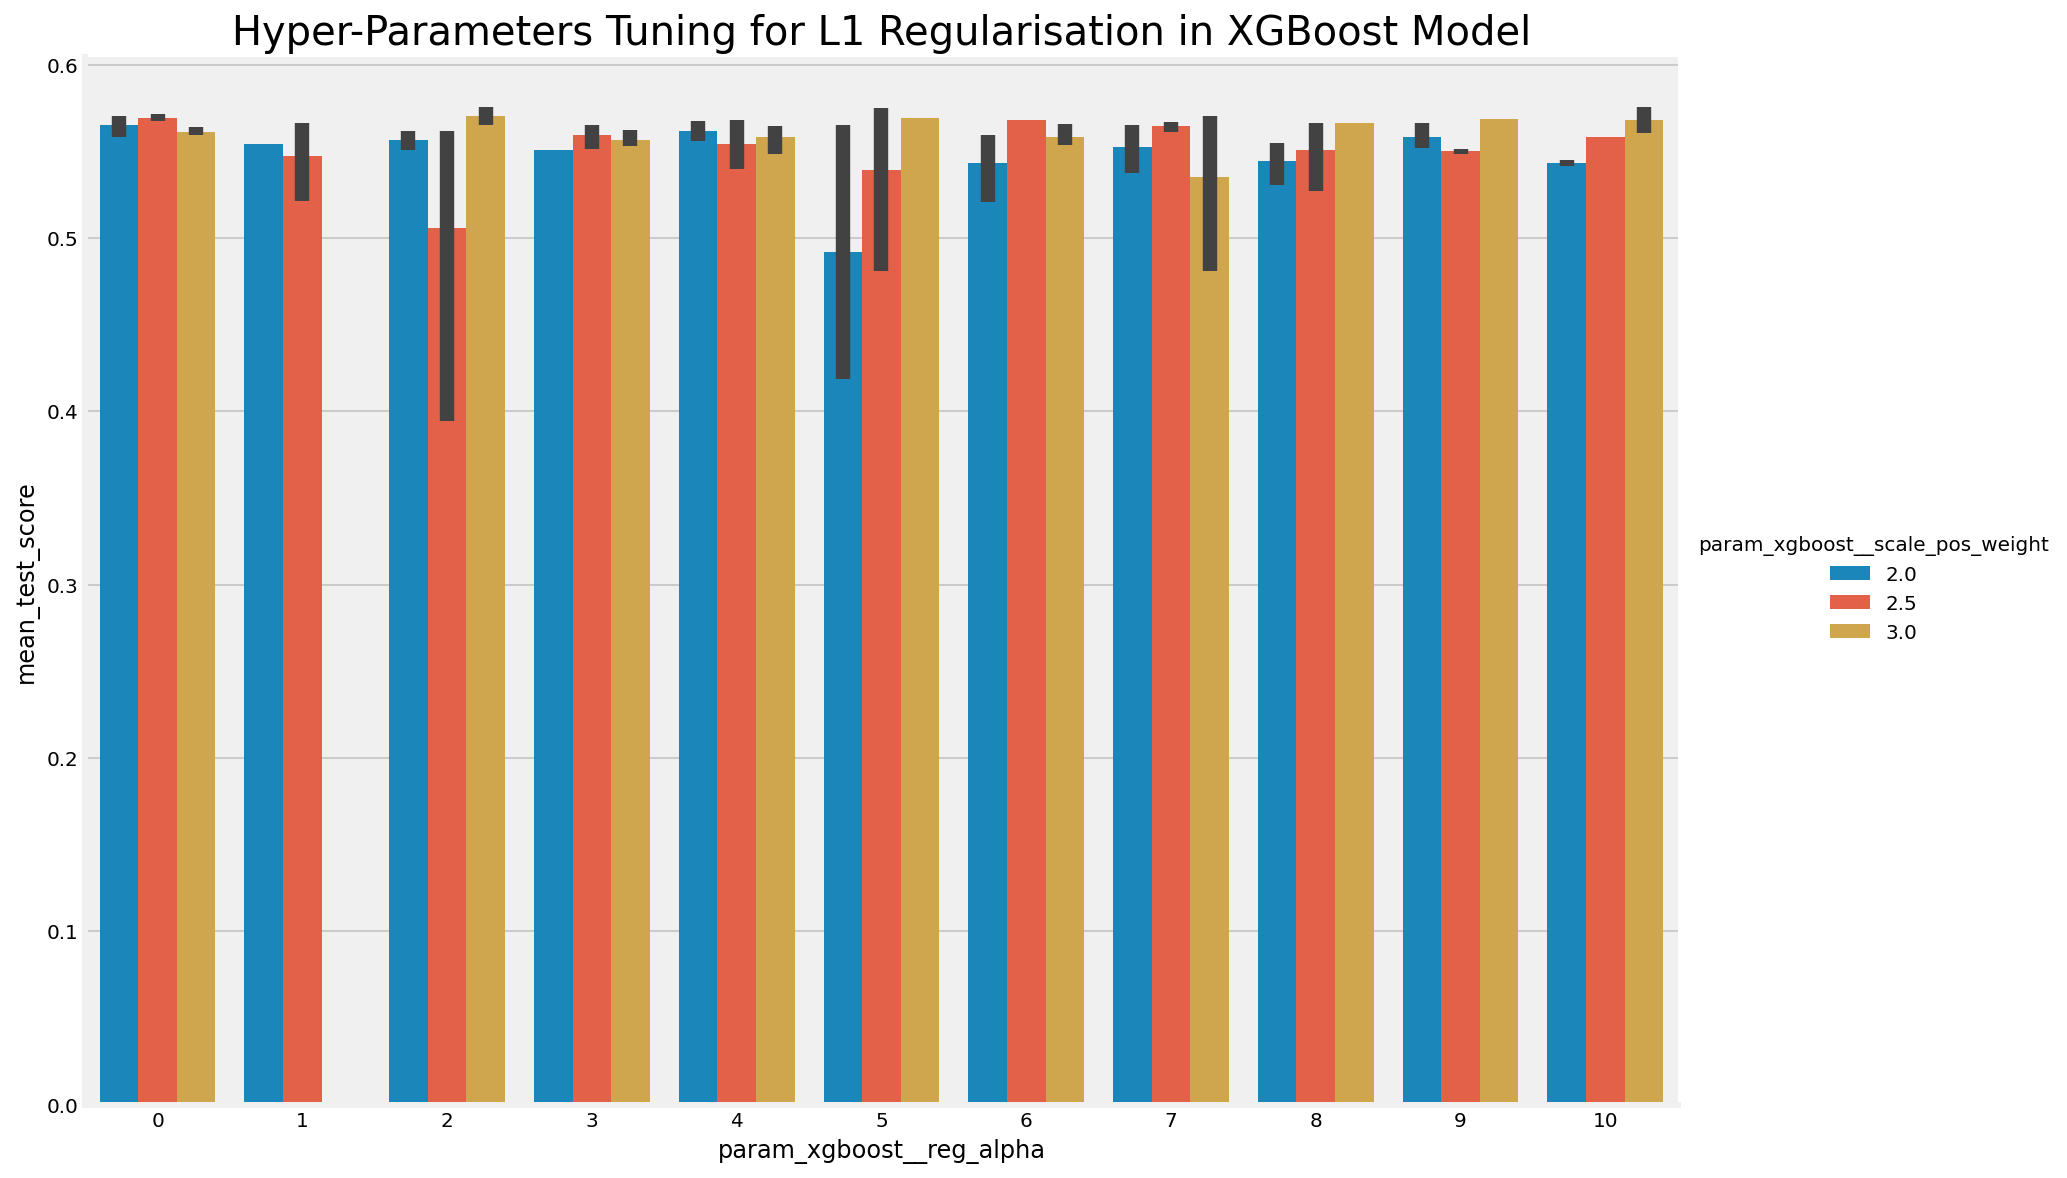

In [20]:
sns.catplot(data=df_rs_xgbT_nlp_f1,
            x='param_xgboost__reg_alpha',
            y='mean_test_score',
            hue='param_xgboost__scale_pos_weight',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning for L1 Regularisation in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nlp_f1_alpha.png", transparent=True, bbox_inches='tight')
plt.show()

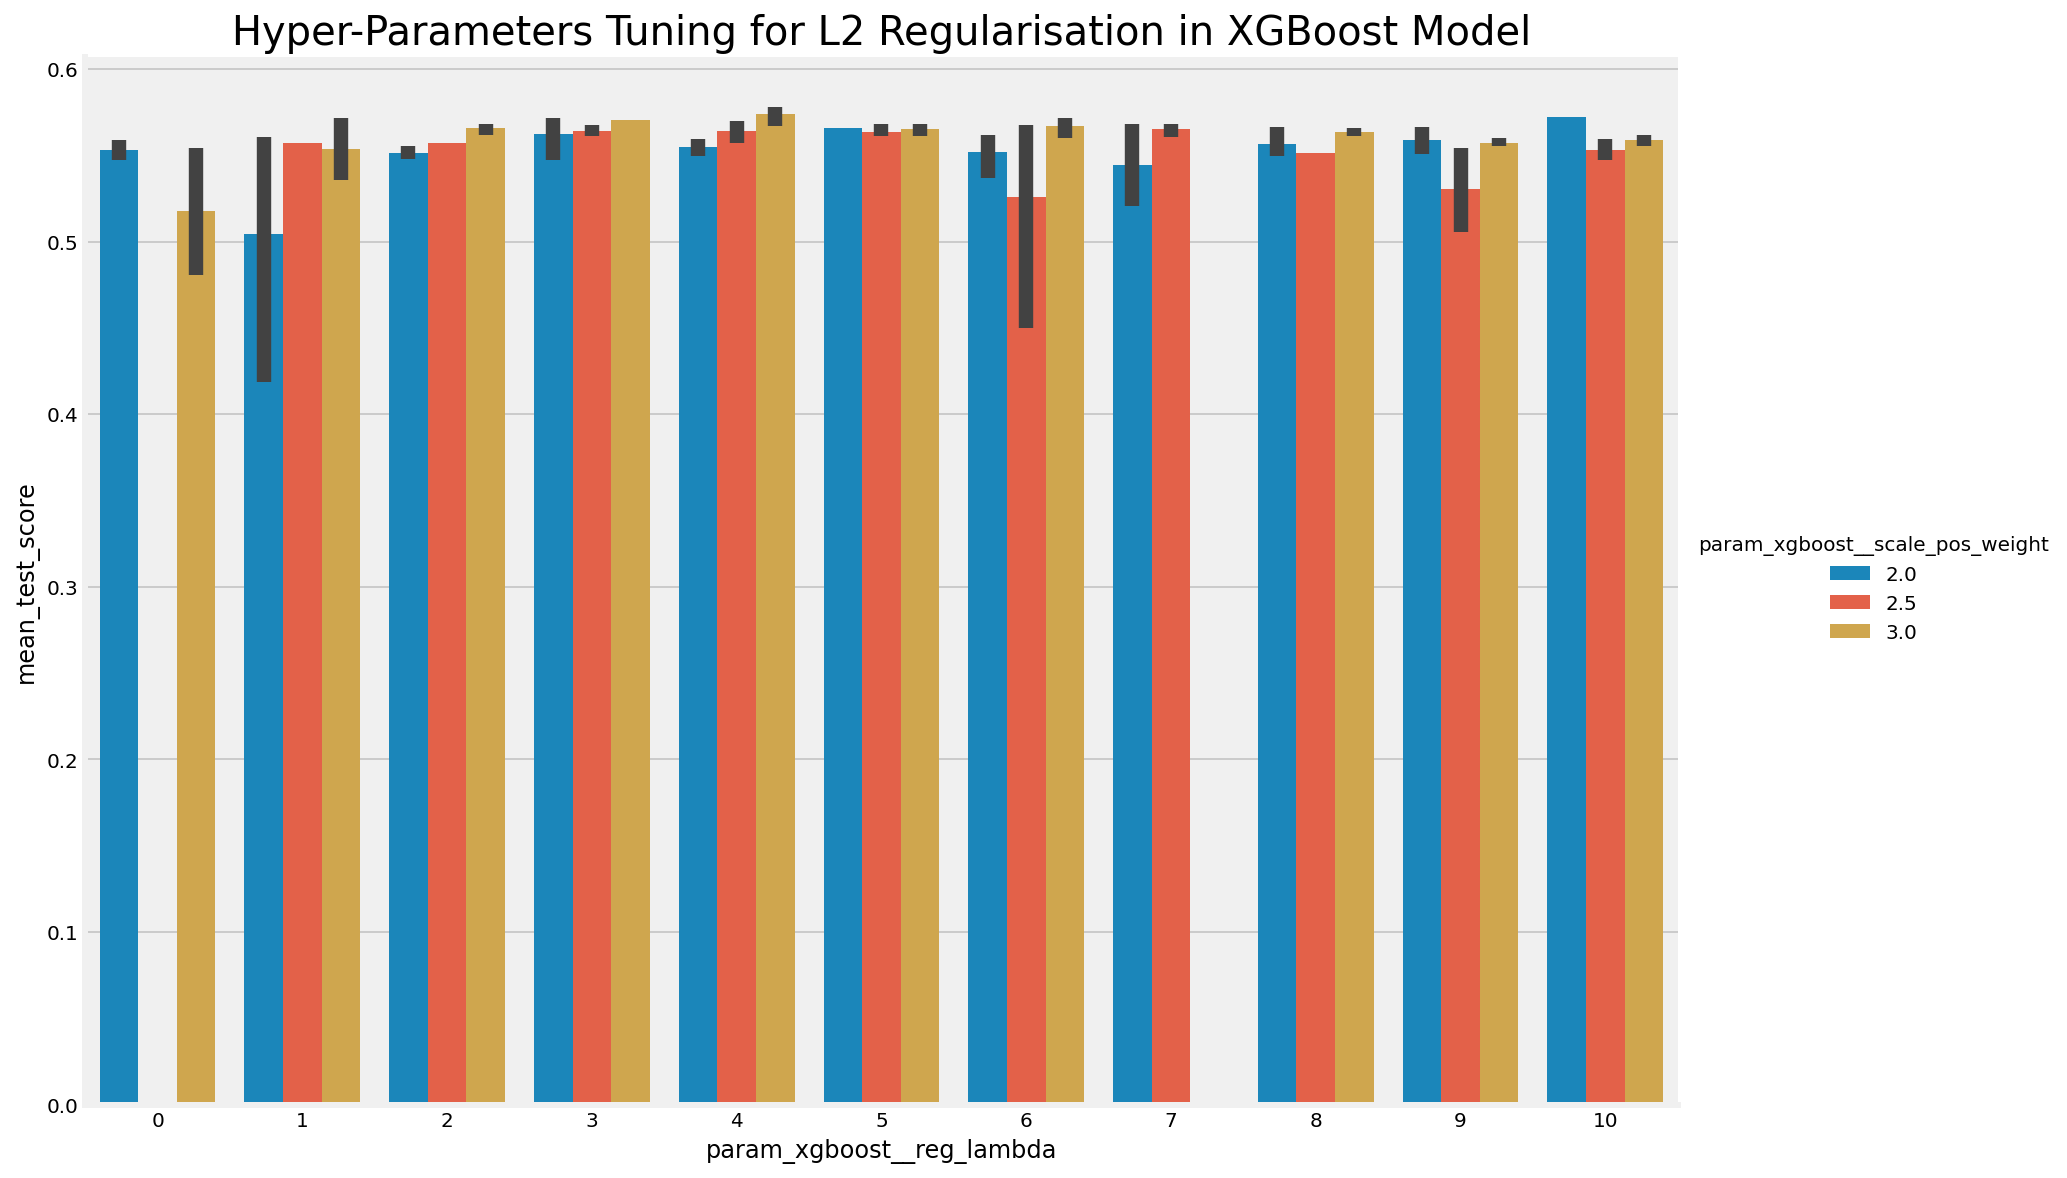

In [21]:
sns.catplot(data=df_rs_xgbT_nlp_f1,
            x='param_xgboost__reg_lambda',
            y='mean_test_score',
            hue='param_xgboost__scale_pos_weight',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning for L2 Regularisation in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nlp_f1_lambda.png", transparent=True, bbox_inches='tight')
plt.show()

No clear trend can observed for both L1 `reg_alpha` and L2 `reg_lambda` regularisation, even when grouped by `scale_pos_weight`.

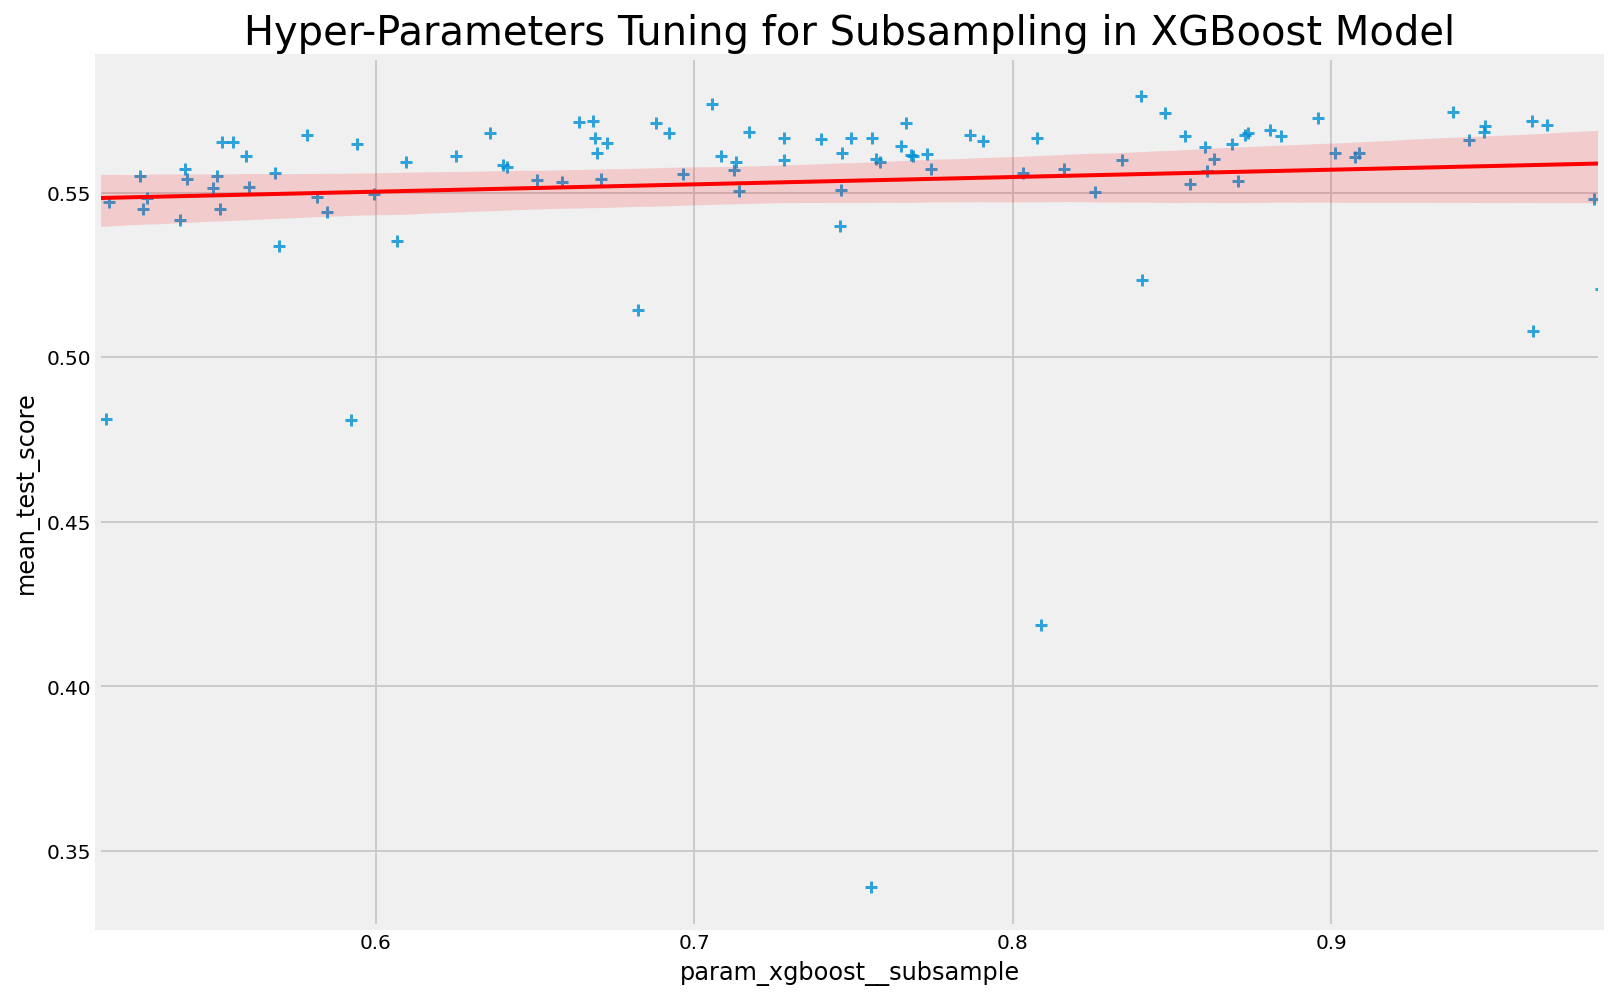

In [24]:
plt.figure(figsize=[12,8])
plt.title("Hyper-Parameters Tuning for Subsampling in XGBoost Model", size=20)
sns.regplot(data=df_rs_xgbT_nlp_f1,
            x='param_xgboost__subsample',
            y='mean_test_score',
            marker="+", scatter_kws={"lw": 1.5},
            line_kws={"lw": 2, "color": "r"})
plt.savefig("../assets/hparams_xgbT_nlp_f1_subsample.png", transparent=True, bbox_inches='tight')
plt.show()

The parameter `subsample` is positively correlated with the CV scores. As subsampling size increases, CV score increases. Subsampling is a technique used to tamper the learning of over-fitting models by sampling a random subset of our data points (rows) for each CV model. As our model indicates a positive relationship between `subsample` and `mean_test_score`, this means that our model is currently under-fitting. In this case, we should therefore not bother with subsampling and revert to the default `subsample` of 1 (100% of training set).

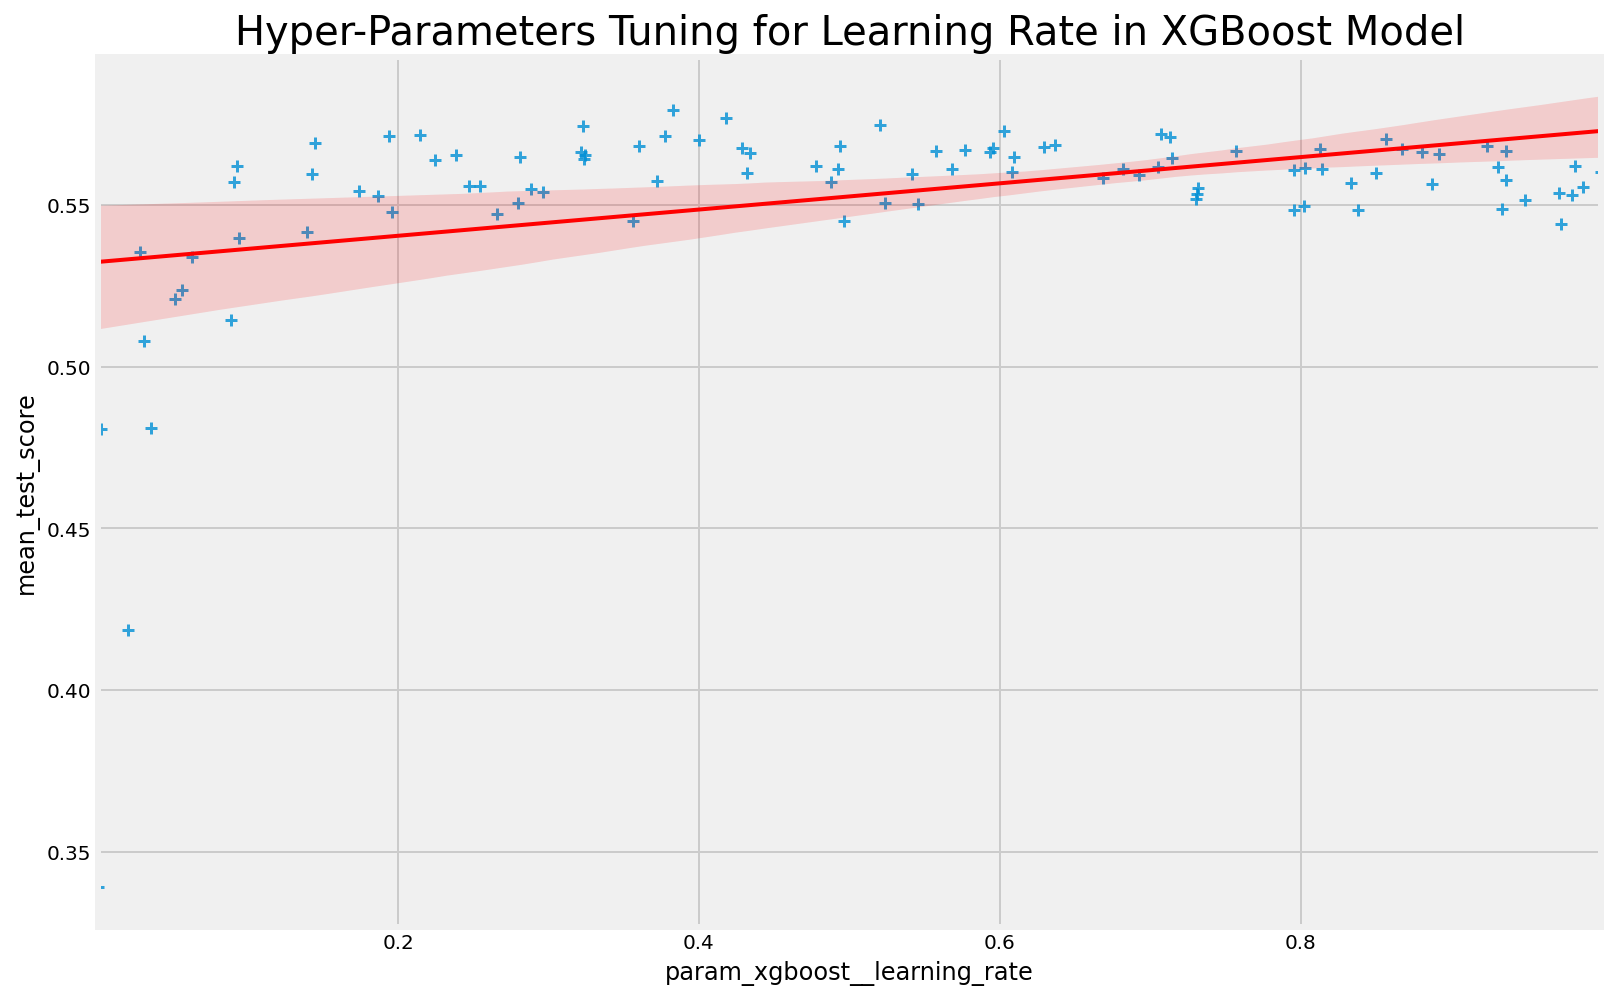

In [26]:
plt.figure(figsize=[12,8])
plt.title("Hyper-Parameters Tuning for Learning Rate in XGBoost Model", size=20)
sns.regplot(data=df_rs_xgbT_nlp_f1,
            x='param_xgboost__learning_rate',
            y='mean_test_score',
            marker="+", scatter_kws={"lw": 1.5},
            line_kws={"lw": 2, "color": "r"})
plt.savefig("../assets/hparams_xgbT_nlp_f1_learning.png", transparent=True, bbox_inches='tight')
plt.show()

The parameter `learning_rate` is likely our most impactful hyper-parameter according to the heatmap. As learning rate increases, the CV score increases, when the inverse is usually expected when trying to find the minima of the loss function. This suggests that our model has not found the minima of its loss function yet and can afford bigger steps in its gradient descent.

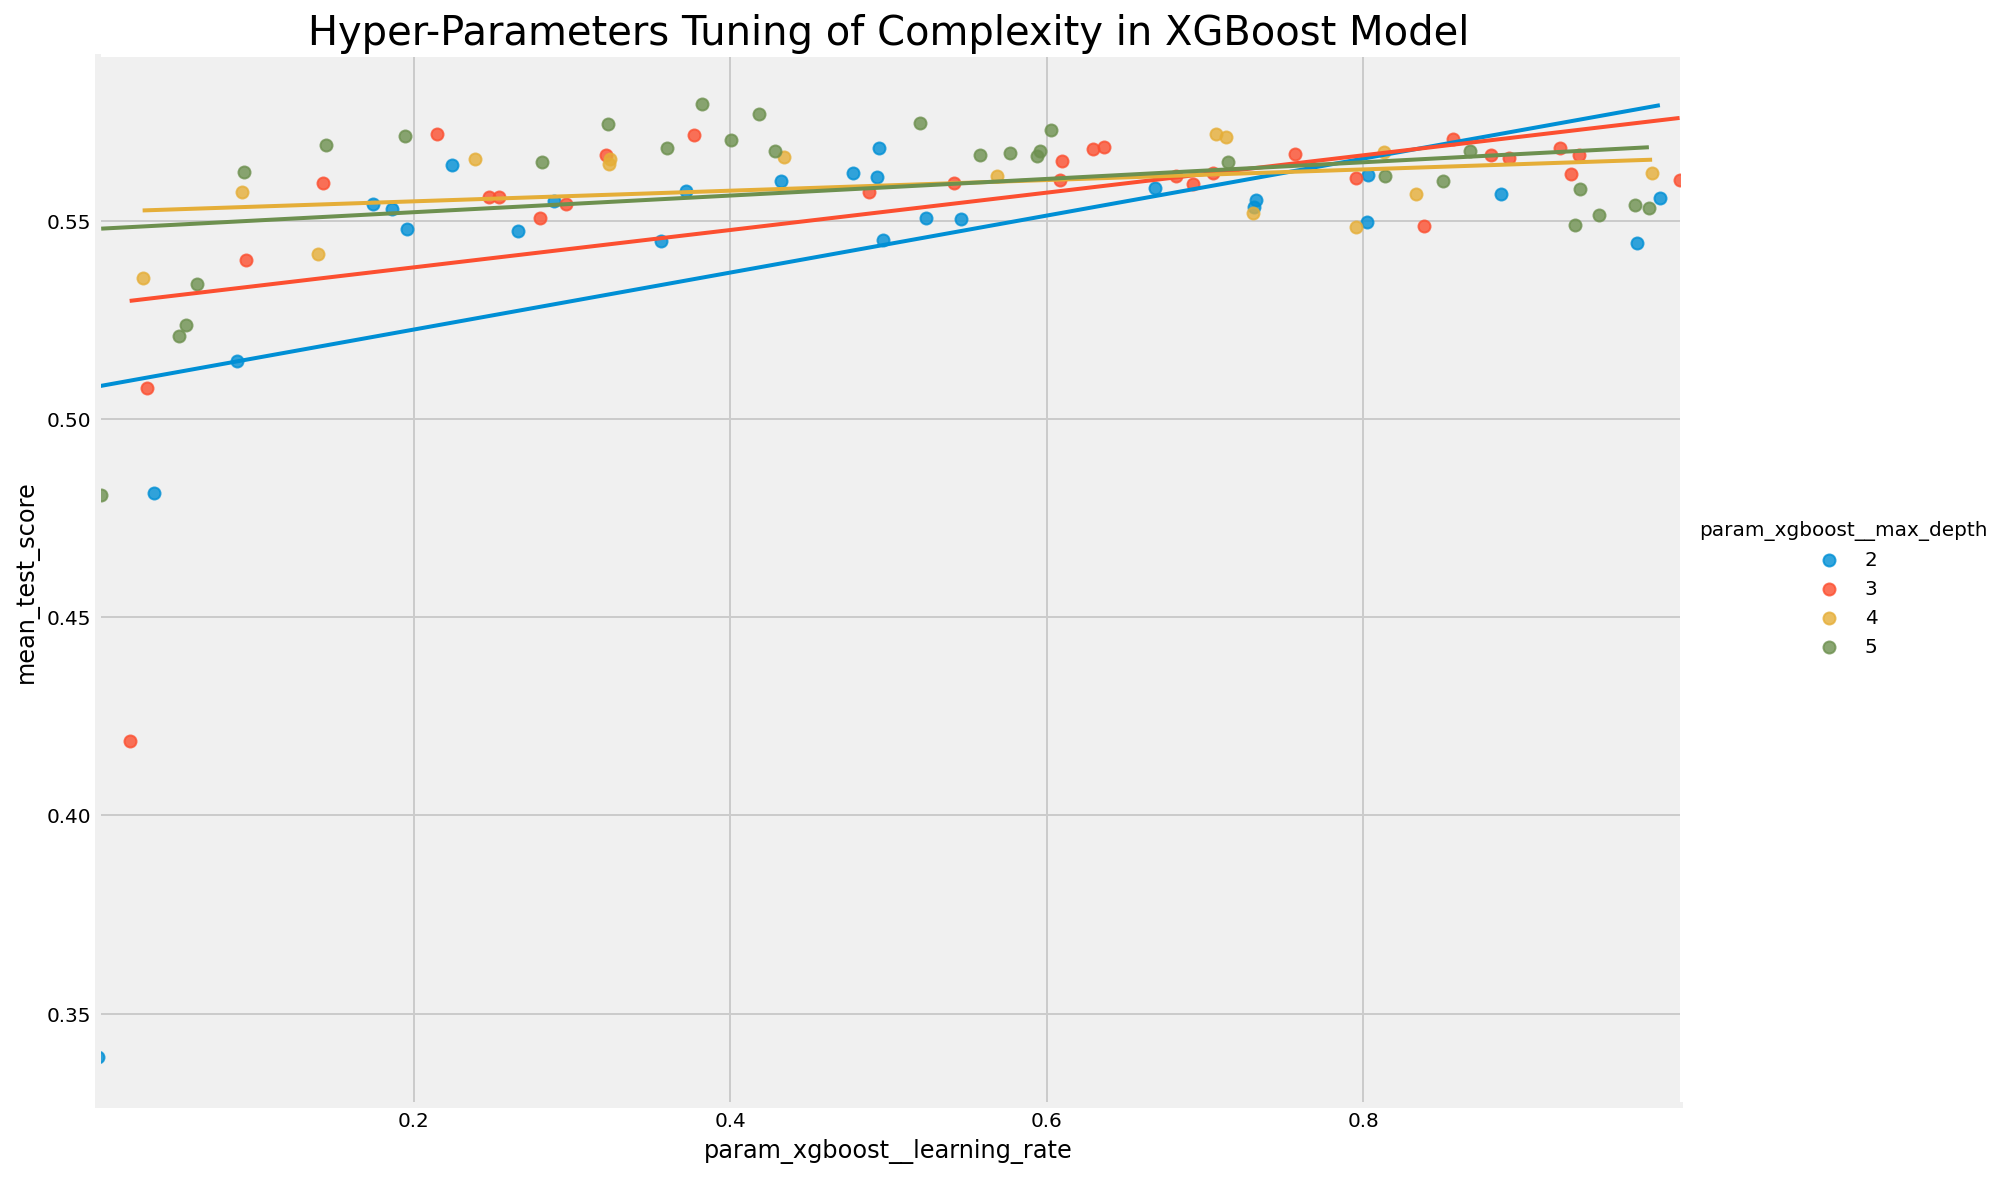

In [32]:
sns.lmplot(data=df_rs_xgbT_nlp_f1,
           x='param_xgboost__learning_rate',
           y='mean_test_score',
           hue='param_xgboost__max_depth', fit_reg=True, ci=None,
           height=8, aspect=1.5, line_kws={"lw": 2})
plt.gcf()
plt.title("Hyper-Parameters Tuning of Complexity in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nlp_f1_complex.png", transparent=True, bbox_inches='tight')
plt.show()


We can tune complexity of our model using both `max_depth` and `learning_rate`. The first allows us to control the size of each tree, the latter controls the size of each gradient descent step towards our loss minima. When we evaluate `learning_rate` against `max_depth`, it appears that a smaller tree gives us a better CV score when `learning_rate` is small, but a larger and deeper tree gives us a better CV score when `learning rate` increases past about 0.75.

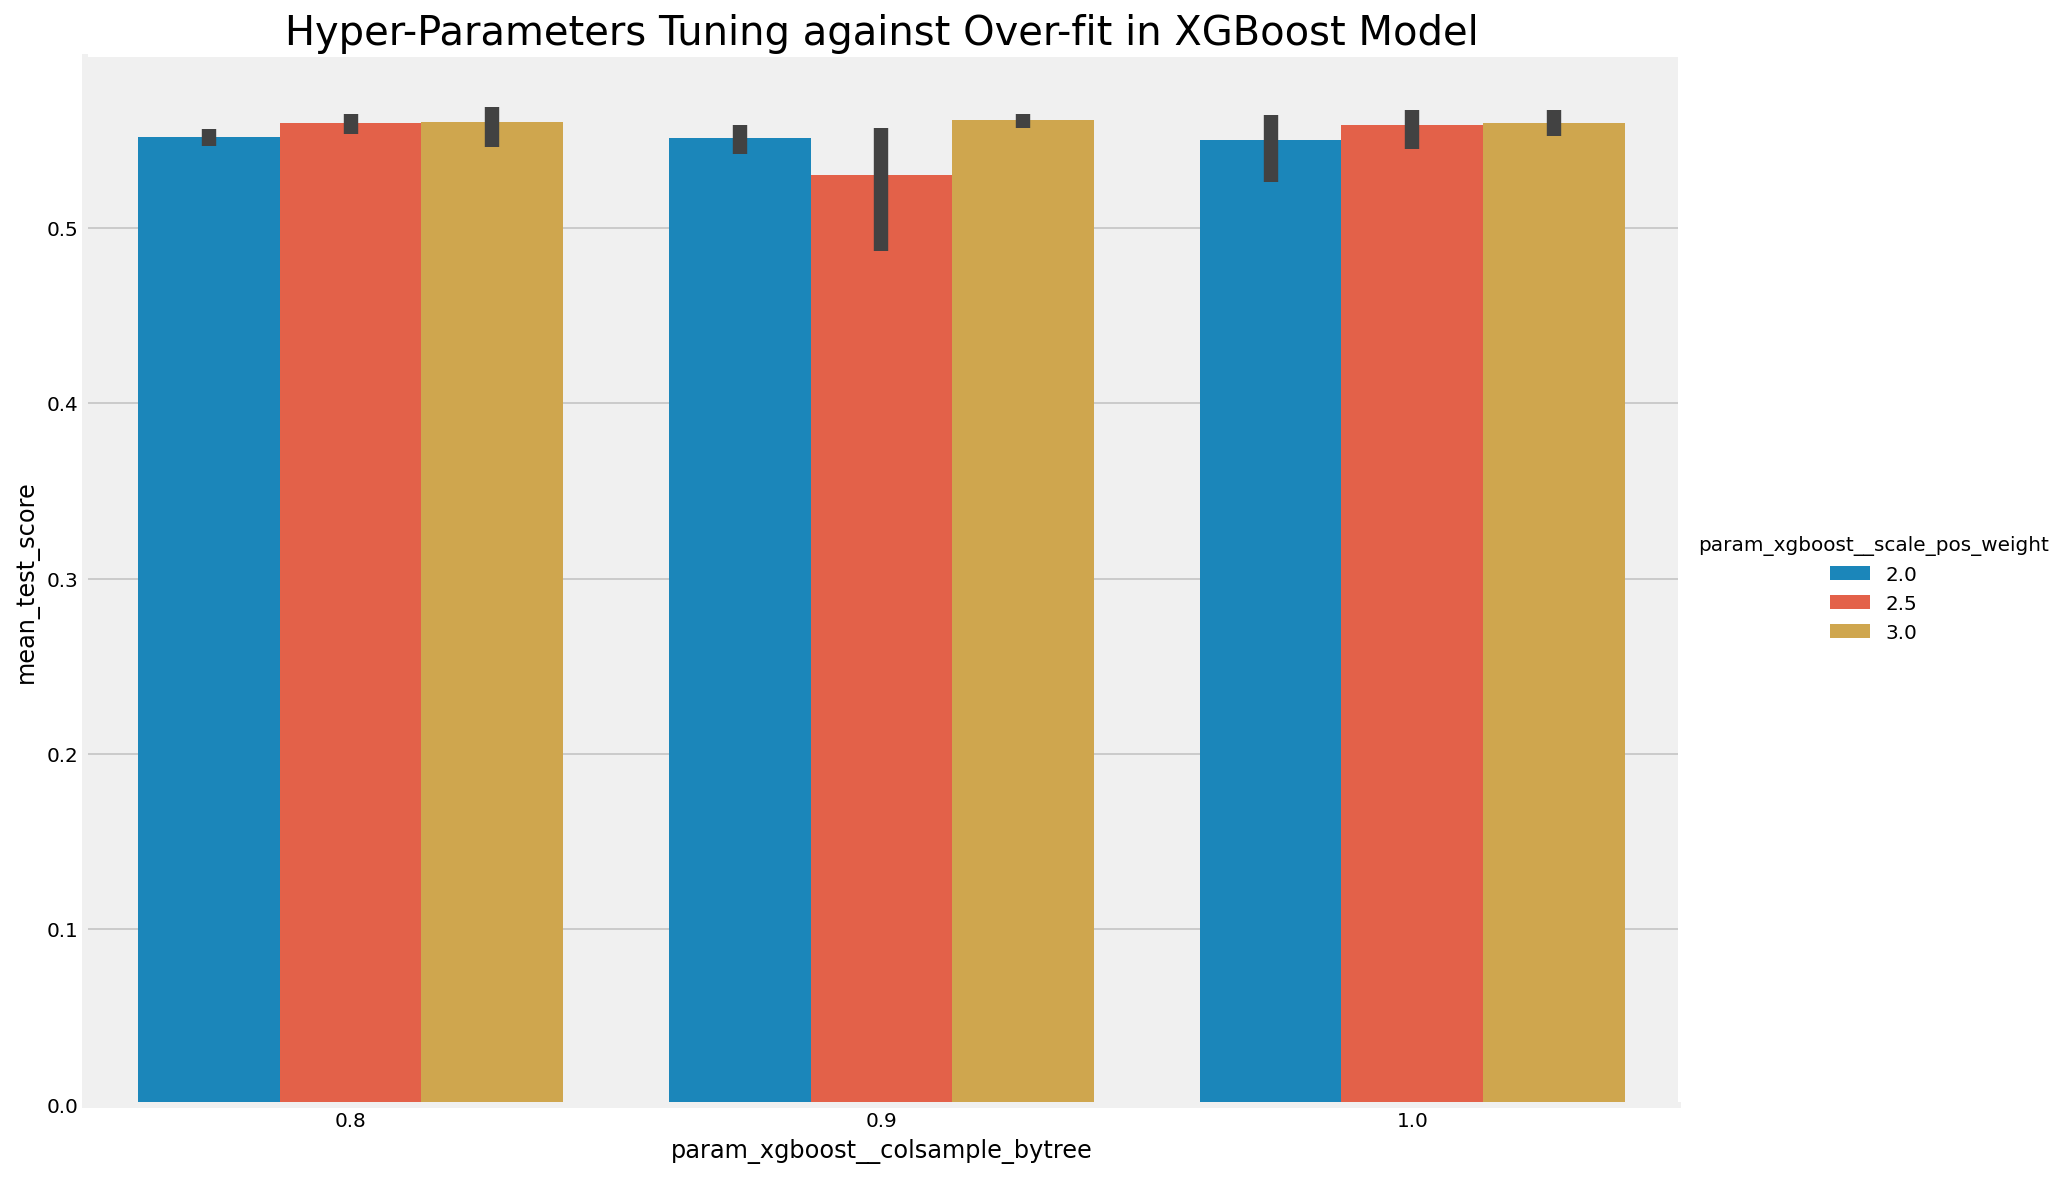

In [28]:
sns.catplot(data=df_rs_xgbT_nlp_f1,
            x='param_xgboost__colsample_bytree',
            y='mean_test_score',
            hue='param_xgboost__scale_pos_weight',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning against Over-fit in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nlp_f1_overfit.png", transparent=True, bbox_inches='tight')
plt.show()

The parameter `colsample_bytree` is the sampling ratio of our columns/features of each CV model. It is the other dimension to subsampling data rows as we have seen in `subsample`. There is no perceptible pattern here.

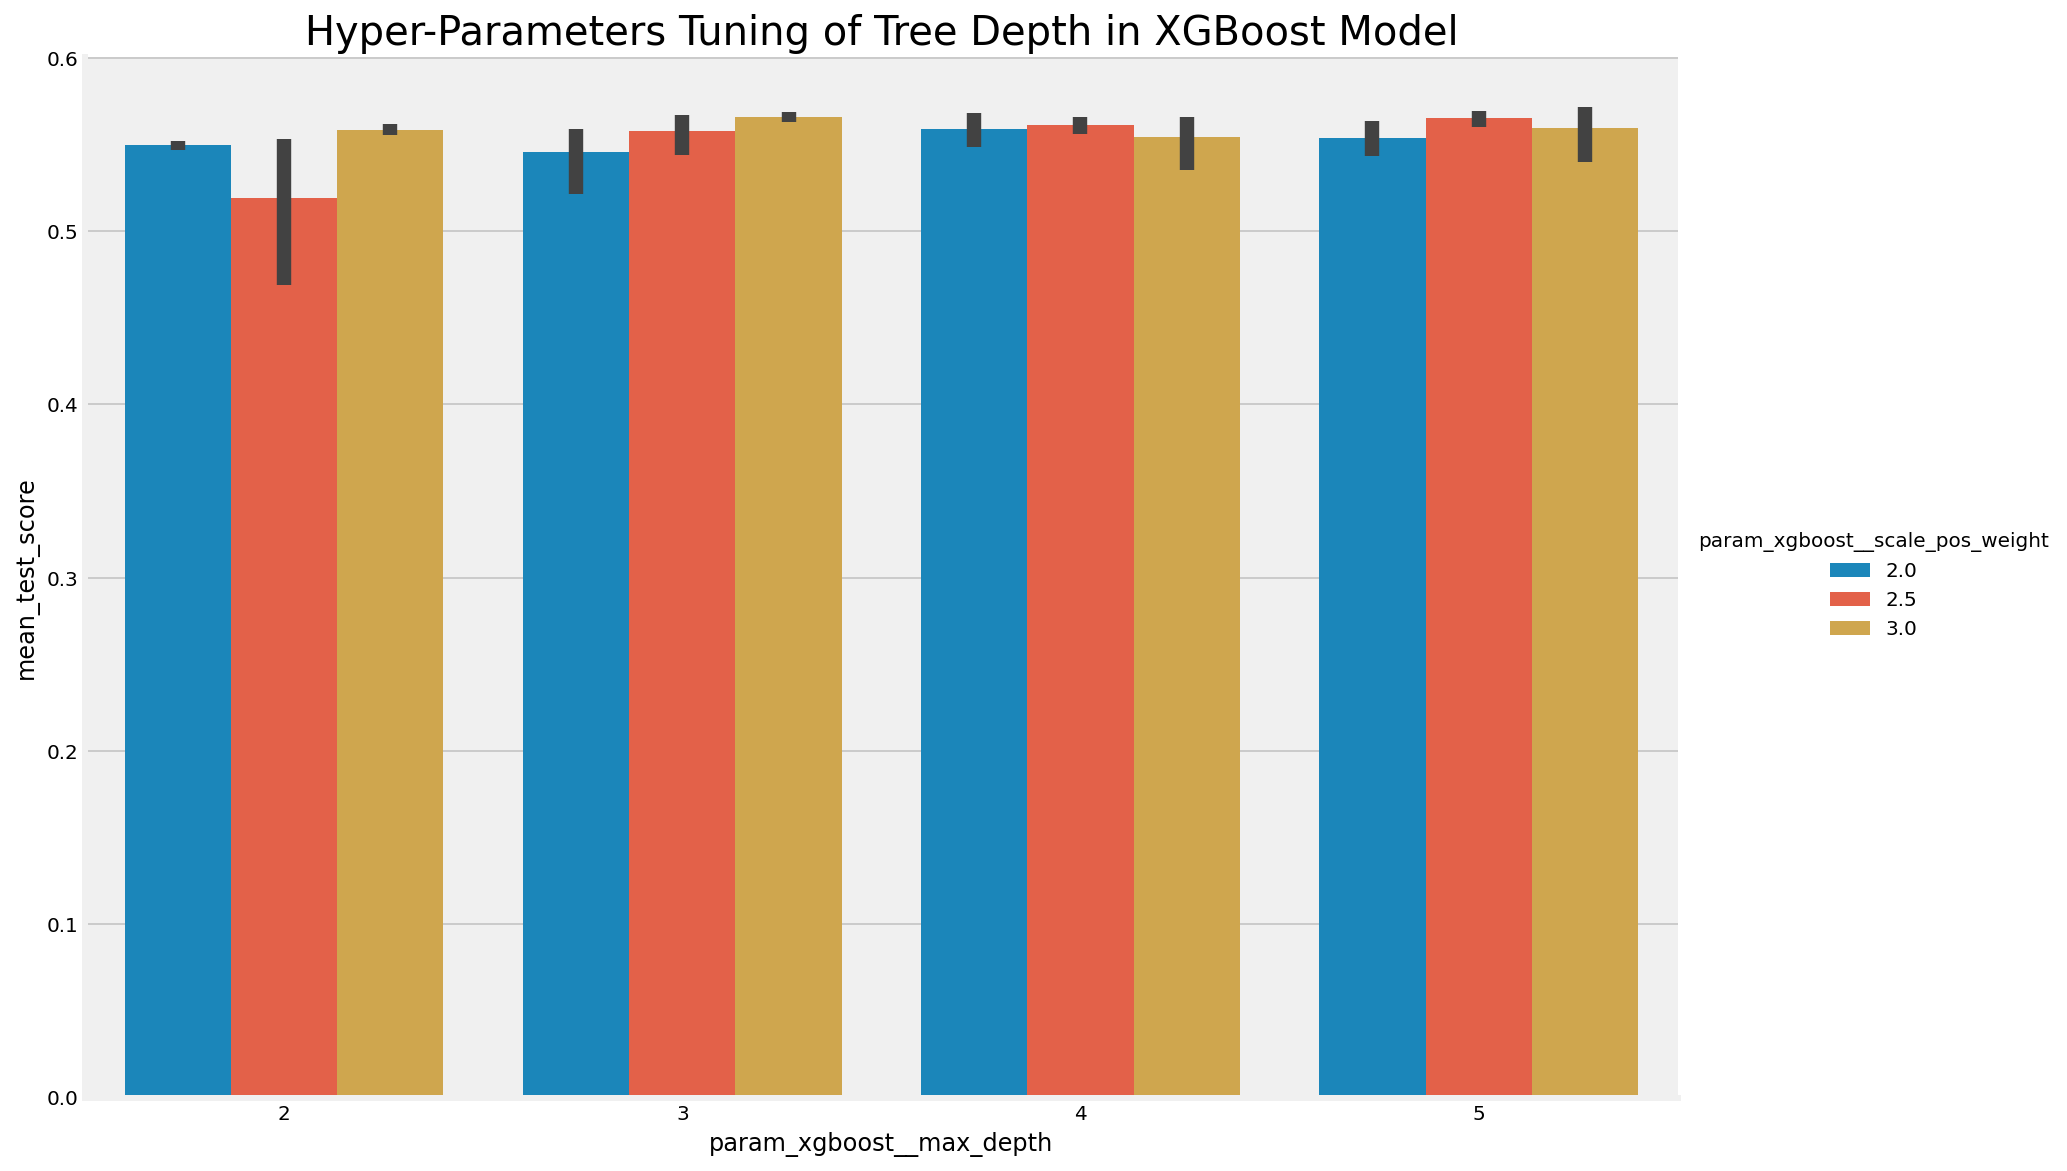

In [30]:
sns.catplot(data=df_rs_xgbT_nlp_f1,
            x='param_xgboost__max_depth',
            y='mean_test_score',
            hue='param_xgboost__scale_pos_weight',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning of Tree Depth in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nlp_f1_depth.png", transparent=True, bbox_inches='tight')
plt.show()

The parameter `max_depth` allows us to control the growth of our trees by limiting the number of levels of branches possible per tree. There appears to be a slight positive trend between `max_depth` and our CV scores. The bar chart also groups by `scale_pos_weight`, which is a useful parameter that adds weight to our minority positive class. We can observe that the heavier weighted positive classes in general allowed for better training and CV scores.

#### Further Optimisation

Best XGBoost Model (Tree) Hyper-Parameters for NLP:
```
{'tvec__max_features': 7500,
 'tvec__ngram_range': (1, 2),
 'xgboost__colsample_bytree': 1,
 'xgboost__gamma': 0,
 'xgboost__learning_rate': 0.38246199126716274,
 'xgboost__max_depth': 5,
 'xgboost__min_child_weight': 0,
 'xgboost__reg_alpha': 2,
 'xgboost__reg_lambda': 4,
 'xgboost__scale_pos_weight': 3,
 'xgboost__subsample': 0.8401537692938899}
 ```

Optimal value for vectorizer parameter `max_features` was found to be at the upper limit of input arguments at 7500. While our violin plot supports this by indicating reduced variance in score as `max_features` increases, in the interest of time and computational cost, we shall cap our `max_features` at 7500 and fix it as such.

Since our randomised grid search recommended the middle range of (1,2) for our `ngram_range`, and it seems to be able to offer good generalisation with a small spread of CV scores, we shall fix our `ngram_range` values at (1,2).

L1 and L2 regularisation through `reg_alpha` and `reg_lambda` respectively found its optimal value within the range of arguments (0-10) provided during our randomised grid search. As such, we shall take these values as final.

The `gamma` parameter sets the minimum loss threshold for a split, effectively pruning the tree's growth and helping to reduce over-fitting of trees. It is recommended to tune this parameter after all other parameters have been fixed. We shall leave it at its default value of 0 for now.

The optimal value for `scale_pos_weight` was found at the upper limit of input arguments at 3. In a training set whereby there is an imbalance in classes, this is a parameter that incentivises the model to learn more of the minority positive class (popular = 1) by adding weight to the minority value. We shall test a range of arguments greater than 3 to see if the optimal value has been found.

For `learning_rate`, the optimal value was found to be at about 0.38. Even though we fed as input argument for the randomised grid search a uniform distribution of values from 0.0 to 1.0, suggesting that this is likely its optimal value after 100 iterations, our chart suggest a pattern whereby greater learning rate is correlated with an increase in CV scores. As such, we shall test a range of values to see if there is a greater value of `learning_rate` that is optimal.

The parameter `max_depth` was given a range of random integers from 2 to 5 and the upper limit of 5 was chosen as optimal. We shall test arguments greater than 5 to find the optimal value.

Parameter `min_child_weight` was given a range of random integers from 0 to 4 and the optimal value was found to be at 0. We will accept this value as the optimal.

Since the `subsample` optimal value was given to be a value of 0.84, and we believe our model to currently be under-fitting from our charts, we shall test input both 0.85 and 1.0 as arguments to the parameter and see which gives us the better result.

For `colsample_bytree` which samples from the column axis as a technique to reduce over-fitting of model, we shall fix our optimal value at the grid search recommended value of 1 and sample from all columns for every tree.

In [34]:
# build pipeline
pipe_xgbT = Pipeline(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                            ("xgboost", xgb.XGBClassifier(booster="gbtree", # "gbtree" is our best performing model for NLP
                                                          objective="binary:logistic"))])

# set hyper params to tune
pipe_params_xgbT = {
    "tvec__max_features": [7500],
    "tvec__ngram_range": [(1,2)],
    "xgboost__reg_alpha": [2],
    "xgboost__reg_lambda": [4],
    "xgboost__gamma": [0],
    "xgboost__scale_pos_weight": [3, 3.5, 4], # best argm was the upper limit at 3
    "xgboost__learning_rate": [0.3, 0.4, 0.5], # chart suggests increasing learning rate while our best argm was 0.38
    "xgboost__max_depth": [5, 6, 7], # best argm was the upper limit at 5
    "xgboost__min_child_weight": [2],
    "xgboost__subsample": [0.85, 1], # test between recommended 0.85 or 1 which we suspect may perform better
    "xgboost__colsample_bytree": [1]
}

In [35]:
%%time
np.random.seed(42)
gs_xgbT_nlp_f1 = GridSearchCV(estimator=pipe_xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="f1")
gs_xgbT_nlp_f1.fit(X_nlp_train, y_train)
print("Best score in Grid Search:", gs_xgbT_nlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nlp_f1.best_params_

Best score in Grid Search: 0.5847649424367053

Using the following hyper-parameters:
Wall time: 22min 59s


{'tvec__max_features': 7500,
 'tvec__ngram_range': (1, 2),
 'xgboost__colsample_bytree': 1,
 'xgboost__gamma': 0,
 'xgboost__learning_rate': 0.3,
 'xgboost__max_depth': 7,
 'xgboost__min_child_weight': 2,
 'xgboost__reg_alpha': 2,
 'xgboost__reg_lambda': 4,
 'xgboost__scale_pos_weight': 3,
 'xgboost__subsample': 1}

Our `scale_pos_weight` optimal value remains at 3 instead of the greater value grid searched against. We have therefore found our optimal argument.

The optimal value for parameter `learning_rate` actually fell to 0.3, suggesting that we are getting better results with a smaller `learning_rate`. We shall test range of smaller learning steps in the next grid search.

For `max_depth`, the optimal value was once again found at the upper limit of 7. We shall test range of greater `max_depth` values to determine if the optimal depth has been found.

The grid search has voted and chose a `subsample` of 1 as the optimal value. This means the model is able to achieve better CV scores when trained on 100% of the data points (rows).

In [36]:
# build pipeline
pipe_xgbT = Pipeline(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                            ("xgboost", xgb.XGBClassifier(booster="gbtree", # "gbtree" is our best performing model for NLP
                                                          objective="binary:logistic"))])

# set hyper params to tune
pipe_params_xgbT = {
    "tvec__max_features": [7500],
    "tvec__ngram_range": [(1,2)],
    "xgboost__reg_alpha": [2],
    "xgboost__reg_lambda": [4],
    "xgboost__gamma": [0],
    "xgboost__scale_pos_weight": [3],
    "xgboost__learning_rate": [0.1, 0.15, 0.2, 0.25, 0.3], # test smaller learning steps
    "xgboost__max_depth": [7, 8, 9, 10], # test bigger and deeper trees
    "xgboost__min_child_weight": [2],
    "xgboost__subsample": [1],
    "xgboost__colsample_bytree": [1]
}                

In [37]:
%%time
np.random.seed(42)
gs_xgbT_nlp_f1 = GridSearchCV(estimator=pipe_xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="f1")
gs_xgbT_nlp_f1.fit(X_nlp_train, y_train)
print("Best score in Grid Search:", gs_xgbT_nlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nlp_f1.best_params_

Best score in Grid Search: 0.5861567001293039

Using the following hyper-parameters:
Wall time: 10min 37s


{'tvec__max_features': 7500,
 'tvec__ngram_range': (1, 2),
 'xgboost__colsample_bytree': 1,
 'xgboost__gamma': 0,
 'xgboost__learning_rate': 0.25,
 'xgboost__max_depth': 10,
 'xgboost__min_child_weight': 2,
 'xgboost__reg_alpha': 2,
 'xgboost__reg_lambda': 4,
 'xgboost__scale_pos_weight': 3,
 'xgboost__subsample': 1}

Through grid searching, we have found the optimal `learning_rate` at the middling input range of 0.25. We shall accept this as our optimal `learning_rate` value.

The model continues to demand for bigger and deeper trees with a `max_depth` of 10 as the optimal value from the grid search. As the value of 10 is at the upper limit of our input range, we shall continue testing greater values in that direction.

In [38]:
# build pipeline
pipe_xgbT = Pipeline(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                            ("xgboost", xgb.XGBClassifier(booster="gbtree", # "gbtree" is our best performing model for NLP
                                                          objective="binary:logistic"))])

# set hyper params to tune
pipe_params_xgbT = {
    "tvec__max_features": [7500],
    "tvec__ngram_range": [(1,2)],
    "xgboost__reg_alpha": [2],
    "xgboost__reg_lambda": [4],
    "xgboost__gamma": [0],
    "xgboost__scale_pos_weight": [3],
    "xgboost__learning_rate": [0.25],
    "xgboost__max_depth": [10, 11, 12, 15, 20], # test greater depth values
    "xgboost__min_child_weight": [2],
    "xgboost__subsample": [1],
    "xgboost__colsample_bytree": [1]
}                

In [39]:
%%time
np.random.seed(42)
gs_xgbT_nlp_f1 = GridSearchCV(estimator=pipe_xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="f1")
gs_xgbT_nlp_f1.fit(X_nlp_train, y_train)
print("Best score in Grid Search:", gs_xgbT_nlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nlp_f1.best_params_

Best score in Grid Search: 0.5861567001293039

Using the following hyper-parameters:
Wall time: 3min 46s


{'tvec__max_features': 7500,
 'tvec__ngram_range': (1, 2),
 'xgboost__colsample_bytree': 1,
 'xgboost__gamma': 0,
 'xgboost__learning_rate': 0.25,
 'xgboost__max_depth': 10,
 'xgboost__min_child_weight': 2,
 'xgboost__reg_alpha': 2,
 'xgboost__reg_lambda': 4,
 'xgboost__scale_pos_weight': 3,
 'xgboost__subsample': 1}

It appears that we have found our optimal `max_depth` value as the recommended argument remains at 10. We shall take this as our optimal value for `max_depth`.

Since we have fixed all our hyper-parameters, we shall now provide a range of `gamma` values and see if it improves our score.

In [65]:
# build pipeline
pipe_xgbT = Pipeline(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                            ("xgboost", xgb.XGBClassifier(booster="gbtree", # "gbtree" is our best performing model for NLP
                                                          objective="binary:logistic"))])

# set hyper params to tune
pipe_params_xgbT = {
    "tvec__max_features": [7500],
    "tvec__ngram_range": [(1,2)],
    "xgboost__reg_alpha": [2],
    "xgboost__reg_lambda": [4],
    "xgboost__gamma": [0, 0.05, 0.1, 0.2, 0.4, 0.8], # tune gamma
    "xgboost__scale_pos_weight": [3],
    "xgboost__learning_rate": [0.25],
    "xgboost__max_depth": [10],
    "xgboost__min_child_weight": [2],
    "xgboost__subsample": [1],
    "xgboost__colsample_bytree": [1]
}                

In [66]:
%%time
np.random.seed(42)
gs_xgbT_nlp_f1 = GridSearchCV(estimator=pipe_xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="f1")
gs_xgbT_nlp_f1.fit(X_nlp_train, y_train)
print("Best score in Grid Search:", gs_xgbT_nlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nlp_f1.best_params_

Best score in Grid Search: 0.5861567001293039

Using the following hyper-parameters:
Wall time: 6min 40s


{'tvec__max_features': 7500,
 'tvec__ngram_range': (1, 2),
 'xgboost__colsample_bytree': 1,
 'xgboost__gamma': 0,
 'xgboost__learning_rate': 0.25,
 'xgboost__max_depth': 10,
 'xgboost__min_child_weight': 2,
 'xgboost__reg_alpha': 2,
 'xgboost__reg_lambda': 4,
 'xgboost__scale_pos_weight': 3,
 'xgboost__subsample': 1}

Despite providing a full range of `gamma` values, the grid search still recommends 0 for `gamma`. We shall take this as a sign that `gamma` does not improve our CV scores and fix its optimal value at 0.

We have re-tuned our hyper-parameters and optimised on the F-1 score for our NLP model!

### Re-Tune non-NLP Model

In [40]:
# instantiate XGB model
xgbT = xgb.XGBClassifier(booster="gbtree", objective="binary:logistic")

# set hyper params to tune
pipe_params_xgbT = {
    "reg_alpha": randint(0, 11),
    "reg_lambda": randint(0, 11),
    "gamma": [0],
    "scale_pos_weight": [2, 2.5, 3], # xgb doc recommends sum(neg)/sum(pos) = 12_793/5257
    "learning_rate": uniform(0, 1),
    "max_depth": randint(2, 6),
    "min_child_weight": randint(0, 5),
    "subsample": uniform(0.5, 0.5),
    "colsample_bytree": [0.8, 0.9, 1]
}

In [41]:
%%time
np.random.seed(42)
rs_xgbT_nnlp_f1 = RandomizedSearchCV(estimator=xgbT, param_distributions=pipe_params_xgbT,
                                     n_iter=100, cv=4, scoring="f1")
rs_xgbT_nnlp_f1.fit(X_nnlp_train_dumm, y_train)
print("Best score in Randomised Search:", rs_xgbT_nnlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
rs_xgbT_nnlp_f1.best_params_

Best score in Randomised Search: 0.5343944743983592

Using the following hyper-parameters:
Wall time: 5min 28s


{'colsample_bytree': 0.9,
 'gamma': 0,
 'learning_rate': 0.3677831327192532,
 'max_depth': 5,
 'min_child_weight': 1,
 'reg_alpha': 5,
 'reg_lambda': 5,
 'scale_pos_weight': 3,
 'subsample': 0.908215936609692}

#### Evaluate Hyper-Parameters

In [42]:
df_rs_xgbT_nnlp_f1 = pd.DataFrame(rs_xgbT_nnlp_f1.cv_results_)
df_rs_xgbT_nnlp_f1.to_csv("../datasets/df_rs_xgbT_nnlp_f1.csv", index=False) # save out df of randomized search
df_rs_xgbT_nnlp_f1.info() # notice certain cols that are numeric are not numeric

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mean_fit_time           100 non-null    float64
 1   std_fit_time            100 non-null    float64
 2   mean_score_time         100 non-null    float64
 3   std_score_time          100 non-null    float64
 4   param_colsample_bytree  100 non-null    object 
 5   param_gamma             100 non-null    object 
 6   param_learning_rate     100 non-null    object 
 7   param_max_depth         100 non-null    object 
 8   param_min_child_weight  100 non-null    object 
 9   param_reg_alpha         100 non-null    object 
 10  param_reg_lambda        100 non-null    object 
 11  param_scale_pos_weight  100 non-null    object 
 12  param_subsample         100 non-null    object 
 13  params                  100 non-null    object 
 14  split0_test_score       100 non-null    flo

In [43]:
# re-import df
df_rs_xgbT_nnlp_f1 = pd.read_csv("../datasets/df_rs_xgbT_nnlp_f1.csv")
df_rs_xgbT_nnlp_f1.head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.975268      0.033469         0.022440        0.000499   
1       1.165776      0.008869         0.024186        0.000827   
2       0.724729      0.010091         0.020446        0.000498   

   param_colsample_bytree  param_gamma  param_learning_rate  param_max_depth  \
0                     1.0            0             0.796543                4   
1                     1.0            0             0.058084                5   
2                     0.9            0             0.721999                3   

   param_min_child_weight  param_reg_alpha  ...  param_scale_pos_weight  \
0                       2                7  ...                     3.0   
1                       4                3  ...                     3.0   
2                       1                4  ...                     2.5   

   param_subsample                                             params  \
0         0.722916  {'colsample_bytree': 1, 'gamma': 0, 'learning_...   
1         0.510292  {'colsample_bytree': 1, 'gamma': 0, 'learning_...   
2         0.762378  {'colsample_bytree': 0.9, 'gamma': 0, 'learnin...   

  split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0          0.521123           0.526672           0.524150           0.522656   
1          0.517028           0.527976           0.527594           0.523335   
2          0.508566           0.519465           0.510371           0.521186   

   mean_test_score  std_test_score  rank_test_score  
0         0.523650        0.002047               22  
1         0.523983        0.004410               19  
2         0.514897        0.005500               58  

[3 rows x 21 columns]

In [44]:
# convert all cols that can be numeric into numeric dtypes
df_rs_xgbT_nnlp_f1["param_colsample_bytree"] = df_rs_xgbT_nnlp_f1["param_colsample_bytree"].astype(float)
df_rs_xgbT_nnlp_f1["param_gamma"] = df_rs_xgbT_nnlp_f1["param_gamma"].astype(float)
df_rs_xgbT_nnlp_f1["param_learning_rate"] = df_rs_xgbT_nnlp_f1["param_learning_rate"].astype(float)
df_rs_xgbT_nnlp_f1["param__max_depth"] = df_rs_xgbT_nnlp_f1["param_max_depth"].astype(int)
df_rs_xgbT_nnlp_f1["param_min_child_weight"] = df_rs_xgbT_nnlp_f1["param_min_child_weight"].astype(int)
df_rs_xgbT_nnlp_f1["param_reg_alpha"] = df_rs_xgbT_nnlp_f1["param_reg_alpha"].astype(int)
df_rs_xgbT_nnlp_f1["param_reg_lambda"] = df_rs_xgbT_nnlp_f1["param_reg_lambda"].astype(int)
df_rs_xgbT_nnlp_f1["param_scale_pos_weight"] = df_rs_xgbT_nnlp_f1["param_scale_pos_weight"].astype(float)
df_rs_xgbT_nnlp_f1["param_subsample"] = df_rs_xgbT_nnlp_f1["param_subsample"].astype(float)
df_rs_xgbT_nnlp_f1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mean_fit_time           100 non-null    float64
 1   std_fit_time            100 non-null    float64
 2   mean_score_time         100 non-null    float64
 3   std_score_time          100 non-null    float64
 4   param_colsample_bytree  100 non-null    float64
 5   param_gamma             100 non-null    float64
 6   param_learning_rate     100 non-null    float64
 7   param_max_depth         100 non-null    int64  
 8   param_min_child_weight  100 non-null    int32  
 9   param_reg_alpha         100 non-null    int32  
 10  param_reg_lambda        100 non-null    int32  
 11  param_scale_pos_weight  100 non-null    float64
 12  param_subsample         100 non-null    float64
 13  params                  100 non-null    object 
 14  split0_test_score       100 non-null    flo

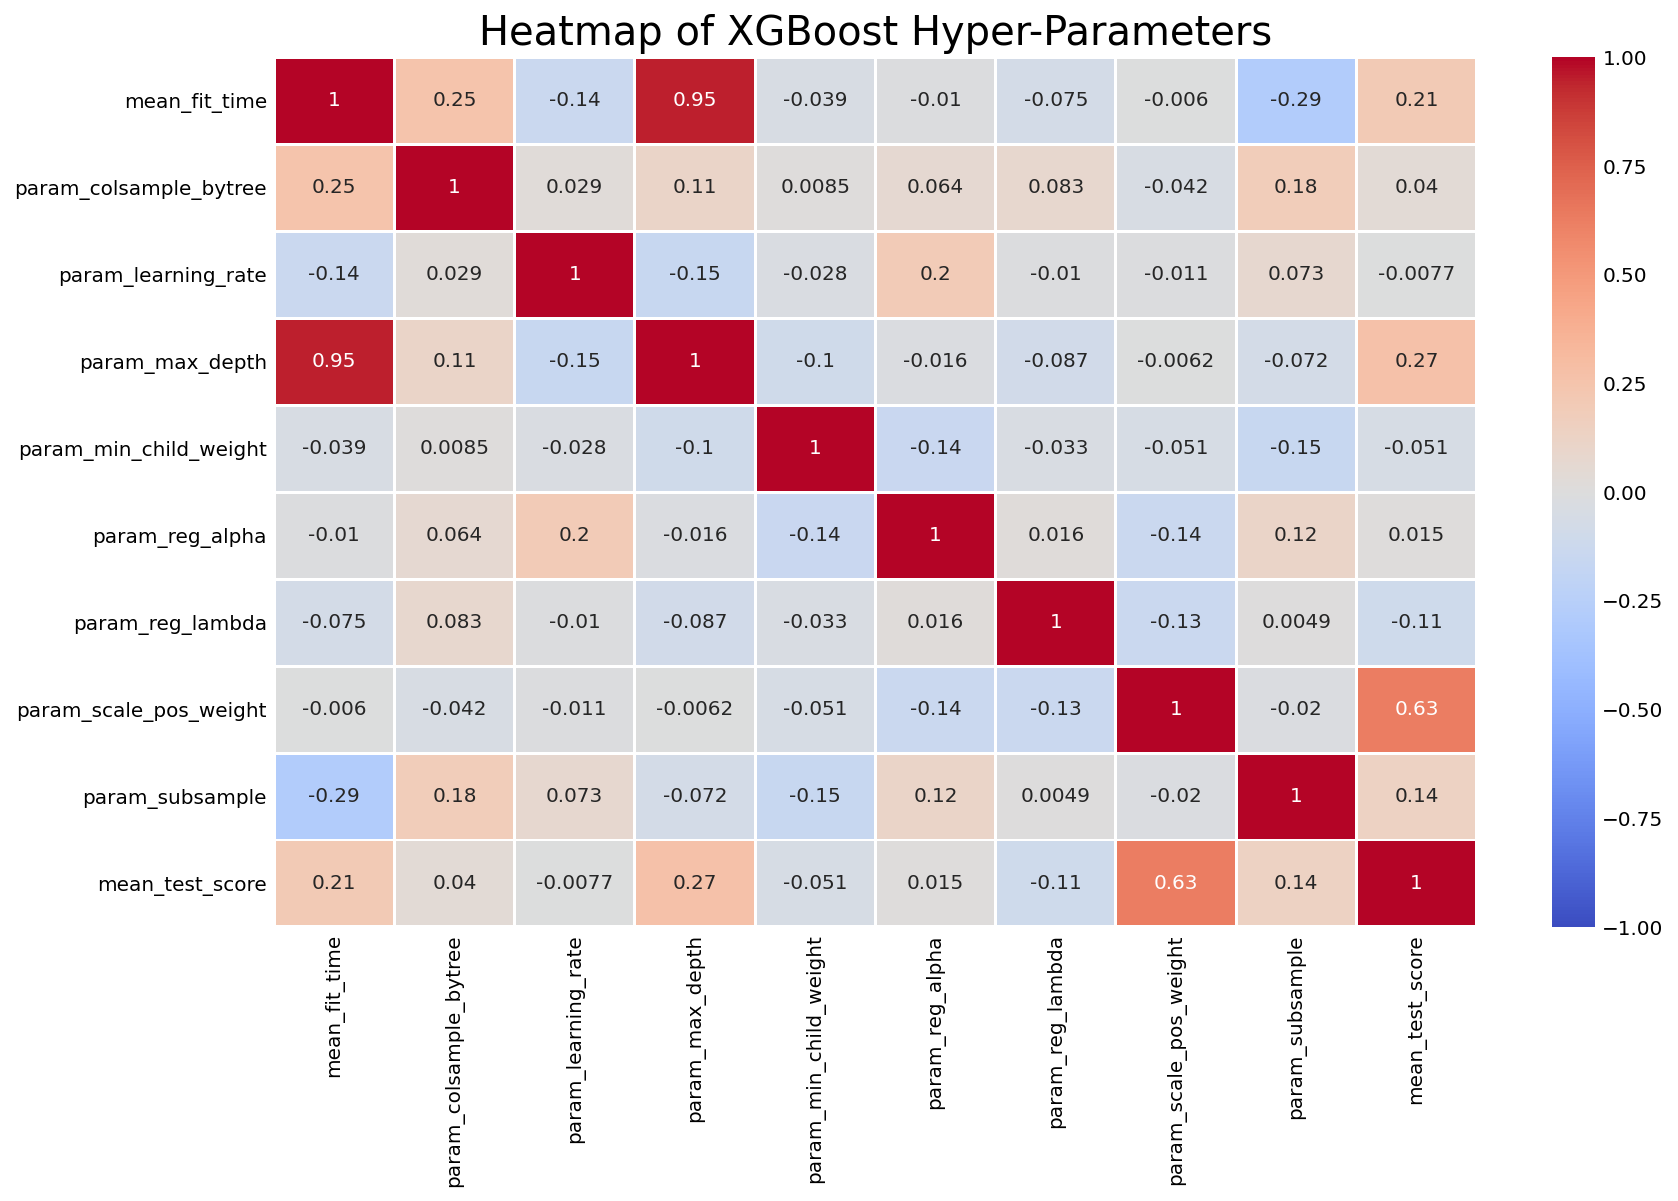

In [46]:
plt.figure(figsize=[12,8])
plt.title("Heatmap of XGBoost Hyper-Parameters", size=20)
include = ["mean_fit_time", "param_colsample_bytree", "param_learning_rate", "param_max_depth", "param_min_child_weight",
           "param_reg_alpha", "param_reg_lambda", "param_scale_pos_weight", "param_subsample", "mean_test_score"]
sns.heatmap(df_rs_xgbT_nnlp_f1[include].corr(), annot=True, linewidths=1, vmin=-1, vmax=1, cmap="coolwarm")
plt.savefig("../assets/hparams_xgbT_nnlp_f1_heatmap.png", transparent=True, bbox_inches='tight')
plt.show()

By following the `mean_test_score` row, we can trace the CV score correlation to the hyper-parameters. Our top hyper-parameter most correlated with `mean_test_score` is XGBoost's `scale_pos_weight` at +0.63. Coming in second is `max_depth` at +0.27.

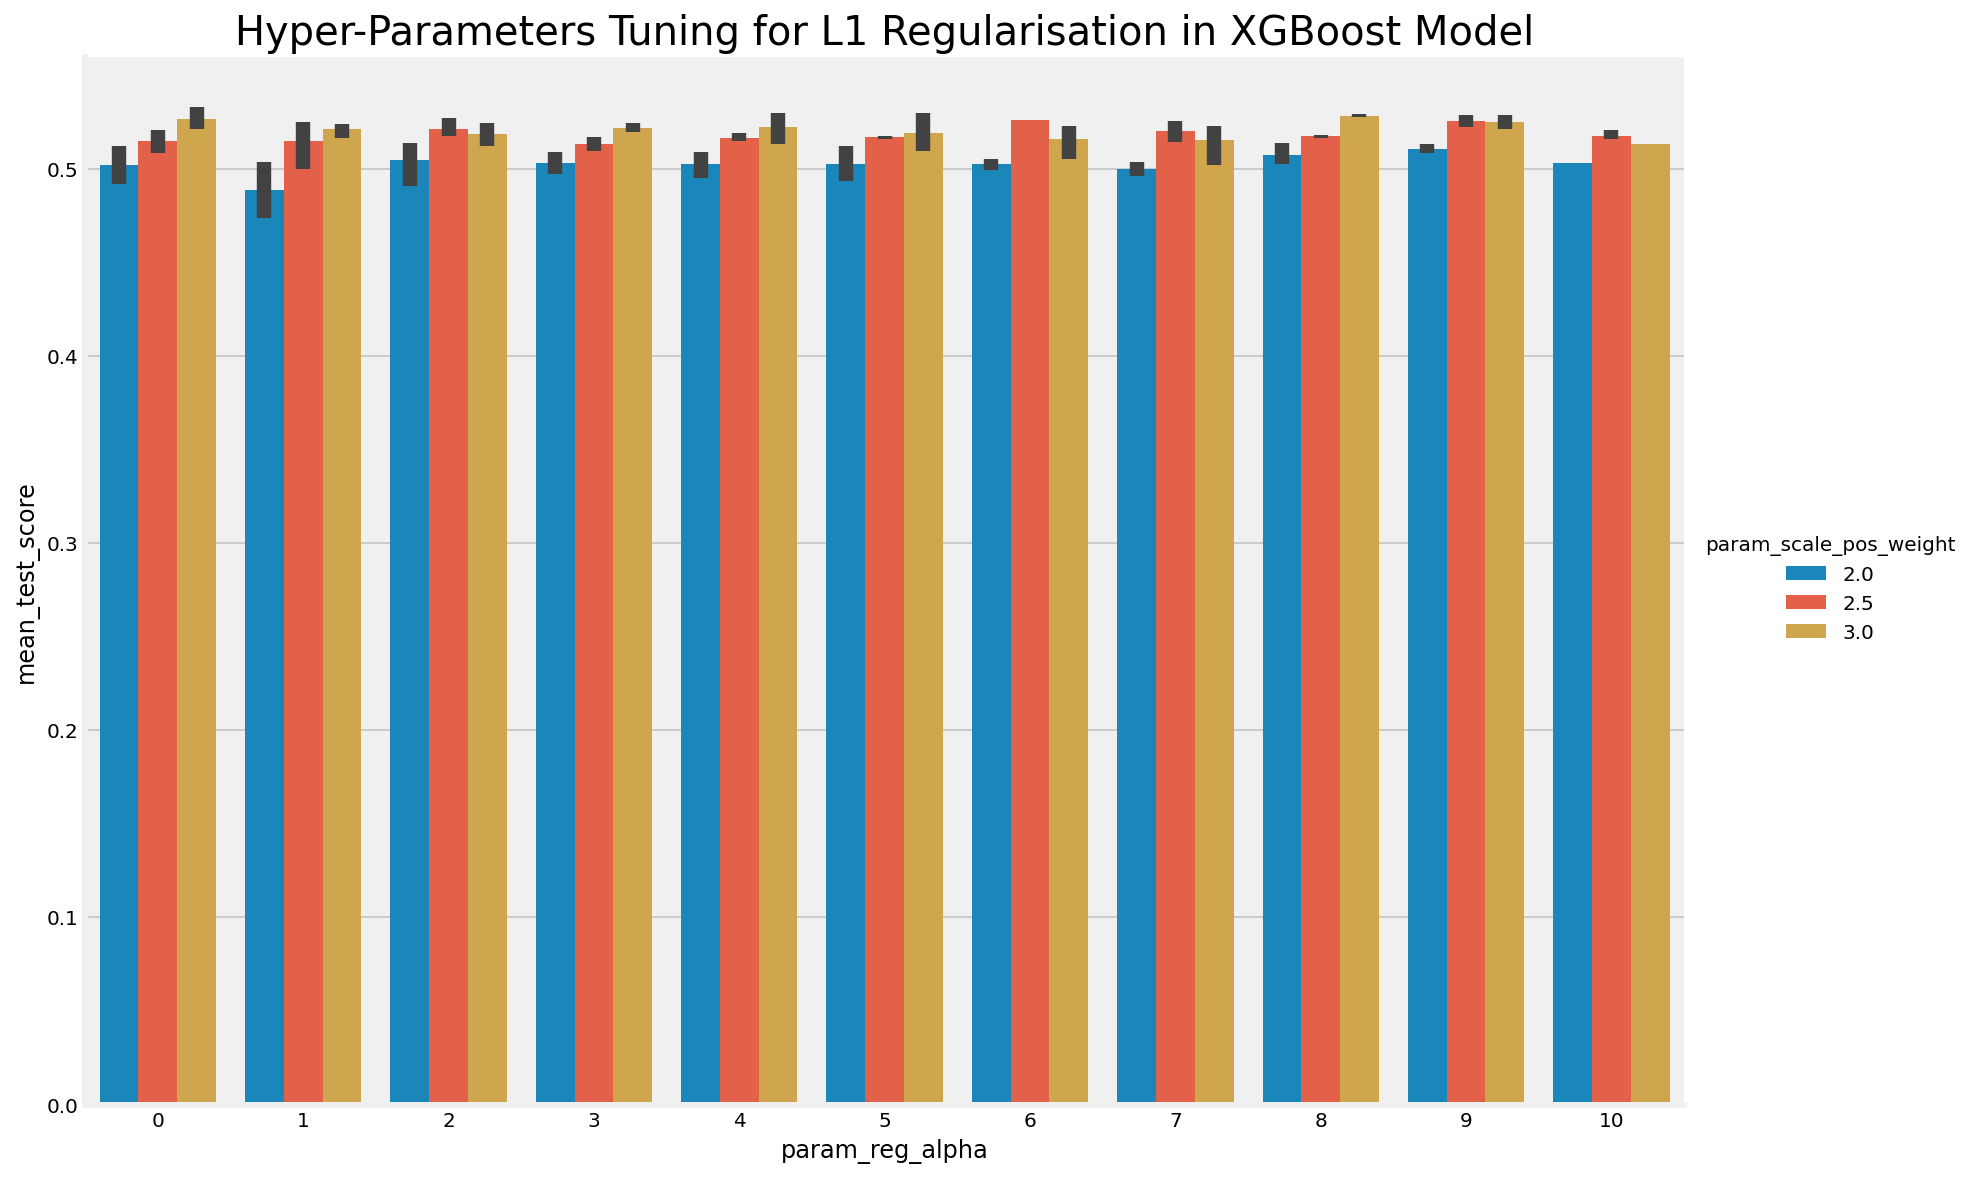

In [47]:
sns.catplot(data=df_rs_xgbT_nnlp_f1,
            x='param_reg_alpha',
            y='mean_test_score',
            hue='param_scale_pos_weight',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning for L1 Regularisation in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nnlp_f1_alpha.png", transparent=True, bbox_inches='tight')
plt.show()

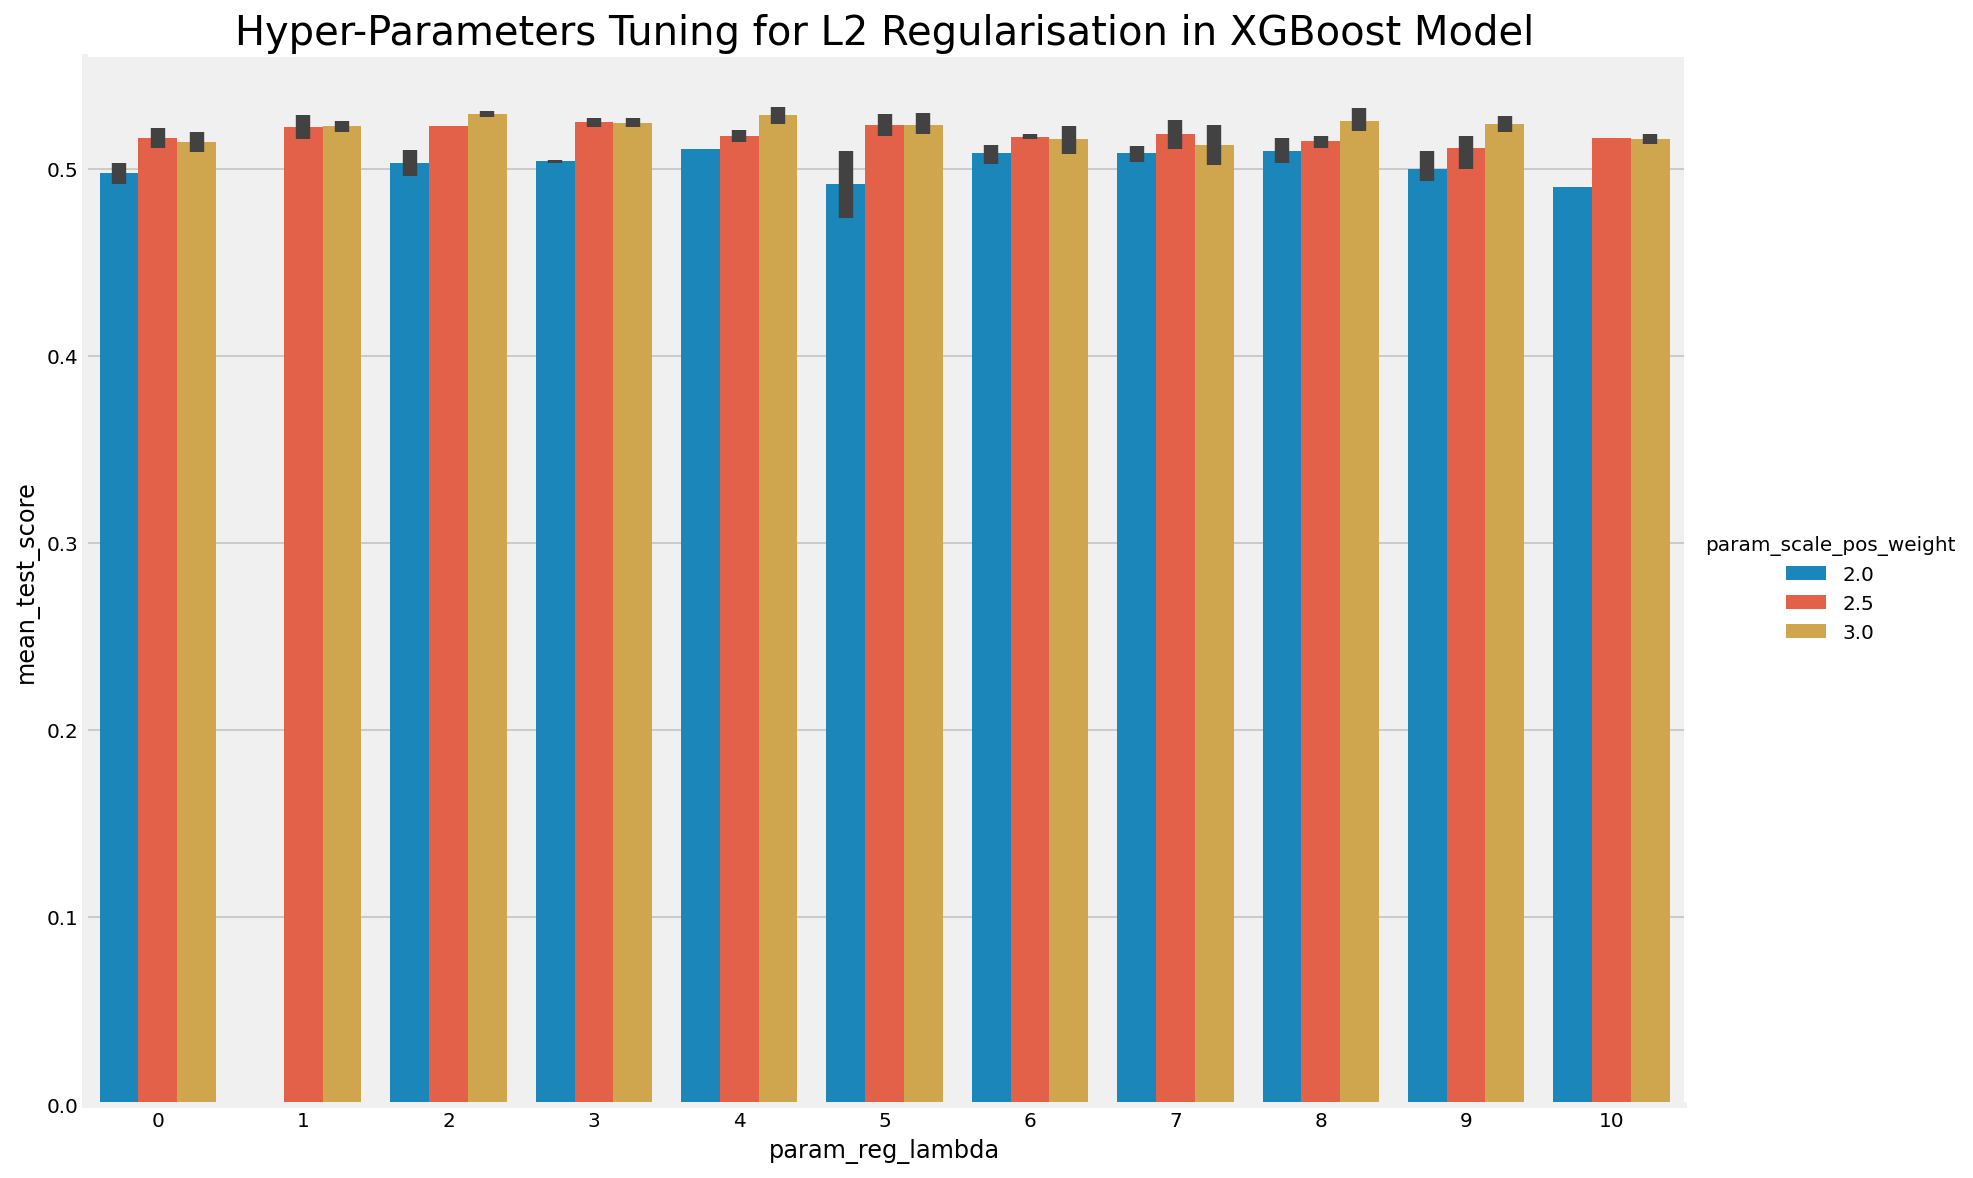

In [48]:
sns.catplot(data=df_rs_xgbT_nnlp_f1,
            x='param_reg_lambda',
            y='mean_test_score',
            hue='param_scale_pos_weight',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning for L2 Regularisation in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nnlp_f1_lambda.png", transparent=True, bbox_inches='tight')
plt.show()

No clear trend can observed for both L1 `reg_alpha` and L2 `reg_lambda` regularisation. However, regardless of the strength of regularisation, a larger `scale_pos_weight` value often leads to a better CV score.

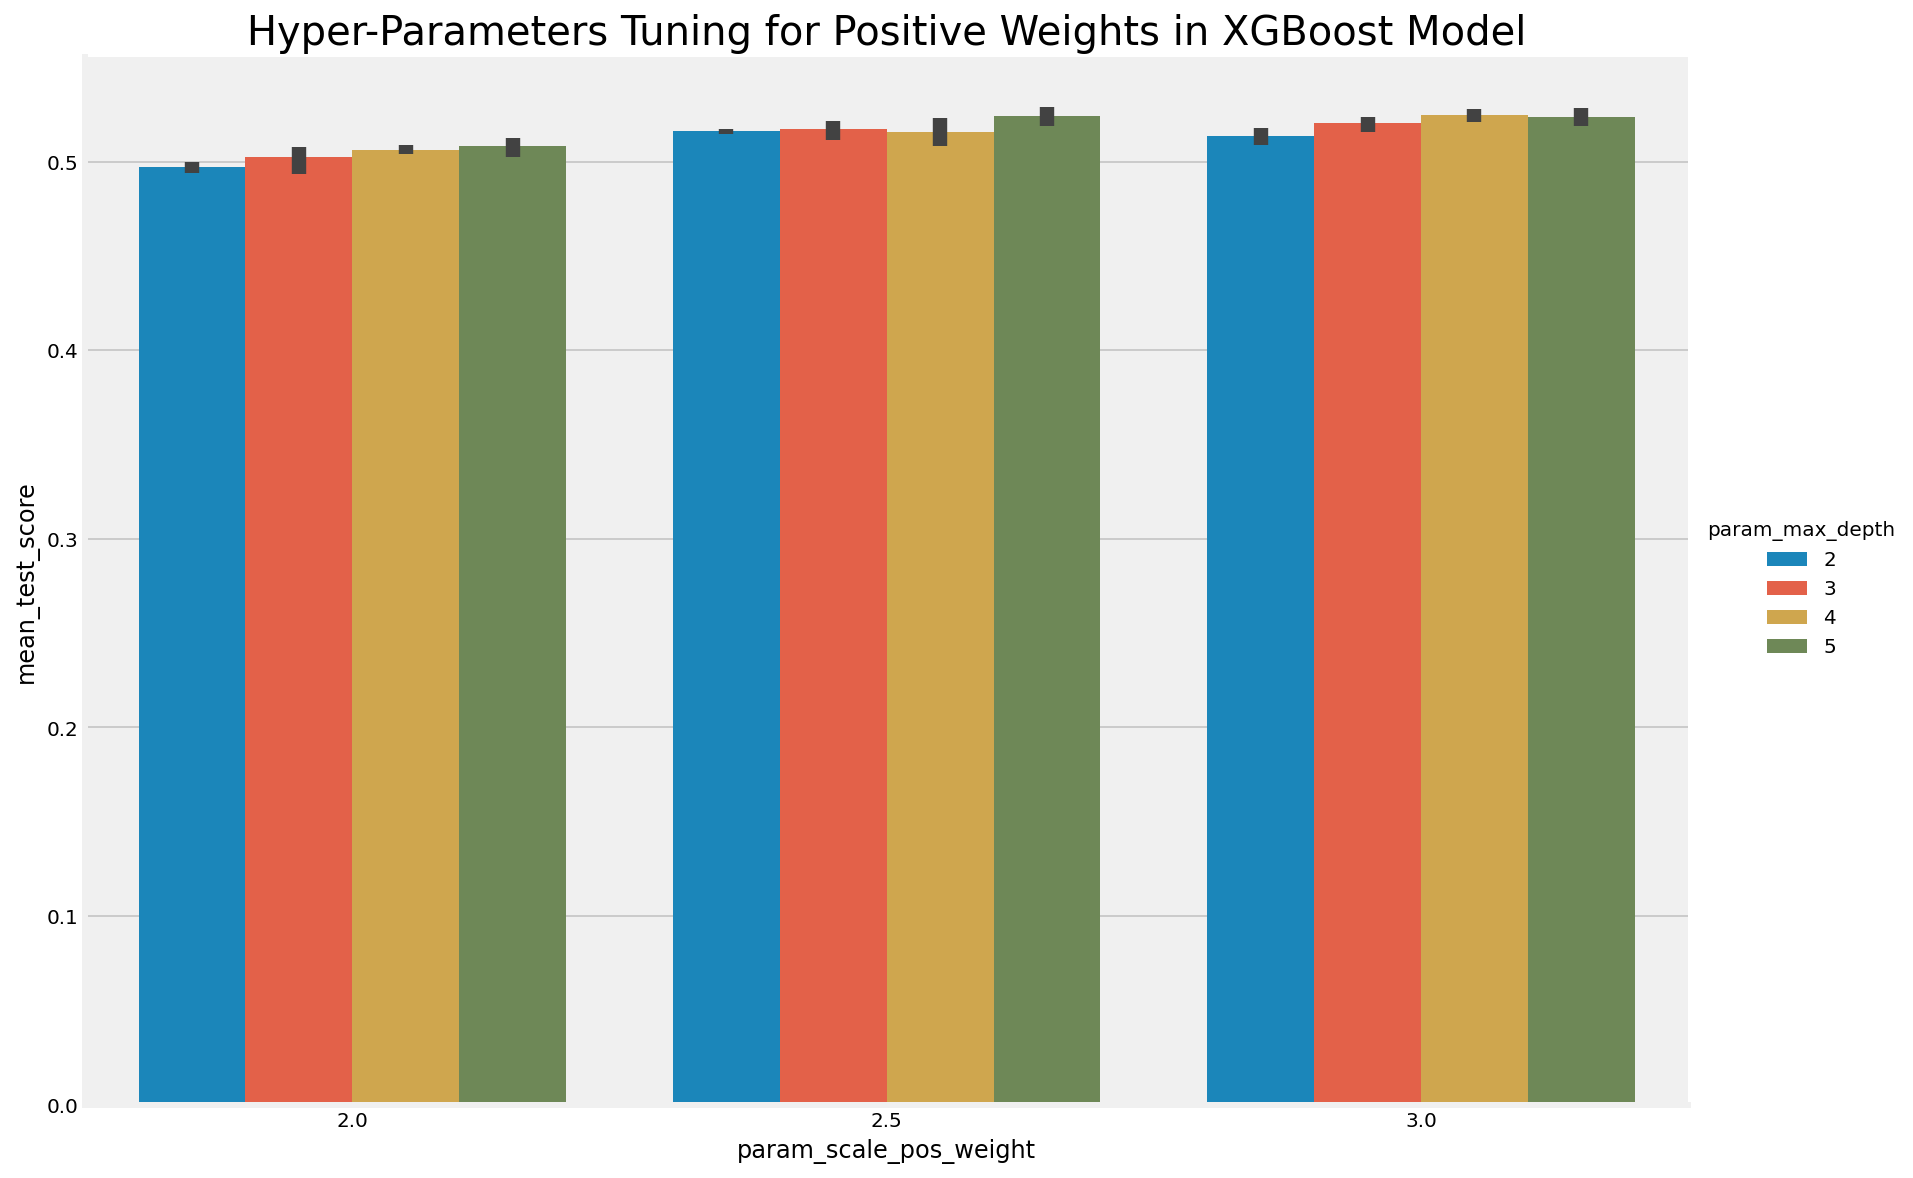

In [51]:
sns.catplot(data=df_rs_xgbT_nnlp_f1,
            x='param_scale_pos_weight',
            y='mean_test_score',
            hue='param_max_depth',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning for Positive Weights in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nnlp_f1_posweight.png", transparent=True, bbox_inches='tight')
plt.show()

We can observe a clear positive trend between `scale_pos_weight` and the CV scores. As `scale_pos_weight` increases, CV score increases. This makes sense as we are scoring on F-1 and weighting our minority positive class incentivises our model to learn the class, giving rise to better predictions of our positive class and therefore a better precision.

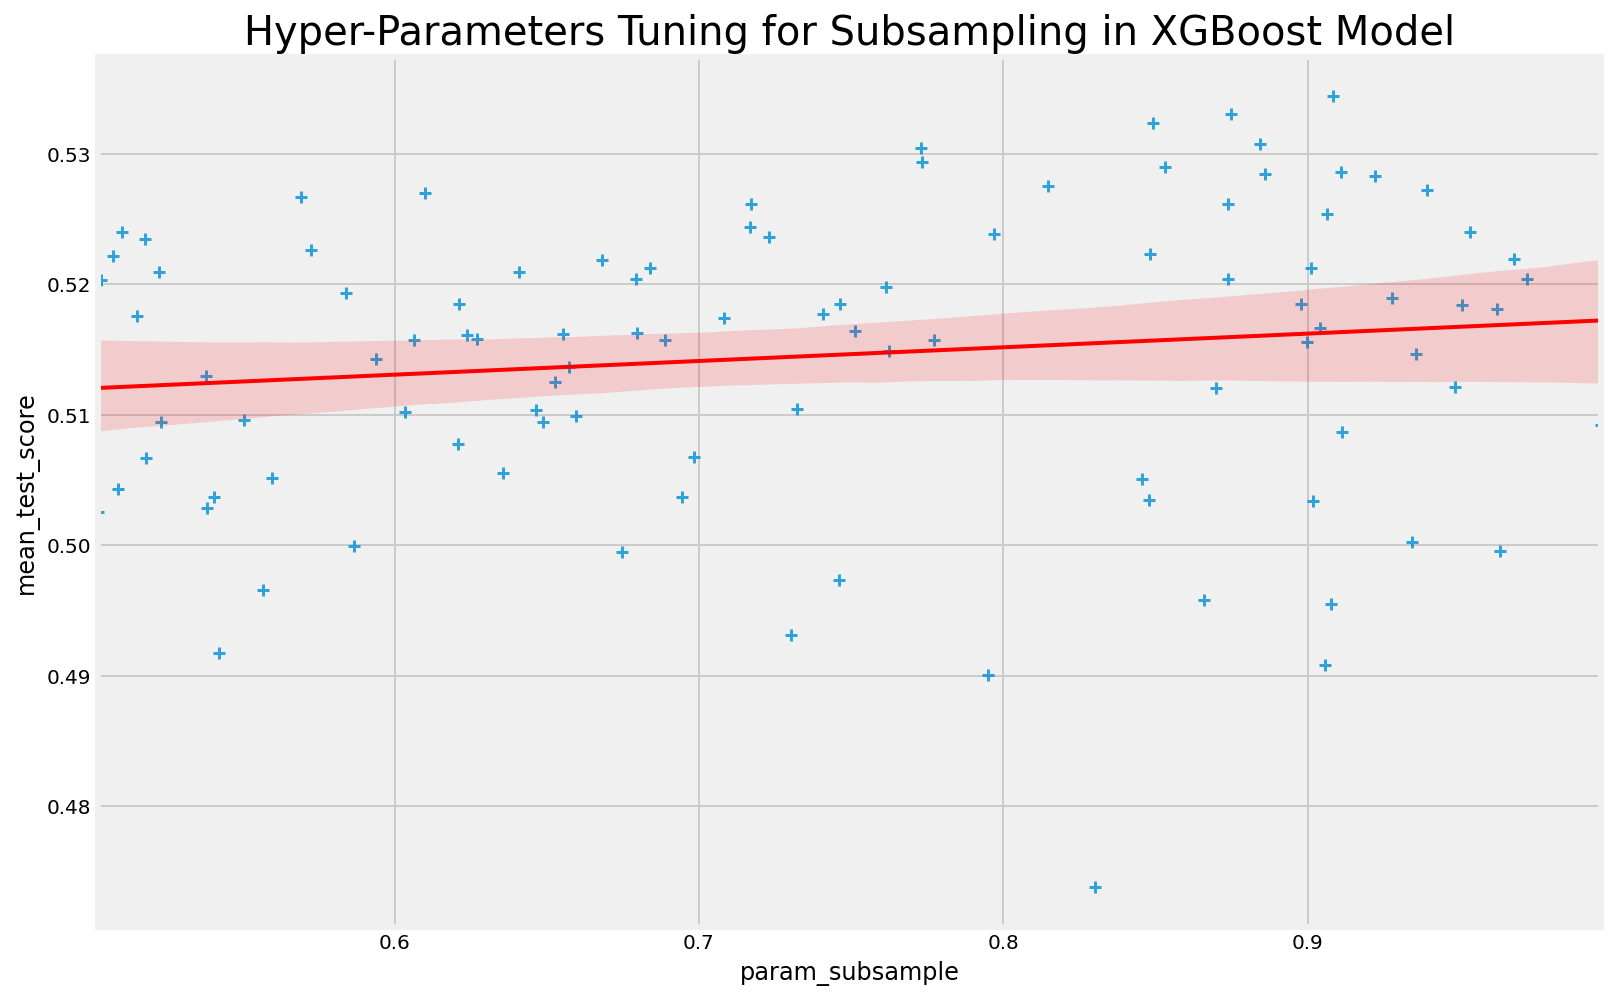

In [53]:
plt.figure(figsize=[12,8])
plt.title("Hyper-Parameters Tuning for Subsampling in XGBoost Model", size=20)
sns.regplot(data=df_rs_xgbT_nnlp_f1,
            x='param_subsample',
            y='mean_test_score',
            marker="+", scatter_kws={"lw": 1.5},
            line_kws={"lw": 2, "color": "r"})
plt.savefig("../assets/hparams_xgbT_nnlp_f1_subsample.png", transparent=True, bbox_inches='tight')
plt.show()

The parameter `subsample` is positively correlated with the CV scores. As subsampling size increases, CV score increases. Subsampling is a technique used to tamper the learning of over-fitting models by sampling a random subset of our data points (rows) for each CV model. As our model indicates a positive relationship between `subsample` and `mean_test_score`, this means that our model is currently under-fitting. In this case, we should therefore not bother with subsampling and revert to the default `subsample` of 1 (100% of training set).

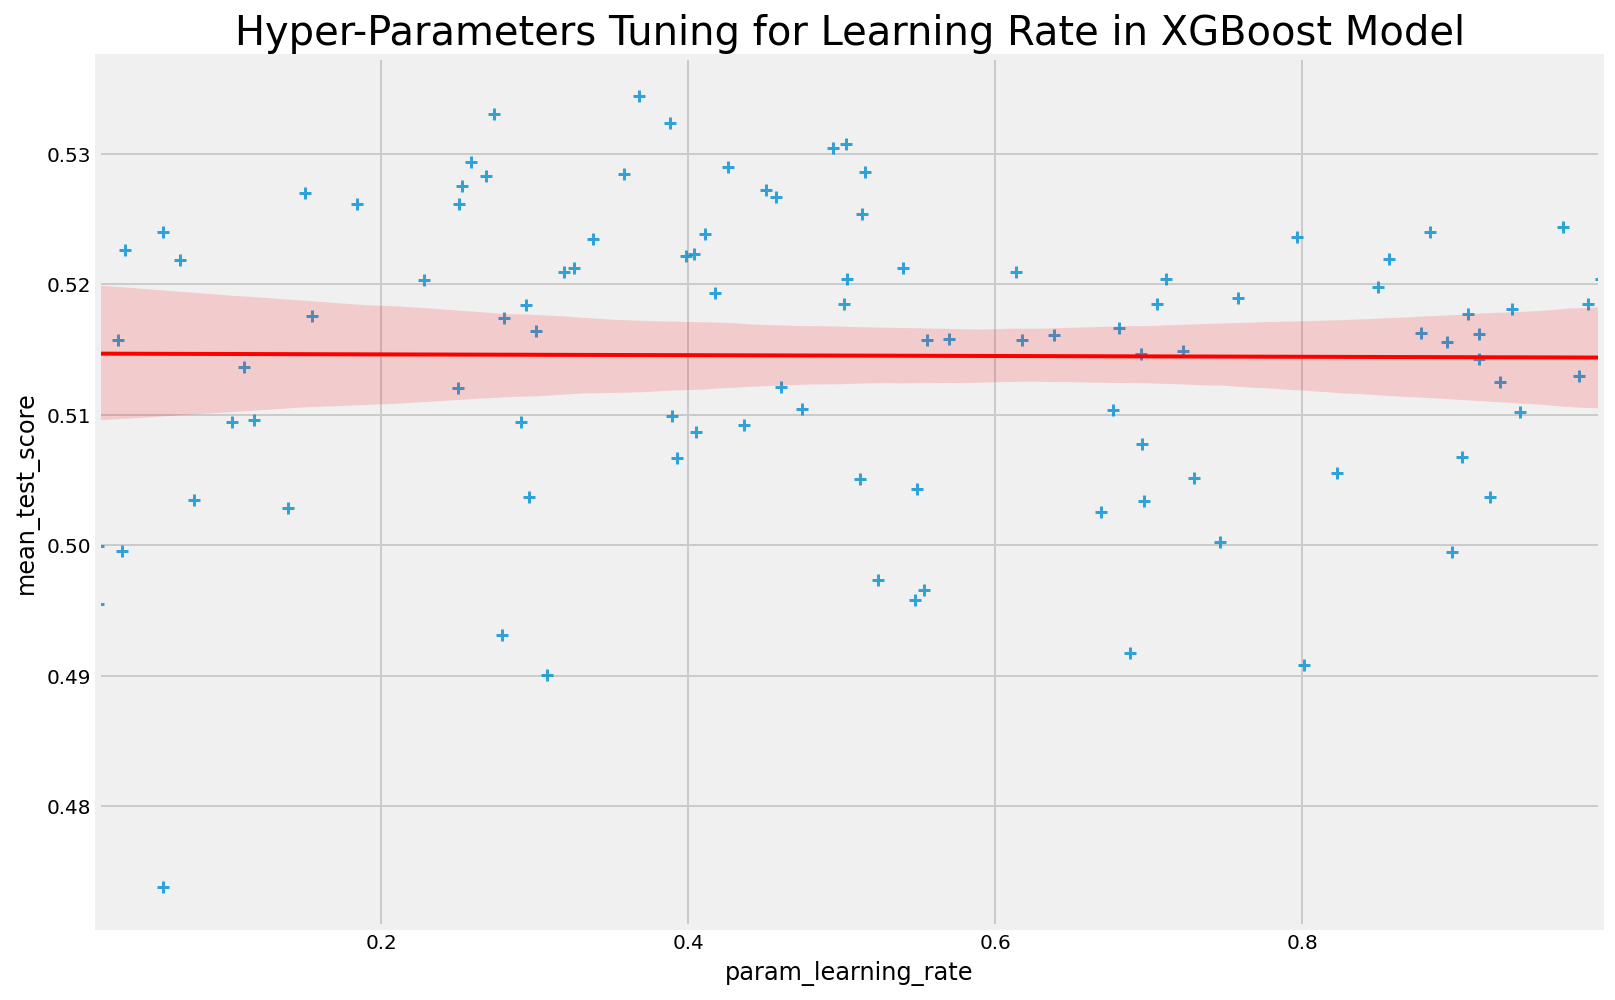

In [54]:
plt.figure(figsize=[12,8])
plt.title("Hyper-Parameters Tuning for Learning Rate in XGBoost Model", size=20)
sns.regplot(data=df_rs_xgbT_nnlp_f1,
            x='param_learning_rate',
            y='mean_test_score',
            marker="+", scatter_kws={"lw": 1.5},
            line_kws={"lw": 2, "color": "r"})
plt.savefig("../assets/hparams_xgbT_nnlp_f1_learning.png", transparent=True, bbox_inches='tight')
plt.show()

The parameter `learning_rate` appears to be flat relative to our CV scores, suggesting that there is not any improvement in CV score for every unit change in `learning_rate`.

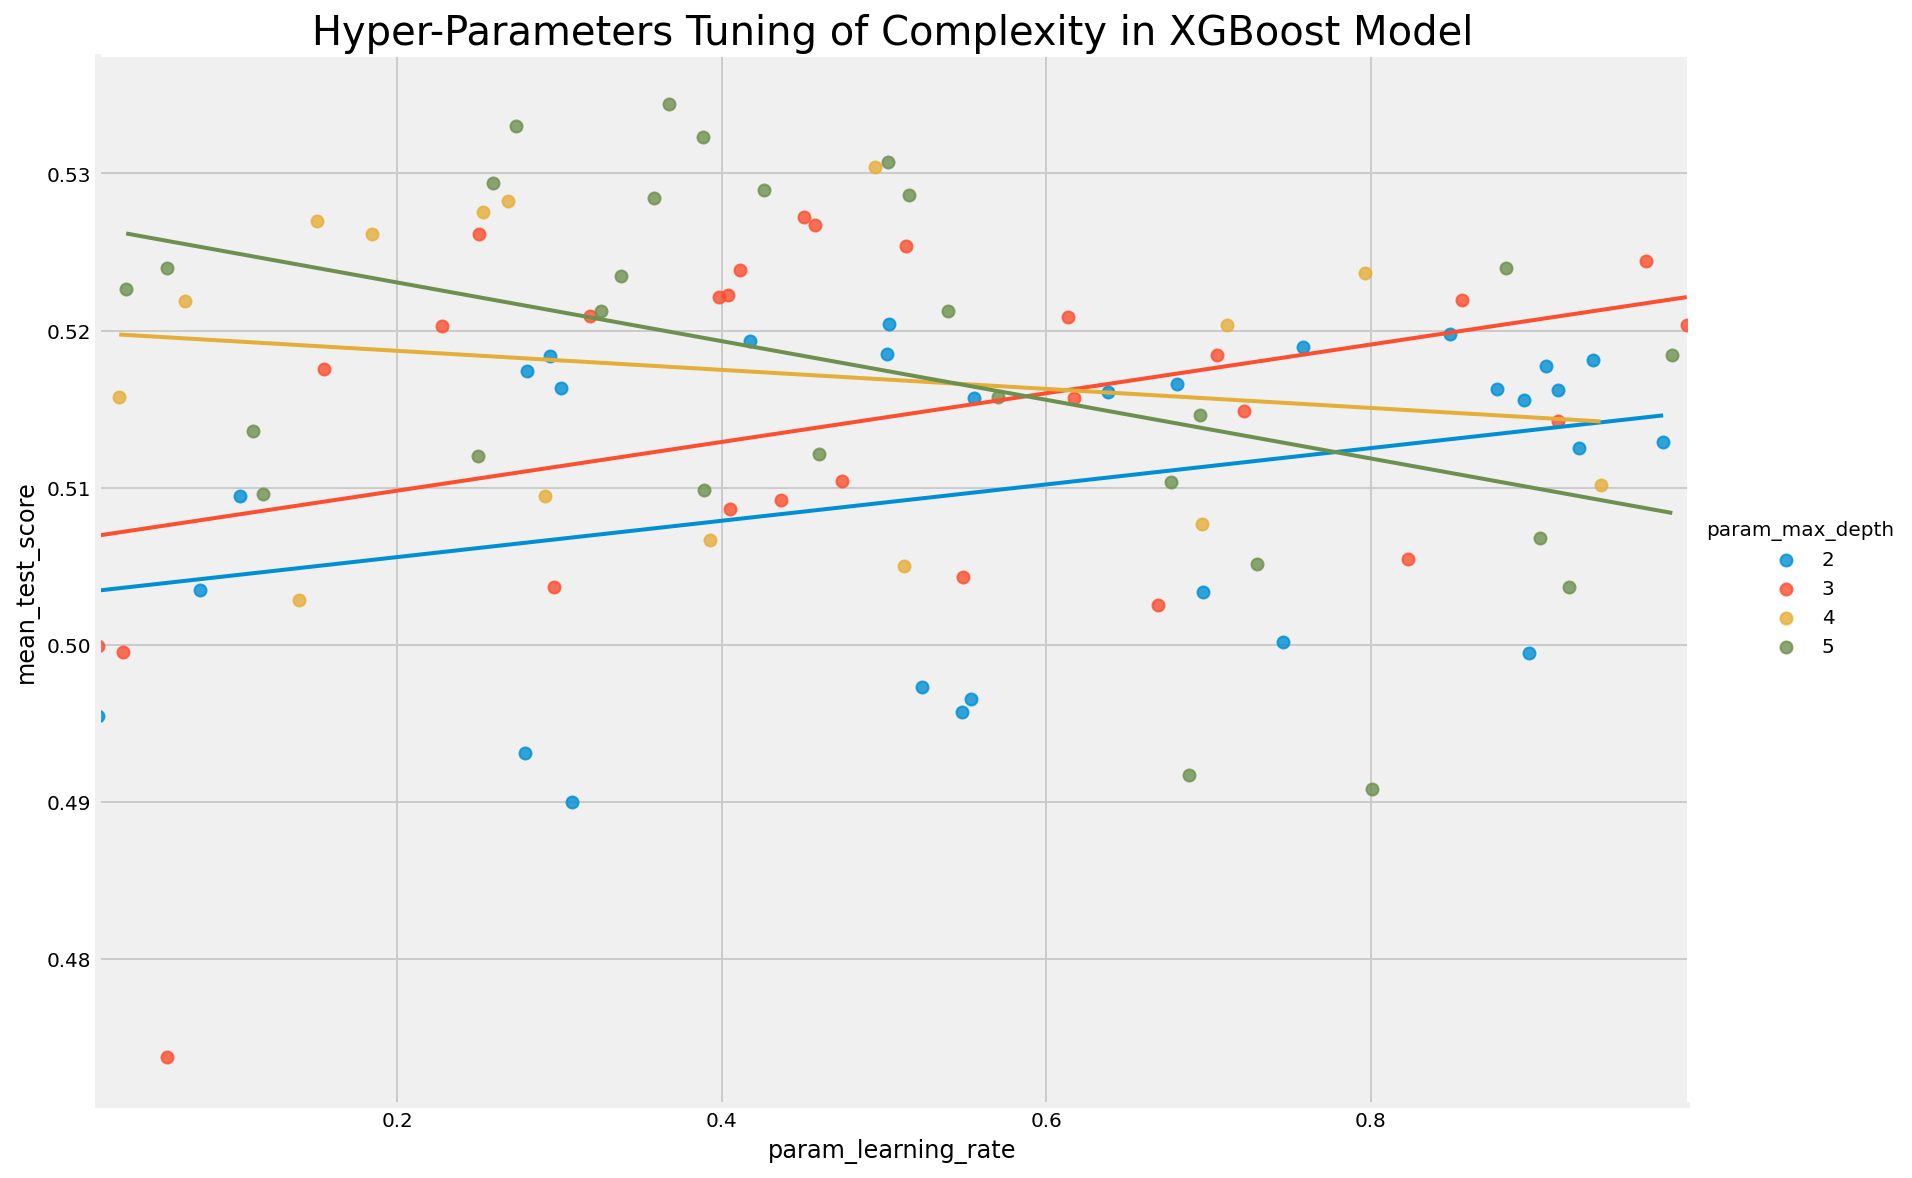

In [59]:
sns.lmplot(data=df_rs_xgbT_nnlp_f1,
           x='param_learning_rate',
           y='mean_test_score',
           hue='param_max_depth', fit_reg=True, ci=None,
           height=8, aspect=1.5, line_kws={"lw": 2})
plt.gcf()
plt.title("Hyper-Parameters Tuning of Complexity in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nnlp_f1_complex.png", transparent=True, bbox_inches='tight')
plt.show()


We can tune complexity of our model using both `max_depth` and `learning_rate`. The first allows us to control the size of each tree, the latter controls the size of each gradient descent step towards our loss minima. When we evaluate `learning_rate` against `max_depth`, it appears that a bigger and deeper tree gives us a better CV score when `learning_rate` is small, but a smaller tree gives us a better CV score when `learning rate` increases past just before 0.6.

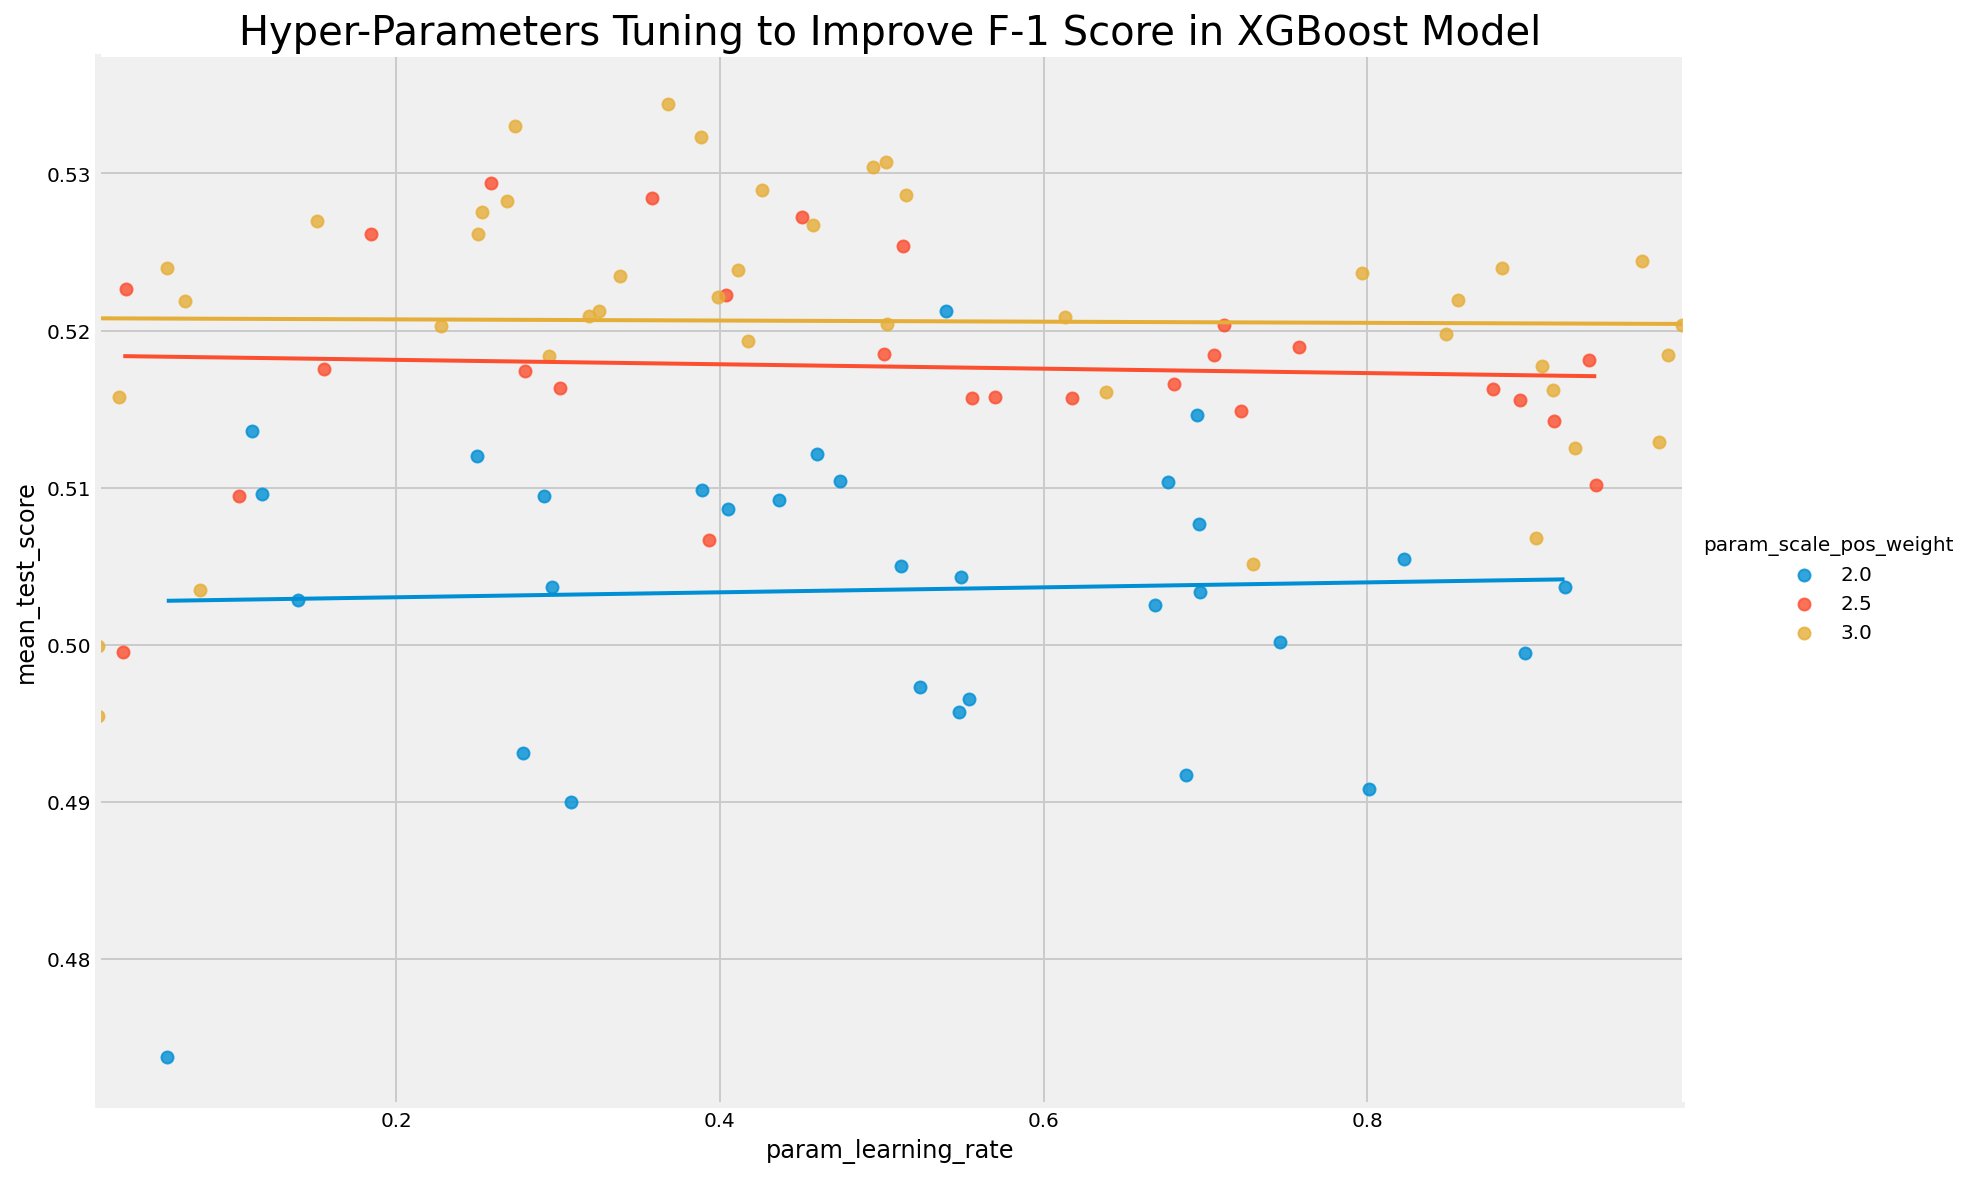

In [60]:
sns.lmplot(data=df_rs_xgbT_nnlp_f1,
           x='param_learning_rate',
           y='mean_test_score',
           hue='param_scale_pos_weight', fit_reg=True, ci=None,
           height=8, aspect=1.5, line_kws={"lw": 2})
plt.gcf()
plt.title("Hyper-Parameters Tuning to Improve F-1 Score in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nnlp_f1_improve.png", transparent=True, bbox_inches='tight')
plt.show()

As observed, `learning_rate` appears to be flat-lined against our CV scores. Grouping the markers into their respective `scale_pos_weight`, we can observe more clearly the impact of increasing the weight of our minority positive class. A higher `scale_pos_weight` value will give us a higher F-1 score.

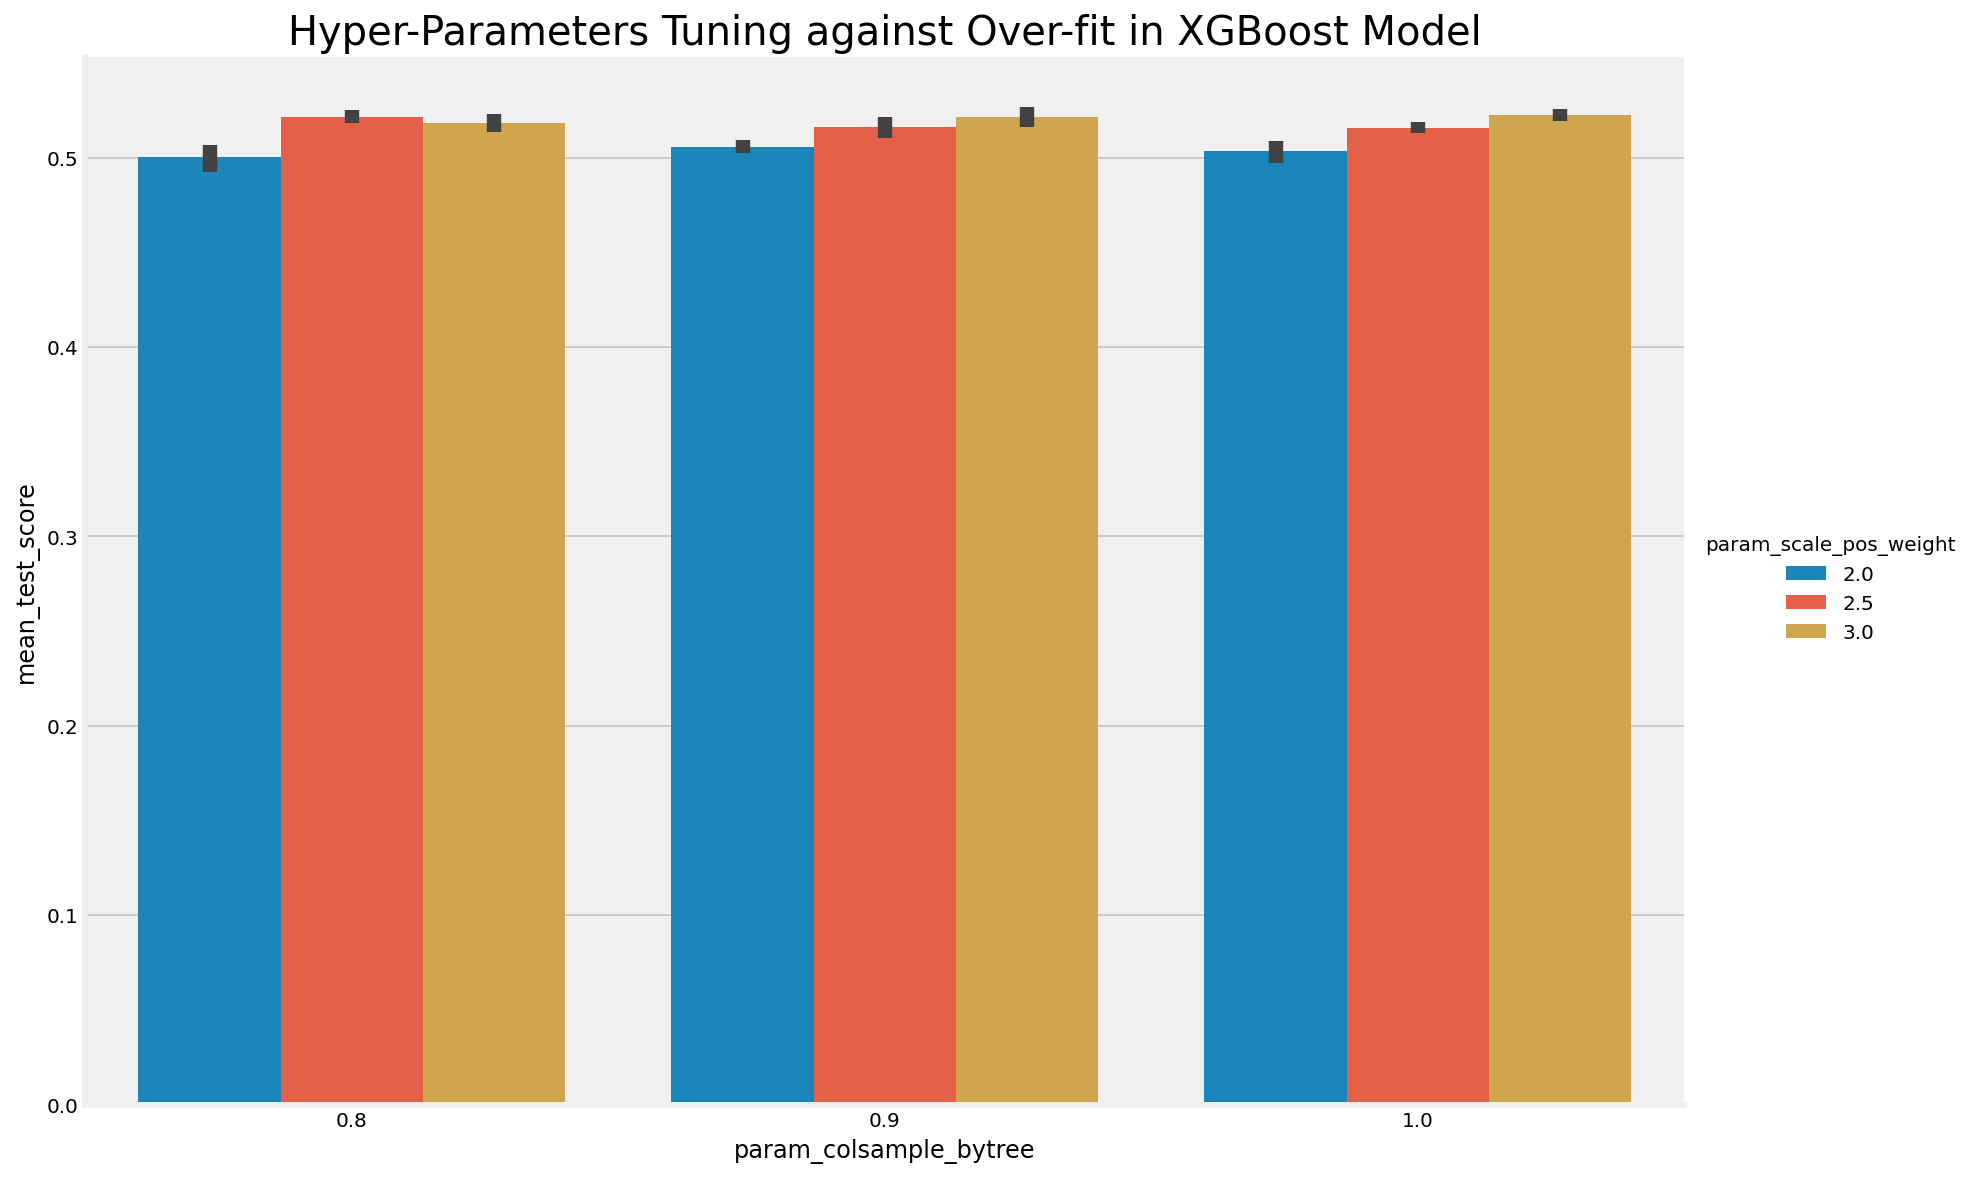

In [61]:
sns.catplot(data=df_rs_xgbT_nnlp_f1,
            x='param_colsample_bytree',
            y='mean_test_score',
            hue='param_scale_pos_weight',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning against Over-fit in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nnlp_f1_overfit.png", transparent=True, bbox_inches='tight')
plt.show()

The parameter `colsample_bytree` is the sampling ratio of our columns/features of each CV model. It is the other dimension to subsampling data rows as we have seen in `subsample`. Apart from the positive trend between `scale_pos_weight` and our CV scores, there is no perceptible pattern here.

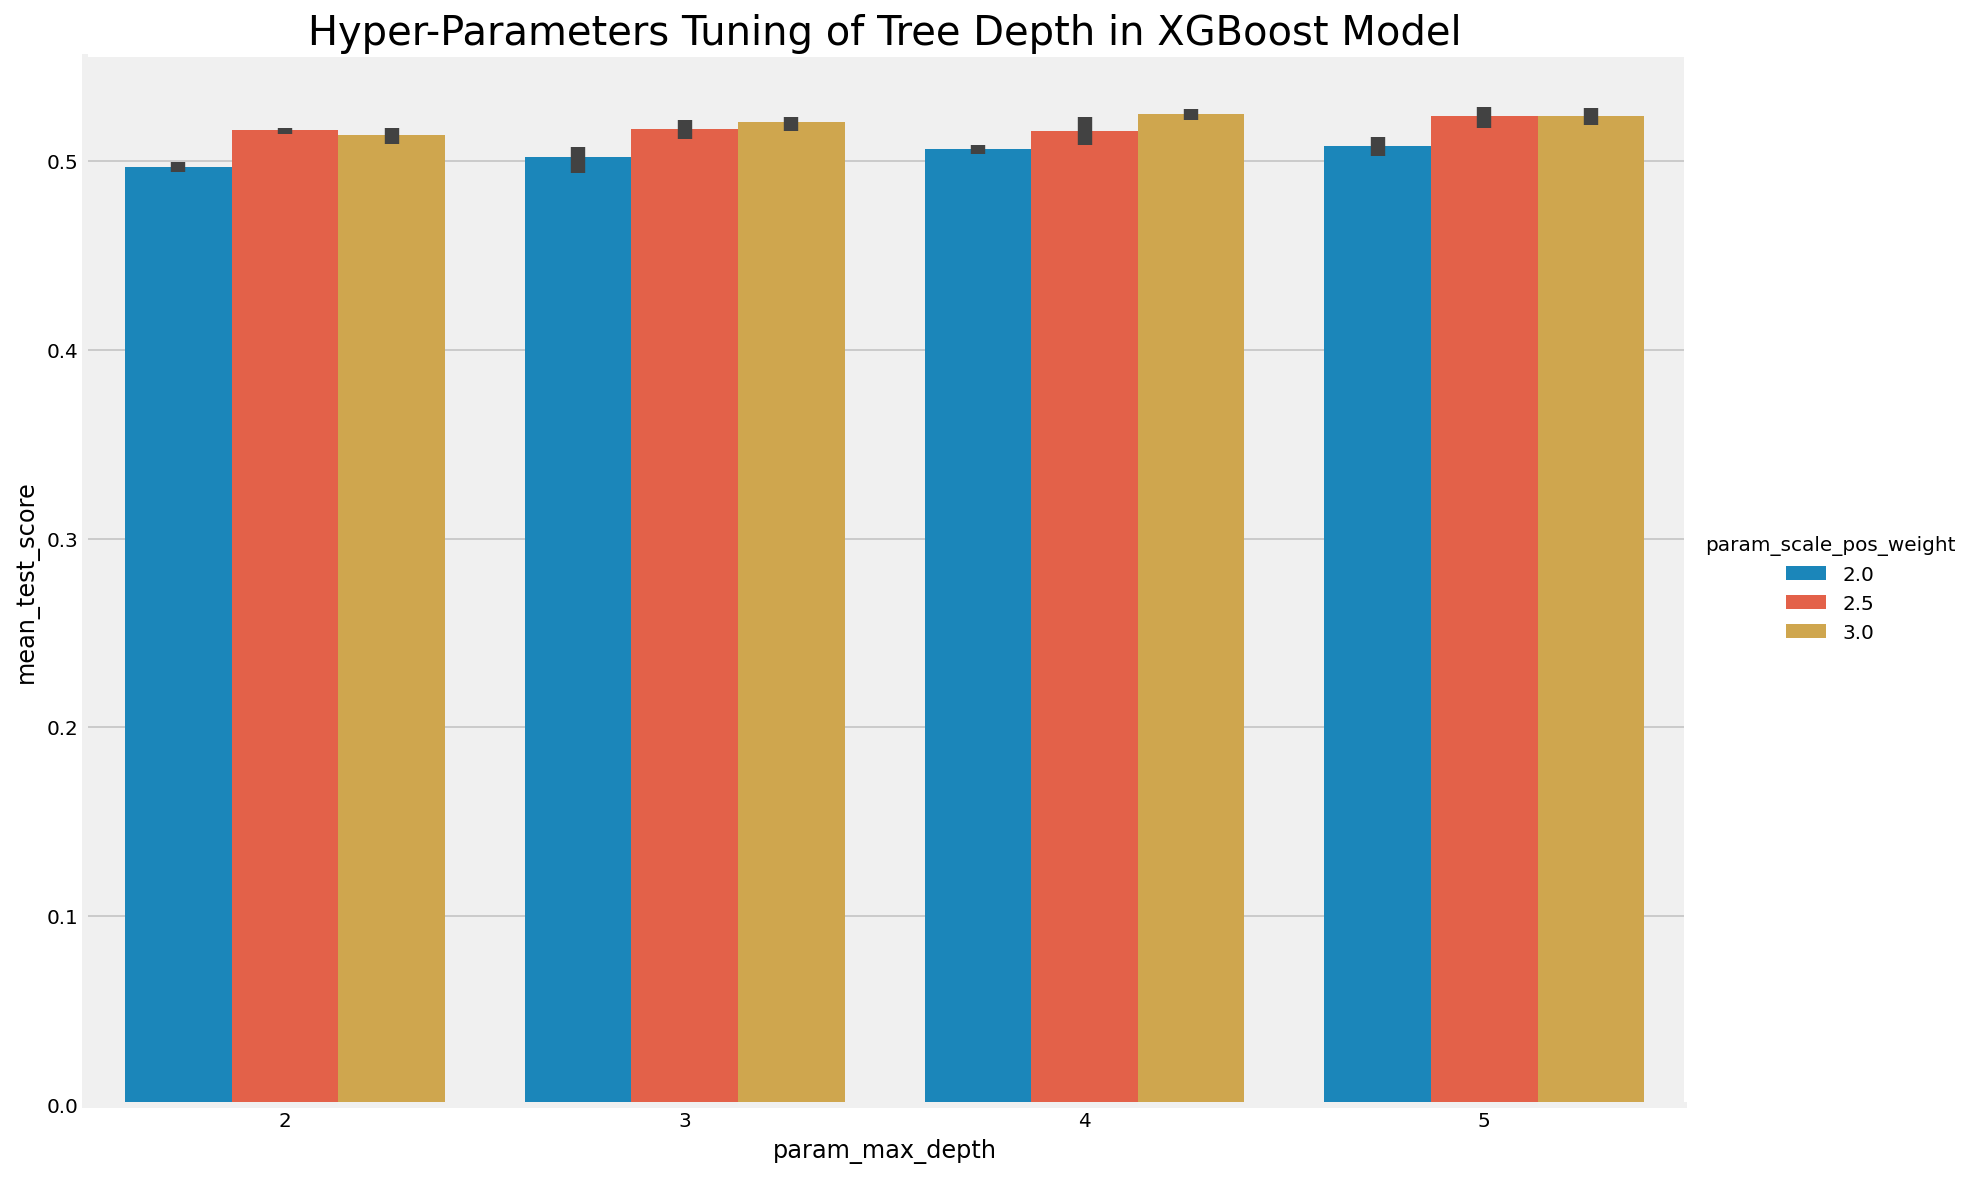

In [62]:
sns.catplot(data=df_rs_xgbT_nnlp_f1,
            x='param_max_depth',
            y='mean_test_score',
            hue='param_scale_pos_weight',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning of Tree Depth in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nnlp_f1_depth.png", transparent=True, bbox_inches='tight')
plt.show()

The parameter `max_depth` allows us to control the growth of our trees by limiting the number of levels of branches possible per tree. There appears to be a slight positive trend between `max_depth` and our CV scores. The bar chart also groups by `scale_pos_weight`, which is a useful parameter that adds weight to our minority positive class. We can observe that the heavier weighted positive classes in general allowed for better training and CV scores.

#### Further Optimisation

Best XGBoost Model (Tree) Hyper-Parameters for non-NLP:
```
{'colsample_bytree': 0.9,
 'gamma': 0,
 'learning_rate': 0.3677831327192532,
 'max_depth': 5,
 'min_child_weight': 1,
 'reg_alpha': 5,
 'reg_lambda': 5,
 'scale_pos_weight': 3,
 'subsample': 0.908215936609692}
```

L1 and L2 regularisation through `reg_alpha` and `reg_lambda` respectively found its optimal value within the range of arguments provided during our randomised grid search. As such, we shall take these values as final.

The `gamma` parameter sets the minimum loss threshold for a split, effectively pruning the tree's growth and helping to reduce over-fitting of trees. It is recommended to tune this parameter after all other parameters have been fixed. We shall leave it at its default value of 0 for now.

The optimal value for `scale_pos_weight` was found at the upper limit of input arguments at 3. In a training set whereby there is an imbalance in classes, this is a parameter that incentivises the model to learn more of the minority positive class (popular = 1) by adding weight to the minority value. Since our heatmap and other charts suggest an outsized impact of `scale_pos_weight` on our CV scores, we shall test a range of arguments greater than 3 and at larger intervals than before to see how far we can push the optimisation ofour parameter.

For `learning_rate`, the optimal value was found to be at about 0.37. Even though we fed as input argument for the randomised grid search a uniform distribution of values from 0.0 to 1.0, suggesting that this is likely its optimal value after 100 iterations, our chart suggests that the `learning_rate`has, in fact, no impact on our CV scores. Nonetheless, common wisdom states that smaller learning steps will allow us to find our loss function's minima better, but at a cost in computational time. We shall test a range of smaller learning steps to see if it improves our CV score.

The parameter `max_depth` was given a range of random integers from 2 to 5 and the upper limit of 5 was chosen as optimal. We shall test arguments greater than 5 to find the optimal value.

Parameter `min_child_weight` was given a range of random integers from 0 to 4 and the optimal value was found to be at 1. We will therefore accept this value as the optimal.

Since the `subsample` optimal value was given to be 0.91 but we believe our model to currently be under-fitting from our charts, we shall test both 0.9 and 1.0 to see which gives us a better result.

Similarly for `colsample_bytree` which samples from the column axis as a technique to reduce over-fitting of model, we shall test the recommended 0.9 with our suspected optimal value of 1.0 and see which gives us a better score.

In [40]:
# instantiate XGB model
xgbT = xgb.XGBClassifier(booster="gbtree", objective="binary:logistic")

# set hyper params to tune
pipe_params_xgbT = {
    "reg_alpha": [5],
    "reg_lambda": [5],
    "gamma": [0],
    "scale_pos_weight": [3, 5, 7, 9], # best argm was the upper limit at 3
    "learning_rate": [0.1, 0.2, 0.3, 0.4], # chart suggests learning rate does not matter
    "max_depth": [5, 6, 7], # best argm was the upper limit at 5
    "min_child_weight": [1],
    "subsample": [0.9, 1], # recommended 0.91, but suspected optimal value is 1.0
    "colsample_bytree": [0.9, 1] # recommended 0.9, but suspected optimal value is 1.0
}

In [41]:
%%time
np.random.seed(42)
gs_xgbT_nnlp_f1 = GridSearchCV(estimator=xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="f1")
gs_xgbT_nnlp_f1.fit(X_nnlp_train_dumm, y_train)
print("Best score in Grid Search:", gs_xgbT_nnlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nnlp_f1.best_params_

Best score in Grid Search: 0.5391525355826882

Using the following hyper-parameters:
Wall time: 23min 39s


{'colsample_bytree': 0.9,
 'gamma': 0,
 'learning_rate': 0.2,
 'max_depth': 7,
 'min_child_weight': 1,
 'reg_alpha': 5,
 'reg_lambda': 5,
 'scale_pos_weight': 3,
 'subsample': 1}

The optimal `scale_pos_weight` value remained at previously recommended value of 3. We have therefore found our optimal value.

For `learning_rate`, optimal value was found at the middling argument of 0.2. We have also found our optimal learning step size.

Grid search demands bigger and deeper tree as it recommends the upper limit of 7 for our `max_depth` parameter. We shall test larger depth values.

As suspected, the optimal `subsample` value is 1. We shall accept this as our optimal value.

It is a little unexpected that the optimal value for `colsample_bytree` is 0.9 and not the theorised 1.0. This may indicate that our model is not under-fitting as much as we suspect. We shall fix this as our optimal value.

In [42]:
# instantiate XGB model
xgbT = xgb.XGBClassifier(booster="gbtree", objective="binary:logistic")

# set hyper params to tune
pipe_params_xgbT = {
    "reg_alpha": [5],
    "reg_lambda": [5],
    "gamma": [0],
    "scale_pos_weight": [3],
    "learning_rate": [0.2],
    "max_depth": [7, 8, 9, 10], # best argm was the upper limit at 7
    "min_child_weight": [1],
    "subsample": [1],
    "colsample_bytree": [0.9]
}

In [43]:
%%time
np.random.seed(42)
gs_xgbT_nnlp_f1 = GridSearchCV(estimator=xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="f1")
gs_xgbT_nnlp_f1.fit(X_nnlp_train_dumm, y_train)
print("Best score in Grid Search:", gs_xgbT_nnlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nnlp_f1.best_params_

Best score in Grid Search: 0.5391525355826882

Using the following hyper-parameters:
Wall time: 46.5 s


{'colsample_bytree': 0.9,
 'gamma': 0,
 'learning_rate': 0.2,
 'max_depth': 7,
 'min_child_weight': 1,
 'reg_alpha': 5,
 'reg_lambda': 5,
 'scale_pos_weight': 3,
 'subsample': 1}

The optimal `max_depth` value remained at 7. We will therefore take 7 as our optimal value.

Since we have fixed all our hyper-parameters, we shall now tune our `gamma` values.

In [44]:
# instantiate XGB model
xgbT = xgb.XGBClassifier(booster="gbtree", objective="binary:logistic")

# set hyper params to tune
pipe_params_xgbT = {
    "reg_alpha": [5],
    "reg_lambda": [5],
    "gamma": [0, 0.05, 0.1, 0.2, 0.4, 0.8], # tune gamma
    "scale_pos_weight": [3],
    "learning_rate": [0.2],
    "max_depth": [7],
    "min_child_weight": [1],
    "subsample": [1],
    "colsample_bytree": [0.9]
}

In [45]:
%%time
np.random.seed(42)
gs_xgbT_nnlp_f1 = GridSearchCV(estimator=xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="f1")
gs_xgbT_nnlp_f1.fit(X_nnlp_train_dumm, y_train)
print("Best score in Grid Search:", gs_xgbT_nnlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nnlp_f1.best_params_

Best score in Grid Search: 0.5407217277311924

Using the following hyper-parameters:
Wall time: 56.1 s


{'colsample_bytree': 0.9,
 'gamma': 0.05,
 'learning_rate': 0.2,
 'max_depth': 7,
 'min_child_weight': 1,
 'reg_alpha': 5,
 'reg_lambda': 5,
 'scale_pos_weight': 3,
 'subsample': 1}

Through grid searching, the optimal `gamma` valus recommended was 0.05. This means that `gamma` does positively impact our CV scores. To find the best optimal `gamma` value, we shall test through a randomised grid search by inputting a skewed probability distribution with mean centred about 0.05.

In [46]:
# instantiate XGB model
xgbT = xgb.XGBClassifier(booster="gbtree", objective="binary:logistic")

# set hyper params to tune
pipe_params_xgbT = {
    "reg_alpha": [5],
    "reg_lambda": [5],
    "gamma": truncnorm(a=0, b=1, loc=0.05, scale=0.1), # skewed pdf with mean centred about 0.05
    "scale_pos_weight": [3],
    "learning_rate": [0.2],
    "max_depth": [7],
    "min_child_weight": [1],
    "subsample": [1],
    "colsample_bytree": [0.9]
}

In [47]:
%%time
np.random.seed(42)
rs_xgbT_nnlp_f1 = RandomizedSearchCV(estimator=xgbT, param_distributions=pipe_params_xgbT,
                                     n_iter=50, cv=4, scoring="f1")
rs_xgbT_nnlp_f1.fit(X_nnlp_train_dumm, y_train)
print("Best score in Randomised Search:", rs_xgbT_nnlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
rs_xgbT_nnlp_f1.best_params_

Best score in Randomised Search: 0.5392005049622477

Using the following hyper-parameters:
Wall time: 7min 29s


{'colsample_bytree': 0.9,
 'gamma': 0.05294279043507453,
 'learning_rate': 0.2,
 'max_depth': 7,
 'min_child_weight': 1,
 'reg_alpha': 5,
 'reg_lambda': 5,
 'scale_pos_weight': 3,
 'subsample': 1}

Through a randomised grid search, the optimal `gamma` value recommended was 0.053. However, our previous `gamma` score of 0.05 gave us a better CV score than what we have in this grid search. We shall therefore fix our optimal `gamma` value at 0.05.

We have re-tuned our hyper-parameters and optimised on the F-1 score for our non-NLP model!

### Model_02

Using re-tuned hyper-parameters from above, we shall build our individual NLP and non-NLP model. Both models will be built using `XGBClassifier` that has consistently gave us our best result thus far.

#### NLP_02

Using the best hyper-parameters for NLP model from Grid Search:
```
{'tvec__max_features': 7500,
 'tvec__ngram_range': (1, 2),
 'xgboost__colsample_bytree': 1,
 'xgboost__gamma': 0,
 'xgboost__learning_rate': 0.25,
 'xgboost__max_depth': 10,
 'xgboost__min_child_weight': 2,
 'xgboost__reg_alpha': 2,
 'xgboost__reg_lambda': 4,
 'xgboost__scale_pos_weight': 3,
 'xgboost__subsample': 1}
```
Let's build our XGBoost model using tuned hyper-parameters and evaluate its performance.

In [10]:
# match best params from above for TfidfVectorizer
tvec = TfidfVectorizer(stop_words="english", max_features=7500, ngram_range=(1,2))
X_train_tvec = tvec.fit_transform(X_nlp_train)
print("Shape of training sparse matrix:", X_train_tvec.shape)
X_unseen_tvec = tvec.transform(X_nlp_unseen)
print("Shape of test sparse matrix:", X_unseen_tvec.shape)

Shape of training sparse matrix: (18050, 7500)
Shape of test sparse matrix: (6017, 7500)


In [11]:
%%time
xgboost_nlp_02 = xgb.XGBClassifier(booster="gbtree",
                                objective="binary:logistic",
                                colsample_bytree=1,
                                gamma=0,
                                learning_rate=0.25,
                                max_depth=10,
                                min_child_weight=2,
                                reg_alpha=2,
                                reg_lambda=4,
                                scale_pos_weight=3,
                                subsample=1)

xgboost_nlp_02.fit(X_train_tvec, y_train) # use vectorized word features from before

Wall time: 18.6 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=10,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=2, reg_lambda=4, scale_pos_weight=3, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
# get predictions on unseen test set
xgb_nlp_predictions_02 = xgboost_nlp_02.predict(X_unseen_tvec)
eval_classifier(y_unseen, xgb_nlp_predictions_02) # evaluate predictions

True Negatives: 3361
False Positives: 904
False Negatives: 615
True Positives: 1137

ROC-AUC score: 0.719
Accuracy: 0.748
Recall: 0.649
Specificity: 0.788
Precision: 0.557
F-1 score: 0.6


|*Confusion Matrix*|Predicted Negatives|Predicted Positives*|
|---|---|---|
|**Actual Negatives**|3361|904|
|**Actual Positives**|615|1137|

<p style="text-align:right;"><sup>*predict for <i>popularity</i></sup></p>

Looking at the score, Our **ROC-AUC score** improved slightly for our NLP model to a 0.719. This is because ROC-AUC measures recall against specificity, and our recall and specificity are scored at 0.649 and 0.788 respectively. This means that our model has a better hit-rate for correctly classifying negative than positive classes.

- For recall, our model is able to correctly predict 64.9% of our **True Positive** or TP (popular) classes.
- For specificity, our model is able to correctly predict 78.8% of our **True Negative** or TN  (unpopular) classes.

However, our model still scores worst on precision, albeit an improvement from the first NLP model, resulting in an **F-1 score** of 0.600. This is because the F-1 score is calculated as the harmonic mean of recall against precision.

- Since our model has a recall of 0.649 - which means we are able to correctly classify 64.9% of the total possible true positive (popular) classes, it means we are misclassifying the negative (unpopular) classes 35.1% of the time. This results in our **False Negatives** or FN (actually popular) classification.
- But, it has a precision of only 0.600 - which translates to a predictive accuracy of only 60.0% for our positive (popular) predictions, which means we are misclassifying the positive (popular) classes 40.0% of the time. This results in our **False Positives** or FP (actually unpopular) classification.

We should consider which misclassification, FN or FP, that we would prefer to minimise as there is always going to be a trade-off between recall and precision.

#### nNLP_02

Using the best hyper-parameters for non-NLP model from Grid Search:
```
 {'colsample_bytree': 0.9,
 'gamma': 0.05294279043507453,
 'learning_rate': 0.2,
 'max_depth': 7,
 'min_child_weight': 1,
 'reg_alpha': 5,
 'reg_lambda': 5,
 'scale_pos_weight': 3,
 'subsample': 1}
```
Let's build our XGBoost model using tuned hyper-parameters and evaluate its performance.

In [15]:
%%time
xgboost_nnlp_02 = xgb.XGBClassifier(booster="gbtree",
                                objective="binary:logistic",
                                colsample_bytree=0.9,
                                gamma=0.05,
                                learning_rate=0.2,
                                max_depth=7,
                                min_child_weight=1,
                                reg_alpha=5,
                                reg_lambda=5,
                                scale_pos_weight=3,
                                subsample=1)

xgboost_nnlp_02.fit(X_nnlp_train_dumm, y_train)

Wall time: 2.73 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.05, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=5, reg_lambda=5, scale_pos_weight=3, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
# get predictions on unseen test set
xgb_nnlp_predictions_02 = xgboost_nnlp_02.predict(X_nnlp_unseen_dumm)
eval_classifier(y_unseen, xgb_nnlp_predictions_02) # evaluate predictions

True Negatives: 2645
False Positives: 1620
False Negatives: 496
True Positives: 1256

ROC-AUC score: 0.669
Accuracy: 0.648
Recall: 0.717
Specificity: 0.62
Precision: 0.437
F-1 score: 0.543


|*Confusion Matrix*|Predicted Negatives|Predicted Positives*|
|---|---|---|
|**Actual Negatives**|2645|1620|
|**Actual Positives**|496|1256|

<p style="text-align:right;"><sup>*predict for <i>popularity</i></sup></p>

Looking at the score, Our **ROC-AUC score** improved slightly for our non-NLP model to a 0.669. This is because ROC-AUC measures recall against specificity, and our recall and specificity are scored at 0.717 and 0.620 respectively. This means that our model has a better hit-rate for correctly classifying negative than positive classes.

- For recall, our model is able to correctly predict 71.7% of our **True Positive** or TP (popular) classes.
- For specificity, our model is able to correctly predict 62.0% of our **True Negative** or TN  (unpopular) classes.

However, our model still scores worst on precision, giving us an **F-1 score** of 0.543. This is because the F-1 score is calculated as the harmonic mean of recall against precision.

- Since our model has a recall of 0.717 - which means we are able to correctly classify 71.7% of the total possible true positive (popular) classes, it means we are misclassifying the negative (unpopular) classes 28.3% of the time. This results in our **False Negatives** or FN (actually popular) classification.
- But, it has a precision of only 0.437 - which translates to a predictive accuracy of only 43.7% for our positive (popular) predictions, which means we are misclassifying the positive (popular) classes 56.3% of the time. This results in our **False Positives** or FP (actually unpopular) classification.

We should consider which misclassification, FN or FP, that we would prefer to minimise as there is always going to be a trade-off between recall and precision.

#### Hybrid_02

In [17]:
# extract probabilities for positive predictions from both NLP and non-NLP models
nlp_proba_02 = xgboost_nlp_02.predict_proba(X_unseen_tvec)[:, 1]
nnlp_proba_02 = xgboost_nnlp_02.predict_proba(X_nnlp_unseen_dumm)[:, 1]

In [18]:
# zip and create df matching predicted probabilities from NLP and non-NLP models to target y_unseen
df_results_02 = pd.DataFrame(zip(y_unseen, nlp_proba_02, nnlp_proba_02), columns=["y_unseen", "nlp_proba", "nnlp_proba"])
df_results_02.head(3)

y_unseen  nlp_proba  nnlp_proba
0         1   0.559901    0.507159
1         1   0.952359    0.547711
2         1   0.993453    0.951298

In [19]:
# create new col for aggregated prediction probabilities from both models
df_results_02["mean_proba"] = df_results_02[["nlp_proba", "nnlp_proba"]].T.mean()
df_results_02.head(3)

y_unseen  nlp_proba  nnlp_proba  mean_proba
0         1   0.559901    0.507159    0.533530
1         1   0.952359    0.547711    0.750035
2         1   0.993453    0.951298    0.972375

In [20]:
# create new col for predicted y values
df_results_02["y_pred"] = round(df_results_02["mean_proba"]).astype(int)
df_results_02.head(3)

y_unseen  nlp_proba  nnlp_proba  mean_proba  y_pred
0         1   0.559901    0.507159    0.533530       1
1         1   0.952359    0.547711    0.750035       1
2         1   0.993453    0.951298    0.972375       1

In [21]:
# evaluate predictions
eval_classifier(y_unseen, df_results_02["y_pred"])

True Negatives: 3152
False Positives: 1113
False Negatives: 484
True Positives: 1268

ROC-AUC score: 0.731
Accuracy: 0.735
Recall: 0.724
Specificity: 0.739
Precision: 0.533
F-1 score: 0.614


|*Confusion Matrix*|Predicted Negatives|Predicted Positives*|
|---|---|---|
|**Actual Negatives**|3152|1113|
|**Actual Positives**|484|1268|

<p style="text-align:right;"><sup>*predict for <i>popularity</i></sup></p>

Looking at the score, our **ROC-AUC score** is a decent 0.731. This is because ROC-AUC measures recall against specificity, and our recall and specificity are decently scored at 0.724 and 0.739 respectively. This means that our model has a pretty good hit-rate for correctly classifying both our positive and negative classes.

- For recall, our model is able to correctly predict 72.4% of our **True Positive** or TP (popular) classes.
- For specificity, our model is able to correctly predict 73.9% of our **True Negative** or TN  (unpopular) classes.

However, our model scores poorly on precision, and consequently on the **F-1 score** at a slight-improved 0.614. This is because the F-1 score is calculated as the harmonic mean of recall against precision.

- Since our model has a recall of 0.724 - which means we are able to correctly classify 72.4% of the total possible true positive (popular) classes, it means we are misclassifying the negative (unpopular) classes 27.6% of the time. This results in our **False Negatives** or FN (actually popular) classification.
- But, its precision is still poor at only 0.533 - which translates to a predictive accuracy of only 53.3% for our positive (popular) predictions, which means we are misclassifying the positive (popular) classes 46.7% of the time. This results in our **False Positives** or FP (actually unpopular) classification.

We should consider which misclassification, FN or FP, that we would prefer to minimise as there is always going to be a trade-off between recall and precision.

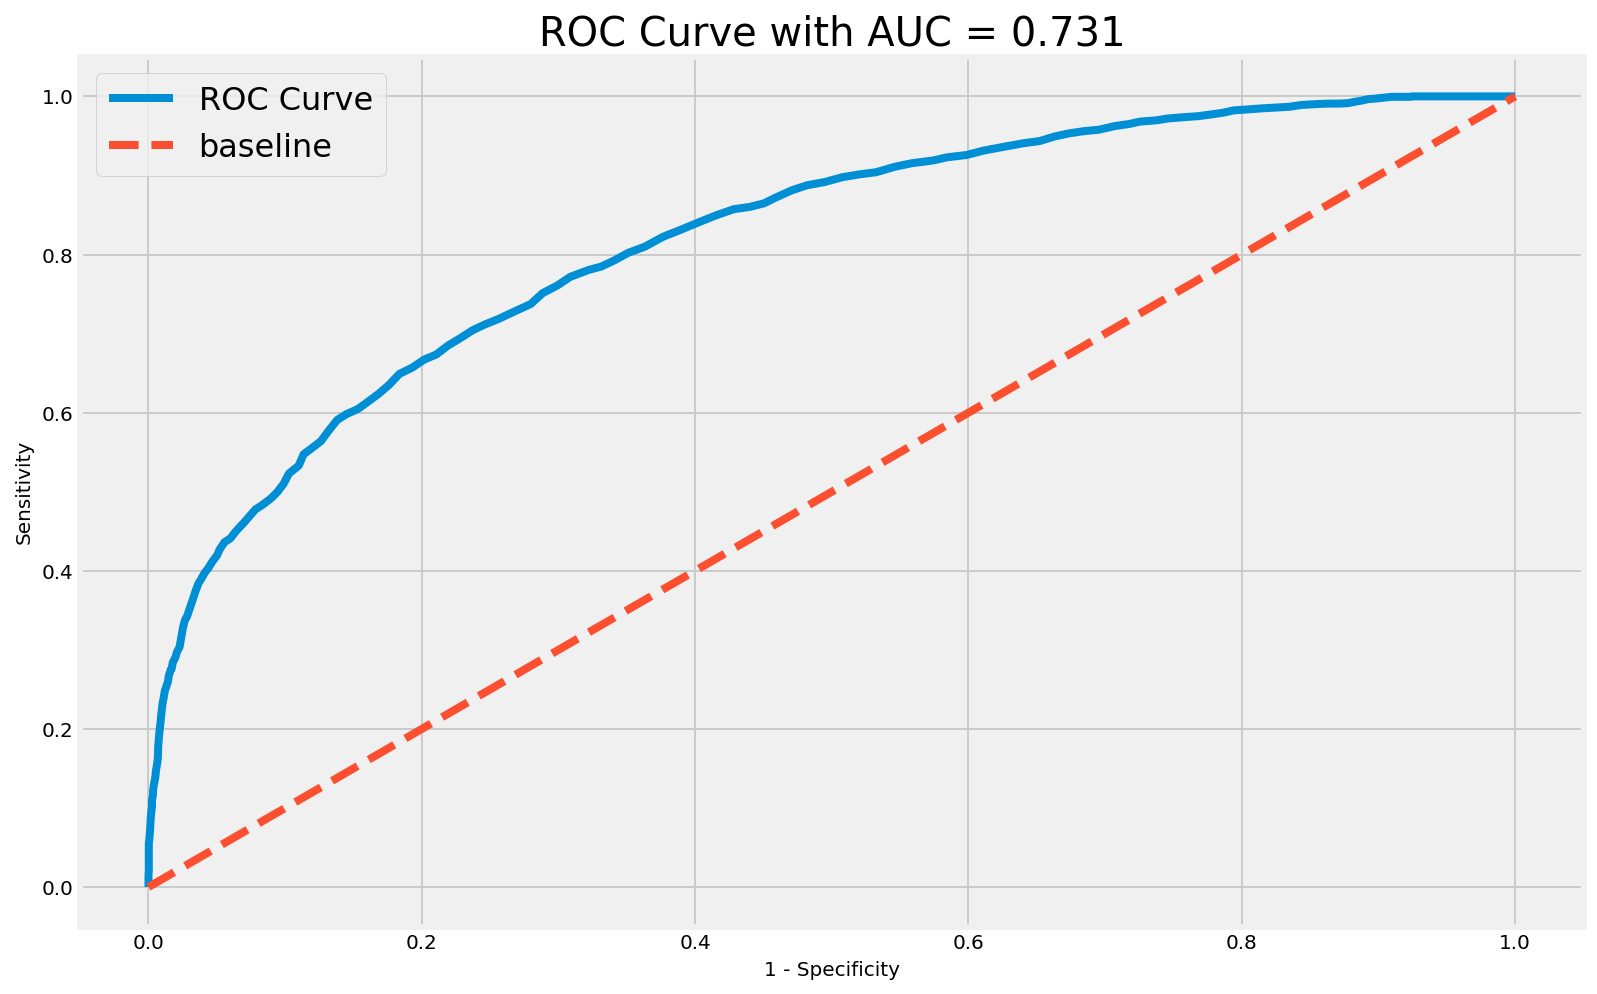

In [23]:
plot_roc_auc(df=df_results_02, y_true="y_unseen", y_proba="mean_proba", y_pred="y_pred",
             save_path="../assets/model_02_roc.png")

#### Performance Summary

|Model|Optimised on|ROC-AUC|Accuracy|Recall|Specificity|Precision|F-1 Score|
|---|---|---|---|---|---|---|---|
|baseline*|-|-|0.709|-|-|-|-|
|Hybrid_01|ROC-AUC|0.727|0.734|0.711|0.743|0.532|0.609|
|NLP_02|F-1|0.719|0.748|0.649|0.788|0.557|0.600|
|nNLP_02|F-1|0.669|0.648|0.717|0.620|0.437|0.543|
|Hybrid_02|F-1|0.731|0.735|0.724|0.739|0.533|0.614|

<p style='text-align: right;'><sub>*baseline accuracy by predicting all negative/unpopular</sub></p>


After optimising our model hyper-parameters on F-1 score, our final Hybrid_02 is outperforming Hybrid_01 on all fronts except specificity. This means that Hybrid_02 has a slightly higher misclassification rate of the negative classes, which also means that the number of FN cases is higher too. However, this is an acceptable loss since our model is performing better on our prioritised metric of precision and F-1 scores.

In such a light, let's look more closely at our Hybrid_02. While we do see an improvement of 0.005 in our F-1 score, this improvement in performance is not brought about evenly. From Hybrid_01 to Hybrid_02, our recall improved by 0.013 while our precision improved by only 0.001. Put in simplistic terms, it appears that it is only with every 13 units improvement in recall that we are able to see a one unit improvement in precision. Our model is therefore only able to optimise better for recall than for precision; for a better hit-rate of classifying the total positive classes than a higher accuracy for our positive predictions. This is likely to be a limit facing our model based on the training set we have whereby the model is only able to learn more about predicting the negative (unpopular) class and avoiding FN than about predicting the positive (popular) class and reducing FP errors.

Our model therefore appears to be resistant to optimising precision. Or, is it? Now that we have optimised our models first for ROC-AUC and then for F-1 score, perhaps we should disregard maximising both recall and precision through the F-1 score and focus on pushing precision only as far as we can push it. For the next model, let us optimise for just **precision**.
<br>
<br>
<br>
<center>* * * <sup>End Model_02</sup> * * *</center>

### Re-Tune NLP Model, Again

Let us jump ahead and use our tree-based XGBoost model since it has consistently been our best-performing model. Only difference is that this time we will select our best hyper-parameters based on the best F-1 score. The F-1 score is the harmonic mean of precision and recall, therefore maximising F-1 will allow us to also maximise both precision and recall.

#### XGBoost (Tree)

In [13]:
# build pipeline
pipe_xgbT = Pipeline(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                            ("xgboost", xgb.XGBClassifier(booster="gbtree",
                                                          objective="binary:logistic"))])

# set hyper params to tune
pipe_params_xgbT = {
    "tvec__max_features": [2500, 5000, 7500],
    "tvec__ngram_range": [(1,1), (1,2), (1,3)],
    "xgboost__reg_alpha": randint(0, 11),
    "xgboost__reg_lambda": randint(0, 11),
    "xgboost__gamma": [0],
    "xgboost__scale_pos_weight": [2, 2.5, 3], # xgb doc recommends sum(neg)/sum(pos) = 12_793/5257
    "xgboost__learning_rate": uniform(0, 1),
    "xgboost__max_depth": randint(2, 6),
    "xgboost__min_child_weight": randint(0, 5),
    "xgboost__subsample": uniform(0.5, 0.5),
    "xgboost__colsample_bytree": [0.8, 0.9, 1]
}

In [14]:
%%time
np.random.seed(42)
rs_xgbT_nlp_prec = RandomizedSearchCV(estimator=pipe_xgbT, param_distributions=pipe_params_xgbT,
                                    n_iter=100, cv=4, scoring="precision")
rs_xgbT_nlp_prec.fit(X_nlp_train, y_train)
print("Best score in Randomised Search:", rs_xgbT_nlp_prec.best_score_)
print()
print("Using the following hyper-parameters:")
rs_xgbT_nlp_prec.best_params_

Best score in Randomised Search: 0.662391854840362

Using the following hyper-parameters:
Wall time: 24min 19s


{'tvec__max_features': 2500,
 'tvec__ngram_range': (1, 3),
 'xgboost__colsample_bytree': 0.9,
 'xgboost__gamma': 0,
 'xgboost__learning_rate': 0.0516817211686077,
 'xgboost__max_depth': 5,
 'xgboost__min_child_weight': 2,
 'xgboost__reg_alpha': 6,
 'xgboost__reg_lambda': 7,
 'xgboost__scale_pos_weight': 2,
 'xgboost__subsample': 0.9847684335570794}

#### Evaluate Hyper-Parameters

In [15]:
df_rs_xgbT_nlp_prec = pd.DataFrame(rs_xgbT_nlp_prec.cv_results_)
df_rs_xgbT_nlp_prec.to_csv("../datasets/df_rs_xgbT_nlp_prec.csv", index=False) # save out df of randomized search
df_rs_xgbT_nlp_prec.info() # notice certain cols that are numeric are not numeric

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   mean_fit_time                    100 non-null    float64
 1   std_fit_time                     100 non-null    float64
 2   mean_score_time                  100 non-null    float64
 3   std_score_time                   100 non-null    float64
 4   param_tvec__max_features         100 non-null    object 
 5   param_tvec__ngram_range          100 non-null    object 
 6   param_xgboost__colsample_bytree  100 non-null    object 
 7   param_xgboost__gamma             100 non-null    object 
 8   param_xgboost__learning_rate     100 non-null    object 
 9   param_xgboost__max_depth         100 non-null    object 
 10  param_xgboost__min_child_weight  100 non-null    object 
 11  param_xgboost__reg_alpha         100 non-null    object 
 12  param_xgboost__reg_lamb

In [16]:
# re-import df
df_rs_xgbT_nlp_prec = pd.read_csv("../datasets/df_rs_xgbT_nlp_prec.csv")
df_rs_xgbT_nlp_prec.head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       4.238400      0.247218         0.453515        0.027901   
1       5.735753      0.428002         0.445701        0.022442   
2       3.739387      1.184480         0.419783        0.147714   

   param_tvec__max_features param_tvec__ngram_range  \
0                      7500                  (1, 1)   
1                      7500                  (1, 1)   
2                      5000                  (1, 2)   

   param_xgboost__colsample_bytree  param_xgboost__gamma  \
0                              1.0                     0   
1                              1.0                     0   
2                              0.8                     0   

   param_xgboost__learning_rate  param_xgboost__max_depth  ...  \
0                      0.731994                         2  ...   
1                      0.020584                         3  ...   
2                      0.431945                         2  ...   

   param_xgboost__scale_pos_weight  param_xgboost__subsample  \
0                              3.0                  0.549987   
1                              2.0                  0.808741   
2                              3.0                  0.728035   

                                              params  split0_test_score  \
0  {'tvec__max_features': 7500, 'tvec__ngram_rang...           0.462254   
1  {'tvec__max_features': 7500, 'tvec__ngram_rang...           0.606277   
2  {'tvec__max_features': 5000, 'tvec__ngram_rang...           0.472480   

   split1_test_score split2_test_score  split3_test_score  mean_test_score  \
0           0.474289          0.488584           0.486805         0.477983   
1           0.659468          0.649416           0.654321         0.642370   
2           0.486761          0.505855           0.494152         0.489812   

   std_test_score  rank_test_score  
0        0.010621               98  
1        0.021140                3  
2        0.012103               94  

[3 rows x 23 columns]

In [25]:
# convert all cols that can be numeric into numeric dtypes
df_rs_xgbT_nlp_prec["param_tvec__max_features"] = df_rs_xgbT_nlp_prec["param_tvec__max_features"].astype(int)
df_rs_xgbT_nlp_prec["param_xgboost__colsample_bytree"] = df_rs_xgbT_nlp_prec["param_xgboost__colsample_bytree"].astype(float)
df_rs_xgbT_nlp_prec["param_xgboost__gamma"] = df_rs_xgbT_nlp_prec["param_xgboost__gamma"].astype(float)
df_rs_xgbT_nlp_prec["param_xgboost__learning_rate"] = df_rs_xgbT_nlp_prec["param_xgboost__learning_rate"].astype(float)
df_rs_xgbT_nlp_prec["param_xgboost__max_depth"] = df_rs_xgbT_nlp_prec["param_xgboost__max_depth"].astype(int)
df_rs_xgbT_nlp_prec["param_xgboost__min_child_weight"] = df_rs_xgbT_nlp_prec["param_xgboost__min_child_weight"].astype(int)
df_rs_xgbT_nlp_prec["param_xgboost__reg_alpha"] = df_rs_xgbT_nlp_prec["param_xgboost__reg_alpha"].astype(int)
df_rs_xgbT_nlp_prec["param_xgboost__reg_lambda"] = df_rs_xgbT_nlp_prec["param_xgboost__reg_lambda"].astype(int)
df_rs_xgbT_nlp_prec["param_xgboost__scale_pos_weight"] = df_rs_xgbT_nlp_prec["param_xgboost__scale_pos_weight"].astype(float)
df_rs_xgbT_nlp_prec["param_xgboost__subsample"] = df_rs_xgbT_nlp_prec["param_xgboost__subsample"].astype(float)
df_rs_xgbT_nlp_prec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   mean_fit_time                    100 non-null    float64
 1   std_fit_time                     100 non-null    float64
 2   mean_score_time                  100 non-null    float64
 3   std_score_time                   100 non-null    float64
 4   param_tvec__max_features         100 non-null    int32  
 5   param_tvec__ngram_range          100 non-null    object 
 6   param_xgboost__colsample_bytree  100 non-null    float64
 7   param_xgboost__gamma             100 non-null    float64
 8   param_xgboost__learning_rate     100 non-null    float64
 9   param_xgboost__max_depth         100 non-null    int32  
 10  param_xgboost__min_child_weight  100 non-null    int32  
 11  param_xgboost__reg_alpha         100 non-null    int32  
 12  param_xgboost__reg_lamb

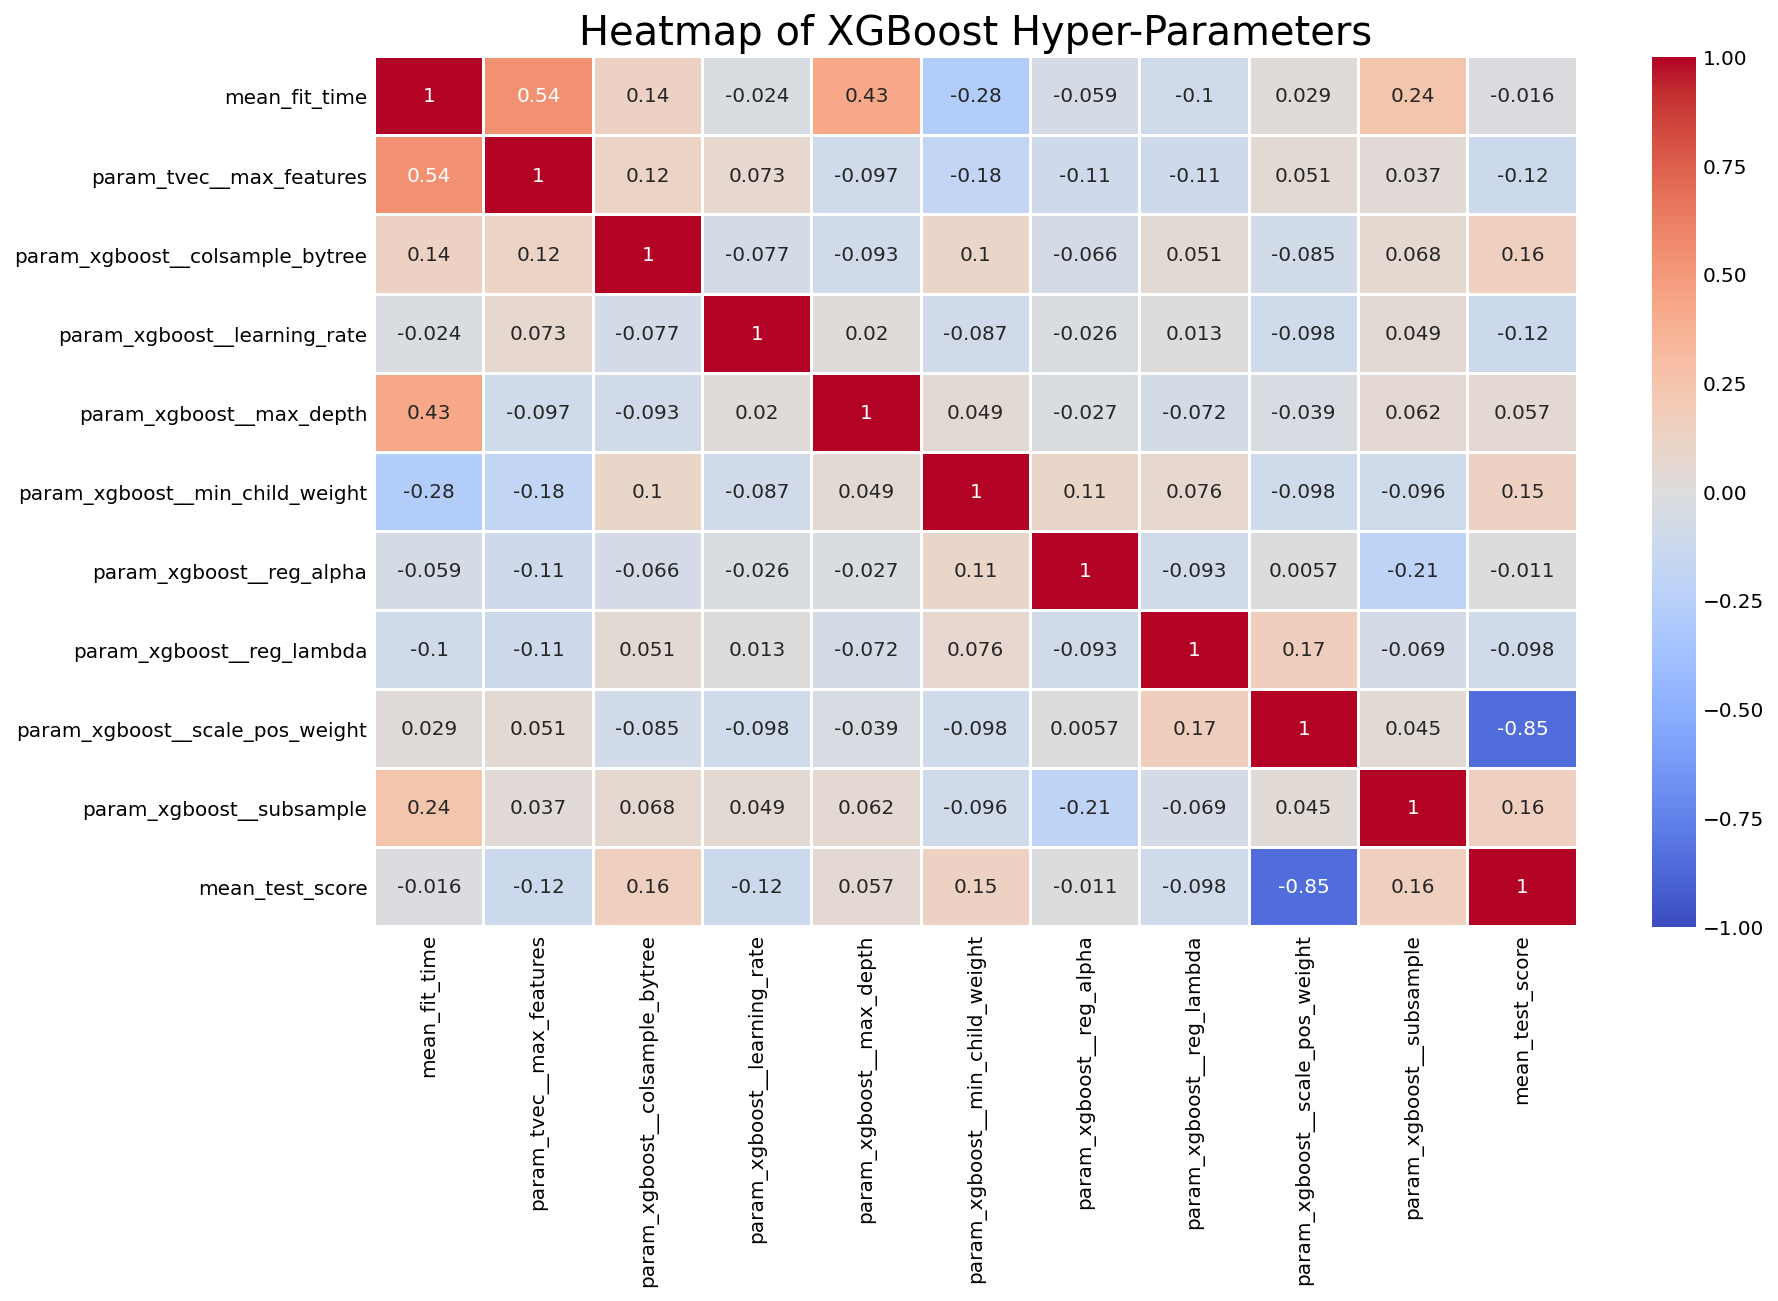

In [26]:
plt.figure(figsize=[12,8])
plt.title("Heatmap of XGBoost Hyper-Parameters", size=20)
include = ["mean_fit_time", "param_tvec__max_features", "param_tvec__ngram_range", "param_xgboost__colsample_bytree",
           "param_xgboost__learning_rate", "param_xgboost__max_depth", "param_xgboost__min_child_weight",
           "param_xgboost__reg_alpha", "param_xgboost__reg_lambda", "param_xgboost__scale_pos_weight",
           "param_xgboost__subsample", "mean_test_score"]
sns.heatmap(df_rs_xgbT_nlp_prec[include].corr(), annot=True, linewidths=1, vmin=-1, vmax=1, cmap="coolwarm")
plt.savefig("../assets/hparams_xgbT_nlp_prec_heatmap.png", transparent=True, bbox_inches='tight')
plt.show()

By following the `mean_test_score` row, we can trace the CV score correlation to the hyper-parameters. Our top hyper-parameter most correlated with `mean_test_score` by a large margin is XGBoost's `scale_pos_weight` at -0.85. Coming in tied for second and third are `colsmaple_bytree` and `subsample` at +0.16 followed by `min_child_weight` at +0.15.

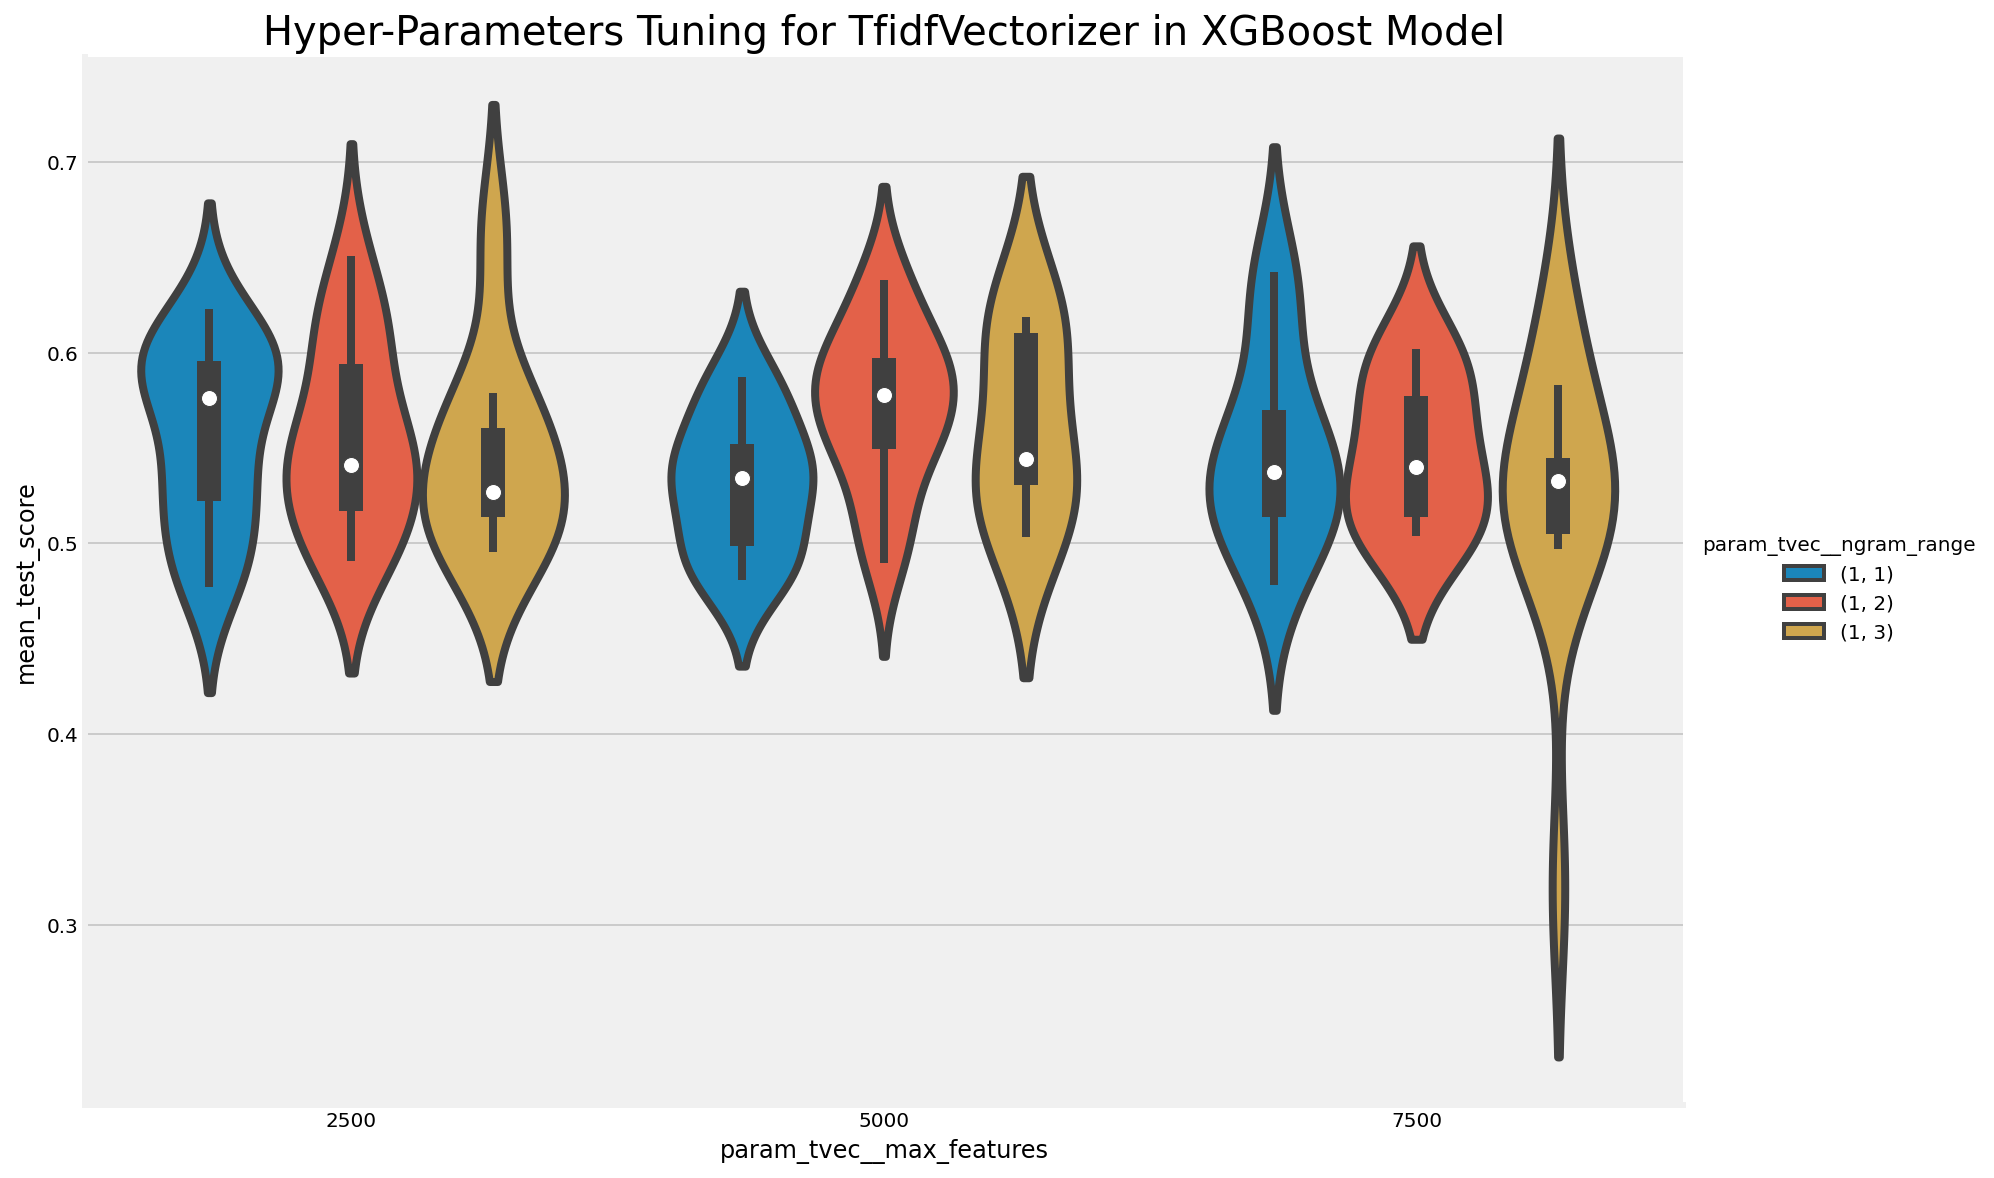

In [27]:
sns.catplot(data=df_rs_xgbT_nlp_prec,
            x='param_tvec__max_features',
            y='mean_test_score',
            hue='param_tvec__ngram_range',
            height=8, aspect=1.5, kind="violin")
plt.gcf()
plt.title("Hyper-Parameters Tuning for TfidfVectorizer in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nlp_prec_tvec.png", transparent=True, bbox_inches='tight')
plt.show()

Unlike our previous optimisations on both ROC-AUC and F-1 scores, there is a noticeable lack of convincing patter for our vectorizer hyper-parameters `max_features` and `ngram_range`. They appear not to have much of an influence on our CV precision scores. The fluctuation in the mean of our scores appear to be smaller as `max_features` increases, and where we have 2500 `max_features`, it seems that the smaller `ngram_range` of (1,1) should give us the better score.

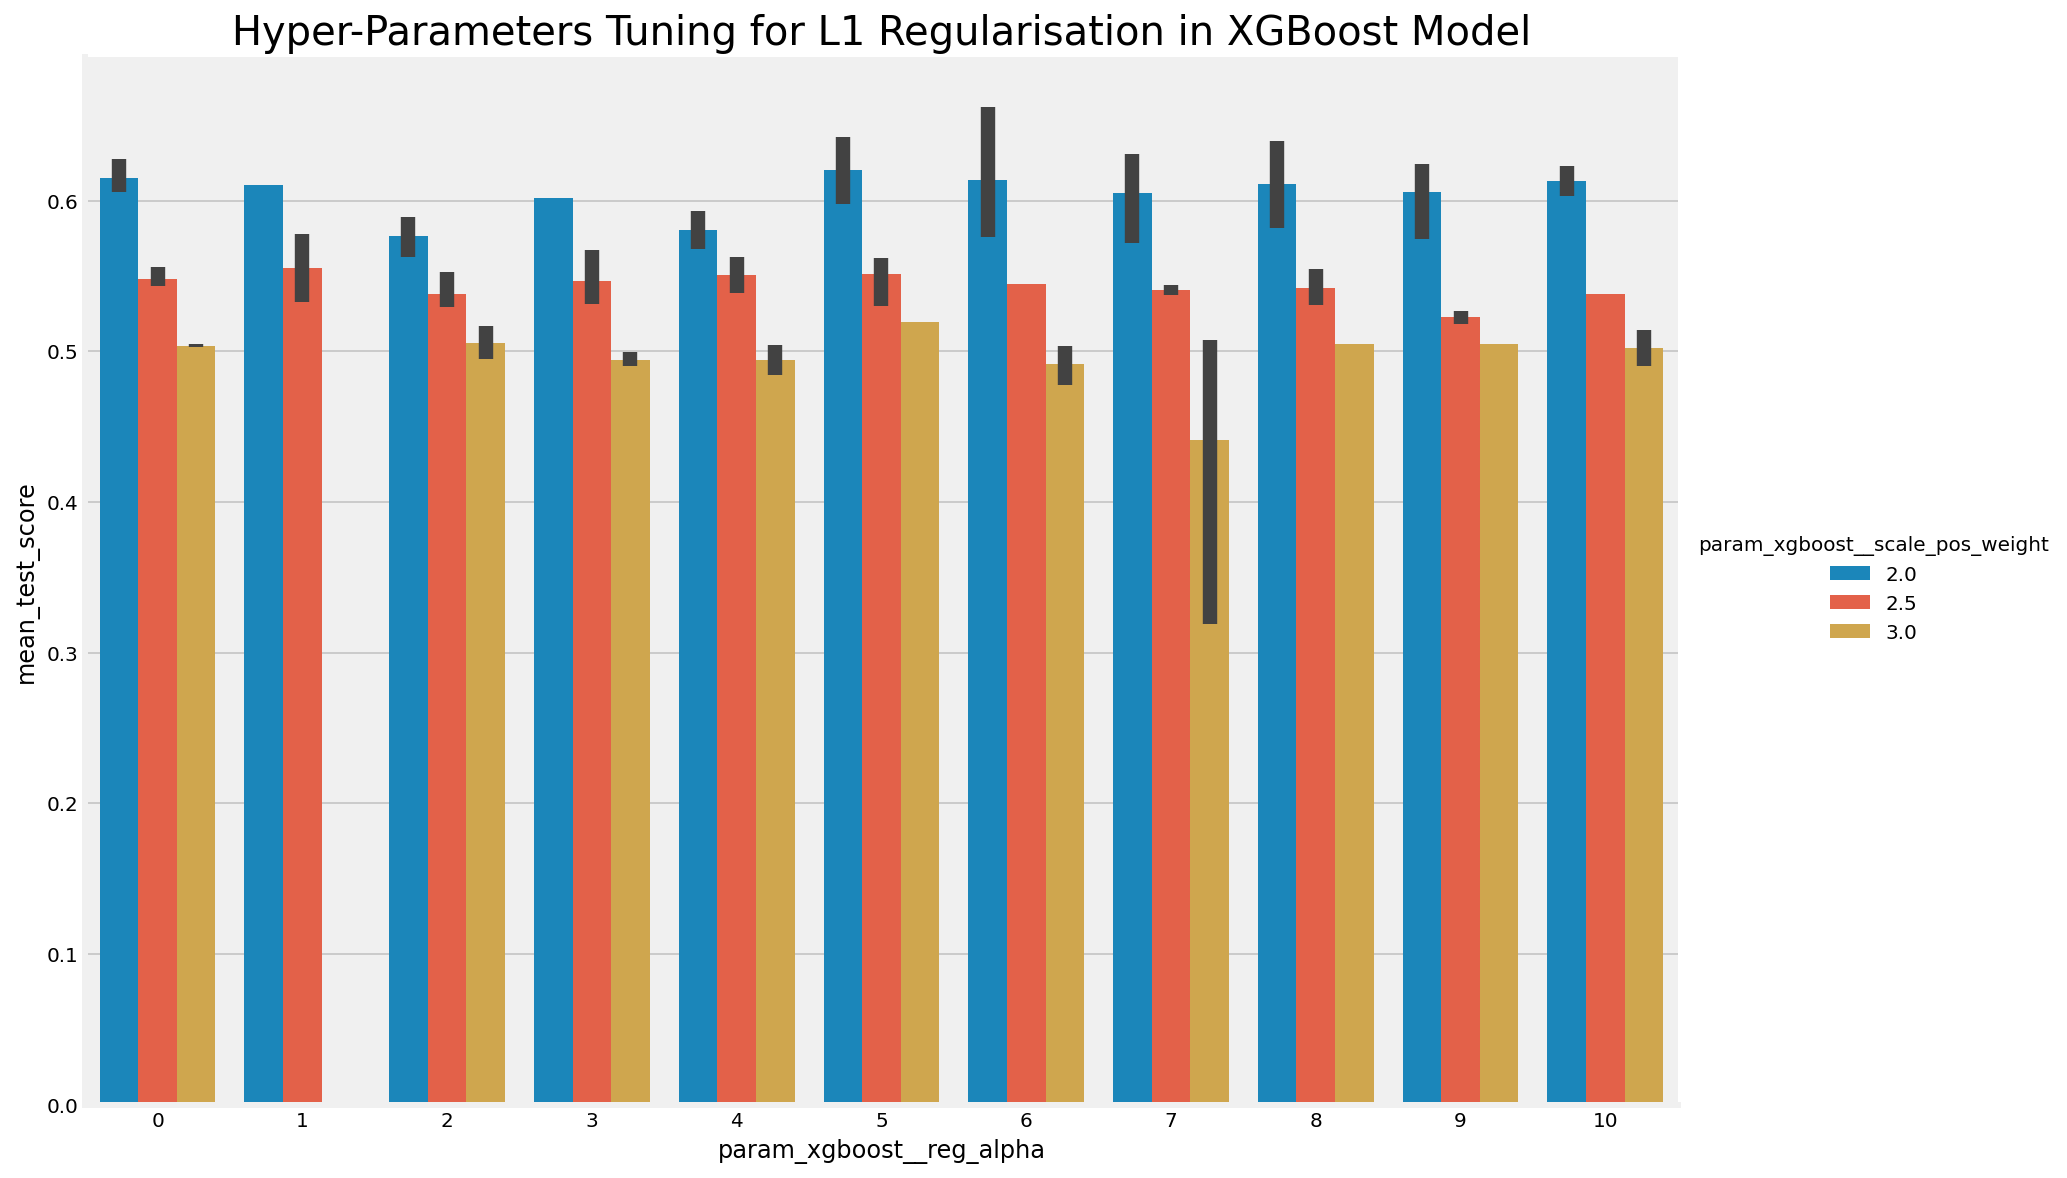

In [28]:
sns.catplot(data=df_rs_xgbT_nlp_prec,
            x='param_xgboost__reg_alpha',
            y='mean_test_score',
            hue='param_xgboost__scale_pos_weight',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning for L1 Regularisation in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nlp_prec_alpha.png", transparent=True, bbox_inches='tight')
plt.show()

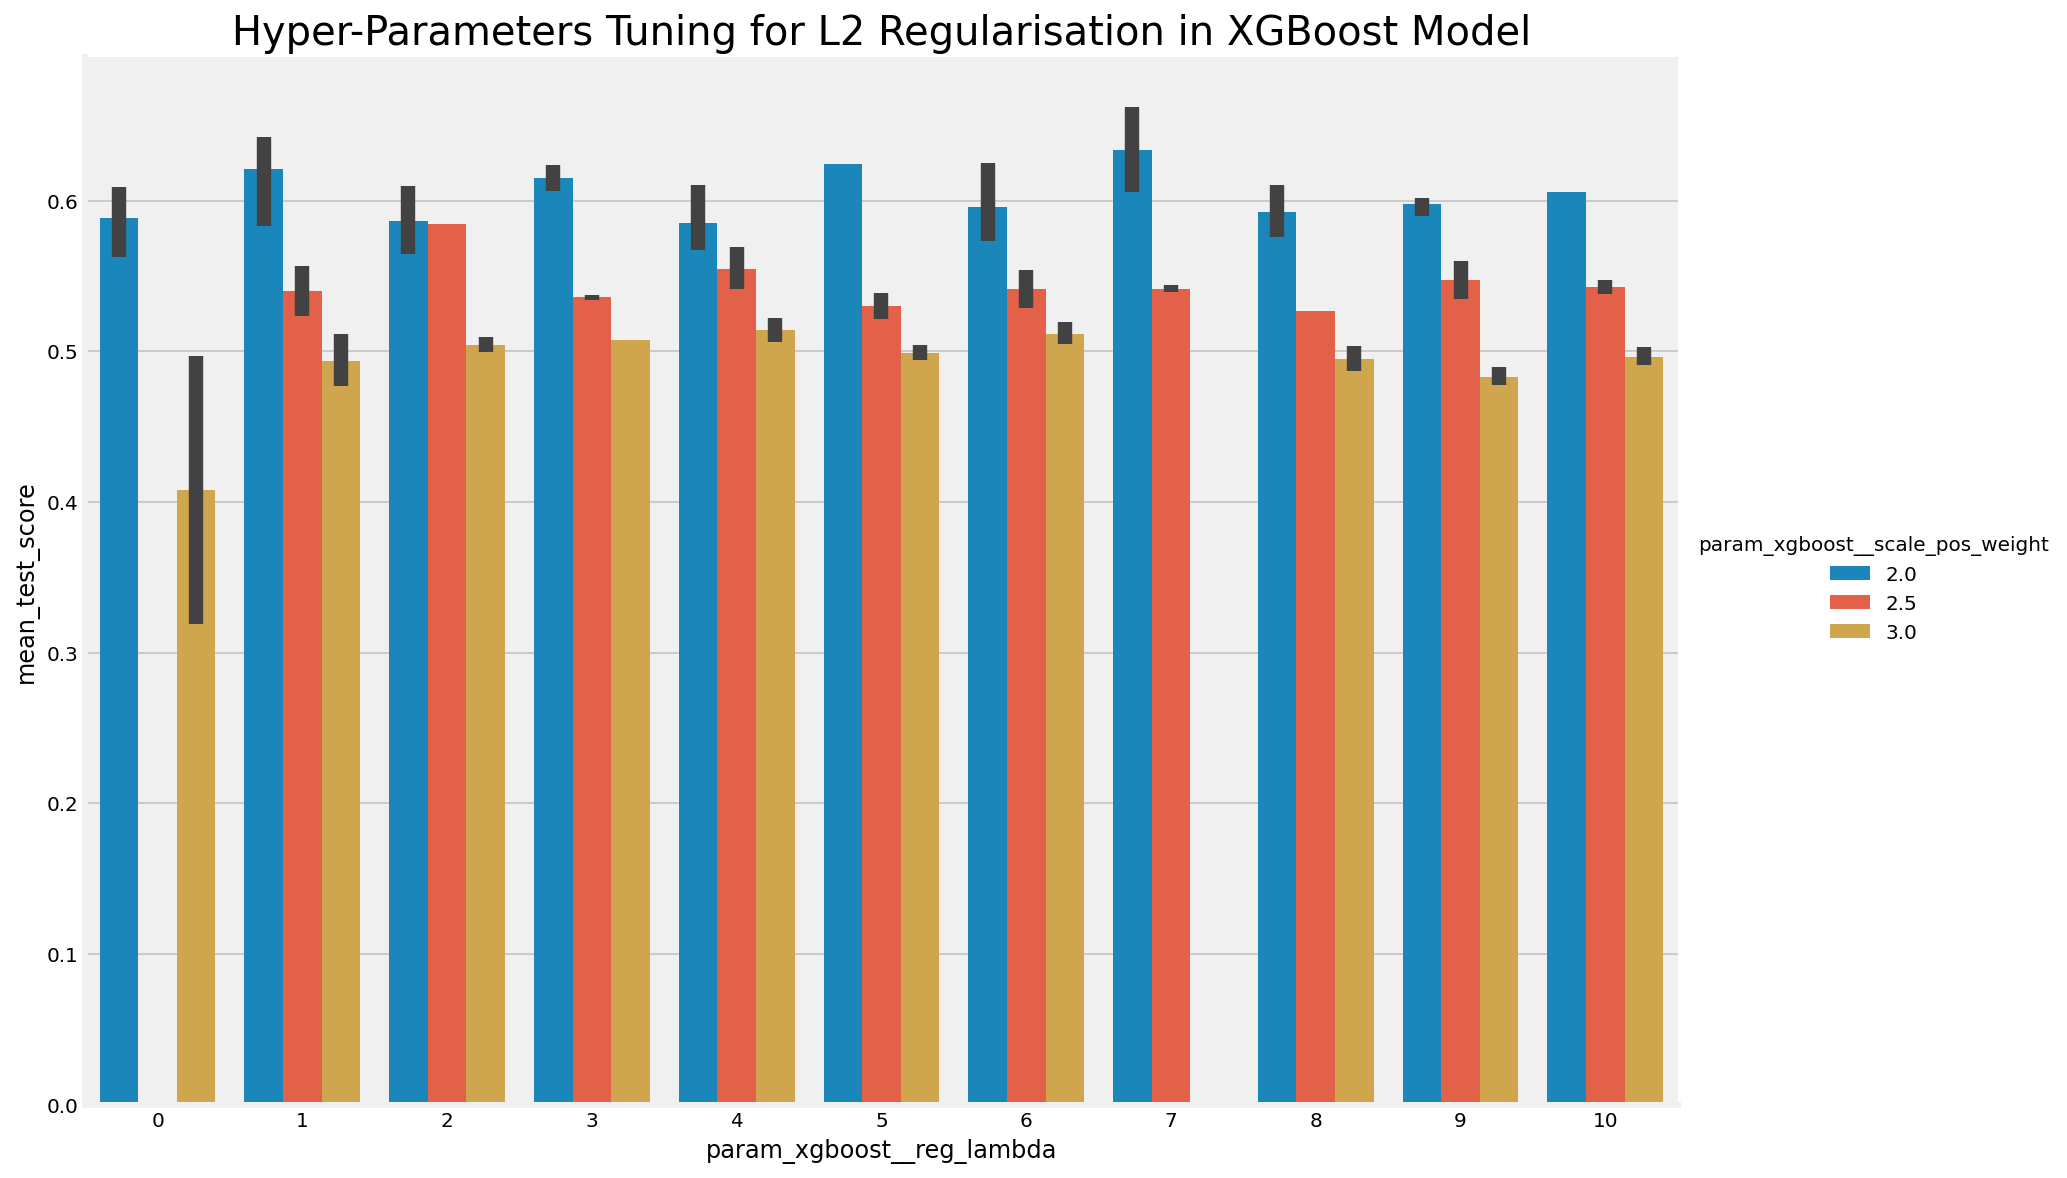

In [29]:
sns.catplot(data=df_rs_xgbT_nlp_prec,
            x='param_xgboost__reg_lambda',
            y='mean_test_score',
            hue='param_xgboost__scale_pos_weight',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning for L2 Regularisation in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nlp_prec_lambda.png", transparent=True, bbox_inches='tight')
plt.show()

No clear trend can observed for both L1 `reg_alpha` and L2 `reg_lambda` regularisation, but there is an obvious pattern where it pertains to `scale_pos_weight`. As `scale_pos_weight` increases, our CV scores decreases. This is corroborated by the parameter's very high correlation in our heatmap.

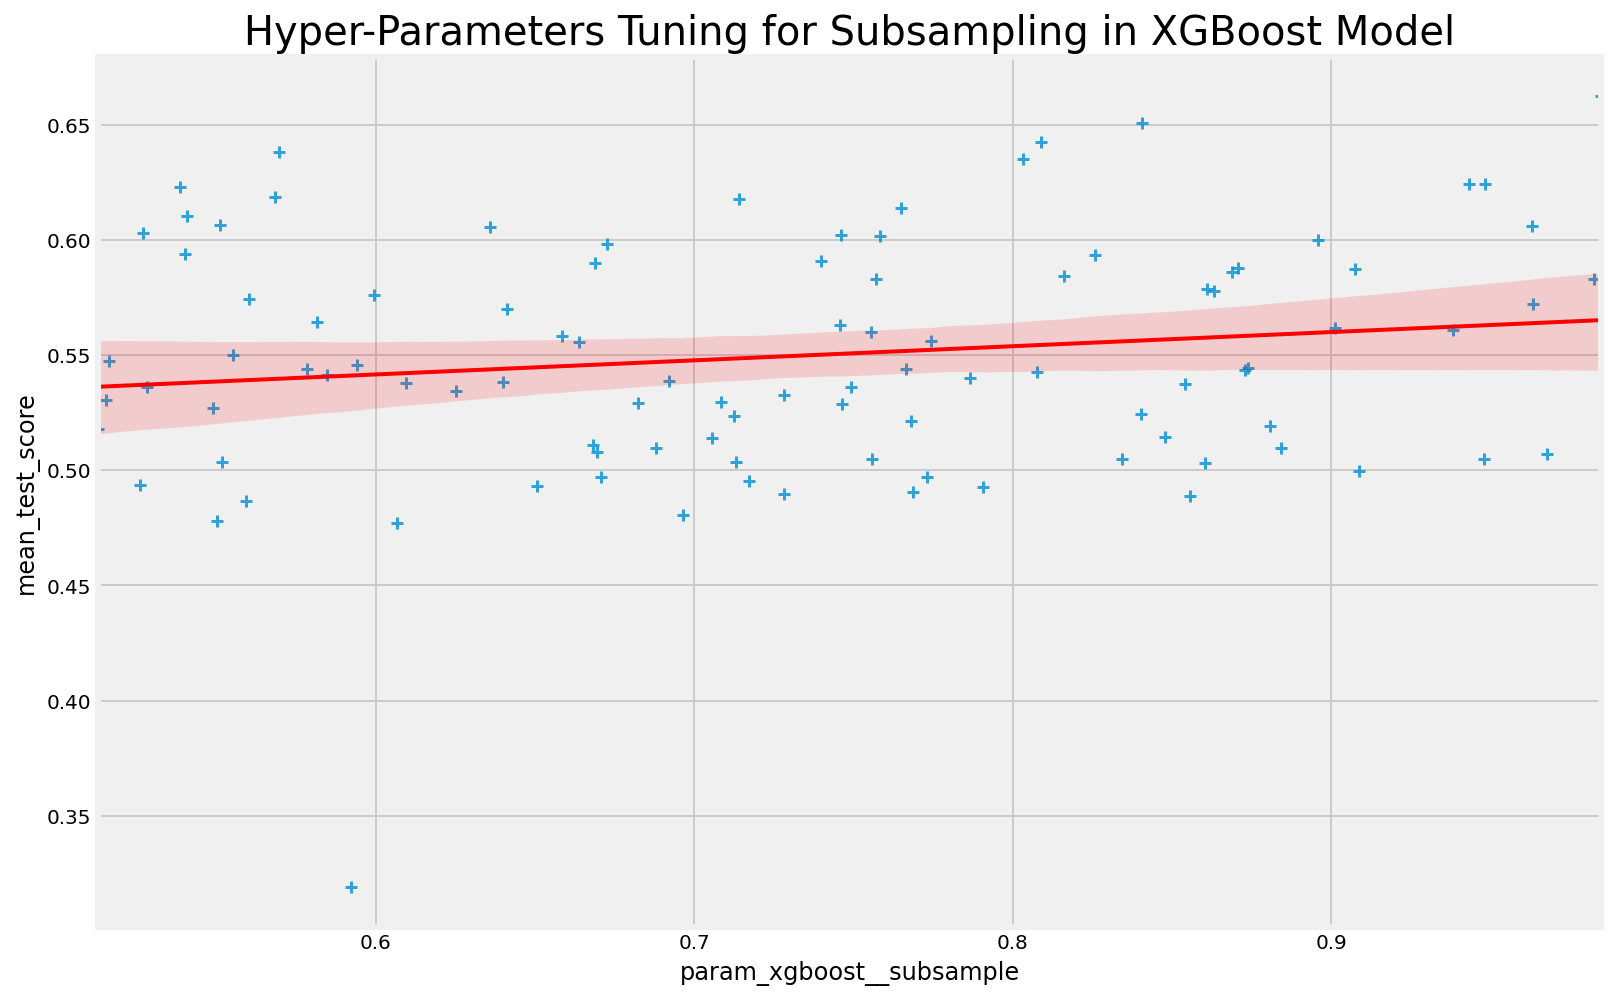

In [30]:
plt.figure(figsize=[12,8])
plt.title("Hyper-Parameters Tuning for Subsampling in XGBoost Model", size=20)
sns.regplot(data=df_rs_xgbT_nlp_prec,
            x='param_xgboost__subsample',
            y='mean_test_score',
            marker="+", scatter_kws={"lw": 1.5},
            line_kws={"lw": 2, "color": "r"})
plt.savefig("../assets/hparams_xgbT_nlp_prec_subsample.png", transparent=True, bbox_inches='tight')
plt.show()

The parameter `subsample` is positively correlated with the CV scores. As subsampling size increases, CV score increases. Subsampling is a technique used to tamper the learning of over-fitting models by sampling a random subset of our data points (rows) for each CV model. As our model indicates a positive relationship between `subsample` and `mean_test_score`, this means that our model is currently under-fitting. In this case, we should therefore not bother with subsampling and revert to the default `subsample` of 1 (100% of training set).

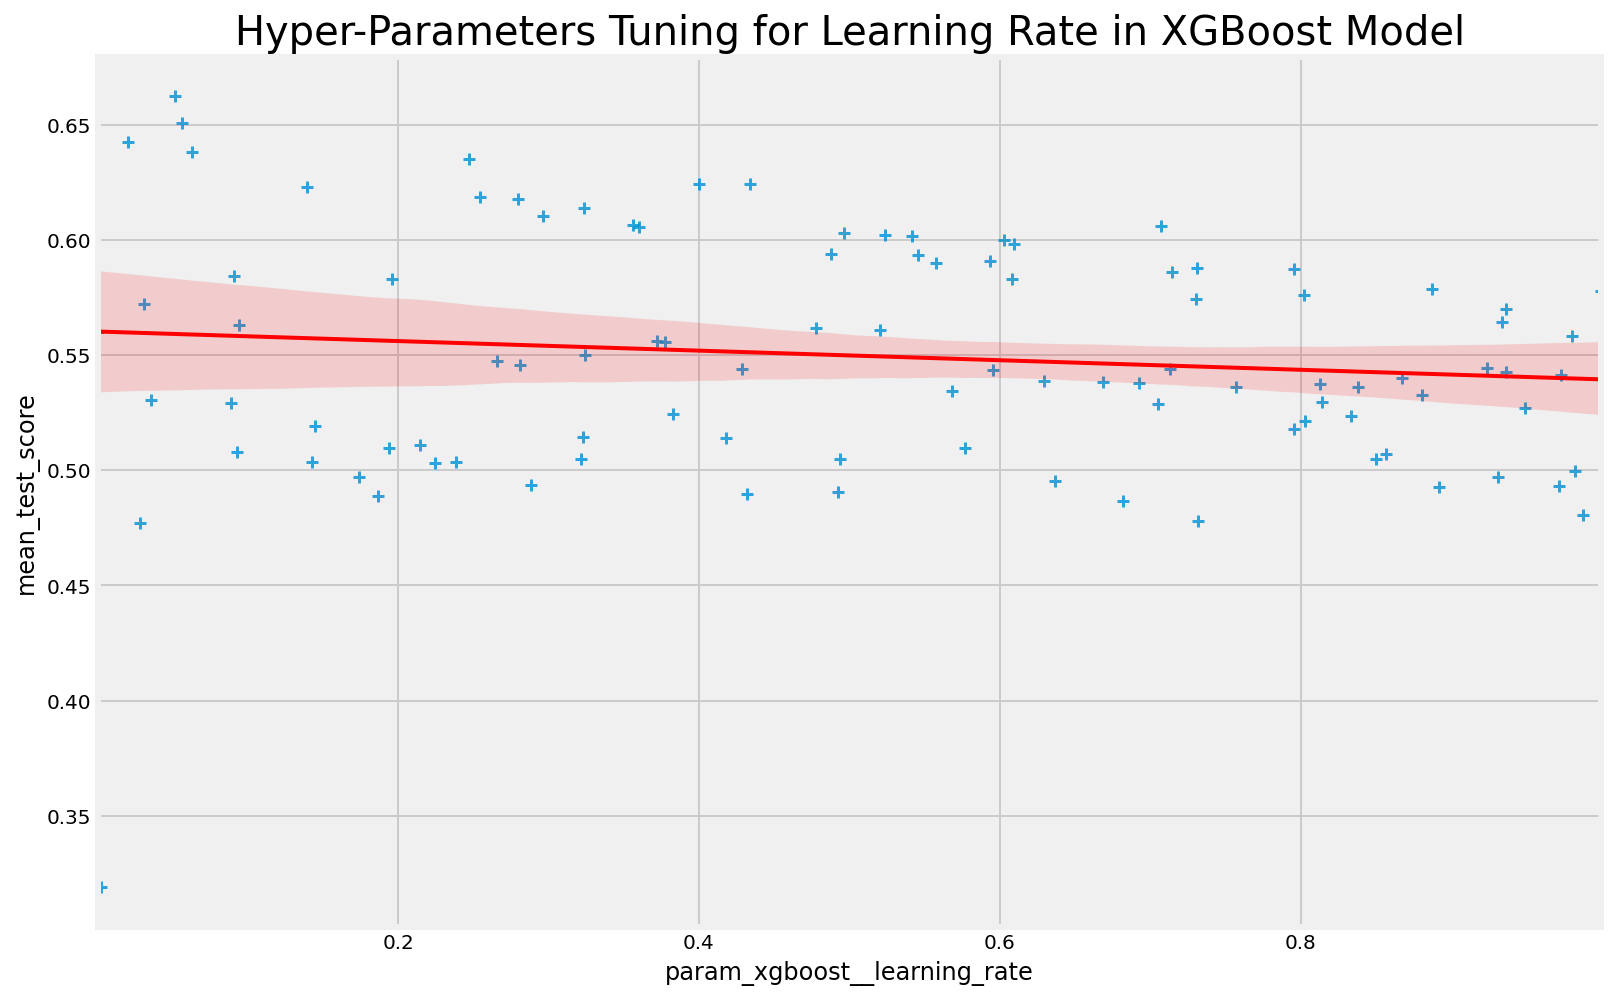

In [31]:
plt.figure(figsize=[12,8])
plt.title("Hyper-Parameters Tuning for Learning Rate in XGBoost Model", size=20)
sns.regplot(data=df_rs_xgbT_nlp_prec,
            x='param_xgboost__learning_rate',
            y='mean_test_score',
            marker="+", scatter_kws={"lw": 1.5},
            line_kws={"lw": 2, "color": "r"})
plt.savefig("../assets/hparams_xgbT_nlp_prec_learning.png", transparent=True, bbox_inches='tight')
plt.show()

The parameter `learning_rate` trends negatively against our CV scores. As the size of the learning step increases, the CV score drops as is usually the case since a smaller learning step allows the model to find the minima of its loss function more exactly.

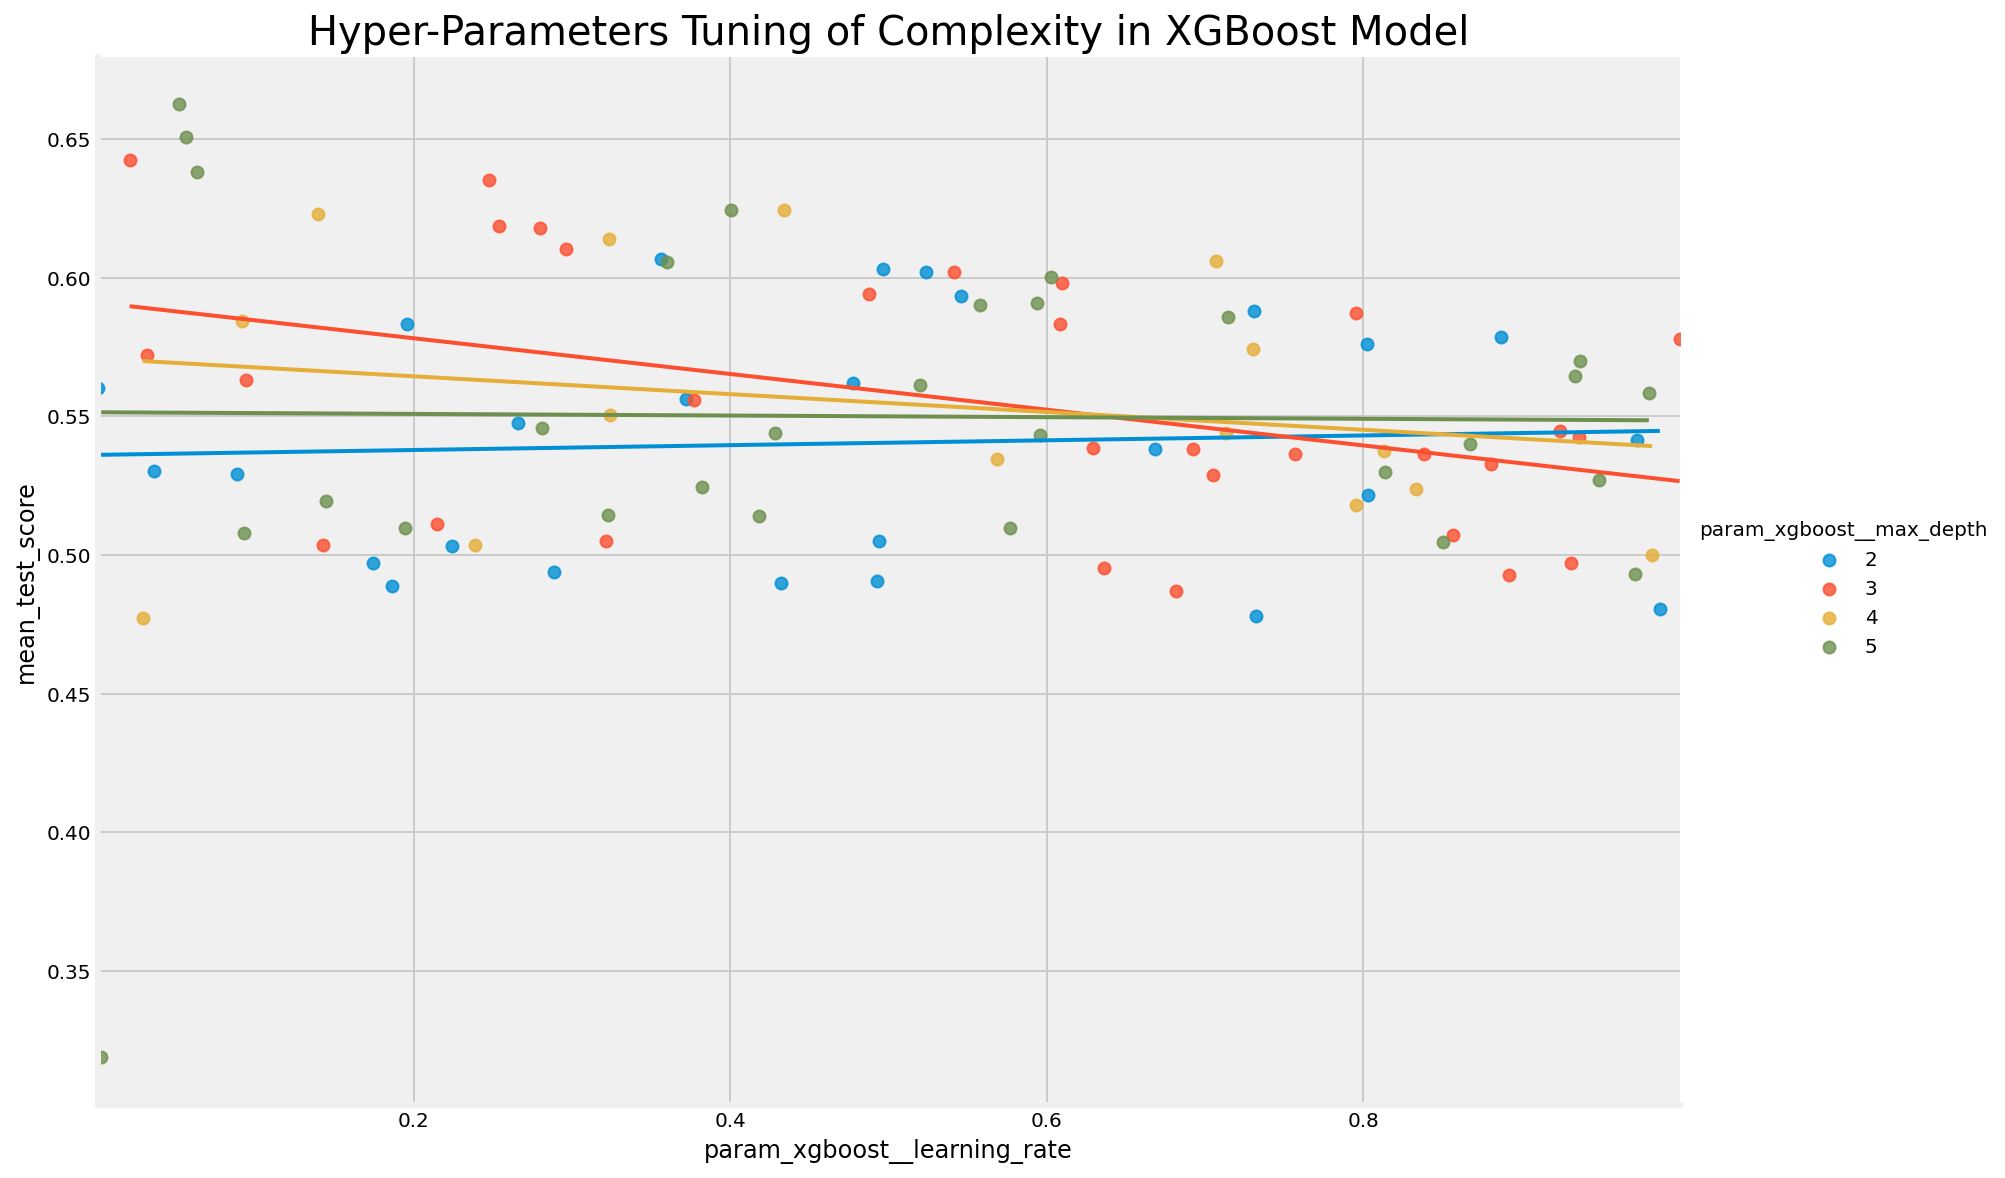

In [32]:
sns.lmplot(data=df_rs_xgbT_nlp_prec,
           x='param_xgboost__learning_rate',
           y='mean_test_score',
           hue='param_xgboost__max_depth', fit_reg=True, ci=None,
           height=8, aspect=1.5, line_kws={"lw": 2})
plt.gcf()
plt.title("Hyper-Parameters Tuning of Complexity in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nlp_prec_complex.png", transparent=True, bbox_inches='tight')
plt.show()

We can tune complexity of our model using both `max_depth` and `learning_rate`. The first allows us to control the size of each tree, the latter controls the size of each gradient descent step towards our loss minima. When we evaluate `learning_rate` against `max_depth`, ignoring `max_depth` of 2 which bucks the trend, it appears that a smaller tree gives us a better CV score when `learning_rate` is smaller than 0.65, but a larger and deeper tree offers more consistent CV scores as its trendline flattens out.

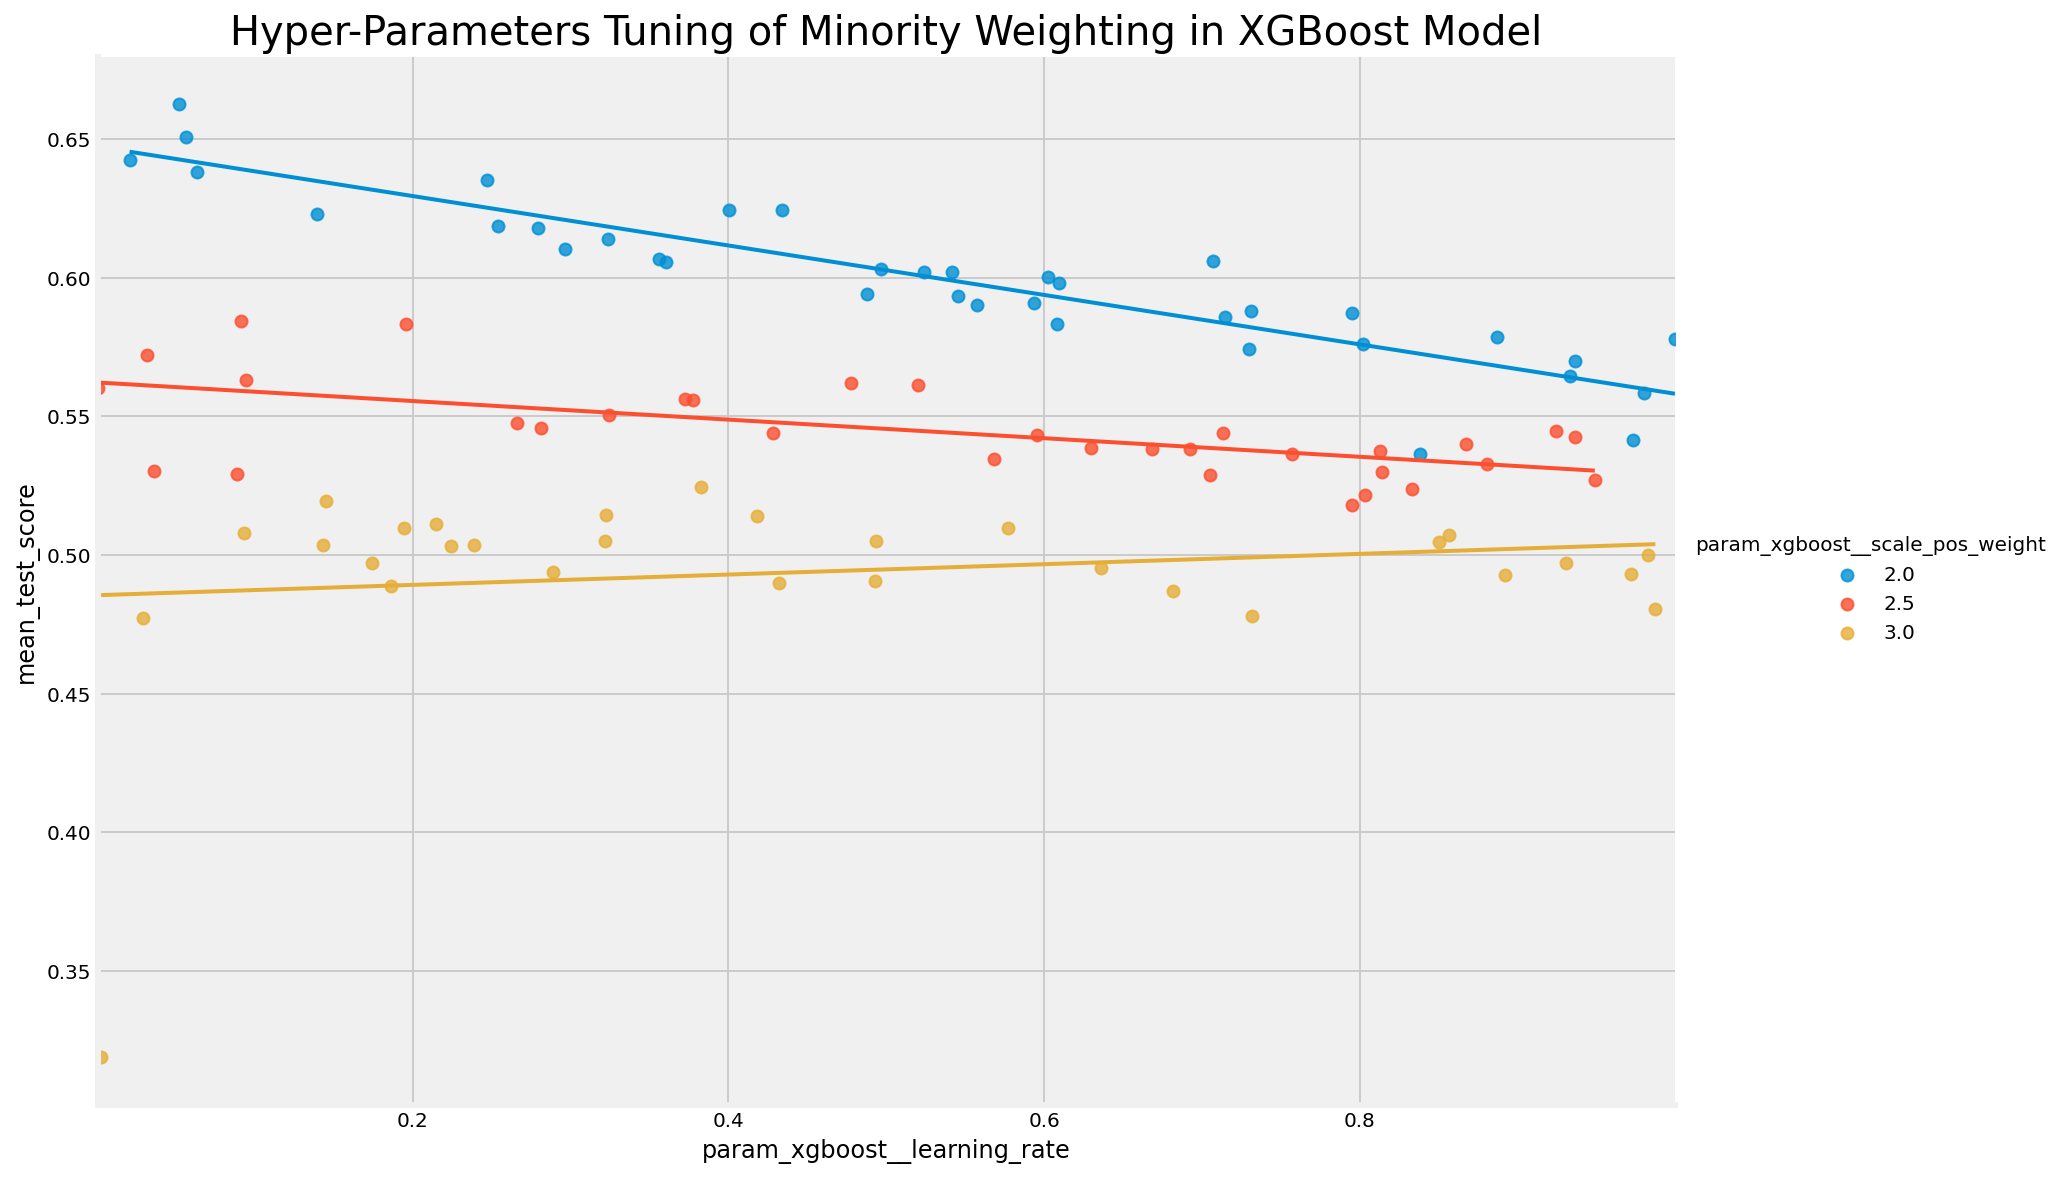

In [34]:
sns.lmplot(data=df_rs_xgbT_nlp_prec,
           x='param_xgboost__learning_rate',
           y='mean_test_score',
           hue='param_xgboost__scale_pos_weight', fit_reg=True, ci=None,
           height=8, aspect=1.5, line_kws={"lw": 2})
plt.gcf()
plt.title("Hyper-Parameters Tuning of Minority Weighting in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nlp_prec_minweight.png", transparent=True, bbox_inches='tight')
plt.show()

As `scale_pos_weight` has become our most important feature when tuning for precision, we have also plot our `learning_rate` chart against it. There is a clear separation of groups whereby smaller `scale_pos_weight` values consistently score better on our CV precision scores over larger `scale_pos_weight` values. This is actually counter-intuitive as `scale_pos_weight` is supposed to incentivise maching learning of the minority positive class, which in turn should aid our precision scores by learning to classify positive classes more accurately and reduce misclassifications of FP. That `scale_pos_weight` defy our expectations suggests that when our model learns more about our minority positive class, it is likely also picking up a lot of noise that is not truly discriminatory of our positive class, resulting in greater FP predictions that in turn push our CV precision scores down.

Since we have only tested up to the smallest `scale_pos_weight` value of 2, let us grid search even smaller arguments and see if they can give us a better result.

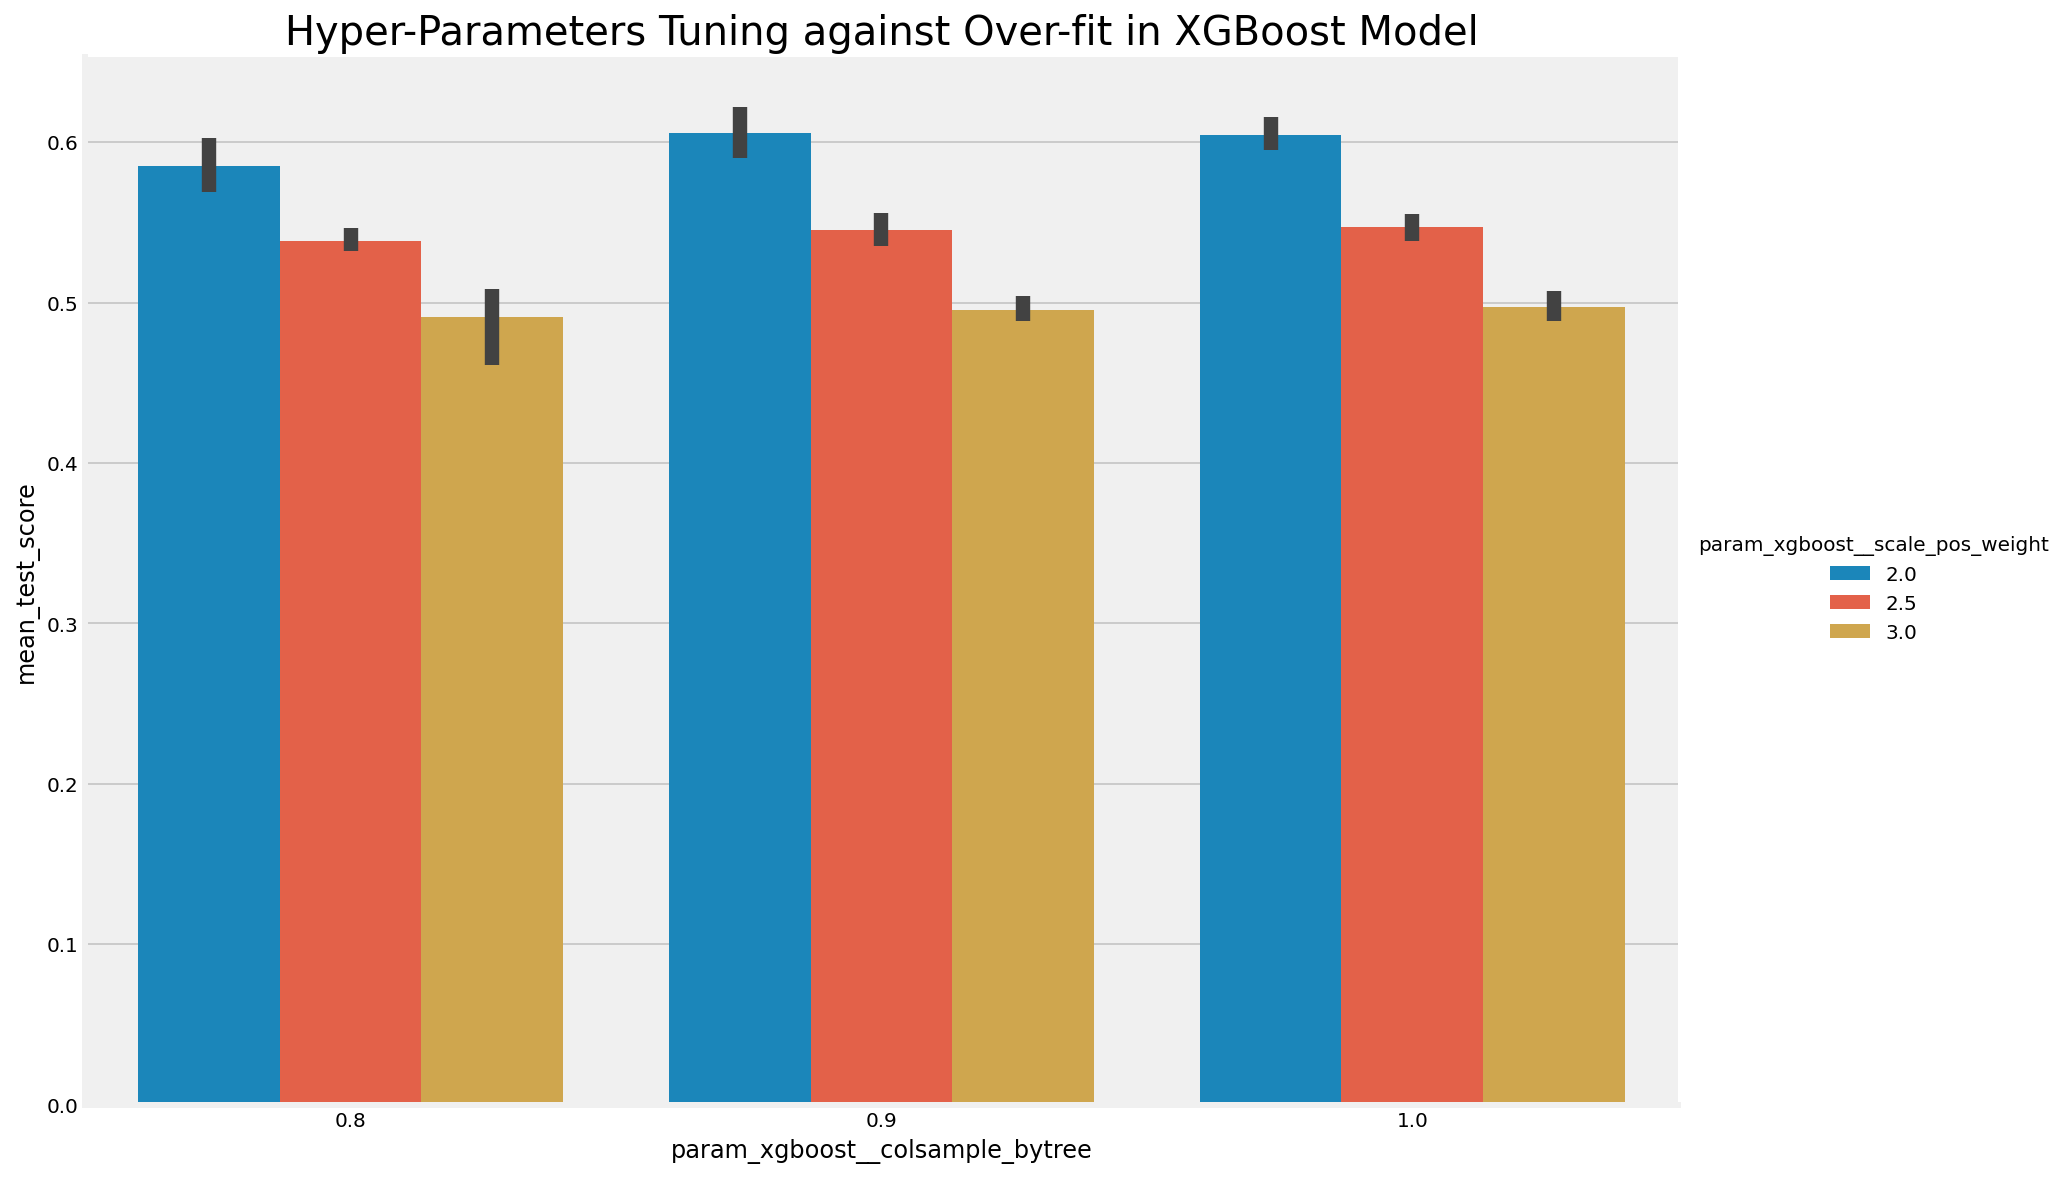

In [35]:
sns.catplot(data=df_rs_xgbT_nlp_prec,
            x='param_xgboost__colsample_bytree',
            y='mean_test_score',
            hue='param_xgboost__scale_pos_weight',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning against Over-fit in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nlp_prec_overfit.png", transparent=True, bbox_inches='tight')
plt.show()

The parameter `colsample_bytree` is the sampling ratio of our columns/features of each CV model. It is the other dimension to subsampling data rows as we have seen in `subsample`. There is no perceptible pattern here while `scale_pos_weight` continues to display the same behaviour.

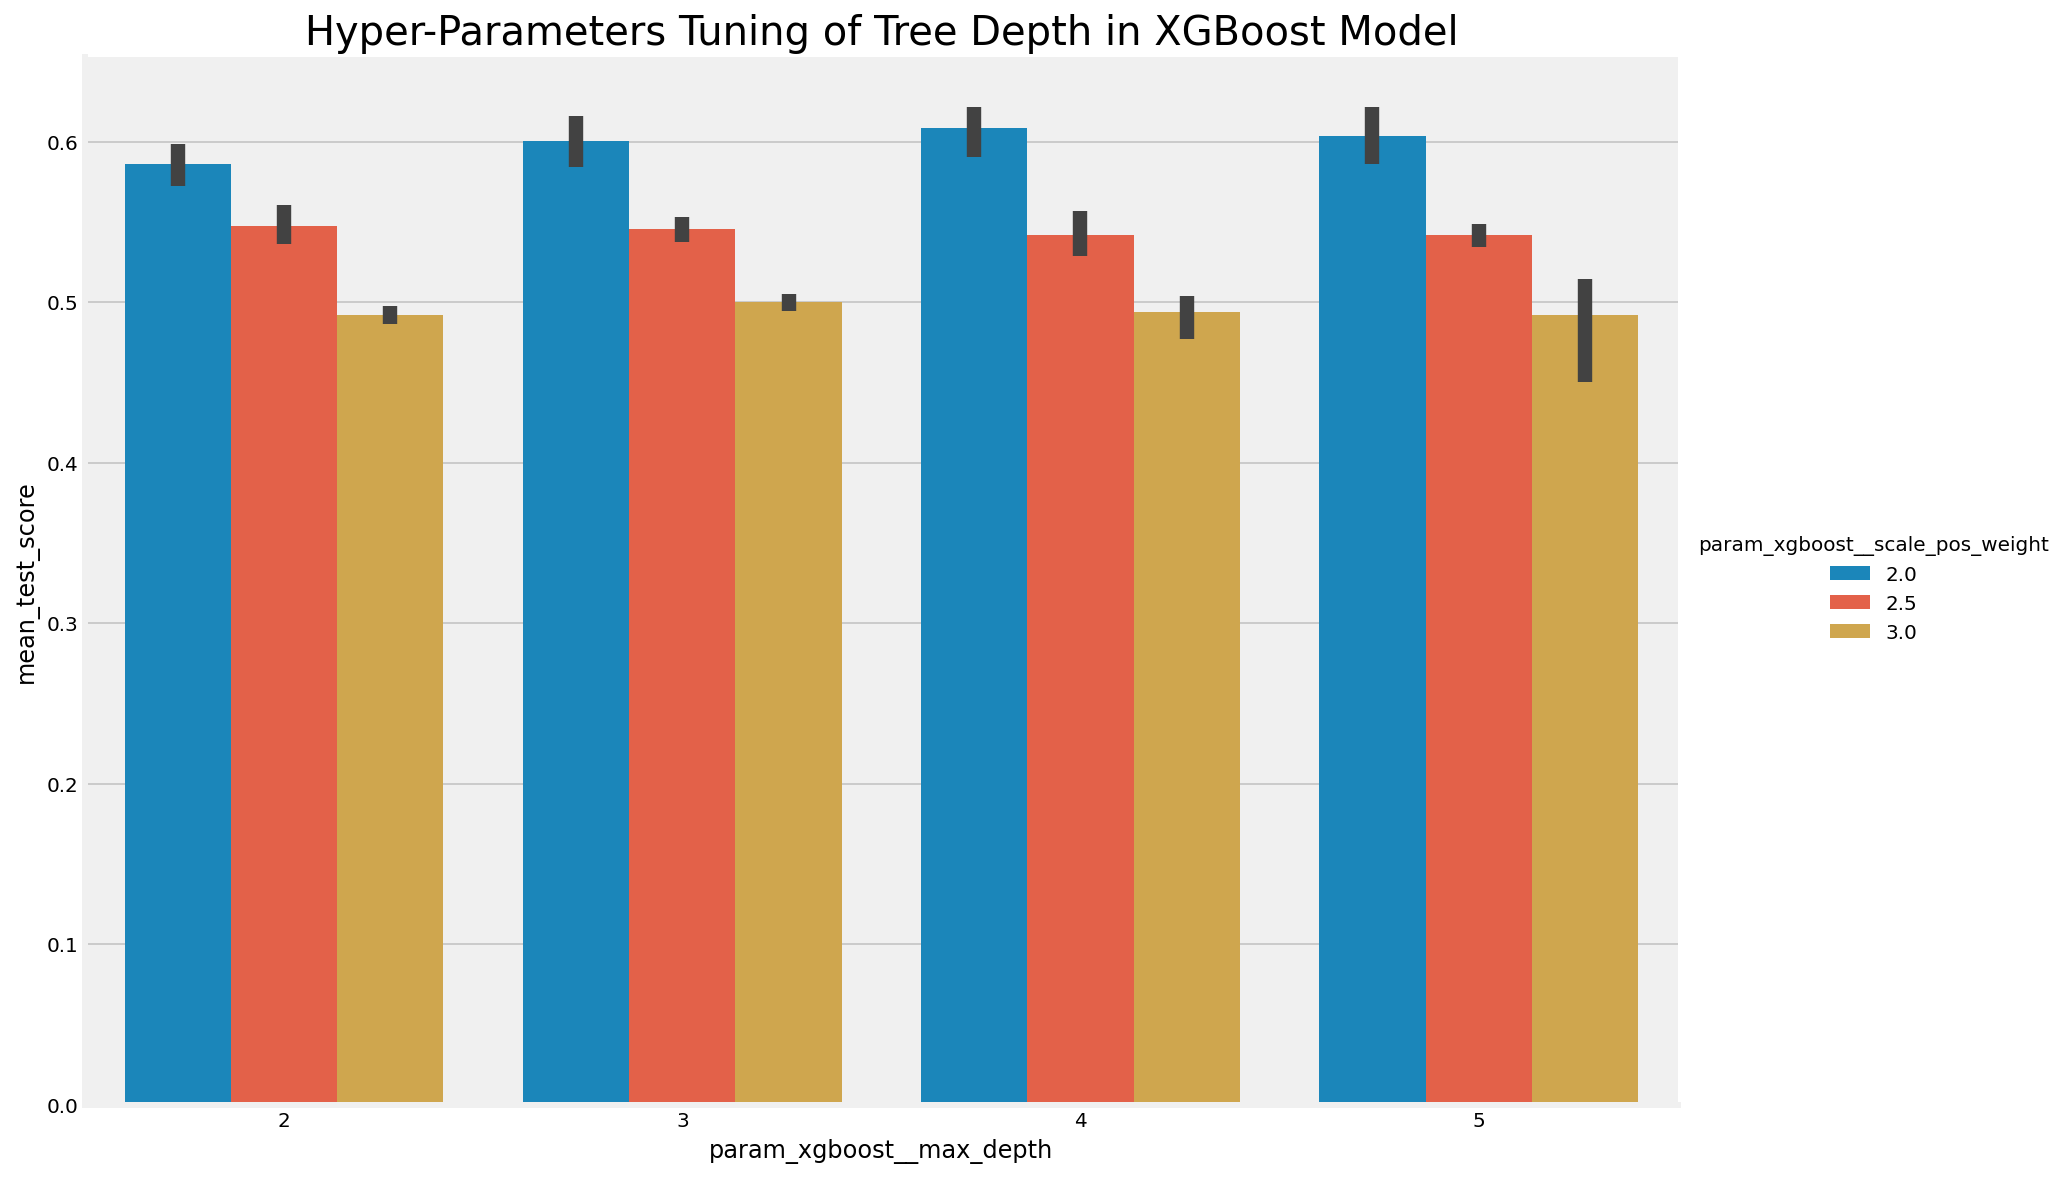

In [36]:
sns.catplot(data=df_rs_xgbT_nlp_prec,
            x='param_xgboost__max_depth',
            y='mean_test_score',
            hue='param_xgboost__scale_pos_weight',
            height=8, aspect=1.5, kind="bar")
plt.gcf()
plt.title("Hyper-Parameters Tuning of Tree Depth in XGBoost Model", size=20)
plt.savefig("../assets/hparams_xgbT_nlp_prec_depth.png", transparent=True, bbox_inches='tight')
plt.show()

The parameter `max_depth` allows us to control the growth of our trees by limiting the number of levels of branches possible per tree. There appears to be a slight positive trend between `max_depth` and our CV scores, plateauing about depth level 4 and 5. The bar chart also groups by `scale_pos_weight` which is still displaying the same negative behaviour.

#### Further Optimisation

Best XGBoost Model (Tree) Hyper-Parameters for NLP:
```
{'tvec__max_features': 2500,
 'tvec__ngram_range': (1, 3),
 'xgboost__colsample_bytree': 0.9,
 'xgboost__gamma': 0,
 'xgboost__learning_rate': 0.0516817211686077,
 'xgboost__max_depth': 5,
 'xgboost__min_child_weight': 2,
 'xgboost__reg_alpha': 6,
 'xgboost__reg_lambda': 7,
 'xgboost__scale_pos_weight': 2,
 'xgboost__subsample': 0.9847684335570794}
```

Optimal value for vectorizer parameter `max_features` was found to be at the lower limit of input arguments at 2500. according to our violing plot however, there are no clear and convincing patterns between `max_features` and our CV precision scores. As such, even though the recommended argument is at the lower limit of the range provided, we shall fix this as our optimal value in the interest of time.

Likewise for `ngram_range`, our grid search recommended the upper limit of (1,3) even as our violin plot indicates that the parameter most likely does not affect our CV scores. However, when there are 2500 word features, it seems that a smaller `ngram_range` value would likely give us a better CV score based on the mean of its distribution. Let us test both extremes then - the recommended upper limit of (1,3) and the speculated lower limit of (1,1).

L1 and L2 regularisation through `reg_alpha` and `reg_lambda` respectively found its optimal value within the range of arguments (0-10) provided during our randomised grid search. As such, we shall take these values as final.

The `gamma` parameter sets the minimum loss threshold for a split, effectively pruning the tree's growth and helping to reduce over-fitting of trees. It is recommended to tune this parameter after all other parameters have been fixed. We shall leave it at its default and recommended value of 0 for now.

The optimal value for `scale_pos_weight` was found at the lower limit of input arguments at 2. Let us test a range of arguments smaller than 2 to see if the optimal value has been found.

For `learning_rate`, the optimal value was found to be at about 0.05. Even though we fed as input argument for the randomised grid search a uniform distribution of values from 0.0 to 1.0, suggesting that this is likely its optimal value after 100 iterations, our chart suggest a pattern whereby smaller learning rate is correlated with an increase in CV scores. As such, we shall test a range of values to see if there is a smaller value of `learning_rate` that is optimal.

The parameter `max_depth` was given a range of random integers from 2 to 5 and the upper limit of 5 was chosen as optimal. We shall test arguments greater than 5 to find the optimal value.

Parameter `min_child_weight` was given a range of random integers from 0 to 4 and the optimal value was found to be at the middling value of 2. We will accept this value as the optimal.

Since the `subsample` optimal value was given to be at 0.98 (very close to 1) and our charts indicate that a higher `subsample` size gives us our better score, we shall fix our optimal value at 1.

For `colsample_bytree` which samples from the column axis as a technique to reduce over-fitting of model, since the middling value of 0.9 was recommended, we shall accept this as our optimal value.

In [38]:
# build pipeline
pipe_xgbT = Pipeline(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                            ("xgboost", xgb.XGBClassifier(booster="gbtree", # "gbtree" is our best performing model for NLP
                                                          objective="binary:logistic"))])

# set hyper params to tune
pipe_params_xgbT = {
    "tvec__max_features": [2500],
    "tvec__ngram_range": [(1,1), (1,3)], # upper limit of (1,3) was recommended but chart suggests (1,1)
    "xgboost__reg_alpha": [6],
    "xgboost__reg_lambda": [7],
    "xgboost__gamma": [0],
    "xgboost__scale_pos_weight": [0, 0.1, 0.5, 1, 1.5, 2], # best argm was the lower limit at 2
    "xgboost__learning_rate": [0.01, 0.05], # chart suggests decreasing learning rate while our best argm was 0.05
    "xgboost__max_depth": [5, 6, 7], # best argm was the upper limit at 5
    "xgboost__min_child_weight": [2],
    "xgboost__subsample": [1],
    "xgboost__colsample_bytree": [0.9]
}

In [39]:
%%time
np.random.seed(42)
gs_xgbT_nlp_prec = GridSearchCV(estimator=pipe_xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="precision")
gs_xgbT_nlp_prec.fit(X_nlp_train, y_train)
print("Best score in Grid Search:", gs_xgbT_nlp_prec.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nlp_prec.best_params_

C:\Users\yewto\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score in Grid Search: 0.9910714285714286

Using the following hyper-parameters:
Wall time: 38min 46s


{'tvec__max_features': 2500,
 'tvec__ngram_range': (1, 1),
 'xgboost__colsample_bytree': 0.9,
 'xgboost__gamma': 0,
 'xgboost__learning_rate': 0.01,
 'xgboost__max_depth': 7,
 'xgboost__min_child_weight': 2,
 'xgboost__reg_alpha': 6,
 'xgboost__reg_lambda': 7,
 'xgboost__scale_pos_weight': 0.1,
 'xgboost__subsample': 1}

Warning above is flagged when our model is unable to predict all the classes present in the cross-validation. In the case of binary classification, this means that our model was unable to return any positive predictions. As such, precision is ill-defined. The sudden high in our precision CV score is therefore misleading and not to be taken at face value.

A possible technique to mitigate this is to balance our classes. In this case, our minority positive class. After reviewing both undersampling and oversampling techniques, we opt for oversampling via `SMOTE` to prevent information loss, especially important for a model that is already not performing very well and could do with more data. As such, we shall redo our re-tuning once we have oversampled our training set.

In [80]:
# import imblearn's very own pipeline so it can handle SMOTE's .resample() function
from imblearn.pipeline import Pipeline as imb_Pipe

In [81]:
# build new pipeline to include SMOTE
pipe_xgbT = imb_Pipe(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                            ('oversample', SMOTE(random_state=42, sampling_strategy=1.0)), # oversample until 1:1 class dist
                            ("xgboost", xgb.XGBClassifier(booster="gbtree", # "gbtree" is our best performing model for NLP
                                                          objective="binary:logistic"))])

# set hyper params to tune
pipe_params_xgbT = {
    "tvec__max_features": [2500],
    "tvec__ngram_range": [(1,1), (1,3)], # upper limit of (1,3) was recommended but chart suggests (1,1)
    "xgboost__reg_alpha": [6],
    "xgboost__reg_lambda": [7],
    "xgboost__gamma": [0],
    "xgboost__scale_pos_weight": [0.1, 2], # best argm was the lower limit at 2
    "xgboost__learning_rate": [0.01, 0.05], # chart suggests decreasing learning rate while our best argm was 0.05
    "xgboost__max_depth": [5, 7], # best argm was the upper limit at 5
    "xgboost__min_child_weight": [2],
    "xgboost__subsample": [1],
    "xgboost__colsample_bytree": [0.9]
}

In [82]:
%%time
np.random.seed(42)
gs_xgbT_nlp_prec = GridSearchCV(estimator=pipe_xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="precision")
gs_xgbT_nlp_prec.fit(X_nlp_train, y_train)
print("Best score in Grid Search:", gs_xgbT_nlp_prec.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nlp_prec.best_params_

Best score in Grid Search: 0.9494720571801425

Using the following hyper-parameters:
Wall time: 6min 57s


{'tvec__max_features': 2500,
 'tvec__ngram_range': (1, 3),
 'xgboost__colsample_bytree': 0.9,
 'xgboost__gamma': 0,
 'xgboost__learning_rate': 0.05,
 'xgboost__max_depth': 5,
 'xgboost__min_child_weight': 2,
 'xgboost__reg_alpha': 6,
 'xgboost__reg_lambda': 7,
 'xgboost__scale_pos_weight': 0.1,
 'xgboost__subsample': 1}

Is the precision score really this high at 0.95? If so, this is a drastic improvement from before. If `SMOTE` works this well, rather than tune our hyper-parameters for the extreme of precision, it would make more sense to tune our hyper-parameters after SMOTE transformation for a more balanced F-1 score.

Let us test this out on a simply-tuned model and evaluate its performance more fully.

In [83]:
# match best params from above for TfidfVectorizer
tvec = TfidfVectorizer(stop_words="english", max_features=2500, ngram_range=(1,3))
X_train_tvec = tvec.fit_transform(X_nlp_train)
print("Shape of training sparse matrix:", X_train_tvec.shape)
X_unseen_tvec = tvec.transform(X_nlp_unseen)
print("Shape of test sparse matrix:", X_unseen_tvec.shape)

Shape of training sparse matrix: (18050, 2500)
Shape of test sparse matrix: (6017, 2500)


In [84]:
# we only need to oversample training set so our model is able to learn more about the originally minority class
sm = SMOTE(random_state=42, sampling_strategy=1.0)
X_train_tvec_sm, y_train_sm = sm.fit_resample(X_train_tvec, y_train)

In [85]:
%%time
xgboost_nlp_sm = xgb.XGBClassifier(booster="gbtree",
                                objective="binary:logistic",
                                colsample_bytree=0.9,
                                gamma=0,
                                learning_rate=0.05,
                                max_depth=5,
                                min_child_weight=2,
                                reg_alpha=6,
                                reg_lambda=7,
                                scale_pos_weight=0.1,
                                subsample=1)

xgboost_nlp_sm.fit(X_train_tvec_sm, y_train_sm) # use vectorized word features from before

Wall time: 5.03 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=6, reg_lambda=7, scale_pos_weight=0.1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [88]:
# get predictions on unseen test set
xgb_nlp_predictions_sm = xgboost_nlp_sm.predict(X_unseen_tvec)
eval_classifier(y_unseen, xgb_nlp_predictions_sm) # evaluate predictions

True Negatives: 4258
False Positives: 7
False Negatives: 1588
True Positives: 164

ROC-AUC score: 0.546
Accuracy: 0.735
Recall: 0.094
Specificity: 0.998
Precision: 0.959
F-1 score: 0.171


Precision was every bit as good as our grid searching said it would be! But clearly, optimising our model for precision compromised our recall score and accordingly, our ROC-AUC and F-1 scores. That being said, `SMOTE` does appear to aid machine learning tremendously based on what it was able to do for our precision score. Let's redo our hyper-parameters tuning, this time training on the **SMOTE-transformed dataset** and **optimising for F-1 score**.

#### XGBoost (Tree) after SMOTE

Our usual method of grid searching randomly using probability distributions and a fixed number of iterations to control training time was not possible with the `imblearn.Pipeline` transformer as `RandomizedSearchCV` did not accept the the object. Hence, we shall have to use `GridSearchCV` instead to begin tuning our hyper-parameters. We shall have to take care to limit our number of permutatons in the grid search to control our training time. One way to do that is to fine-tune only one or two hyper-parameters at a time.

Since we are investing the time and grid searching systematically, there is therefore also no need to plot charts to evaluate and assess patterns in hyper-parameters against our metric of choice. At least this way, we can save some time which will have to be spent combing systematically through hyper-parameter values anyway.

In [98]:
# build new pipeline to include SMOTE
pipe_xgbT = imb_Pipe(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                            ('oversample', SMOTE(random_state=42, sampling_strategy=1.0)), # oversample until 1:1 class dist
                            ("xgboost", xgb.XGBClassifier(booster="gbtree",
                                                          objective="binary:logistic"))]) # begin with default hyper-params

# set hyper params to tune
pipe_params_xgbT = {
    "tvec__max_features": [2500, 5000, 7500],
    "tvec__ngram_range": [(1,1), (1,2), (1,3)]
}

In [99]:
%%time
np.random.seed(42)
gs_xgbT_nlp_f1 = GridSearchCV(estimator=pipe_xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="f1")
gs_xgbT_nlp_f1.fit(X_nlp_train, y_train)
print("Best score in Grid Search:", gs_xgbT_nlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nlp_f1.best_params_

Best score in Grid Search: 0.5687850750324555

Using the following hyper-parameters:
Wall time: 6min 4s


{'tvec__max_features': 7500, 'tvec__ngram_range': (1, 2)}

As usual, since we want to cap our vectorizer's `max_features` at 7500, we shall fix the recommended `max_features` value at 7500 as our optimal value. Likewise, our grid search also selected the middling value of (1,2) as our `ngram_range`. We shall accept that as our optimal value.

Next, we will grid search for our regularisation parameters `reg_alpha` (L1) and `reg_lambda` (L2).

In [102]:
# build new pipeline to include SMOTE
pipe_xgbT = imb_Pipe(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                            ('oversample', SMOTE(random_state=42, sampling_strategy=1.0)), # oversample until 1:1 class dist
                            ("xgboost", xgb.XGBClassifier(booster="gbtree",
                                                          objective="binary:logistic"))]) # begin with default hyper-params

# set hyper params to tune
pipe_params_xgbT = {
    "tvec__max_features": [7500],
    "tvec__ngram_range": [(1,2)],
    "xgboost__reg_alpha": [0, 1, 2, 5], # default was 0
    "xgboost__reg_lambda": [0, 1, 2, 5], # default was 1
    "xgboost__gamma": [0]
}

In [103]:
%%time
np.random.seed(42)
gs_xgbT_nlp_f1 = GridSearchCV(estimator=pipe_xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="f1")
gs_xgbT_nlp_f1.fit(X_nlp_train, y_train)
print("Best score in Grid Search:", gs_xgbT_nlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nlp_f1.best_params_

Best score in Grid Search: 0.5687850750324555

Using the following hyper-parameters:
Wall time: 12min 13s


{'tvec__max_features': 7500,
 'tvec__ngram_range': (1, 2),
 'xgboost__gamma': 0,
 'xgboost__reg_alpha': 0,
 'xgboost__reg_lambda': 1}

Since the grid search recommended the default values of 0 adn 1 for `reg_alpha` and `reg_lambda` respectively, and they are the smallest or middling values, we shall accept them as our optimal values.

In [104]:
# build new pipeline to include SMOTE
pipe_xgbT = imb_Pipe(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                            ('oversample', SMOTE(random_state=42, sampling_strategy=1.0)), # oversample until 1:1 class dist
                            ("xgboost", xgb.XGBClassifier(booster="gbtree",
                                                          objective="binary:logistic"))]) # begin with default hyper-params

# set hyper params to tune
pipe_params_xgbT = {
    "tvec__max_features": [7500],
    "tvec__ngram_range": [(1,2)],
    "xgboost__reg_alpha": [0],
    "xgboost__reg_lambda": [1],
    "xgboost__gamma": [0],
    "xgboost__scale_pos_weight": [2, 2.5, 3], # xgb doc recommends sum(neg)/sum(pos) = 12_793/5257
    "xgboost__learning_rate": [0.1, 0.2, 0.3] # default was 0.3
}

In [105]:
%%time
np.random.seed(42)
gs_xgbT_nlp_f1 = GridSearchCV(estimator=pipe_xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="f1")
gs_xgbT_nlp_f1.fit(X_nlp_train, y_train)
print("Best score in Grid Search:", gs_xgbT_nlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nlp_f1.best_params_

Best score in Grid Search: 0.536164759784768

Using the following hyper-parameters:
Wall time: 6min 14s


{'tvec__max_features': 7500,
 'tvec__ngram_range': (1, 2),
 'xgboost__gamma': 0,
 'xgboost__learning_rate': 0.3,
 'xgboost__reg_alpha': 0,
 'xgboost__reg_lambda': 1,
 'xgboost__scale_pos_weight': 2}

Grid search recommended the upper limit value or 0.3 for `learning_rate`. As such, let's test greater values to see if we have found our optimal values.

The optimal value for `scale_pos_weight` was given to be the lower limit value of 2. However, upon further thought, this parameter is probably inconsequential now that we have balanced our classes through `SMOTE`. Let us test with the recommended value of 2 and our theorised optimal value of 0.

In [106]:
# build new pipeline to include SMOTE
pipe_xgbT = imb_Pipe(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                            ('oversample', SMOTE(random_state=42, sampling_strategy=1.0)), # oversample until 1:1 class dist
                            ("xgboost", xgb.XGBClassifier(booster="gbtree",
                                                          objective="binary:logistic"))]) # begin with default hyper-params

# set hyper params to tune
pipe_params_xgbT = {
    "tvec__max_features": [7500],
    "tvec__ngram_range": [(1,2)],
    "xgboost__reg_alpha": [0],
    "xgboost__reg_lambda": [1],
    "xgboost__gamma": [0],
    "xgboost__scale_pos_weight": [0, 2], # it probably does nothing to scale positive weights since we have balanced classes
    "xgboost__learning_rate": [0.3, 0.35, 0.4, 0.5] # default was 0.3
}

In [107]:
%%time
np.random.seed(42)
gs_xgbT_nlp_f1 = GridSearchCV(estimator=pipe_xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="f1")
gs_xgbT_nlp_f1.fit(X_nlp_train, y_train)
print("Best score in Grid Search:", gs_xgbT_nlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nlp_f1.best_params_

Best score in Grid Search: 0.5388054934302492

Using the following hyper-parameters:
Wall time: 4min 6s


{'tvec__max_features': 7500,
 'tvec__ngram_range': (1, 2),
 'xgboost__gamma': 0,
 'xgboost__learning_rate': 0.5,
 'xgboost__reg_alpha': 0,
 'xgboost__reg_lambda': 1,
 'xgboost__scale_pos_weight': 2}

It appears that our theorised optimal `scale_pos_weight` value is incorrect and grid search maintained its recommendation at 2. This may be because even though our classes are now balanced, giving the model greater incentive to learn the positive classes datapoints was still helpful to producing better predictions. Since we are getting the same recommendation again, we shall accept the optimal value for `scale_pos_weight` as 2.

The `learning_rate` optimal value continues to be found at the upper limit, this time at 0.5. Since `learning_rate` is about transferring learnt weight of each feature to the next tree in the boosting process, it may make more sense to tune `learning_rate` at the end after we have fixed our other hyper-parameters, especially the size of the tree. For now, let's leave it at its default of 0.3.

In [108]:
# build new pipeline to include SMOTE
pipe_xgbT = imb_Pipe(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                            ('oversample', SMOTE(random_state=42, sampling_strategy=1.0)), # oversample until 1:1 class dist
                            ("xgboost", xgb.XGBClassifier(booster="gbtree",
                                                          objective="binary:logistic"))]) # begin with default hyper-params

# set hyper params to tune
pipe_params_xgbT = {
    "tvec__max_features": [7500],
    "tvec__ngram_range": [(1,2)],
    "xgboost__reg_alpha": [0],
    "xgboost__reg_lambda": [1],
    "xgboost__gamma": [0],
    "xgboost__scale_pos_weight": [2],
    "xgboost__learning_rate": [0.3],
    "xgboost__max_depth": [4, 5, 6, 7, 8], # default was at 6
    "xgboost__min_child_weight": [0, 1, 2] # default at 1
}

In [110]:
%%time
np.random.seed(42)
gs_xgbT_nlp_f1 = GridSearchCV(estimator=pipe_xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="f1")
gs_xgbT_nlp_f1.fit(X_nlp_train, y_train)
print("Best score in Grid Search:", gs_xgbT_nlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nlp_f1.best_params_

Best score in Grid Search: 0.5427871128225625

Using the following hyper-parameters:
Wall time: 9min 50s


{'tvec__max_features': 7500,
 'tvec__ngram_range': (1, 2),
 'xgboost__gamma': 0,
 'xgboost__learning_rate': 0.3,
 'xgboost__max_depth': 8,
 'xgboost__min_child_weight': 0,
 'xgboost__reg_alpha': 0,
 'xgboost__reg_lambda': 1,
 'xgboost__scale_pos_weight': 2}

The optimal value for `max_depth` was found at the upper limit of 8. As such, let's input greater values to the parameter to see if that gives us a better result. We shall cap our tree size to 10 as growing trees that are too deep tend to result in over-fitting to training set with diminishing returns for actual generalisation.

For `min_child_weight`, the optimal value was found to be at 0, which basically means that there is no threshold for a branch to form, and the trees will keep splitting until each leaf has only one instance or until the `max_depth` limit is hit, whichever comes first. While we could accept this as our optimal value, we shall retest the same values as before on higher `max_depth` values in the hopes that it may qualify the growth of our trees to the minimum weight of each child.

In [113]:
# build new pipeline to include SMOTE
pipe_xgbT = imb_Pipe(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                            ('oversample', SMOTE(random_state=42, sampling_strategy=1.0)), # oversample until 1:1 class dist
                            ("xgboost", xgb.XGBClassifier(booster="gbtree",
                                                          objective="binary:logistic"))]) # begin with default hyper-params

# set hyper params to tune
pipe_params_xgbT = {
    "tvec__max_features": [7500],
    "tvec__ngram_range": [(1,2)],
    "xgboost__reg_alpha": [0],
    "xgboost__reg_lambda": [1],
    "xgboost__gamma": [0],
    "xgboost__scale_pos_weight": [2],
    "xgboost__learning_rate": [0.3],
    "xgboost__max_depth": [8, 9, 10], # cap our tree size at 10
    "xgboost__min_child_weight": [0, 1, 2]
}

In [114]:
%%time
np.random.seed(42)
gs_xgbT_nlp_f1 = GridSearchCV(estimator=pipe_xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="f1")
gs_xgbT_nlp_f1.fit(X_nlp_train, y_train)
print("Best score in Grid Search:", gs_xgbT_nlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nlp_f1.best_params_

Best score in Grid Search: 0.5447457445722732

Using the following hyper-parameters:
Wall time: 9min 21s


{'tvec__max_features': 7500,
 'tvec__ngram_range': (1, 2),
 'xgboost__gamma': 0,
 'xgboost__learning_rate': 0.3,
 'xgboost__max_depth': 9,
 'xgboost__min_child_weight': 0,
 'xgboost__reg_alpha': 0,
 'xgboost__reg_lambda': 1,
 'xgboost__scale_pos_weight': 2}

Since the middling value of 9 was found to be the optimal value for `max_depth`, we shall accept it as our optimal value.

The optimal value for  `min_child_weight` remains at 0, we shall therefore fix it as such.

In [115]:
# build new pipeline to include SMOTE
pipe_xgbT = imb_Pipe(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                            ('oversample', SMOTE(random_state=42, sampling_strategy=1.0)), # oversample until 1:1 class dist
                            ("xgboost", xgb.XGBClassifier(booster="gbtree",
                                                          objective="binary:logistic"))]) # begin with default hyper-params

# set hyper params to tune
pipe_params_xgbT = {
    "tvec__max_features": [7500],
    "tvec__ngram_range": [(1,2)],
    "xgboost__reg_alpha": [0],
    "xgboost__reg_lambda": [1],
    "xgboost__gamma": [0],
    "xgboost__scale_pos_weight": [2],
    "xgboost__learning_rate": [0.3],
    "xgboost__max_depth": [9], 
    "xgboost__min_child_weight": [0],
    "xgboost__subsample": [0.8, 0.9, 1], # default was at 1
    "xgboost__colsample_bytree": [0.8, 0.9, 1] # default was at 1
}

In [116]:
%%time
np.random.seed(42)
gs_xgbT_nlp_f1 = GridSearchCV(estimator=pipe_xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="f1")
gs_xgbT_nlp_f1.fit(X_nlp_train, y_train)
print("Best score in Grid Search:", gs_xgbT_nlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nlp_f1.best_params_

Best score in Grid Search: 0.5447457445722732

Using the following hyper-parameters:
Wall time: 8min 59s


{'tvec__max_features': 7500,
 'tvec__ngram_range': (1, 2),
 'xgboost__colsample_bytree': 1,
 'xgboost__gamma': 0,
 'xgboost__learning_rate': 0.3,
 'xgboost__max_depth': 9,
 'xgboost__min_child_weight': 0,
 'xgboost__reg_alpha': 0,
 'xgboost__reg_lambda': 1,
 'xgboost__scale_pos_weight': 2,
 'xgboost__subsample': 1}

The default value of 1 for `colsample_bytree` was found to be optimal after grid searching. This means that our model will be trained on 100% of the column features present. We shall fix this as our optimal value.

The default value of 1 for `subsample` was found to be optimal after grid searching. This means that our model will be trained on 100% of the rows of data points present. We shall fix this as our optimal value.

In [117]:
# build new pipeline to include SMOTE
pipe_xgbT = imb_Pipe(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                            ('oversample', SMOTE(random_state=42, sampling_strategy=1.0)), # oversample until 1:1 class dist
                            ("xgboost", xgb.XGBClassifier(booster="gbtree",
                                                          objective="binary:logistic"))]) # begin with default hyper-params

# set hyper params to tune
pipe_params_xgbT = {
    "tvec__max_features": [7500],
    "tvec__ngram_range": [(1,2)],
    "xgboost__reg_alpha": [0],
    "xgboost__reg_lambda": [1],
    "xgboost__gamma": [0, 0.05, 0.1, 0.2, 0.4, 0.8], # tune gamma, default 0
    "xgboost__scale_pos_weight": [2],
    "xgboost__learning_rate": [0.2, 0.3, 0.4], # tune learning rate, default 0.3
    "xgboost__max_depth": [9], 
    "xgboost__min_child_weight": [0],
    "xgboost__subsample": [1],
    "xgboost__colsample_bytree": [1]
}

In [118]:
%%time
np.random.seed(42)
gs_xgbT_nlp_f1 = GridSearchCV(estimator=pipe_xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="f1")
gs_xgbT_nlp_f1.fit(X_nlp_train, y_train)
print("Best score in Grid Search:", gs_xgbT_nlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nlp_f1.best_params_

Best score in Grid Search: 0.5474126616098189

Using the following hyper-parameters:
Wall time: 19min 17s


{'tvec__max_features': 7500,
 'tvec__ngram_range': (1, 2),
 'xgboost__colsample_bytree': 1,
 'xgboost__gamma': 0.2,
 'xgboost__learning_rate': 0.4,
 'xgboost__max_depth': 9,
 'xgboost__min_child_weight': 0,
 'xgboost__reg_alpha': 0,
 'xgboost__reg_lambda': 1,
 'xgboost__scale_pos_weight': 2,
 'xgboost__subsample': 1}

The optimal value for `gamma` was found to be at the middling value of 0.2. We shall therefore accept this as our optimal value.

The optimal `learning_rate` value continues to be at the upper limit. This means that as part of the boosting process from which features weight was obtained, the model predictions benefitted from greater transfer of the feature weights to the new tree. We shall test greater values to find the optimal value.

In [119]:
# build new pipeline to include SMOTE
pipe_xgbT = imb_Pipe(steps=[('tvec', TfidfVectorizer(stop_words="english")),
                            ('oversample', SMOTE(random_state=42, sampling_strategy=1.0)), # oversample until 1:1 class dist
                            ("xgboost", xgb.XGBClassifier(booster="gbtree",
                                                          objective="binary:logistic"))]) # begin with default hyper-params

# set hyper params to tune
pipe_params_xgbT = {
    "tvec__max_features": [7500],
    "tvec__ngram_range": [(1,2)],
    "xgboost__reg_alpha": [0],
    "xgboost__reg_lambda": [1],
    "xgboost__gamma": [0.2],
    "xgboost__scale_pos_weight": [2],
    "xgboost__learning_rate": [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], # tune learning rate, default 0.3
    "xgboost__max_depth": [9], 
    "xgboost__min_child_weight": [0],
    "xgboost__subsample": [1],
    "xgboost__colsample_bytree": [1]
}

In [120]:
%%time
np.random.seed(42)
gs_xgbT_nlp_f1 = GridSearchCV(estimator=pipe_xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="f1")
gs_xgbT_nlp_f1.fit(X_nlp_train, y_train)
print("Best score in Grid Search:", gs_xgbT_nlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nlp_f1.best_params_

Best score in Grid Search: 0.5474126616098189

Using the following hyper-parameters:
Wall time: 7min 36s


{'tvec__max_features': 7500,
 'tvec__ngram_range': (1, 2),
 'xgboost__colsample_bytree': 1,
 'xgboost__gamma': 0.2,
 'xgboost__learning_rate': 0.4,
 'xgboost__max_depth': 9,
 'xgboost__min_child_weight': 0,
 'xgboost__reg_alpha': 0,
 'xgboost__reg_lambda': 1,
 'xgboost__scale_pos_weight': 2,
 'xgboost__subsample': 1}

After grid searching, the optimal `learning_rate` value remains at 0.4. We shall therefore accept this as the optimal value.

We have re-tuned all the hyper-parameters and optimised for F-1 score for our NLP model!

### Re-Tune non-NLP Model, Again

#### XGBoost (Tree) after SMOTE

In [125]:
# build new pipeline to include SMOTE
pipe_xgbT = imb_Pipe(steps=[('oversample', SMOTE(random_state=42, sampling_strategy=1.0)), # oversample until 1:1 class dist
                            ("xgboost", xgb.XGBClassifier(booster="gbtree",
                                                          objective="binary:logistic"))]) # begin with default hyper-params

# set hyper params to tune
pipe_params_xgbT = {
    "xgboost__reg_alpha": [0, 1, 2, 5], # default was at 0
    "xgboost__reg_lambda": [0, 1, 2, 5], # default was at 1
    "xgboost__gamma": [0], # tune at the end
}

In [126]:
%%time
np.random.seed(42)
gs_xgbT_nnlp_f1 = GridSearchCV(estimator=pipe_xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="f1")
gs_xgbT_nnlp_f1.fit(X_nnlp_train_dumm, y_train)
print("Best score in Grid Search:", gs_xgbT_nnlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nnlp_f1.best_params_

Best score in Grid Search: 0.45413520895233017

Using the following hyper-parameters:
Wall time: 1min 44s


{'xgboost__gamma': 0, 'xgboost__reg_alpha': 2, 'xgboost__reg_lambda': 0}

Optimal value for `reg_alpha` is found at 2. Since the next jump in argument was to 5, let's test also values 3 and 4.

Optimal value for `reg_lambda` is found at the lower limit of 0, therefore we shall accept it as optimal.

In [132]:
# build new pipeline to include SMOTE
pipe_xgbT = imb_Pipe(steps=[('oversample', SMOTE(random_state=42, sampling_strategy=1.0)), # oversample until 1:1 class dist
                            ("xgboost", xgb.XGBClassifier(booster="gbtree",
                                                          objective="binary:logistic"))]) # begin with default hyper-params

# set hyper params to tune
pipe_params_xgbT = {
    "xgboost__reg_alpha": [2, 3, 4],
    "xgboost__reg_lambda": [0],
    "xgboost__gamma": [0],
    "xgboost__scale_pos_weight": [1, 1.5, 2, 2.5, 3, 3.5, 4], # xgb doc recommends sum(neg)/sum(pos) = 12_793/5257
    "xgboost__learning_rate": [0.3] # tune at the end
}

In [133]:
%%time
np.random.seed(42)
gs_xgbT_nnlp_f1 = GridSearchCV(estimator=pipe_xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="f1")
gs_xgbT_nnlp_f1.fit(X_nnlp_train_dumm, y_train)
print("Best score in Grid Search:", gs_xgbT_nnlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nnlp_f1.best_params_

Best score in Grid Search: 0.5274223339761512

Using the following hyper-parameters:
Wall time: 2min 41s


{'xgboost__gamma': 0,
 'xgboost__learning_rate': 0.3,
 'xgboost__reg_alpha': 4,
 'xgboost__reg_lambda': 0,
 'xgboost__scale_pos_weight': 3}

Grid search recommends the optimal value of 4 for `reg_alpha`. We shall accept this as our optimal.

The optimal `scale_pos_weight` was found to be the middling value of 3, therefore we shall fix it as such.

In [134]:
# build new pipeline to include SMOTE
pipe_xgbT = imb_Pipe(steps=[('oversample', SMOTE(random_state=42, sampling_strategy=1.0)), # oversample until 1:1 class dist
                            ("xgboost", xgb.XGBClassifier(booster="gbtree",
                                                          objective="binary:logistic"))]) # begin with default hyper-params

# set hyper params to tune
pipe_params_xgbT = {
    "xgboost__reg_alpha": [4],
    "xgboost__reg_lambda": [0],
    "xgboost__gamma": [0],
    "xgboost__scale_pos_weight": [3],
    "xgboost__learning_rate": [0.3],
    "xgboost__max_depth": [4, 5, 6, 7], # default was 6
    "xgboost__min_child_weight": [0, 1, 2] # default was 1
}

In [135]:
%%time
np.random.seed(42)
gs_xgbT_nnlp_f1 = GridSearchCV(estimator=pipe_xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="f1")
gs_xgbT_nnlp_f1.fit(X_nnlp_train_dumm, y_train)
print("Best score in Grid Search:", gs_xgbT_nnlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nnlp_f1.best_params_

Best score in Grid Search: 0.5287618193520253

Using the following hyper-parameters:
Wall time: 1min 25s


{'xgboost__gamma': 0,
 'xgboost__learning_rate': 0.3,
 'xgboost__max_depth': 6,
 'xgboost__min_child_weight': 0,
 'xgboost__reg_alpha': 4,
 'xgboost__reg_lambda': 0,
 'xgboost__scale_pos_weight': 3}

Since the optimal value for `max_depth` was found at the middling value of 6, we shall accept it as our optimal value.

For parameter `min_child_weight`, the lower limit of 0 was found to be optimal. We sahll accept it as such.

In [138]:
# build new pipeline to include SMOTE
pipe_xgbT = imb_Pipe(steps=[('oversample', SMOTE(random_state=42, sampling_strategy=1.0)), # oversample until 1:1 class dist
                            ("xgboost", xgb.XGBClassifier(booster="gbtree",
                                                          objective="binary:logistic"))]) # begin with default hyper-params

# set hyper params to tune
pipe_params_xgbT = {
    "xgboost__reg_alpha": [4],
    "xgboost__reg_lambda": [0],
    "xgboost__gamma": [0],
    "xgboost__scale_pos_weight": [3],
    "xgboost__learning_rate": [0.3],
    "xgboost__max_depth": [6],
    "xgboost__min_child_weight": [0],
    "xgboost__subsample": [0.8, 0.9, 1],
    "xgboost__colsample_bytree": [0.8, 0.9, 1]
}

In [139]:
%%time
np.random.seed(42)
gs_xgbT_nnlp_f1 = GridSearchCV(estimator=pipe_xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="f1")
gs_xgbT_nnlp_f1.fit(X_nnlp_train_dumm, y_train)
print("Best score in Grid Search:", gs_xgbT_nnlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nnlp_f1.best_params_

Best score in Grid Search: 0.5302900710686882

Using the following hyper-parameters:
Wall time: 1min 13s


{'xgboost__colsample_bytree': 0.9,
 'xgboost__gamma': 0,
 'xgboost__learning_rate': 0.3,
 'xgboost__max_depth': 6,
 'xgboost__min_child_weight': 0,
 'xgboost__reg_alpha': 4,
 'xgboost__reg_lambda': 0,
 'xgboost__scale_pos_weight': 3,
 'xgboost__subsample': 0.9}

Optimal values for `colsample_bytree` and `subsample` were both found at the middling value of 0.9. We shall accept this as the optimal.

In [142]:
# build new pipeline to include SMOTE
pipe_xgbT = imb_Pipe(steps=[('oversample', SMOTE(random_state=42, sampling_strategy=1.0)), # oversample until 1:1 class dist
                            ("xgboost", xgb.XGBClassifier(booster="gbtree",
                                                          objective="binary:logistic"))]) # begin with default hyper-params

# set hyper params to tune
pipe_params_xgbT = {
    "xgboost__reg_alpha": [4],
    "xgboost__reg_lambda": [0],
    "xgboost__gamma": [0, 0.05, 0.1, 0.2, 0.4, 0.8], # tune gamma, default 0
    "xgboost__scale_pos_weight": [3],
    "xgboost__learning_rate": [0.2, 0.3, 0.4], # tune learning rate, default 0.3
    "xgboost__max_depth": [6],
    "xgboost__min_child_weight": [0],
    "xgboost__subsample": [0.9],
    "xgboost__colsample_bytree": [0.9]
}

In [143]:
%%time
np.random.seed(42)
gs_xgbT_nnlp_f1 = GridSearchCV(estimator=pipe_xgbT, param_grid=pipe_params_xgbT, cv=4, scoring="f1")
gs_xgbT_nnlp_f1.fit(X_nnlp_train_dumm, y_train)
print("Best score in Grid Search:", gs_xgbT_nnlp_f1.best_score_)
print()
print("Using the following hyper-parameters:")
gs_xgbT_nnlp_f1.best_params_

Best score in Grid Search: 0.5302900710686882

Using the following hyper-parameters:
Wall time: 2min 15s


{'xgboost__colsample_bytree': 0.9,
 'xgboost__gamma': 0,
 'xgboost__learning_rate': 0.3,
 'xgboost__max_depth': 6,
 'xgboost__min_child_weight': 0,
 'xgboost__reg_alpha': 4,
 'xgboost__reg_lambda': 0,
 'xgboost__scale_pos_weight': 3,
 'xgboost__subsample': 0.9}

The optimal value for `gamma` was found at the default value of 0. We will fix this as our optimal value.

The optimal value for `learning rate` was found at the middling default value of 0.3, we will therefore fix this as optimal.

We have re-tuned all our hyper-parameters and optimised for F-1 score for our non-NLP model!

### Model_03

Using re-tuned hyper-parameters from above, we shall build our individual NLP and non-NLP model. Both models will be built using `XGBClassifier` that has consistently gave us our best result thus far.

#### NLP_03

Using the best hyper-parameters for NLP model from Grid Search:
```
{'tvec__max_features': 7500,
 'tvec__ngram_range': (1, 2),
 'xgboost__colsample_bytree': 1,
 'xgboost__gamma': 0.2,
 'xgboost__learning_rate': 0.4,
 'xgboost__max_depth': 9,
 'xgboost__min_child_weight': 0,
 'xgboost__reg_alpha': 0,
 'xgboost__reg_lambda': 1,
 'xgboost__scale_pos_weight': 2,
 'xgboost__subsample': 1}
```
Let's build our XGBoost model using tuned hyper-parameters and evaluate its performance.

In [10]:
# match best params from above for TfidfVectorizer
tvec = TfidfVectorizer(stop_words="english", max_features=7500, ngram_range=(1,2))
X_train_tvec = tvec.fit_transform(X_nlp_train)
print("Shape of training sparse matrix:", X_train_tvec.shape)
X_unseen_tvec = tvec.transform(X_nlp_unseen)
print("Shape of test sparse matrix:", X_unseen_tvec.shape)

Shape of training sparse matrix: (18050, 7500)
Shape of test sparse matrix: (6017, 7500)


In [11]:
# we only need to oversample training set so our model is able to learn more about the originally minority class
sm = SMOTE(random_state=42, sampling_strategy=1.0)
X_train_tvec_sm, y_train_sm = sm.fit_resample(X_train_tvec, y_train)

In [147]:
%%time
xgboost_nlp_03 = xgb.XGBClassifier(booster="gbtree",
                                objective="binary:logistic",
                                colsample_bytree=1,
                                gamma=0.2,
                                learning_rate=0.4,
                                max_depth=9,
                                min_child_weight=0,
                                reg_alpha=0,
                                reg_lambda=1,
                                scale_pos_weight=2,
                                subsample=1)

xgboost_nlp_03.fit(X_train_tvec_sm, y_train_sm) # use oversampled training set

Wall time: 17.3 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.4, max_delta_step=0, max_depth=9,
              min_child_weight=0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [148]:
# get predictions on unseen test set
xgb_nlp_predictions_03 = xgboost_nlp_03.predict(X_unseen_tvec)
eval_classifier(y_unseen, xgb_nlp_predictions_03) # evaluate predictions

True Negatives: 2793
False Positives: 1472
False Negatives: 489
True Positives: 1263

ROC-AUC score: 0.688
Accuracy: 0.674
Recall: 0.721
Specificity: 0.655
Precision: 0.462
F-1 score: 0.563


|*Confusion Matrix*|Predicted Negatives|Predicted Positives*|
|---|---|---|
|**Actual Negatives**|2793|1472|
|**Actual Positives**|489|1263|

<p style="text-align:right;"><sup>*predict for <i>popularity</i></sup></p>

Looking at the score, Our **ROC-AUC score** improved slightly for our NLP model to a 0.719. This is because ROC-AUC measures recall against specificity, and our recall and specificity are scored at 0.649 and 0.788 respectively. This means that our model has a better hit-rate for correctly classifying negative than positive classes.

- For recall, our model is able to correctly predict 64.9% of our **True Positive** or TP (popular) classes.
- For specificity, our model is able to correctly predict 78.8% of our **True Negative** or TN  (unpopular) classes.

However, our model still scores worst on precision, albeit an improvement from the first NLP model, resulting in an **F-1 score** of 0.600. This is because the F-1 score is calculated as the harmonic mean of recall against precision.

- Since our model has a recall of 0.649 - which means we are able to correctly classify 64.9% of the total possible true positive (popular) classes, it means we are misclassifying the negative (unpopular) classes 35.1% of the time. This results in our **False Negatives** or FN (actually popular) classification.
- But, it has a precision of only 0.600 - which translates to a predictive accuracy of only 60.0% for our positive (popular) predictions, which means we are misclassifying the positive (popular) classes 40.0% of the time. This results in our **False Positives** or FP (actually unpopular) classification.

We should consider which misclassification, FN or FP, that we would prefer to minimise as there is always going to be a trade-off between recall and precision.

#### nNLP_03

Using the best hyper-parameters for non-NLP model from Grid Search:
```
{'xgboost__colsample_bytree': 0.9,
 'xgboost__gamma': 0,
 'xgboost__learning_rate': 0.3,
 'xgboost__max_depth': 6,
 'xgboost__min_child_weight': 0,
 'xgboost__reg_alpha': 4,
 'xgboost__reg_lambda': 0,
 'xgboost__scale_pos_weight': 3,
 'xgboost__subsample': 0.9}
```
Let's build our XGBoost model using tuned hyper-parameters and evaluate its performance.

In [149]:
# we only need to oversample training set so our model is able to learn more about the originally minority class
sm = SMOTE(random_state=42, sampling_strategy=1.0)
X_nnlp_train_dumm_sm, y_train_sm = sm.fit_resample(X_nnlp_train_dumm, y_train)

In [150]:
%%time
xgboost_nnlp_03 = xgb.XGBClassifier(booster="gbtree",
                                objective="binary:logistic",
                                colsample_bytree=0.9,
                                gamma=0,
                                learning_rate=0.3,
                                max_depth=6,
                                min_child_weight=0,
                                reg_alpha=4,
                                reg_lambda=0,
                                scale_pos_weight=3,
                                subsample=0.9)

xgboost_nnlp_03.fit(X_nnlp_train_dumm_sm, y_train_sm)

Wall time: 2.58 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=4, reg_lambda=0, scale_pos_weight=3, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [151]:
# get predictions on unseen test set
xgb_nnlp_predictions_03 = xgboost_nnlp_03.predict(X_nnlp_unseen_dumm)
eval_classifier(y_unseen, xgb_nnlp_predictions_03) # evaluate predictions

True Negatives: 2322
False Positives: 1943
False Negatives: 438
True Positives: 1314

ROC-AUC score: 0.647
Accuracy: 0.604
Recall: 0.75
Specificity: 0.544
Precision: 0.403
F-1 score: 0.525


|*Confusion Matrix*|Predicted Negatives|Predicted Positives*|
|---|---|---|
|**Actual Negatives**|2322|1943|
|**Actual Positives**|438|1314|

<p style="text-align:right;"><sup>*predict for <i>popularity</i></sup></p>

Looking at the score, Our **ROC-AUC score** improved slightly for our non-NLP model to a 0.669. This is because ROC-AUC measures recall against specificity, and our recall and specificity are scored at 0.717 and 0.620 respectively. This means that our model has a better hit-rate for correctly classifying negative than positive classes.

- For recall, our model is able to correctly predict 71.7% of our **True Positive** or TP (popular) classes.
- For specificity, our model is able to correctly predict 62.0% of our **True Negative** or TN  (unpopular) classes.

However, our model still scores worst on precision, giving us an **F-1 score** of 0.543. This is because the F-1 score is calculated as the harmonic mean of recall against precision.

- Since our model has a recall of 0.717 - which means we are able to correctly classify 71.7% of the total possible true positive (popular) classes, it means we are misclassifying the negative (unpopular) classes 28.3% of the time. This results in our **False Negatives** or FN (actually popular) classification.
- But, it has a precision of only 0.437 - which translates to a predictive accuracy of only 43.7% for our positive (popular) predictions, which means we are misclassifying the positive (popular) classes 56.3% of the time. This results in our **False Positives** or FP (actually unpopular) classification.

We should consider which misclassification, FN or FP, that we would prefer to minimise as there is always going to be a trade-off between recall and precision.

#### Hybrid_03

In [152]:
# extract probabilities for positive predictions from both NLP and non-NLP models
nlp_proba_03 = xgboost_nlp_03.predict_proba(X_unseen_tvec)[:, 1]
nnlp_proba_03 = xgboost_nnlp_03.predict_proba(X_nnlp_unseen_dumm)[:, 1]

In [153]:
# zip and create df matching predicted probabilities from NLP and non-NLP models to target y_unseen
df_results_03 = pd.DataFrame(zip(y_unseen, nlp_proba_03, nnlp_proba_03), columns=["y_unseen", "nlp_proba", "nnlp_proba"])
df_results_03.head(3)

y_unseen  nlp_proba  nnlp_proba
0         1   0.346805    0.560351
1         1   0.979761    0.563672
2         1   0.997655    0.962320

In [155]:
# create new col for aggregated prediction probabilities from both models
df_results_03["mean_proba"] = df_results_03[["nlp_proba", "nnlp_proba"]].T.mean()
df_results_03.head(3)

y_unseen  nlp_proba  nnlp_proba  mean_proba
0         1   0.346805    0.560351    0.453578
1         1   0.979761    0.563672    0.771716
2         1   0.997655    0.962320    0.979987

In [156]:
# create new col for predicted y values
df_results_03["y_pred"] = round(df_results_03["mean_proba"]).astype(int)
df_results_03.head(3)

y_unseen  nlp_proba  nnlp_proba  mean_proba  y_pred
0         1   0.346805    0.560351    0.453578       0
1         1   0.979761    0.563672    0.771716       1
2         1   0.997655    0.962320    0.979987       1

In [157]:
# evaluate predictions
eval_classifier(y_unseen, df_results_03["y_pred"])

True Negatives: 2867
False Positives: 1398
False Negatives: 412
True Positives: 1340

ROC-AUC score: 0.719
Accuracy: 0.699
Recall: 0.765
Specificity: 0.672
Precision: 0.489
F-1 score: 0.597


|*Confusion Matrix*|Predicted Negatives|Predicted Positives*|
|---|---|---|
|**Actual Negatives**|2867|1398|
|**Actual Positives**|412|1340|

<p style="text-align:right;"><sup>*predict for <i>popularity</i></sup></p>

Looking at the score, our **ROC-AUC score** is a decent 0.731. This is because ROC-AUC measures recall against specificity, and our recall and specificity are decently scored at 0.724 and 0.739 respectively. This means that our model has a pretty good hit-rate for correctly classifying both our positive and negative classes.

- For recall, our model is able to correctly predict 72.4% of our **True Positive** or TP (popular) classes.
- For specificity, our model is able to correctly predict 73.9% of our **True Negative** or TN  (unpopular) classes.

However, our model scores poorly on precision, and consequently on the **F-1 score** at a slight-improved 0.614. This is because the F-1 score is calculated as the harmonic mean of recall against precision.

- Since our model has a recall of 0.724 - which means we are able to correctly classify 72.4% of the total possible true positive (popular) classes, it means we are misclassifying the negative (unpopular) classes 27.6% of the time. This results in our **False Negatives** or FN (actually popular) classification.
- But, its precision is still poor at only 0.533 - which translates to a predictive accuracy of only 53.3% for our positive (popular) predictions, which means we are misclassifying the positive (popular) classes 46.7% of the time. This results in our **False Positives** or FP (actually unpopular) classification.

We should consider which misclassification, FN or FP, that we would prefer to minimise as there is always going to be a trade-off between recall and precision.

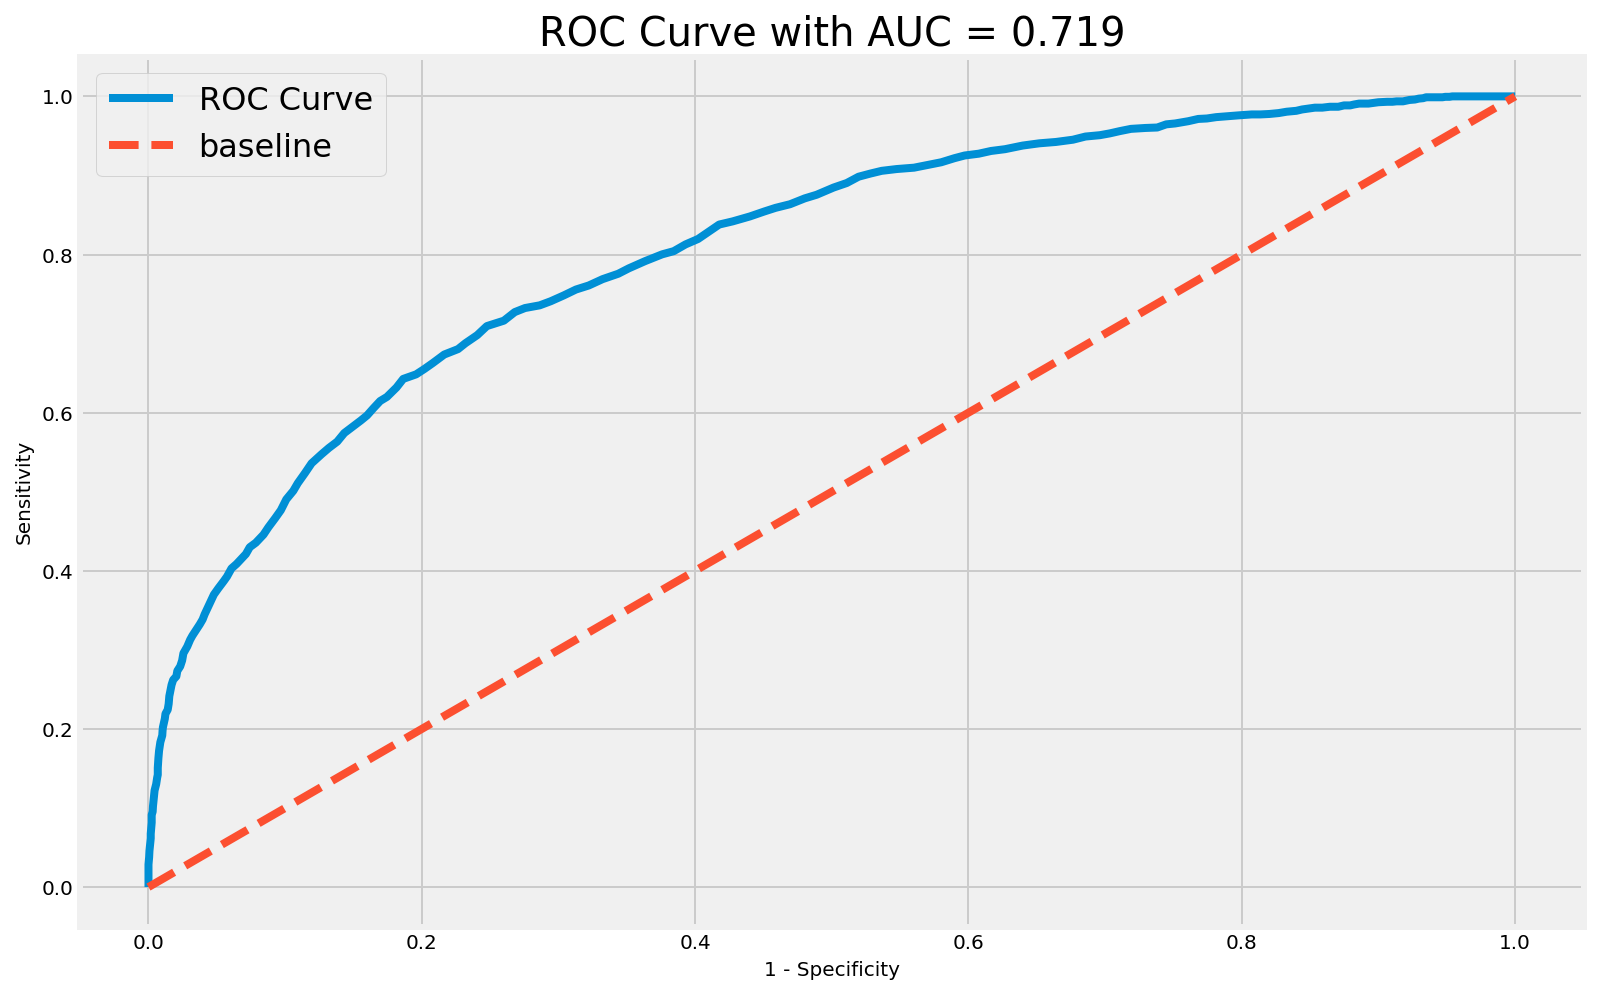

In [160]:
plot_roc_auc(df=df_results_03, y_true="y_unseen", y_proba="mean_proba", y_pred="y_pred",
             save_path="../assets/model_03_roc.png")

#### Performance Summary

|Model|Optimised on|ROC-AUC|Accuracy|Recall|Specificity|Precision|F-1 Score|
|---|---|---|---|---|---|---|---|
|baseline*|-|-|0.709|-|-|-|-|
|Hybrid_01|ROC-AUC|0.727|0.734|0.711|0.743|0.532|0.609|
|Hybrid_02|F-1|0.731|0.735|0.724|0.739|0.533|0.614|
|NLP_03|SMOTE, F-1|0.688|0.674|0.721|0.655|0.462|0.563|
|nNLP_03|SMOTE, F-1|0.647|0.604|0.750|0.544|0.403|0.525|
|Hybrid_03|SMOTE, F-1|0.719|0.699|0.765|0.672|0.489|0.597|

<p style='text-align: right;'><sub>*baseline accuracy by predicting all negative/unpopular</sub></p>


Even though `SMOTE` appeared extremely promising when it was able to improve our precision score so drastically, on further thought, it made sense that there is only a limit to which it can improve the F-1 score. This is because there is always going to be te trade-off between precision and recall from which the F-1 score is based upon. Hence, this may explain our lacklustre model performance. In fact, our Hybrid_03 F-1 score was worse than both Hybrid_01 and Hybrid_02, which we would argue is because of the distortion of our class distribution when we balanced them through `SMOTE`, thereby also losing information on the distribution of these class observations, which in hindsight has been critical to our models' learning. This we would theorise is especially the case when our classes are not heavily imbalanced as would be the use-case for most of `SMOTE` applications.

Importantly, Hybrid_03 has also failed our fundamental metric of beating the baseline accuracy of 0.709, rendering our model worse than if we were to predict negative (unpopular) classes 100% of the time.If we observe our past two models, the NLP model has consistently beaten our baseline accuracy while our non-NLP model has consistently under-performed it. However, the models have always given us better results once they are aggregated as a hybrid model. Hybrid_03 is the only exception to that, with both its NLP and non-NLP models performing badly. As such, we shall disregard our third model as it has been a step in the wrong direction.
<br>
<br>
<br>
<center>* * * <sup>End Model_03</sup> * * *</center>

### Conclusion

After three models, we have come to the conclusion that our second model Hybrid_02 is the best-performing model. In this section, let us look more closely into the performance of our models and their limits (if any).

|Model|Optimised on|ROC-AUC|Accuracy|Recall|Specificity|Precision|F-1 Score|
|---|---|---|---|---|---|---|---|
|baseline*|-|-|0.709|-|-|-|-|
|Hybrid_01|ROC-AUC|0.727|0.734|0.711|0.743|0.532|0.609|
|Hybrid_02|F-1|0.731|0.735|0.724|0.739|0.533|0.614|
|Hybrid_03|SMOTE, F-1|0.719|0.699|0.765|0.672|0.489|0.597|

<p style='text-align: right;'><sub>*baseline accuracy by predicting all negative/unpopular</sub></p>

Let us begin with our worst-performing model Hybrid_03. What went wrong here? From the metrics, we can see that it consistently underperforms in all metrics compared to its preceding two hybrid models, with the only one exception being its recall score. Although Hybrid_03 and Hybrid_02 were both optimised on the F-1 score, Hybrid_03 differs from the Hybrid_02 by training on a SMOTE-transformed oversampled training set that balanced our positive and negative classes exactly 1:1. Since our positive (popular) classes were originally the minority class, when we oversampled our dataset by creating synthetic positive data points through the use of `SMOTE`, our third model was able to learn much more about classifying the positives than classifying the negatives. Though it is hoped that with more data, the model would be able to better refine its distinction of the positive and negative classes, it is evident from the score that the improvement in learning to be had was not evenly applied.

Between Hybrid_01 and Hybrid_02, the choice of model is clear. Even though Hybrid_01 was optimised for ROC-AUC and Hybrid_02 for the F-1 score, Hybrid_02 was still able to outperform Hybrid_01 on all metrics except specificity. What this tells us is that our hyper-parameters in Model_01 when optimised for ROC-AUC prioritised maximising specificity over recall, meaning that the model found it easier from our training set to improve its negative (unpopular) predictions over its positive (popular) predictions. The situation is flipped when Hybrid_02 was optimised on the F-1 score, with the model improving its recall by a far greater margin than its precision, suggesting that the model found it far easier to improve recall over precision.

Therefore, our overall limits with our hybrid models and training set appears to be that specificity is easier to optimise on than recall, and recall is easier to optimise on over precision. This means that our training dataset allows our model to learn more about accurately predicting the negative classes than the positive classes, and even within our positive predictions, it is far easier to raise recall with more positive predictions (quantity) than to raise the precision/accuracy of our positive predictions (quality). This could also speak to the nature of the features we have available at our disposal, suggesting that we are likely to find more success predicting which ideas will be unpopular over which ideas will be actually popular.

|Model|Optimised on|ROC-AUC|Accuracy|Recall|Specificity|Precision|F-1 Score|
|---|---|---|---|---|---|---|---|
|baseline*|-|-|0.709|-|-|-|-|
|NLP_01|ROC-AUC|0.713|0.716|0.706|0.721|0.509|0.592|
|nNLP_01|ROC-AUC|0.657|0.672|0.622|0.692|0.454|0.524|
|NLP_02|F-1|0.719|0.748|0.649|0.788|0.557|0.600|
|nNLP_02|F-1|0.669|0.648|0.717|0.620|0.437|0.543|
|NLP_03|SMOTE, F-1|0.688|0.674|0.721|0.655|0.462|0.563|
|nNLP_03|SMOTE, F-1|0.647|0.604|0.750|0.544|0.403|0.525|

<p style='text-align: right;'><sub>*baseline accuracy by predicting all negative/unpopular</sub></p>

Looking more closely at each of the NLP and non-NLP models, we can also see the same above-mentioned pattern of specificity over recall, and of recall over precision, further lending strength to our theory that this is a systemic limit from our training dataset and therefore our models that cannot be simply tuned over. Another pattern that is worthwhile to point out is that our NLP models always outperformed our non-NLP models, which makes sense since our non-NLP models are meta-features of which their primary purpose is to qualify the word features and predictions of our NLP models. While this strategy of aggregating a hybrid model was theorised as such, the theory holds weight too seeing how our hybrid models have consistently performed better than any of our NLP or non-NLP models taken singly.

#### NLP Findings

Our project aims to undestand and uncover the changing contours of domestic tourism. We can do this by inferencing from our model and understanding the features importance. Let us infer from our best model Hybrid_02, which consists of a NLP model and a non-NLP model.

In [24]:
# using NLP_02 params for vectorizer
tvec = TfidfVectorizer(stop_words="english", max_features=7500, ngram_range=(1,2))
X_train_tvec = tvec.fit_transform(X_nlp_train)
print("Shape of training sparse matrix:", X_train_tvec.shape)
X_unseen_tvec = tvec.transform(X_nlp_unseen)
print("Shape of test sparse matrix:", X_unseen_tvec.shape)

Shape of training sparse matrix: (18050, 7500)
Shape of test sparse matrix: (6017, 7500)


In [26]:
# create df for features and their weights
features = tvec.get_feature_names()
weights = xgboost_nlp_02.feature_importances_
df_feat_weights = pd.DataFrame(zip(features, weights), columns=["feature", "weight"])

feature    weight
5257             sgmemori  0.019629
6752        tvpointofview  0.014905
3106  jjmobilephotographi  0.014798

In [27]:
df_feat_weights["weight"].describe()

count    7500.000000
mean        0.000133
std         0.000659
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.019629
Name: weight, dtype: float64

As we can observe, our regularisation in NLP_02 has cancelled out 75% or more of our features by giving them a weight of 0. Let us plot our NLP features importance for features with weights greater than 0.004. These are NLP features for which their inclusion will each increase the likelihood of popularity by 0.4%.

In [88]:
# research and recreate list of unvectorized word features
top_words = [
    "#sgmemory, #sgmemories",
    "#tvpointofview",
    "#jjphotography",
    "#rawmobile",
    "#exploresg",
    "#singaporelife",
    "#wearesingapore, #wearesingaporeans",
    "#wonderlustsingapore",
    "share",
    "#illgrammers",
    "#artofvisual, #artofvisuals",
    "canon",
    "#instasgsunday10pm",
    "#sgarchitecture",
    "#exploringsingapore",
    "#mysingapore",
    "#whereissingapore",
    "#rawstreet",
    "#kilogrammerz, #thisissingapore",
    "#instagram, #ig",
    "shot",
    "#sgolympus",
    "#singapore",
    "#iluvsg, #igerssingpaore",
    "#singaporephotography",
    "#createcommune, #createcommunity",
    "#whatissingapore",
    "@yong_hazelle",
    "#travel, #travelphotography",
    "#streetshared",
    "#iglive",
    "#instasg, #sgig",
    "#timeoutsg",
    "#cny2020",
    "#supportlocalsg",
    "#topsgshot"
]

len(top_words) # count length of top word features

36

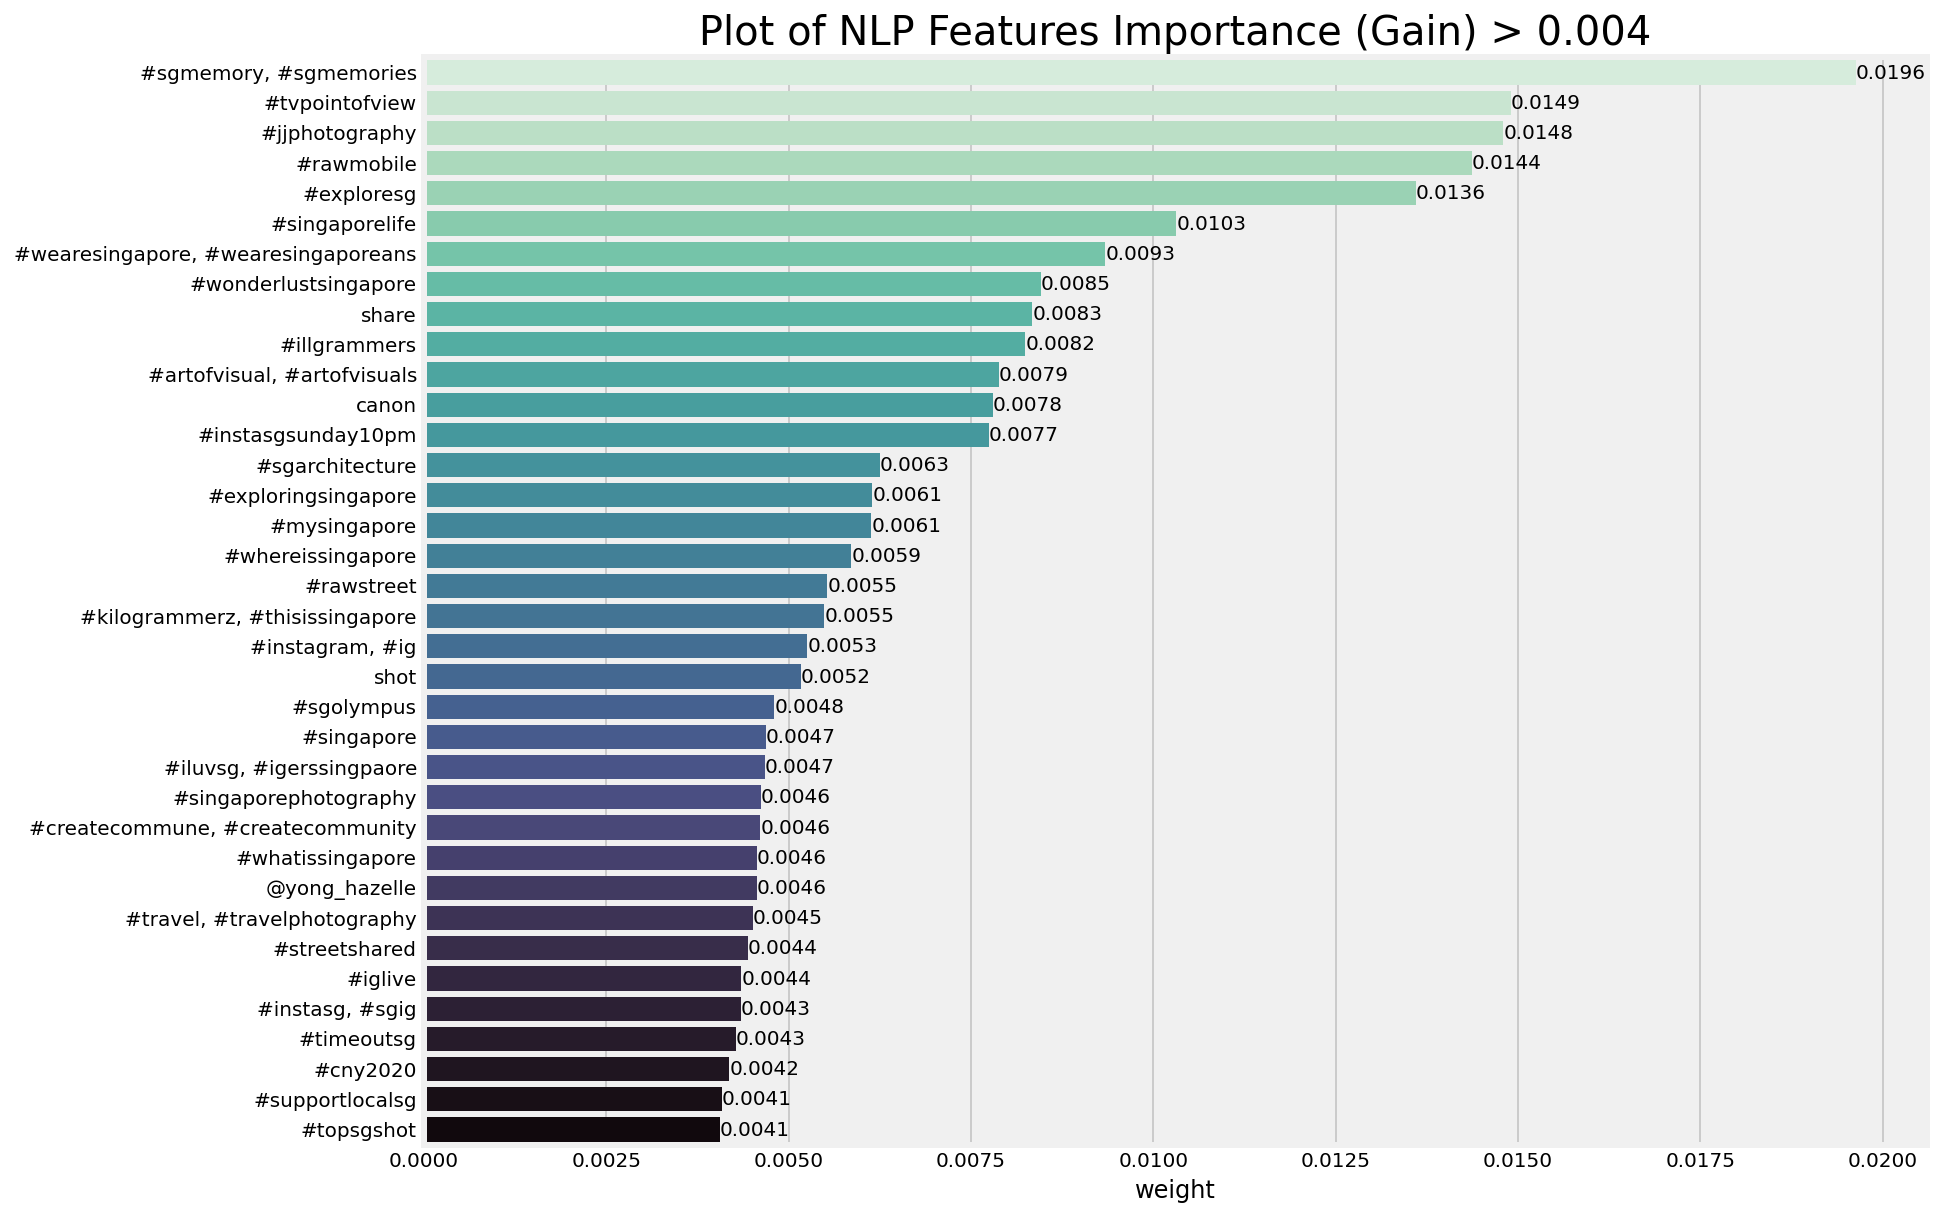

In [114]:
fig, ax = plt.subplots(1, 1, figsize=[12,10])
plt.title("Plot of NLP Features Importance (Gain) > 0.004", size=20)
mask = df_feat_weights["weight"] > 0.004
order = df_feat_weights[mask].sort_values("weight", ascending=False)["feature"].values
ordered_weights = df_feat_weights[mask].sort_values("weight", ascending=False)["weight"].values

ax = sns.barplot(data=df_feat_weights[mask], x="weight", y="feature", orient="h", order=order, palette="mako_r")

i = 0
for p in ax.patches: # annot feature weights
    plt.text(p.get_width(), p.get_y()+0.6, round(ordered_weights[i], 4))
    i += 1

ax.set_yticklabels(top_words) # replace y-tick labels
ax.set_ylabel("")
plt.savefig("../assets/nlp_02_features_gain.png", transparent=True, bbox_inches='tight')
plt.show()

Right away as we look through the list of top word features with weights greater than 0.004, it is immediately striking that the majority of these top word features are hashtags. Perhaps it is inescapable as their use on online social media has become ubiquitous, even approaching spam levels in order to attract the eyeballs and attention desired. As such, we must also be wary of how we interpret these word features, especially the hashtags. The one safeguard we do have is that the size of our dataset is sizeable enough that it is unlikely that any one of these top word features are single-use and belonging to a viral outlier data point. Instead, it is more likely that these are hashtags so overused as an SEO strategy that they have begun to lose meaning and significance.

Going through each of these top 36 word features and researching them online, there are a few broad categories that we can split them up into. They are:

- word features that describe the Singapore spirit, often banal and/or nostalgic in sentiment
    - #sgmemory, #sgmemories, #singaporelife, #mysingapore, etc...
- word features that celebrates the Singapore spirit, often marking something special and/or even nationalistic in sentiment
    - #wearesingapore, #exploresingapore, #whatissingapore, #thisissingapore, #iluvsg, etc...
- word features that are self-referential and meta
    - #instagram, #singapore, #instasg, #sgig, etc...
- word features that describe a certain aesthetic and style of photography/film in general
    - #tvpointofview, #jjphotography, #artofvisual, #kilogrammerz, #illgrammers, etc...
- word features that refer back to the camera equipment
    - canon, #sgolympus
- word features that describe travel and exploring in Singapore
    - #wonderlustsingapore, #exploringsingapore, #travelphotography, etc...
- word features that describe a genre/event
    - #sgarchitecture, #cny2020
- word features that support a cause
    - share, #createcommune, #createcommunity, #supportlocalsg
    
However, it appears that we are still very much dominated by instagram hashtags. While the importance of hashtagging is not lost on us since our models have repeartedly stressed on them, we may find more interesting key words at the lower weights. Let us explore the lower weights obscured by the hashtags.

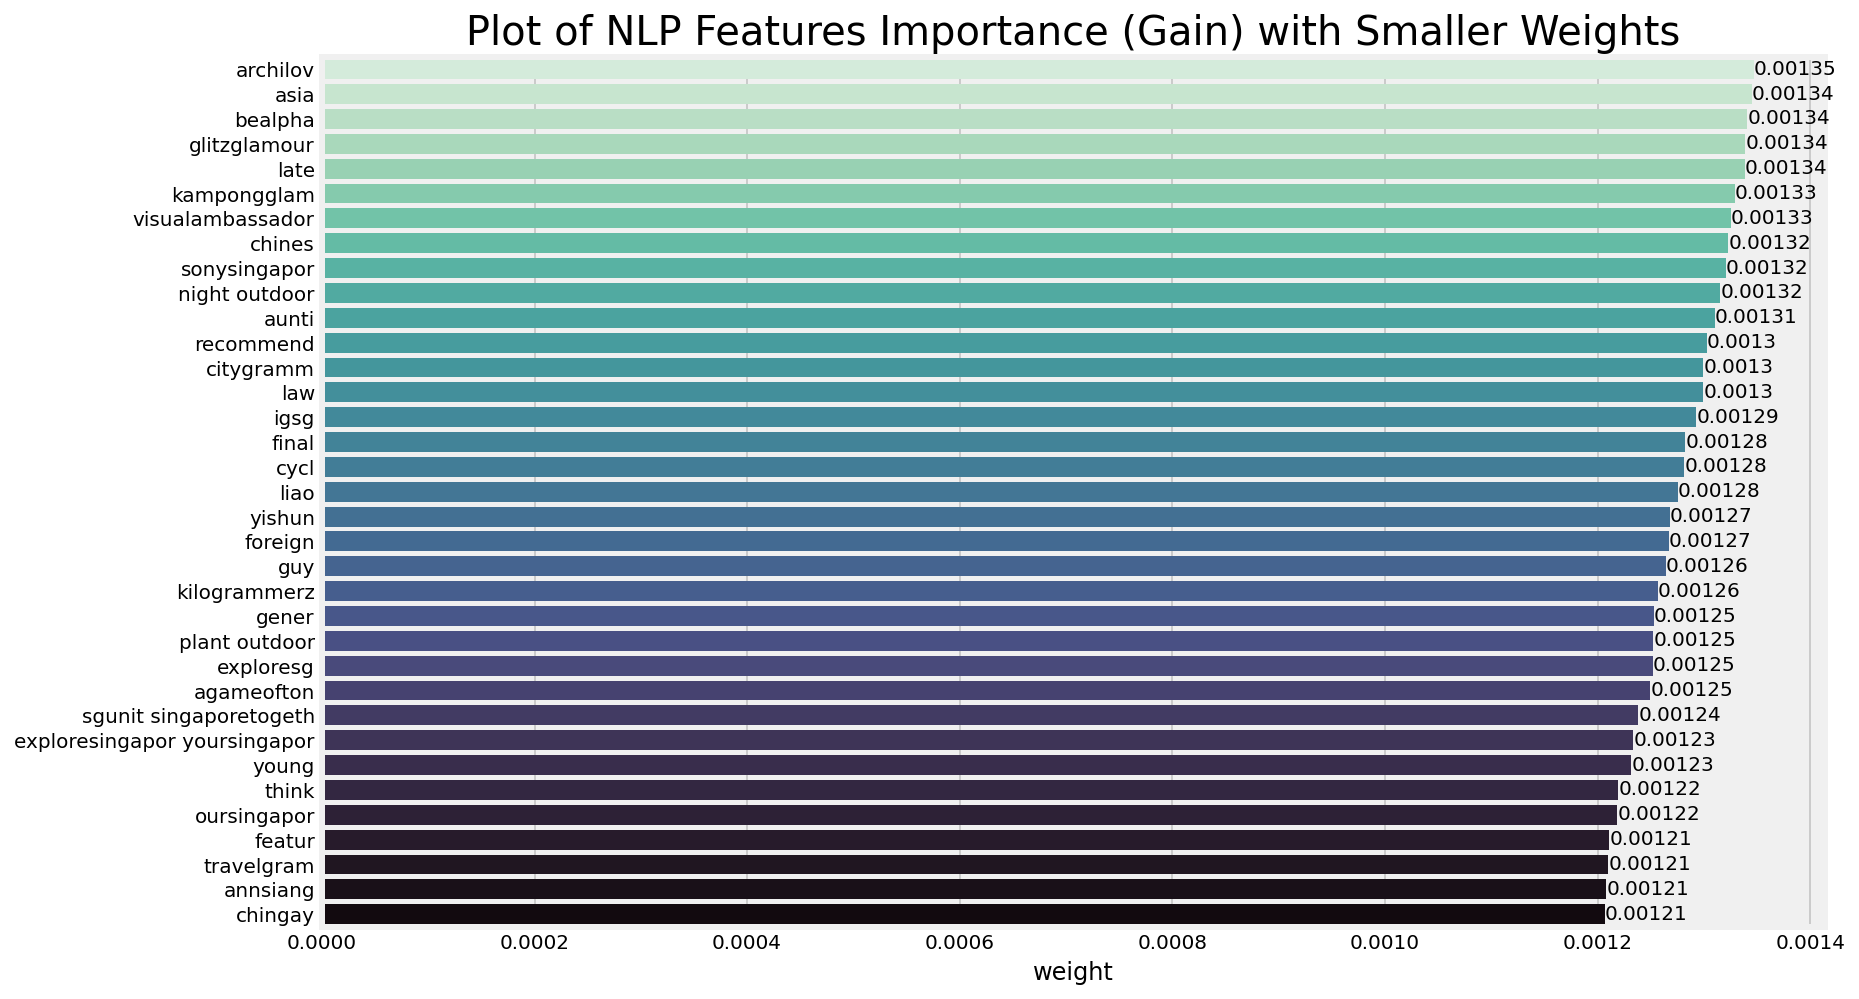

In [136]:
# snapshot of lower weighted word features
df_feat_snapshot = df_feat_weights[df_feat_weights["weight"].between(0.001, 0.00135)].sort_values("weight", ascending=False).reset_index(drop=True)[:35]

fig, ax = plt.subplots(1, 1, figsize=[12,8])
plt.title("Plot of NLP Features Importance (Gain) with Smaller Weights", size=20)

ax = sns.barplot(data=df_feat_snapshot, x="weight", y="feature", orient="h", palette="mako_r")

i = 0
for p in ax.patches: # annot feature weights
    plt.text(p.get_width(), p.get_y()+0.6, round(df_feat_snapshot["weight"][i], 5))
    i += 1

ax.set_ylabel("")
plt.savefig("../assets/nlp_02_features_snapshot.png", transparent=True, bbox_inches='tight')
plt.show()

Exploring the lower weighted word features uncovered features that are less hashtags and more key words. We still see some hashtags, as well as the usual trend of crediting your camera/film equipment, but beyond that, we see certain ideas of activities and geographies that capture the locals' perspective of domestic tourism. For example,

- locations of interest:
    - #kampongglam at 0.00133, yishun at 0.00127, annsiang at 0.00121
- types of activites:
    - late at 0.00134, night outdoor at 0.00132, cycle at 0.00128, plant outdoor at 0.00125
- cultural focus:
    - #archilove at 0.00135, #glitzglamour at 0.00134, chingay at 0.00121, auntie at 0.00131
    
The above are just some of the key words that stood out to us in our exploration. A follow up to this could be to rebuild the model again and train it on text with all the hashtags removed. Perhaps, that would be more illuminating on this aspect. Otherwise, from what we can observe from the snapshot above, domestic tourism is not limited to the tourism activites and destinations we have built up over the years for foreign visitors.

Yes, Kampong Glam is a tourist destination, maybe even the Annsiang area, but they are also locations frequented by the locals. More than that, Yishun also appeared as a place of significance in the discourse of domestic tourism and as a place to [explore](https://www.youtube.com/watch?v=QhZW4HLl4xw&ab_channel=GhibOjisan), a heartland that would never have gotten a second glance from tourists.

Where it comes to activities, late or night activities seem to be popular. But, perhaps this could simply be a matter of practicalities to locals as they have to work in the day and only have leisure time at night. Of course, tourists in Singapore will enjoy night activities too, so this would be something shared in common between tourists and locals. Locals would also prefer the great outdoors with plants and nature. While I doubt that tourists would visit Singapore just for our nature, for us locals it is what we grew up with and therefore what we cherish. Cycling received a mention too, and while Singapore is not the most bike-friendly city, many families and locals do enjoy a leisure cycle at our parks or wherever you can rent a bicycle.

Culturally, architecture is a recurrent theme and hashtag, especially on Instagram. This may be because buildings are accessible and make for a great photo subject. Formal more dressed-up events are also something special that locals look forward to, which makes sense since as locals we are less likely to take the initiative to do something new unless it is a special event. Examples could include theatre to art performances to even gala dinner events. Chingay got a mention from the model too, an annual parade that I would argue is catered more to the locals than to tourists, even as its popularity has waned among the locals over the years, but that is besides the point. Finally, even our own local archetypal middle-aged woman, the auntie, got a mention from our model. The word can be used anywhere from a noun to even an adjective, as a form of jest in good fun or mildly derogatory.

These are all interesting key words that can spark our imagination and possibly inspire the next phase of the campaign on domestic tourism.

#### NLP Recommendations

In [91]:
# view total sum of the top 36 weights
ordered_weights.sum()

0.25803256034851074

If we were to only utilise the above chart as a guide to strategise and maximise the likelihood of popularity, the top 36 word features (hashtags and all) are able to contribute a total of 25.8% greater likelihood for our model's prediction of popularity. Having said that, it would be more meaningful to draw inference and learn from our model so we have takeaways that are useful towards developing a more complete understanding of domestic tourism. It would also not be effective to use these hashtags blindly just to raise visibility if the content is not going to be coherent. Ultimately, we will want the conversion of visibility to agreement and eventual popularity to be high.

![](../assets/jj_kilo.png)

<p style='text-align: right;'><sub>Left image by #JJ from https://nicolelunger.wordpress.com/2013/08/29/i-confess-im-obsessed-with-instagram/</sub></p>
<p style='text-align: right;'><sub>Right image by Kilogrammerz from https://www.facebook.com/kilogrammerz</sub></p>
<br>

From the categories above, there are only a few that stand out to us. From word features that described certain aesthetic or style in relation to photography and film, hashtags such as #jjphotography and #kilogrammerz are interesting because these are not general hashtags that simply indicate the content genre or style. There are hashtags that refer back to Instagram accounts, therefore demonstrating the reach and popularity of these Instagram accounts within the realm of Singapore domestic tourism. For example, the hashtag #jjphotography was [created](https://nicolelunger.wordpress.com/2013/08/29/i-confess-im-obsessed-with-instagram/) by @joshjohnson to encourage mobile photography and to nurture creativity through daily themes and challenges. Kilogrammerz similarly appears to be a local group which [described](https://www.instagram.com/kilogrammerz/) themselves as a "Visual Arts Education Platform" on Instagram, so it is interesting to see other users submitting content by referencing them with the hashtag #kilogrammerz. Hashtags such as these can enlighten us to thought leaders in the space of such content, and in this case the space of Instagram photography that appears to be so important to sharing domestic tourism experiences.

<br>

![](../assets/supportlocalsg.jpg)

<p style='text-align: right;'><sub>Image by #SupportLocalSG from https://supportlocal.sg/</sub></p>
<br>

Another category that was illuminating was about word features that support a cause. The hashtags #createcommune and #createcommunity within the landscape of Singapore domestic tourism indicate a desire to belong. Where these hashtags are broad and lacks focus for us to interpret meaningfully, #supportlocalsg is more specific and heartening to see. Browsing [#supportlocalsg](https://www.instagram.com/explore/tags/supportlocalsg/) on Instagram showed both businesses trying to gain visibility for their products/services as well as groundswell support from locals on the streets promoting and supporting their favourite products/services. While the content may not strictly be about domestic tourism, there is no reason domestic tourism campaigns cannot borrow from this hashtag and its associated ideals. Perhaps domestic tourism can be more than just acts of tourism and exploration, they could also be acts of agency to preserve what we love and value in defiance of market demand and supply.

Other categories worth noting are word features that describe genre/event and/or refer back to film equipment. These are all promotional opportunities that we can delve into, whether it is a holiday that also marks a cultural significance or a collaboration with manufacturers and labels that are core to the social media community.

From the snapshot of word features with smaller weights, we can see that locations that are significant and can appeal to locals are not limited to the typical tourist destinations that we promote to foreign visitors. Even heartland neighbourhoods like Yishun holds modern cultural meaning to the average Singaporean and could be a more interesting place to explore than the usual tourists haunt. For activities, we understand that locals enjoy late night activities, nature and the outdoors, and cycling. While we are still in the midst of fighting Covid, perhaps night life would be the hardest to come by. But, there is hope too as the government has just announced plans to reopen certain nightspots in a pilot programme. Culturally, architecture, formal events, events such as Chingay, and even the archetypal auntie figure all find certain appeal and resonance with the locals. Campaigns and events may be able to employ these cultural themes/genres into their planning.

#### non-NLP Findings

In [100]:
# create df for features and their weights
features = X_nnlp_train_dumm.columns
weights = xgboost_nnlp_02.feature_importances_
df_nnlp_weights = pd.DataFrame(zip(features, weights), columns=["feature", "weight"])
# sort and reassign df
df_nnlp_weights = df_nnlp_weights.sort_values("weight", ascending=False).reset_index(drop=True)

feature    weight
0    time_of_day_Afternoon  0.075636
1  platform_YouTube Videos  0.061105
2                      age  0.052497

In [95]:
df_nnlp_weights["weight"].describe()

count    40.000000
mean      0.025000
std       0.015498
min       0.000000
25%       0.015627
50%       0.020372
75%       0.032708
max       0.075636
Name: weight, dtype: float64

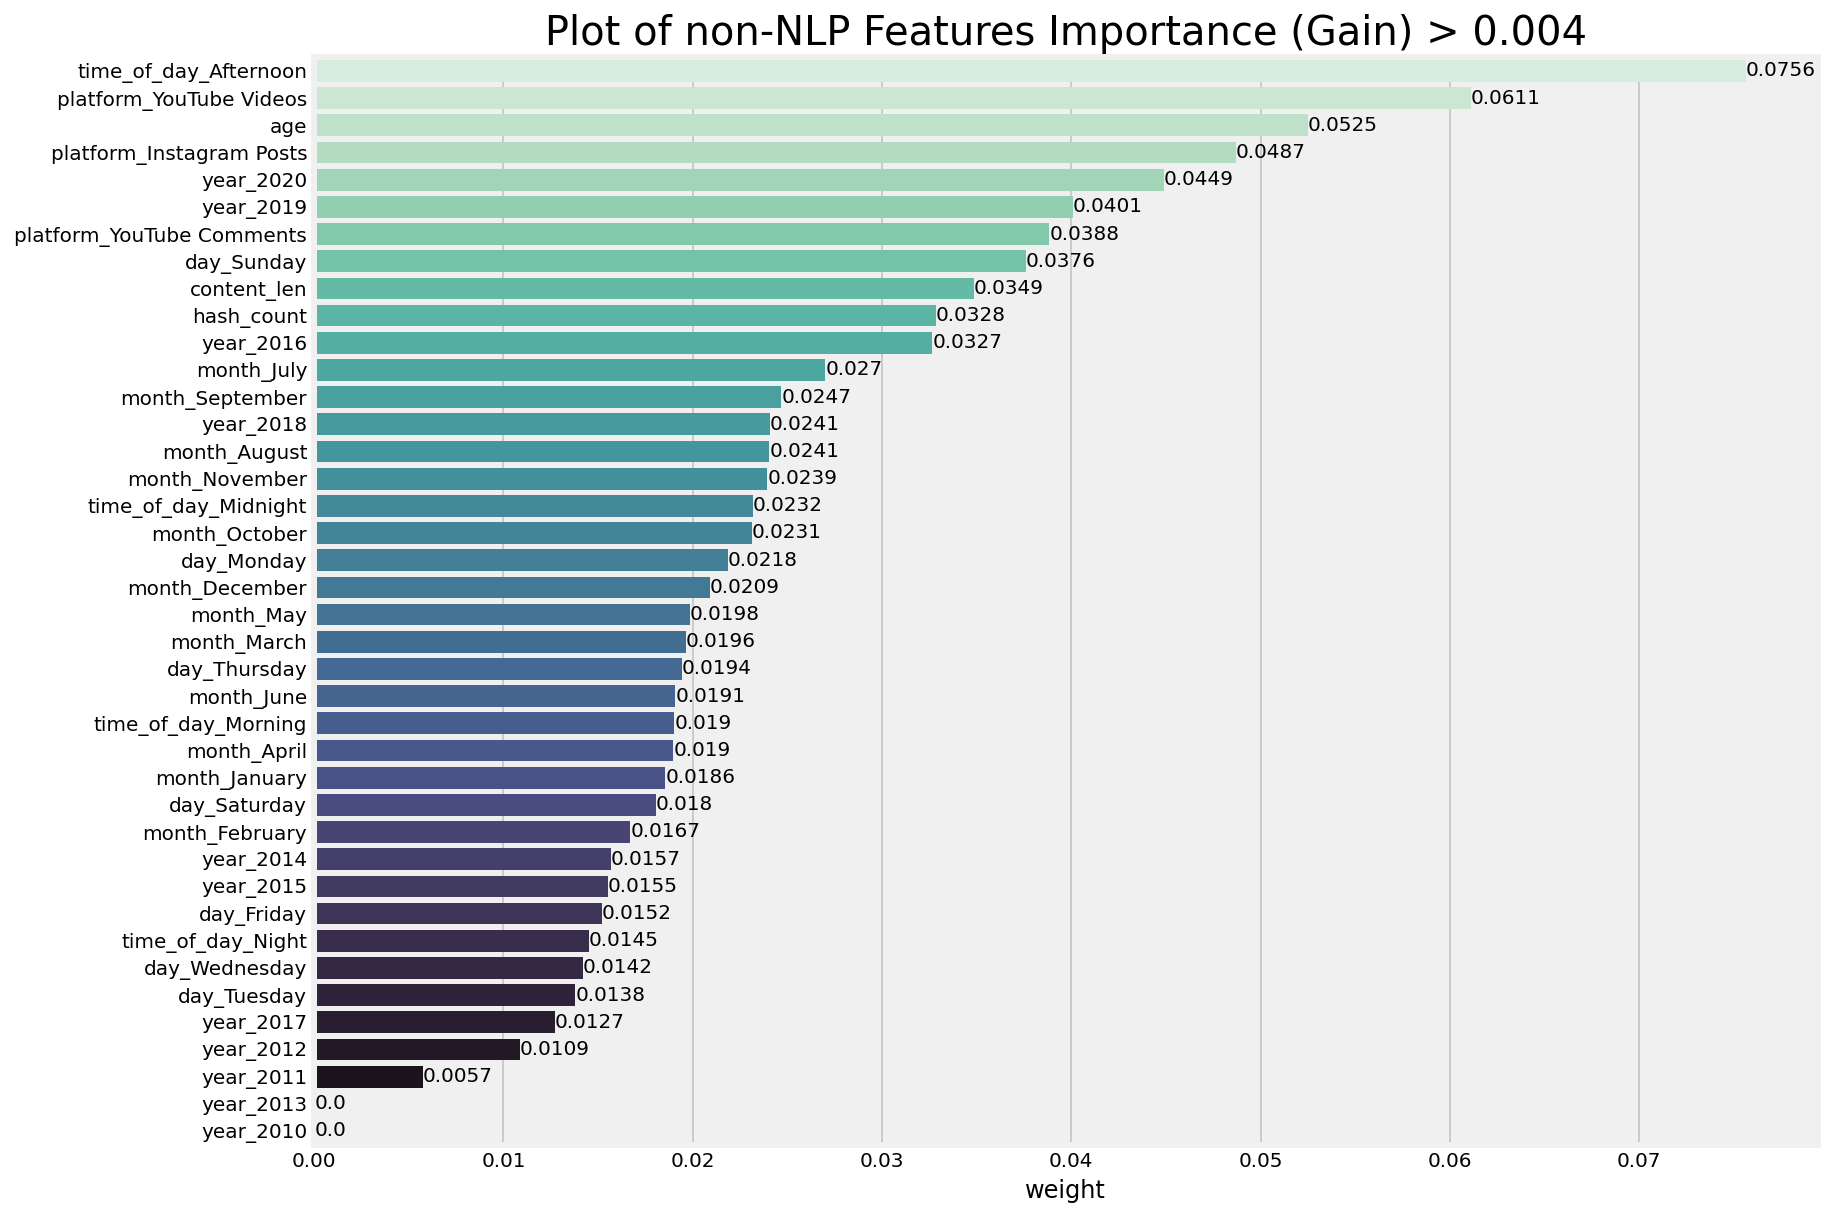

In [108]:
fig, ax = plt.subplots(1, 1, figsize=[12,10])
plt.title("Plot of non-NLP Features Importance (Gain) > 0.004", size=20)

ax = sns.barplot(data=df_nnlp_weights, x="weight", y="feature", orient="h", palette="mako_r")

i = 0
for p in ax.patches: # annot feature weights
    plt.text(p.get_width(), p.get_y()+0.6, round(df_nnlp_weights["weight"][i], 4))
    i += 1

ax.set_ylabel("")
plt.savefig("../assets/nnlp_02_features_gain.png", transparent=True, bbox_inches='tight')
plt.show()

We have a few types of non-NLP features for our model to train on. These are subsequently dummied out. We have the types of platform, the total length of the text feature, number of hashtags used in that data point, the age (in days) of the data point from inception to when it was scraped, as well as all the date-related features such as year, month, day, and time of the day. After dummying, we have a total of 40 features.

Our top ranking meta-feature is `time_of_day_Afternoon` with a weight of 0.0756. This means that according to our non-NLP model, content launched in the afternoon is most likely to succeed and be popular. We had previously engineered this feature ourselves in the EDA notebook 3.0. For a recap, the day were split into four parts - midnight from 00:00 to 05:59, morning from 06:00 to 11:59, afternoon from 12:00 to 17:59, and night from 18:00 to 23:59. Therefore, if we want set our content up for success and popularity, we should launch it within the window of 12pm to before 6pm. This makes sense since this would position the content at the top of the feed before the peak period in online social media traffic after work when people are most likely to be browsing and there are the most eyeballs.

Among our platform types, YouTube videos are the most likely to succeed and become popular with `platform_YouTube_Videos` coming in ranked second with a weight of 0.0611. The next platform type most likely to be popular is `platform_Instagram_Posts` at 0.0487 and `platform_YouTube_Comments` at 0.0388. We should take care when interpreting this feature importance however, especially since our YouTube data was curated from YouTubers that we feel are relevant (which in itself means that they have already made a name for themselves) versus Instagram data in which we scrape from target hashtags and from all accounts (famous or unknown).

The third ranking feature is `age` of the content with a weight of 0.0525. While this is an important predictor to our model, it should not be understood as a linearly correlated with popularity. As we have discovered form our EDA, while it may make sense that a content that has been around for much longer has had longer time to accumulate the likes, our EDA revealed that whether the content will be popular or gather enough likes in something that will be decided within the first few days. Content that has the opportunity to become viral after staying low for a long period of time is a myth and unlikely to happen.

Content launched this year - `year_2020` weighted 0.0401, and last - `year_2019` weighted 0.0388, are more likely to be popular too. Generally, we can see that content that are more recent tend to perform better than content that are older. This is to be expected as social media is a lot more prevalent now than when it was 5 to 10 years ago. For YouTube channels and even Instagram accounts, it will take time for them to grow and gain popularity. Certainly, this growth is accelerated in today's day and age simply because there are many more users on social media.

Of the days you can choose to launch your content related to domestic tourism, our model recommends Sunday, giving `day_Sunday` a weight of 0.0376. While our model also recommends July as the best month to launch content related to domestic tourism, giving `month_July` a weight of 0.0270, this is probably best not taken at face value since we believe there is no bad month to promote domestic tourism in Singapore. The only advantage July may have over some other months is the proximity to school holidays and the lack of competition for clicks with other major holidays like the end of the year for example. However, what is more telling is that among the months, the entire later half of the year are consistently the higher-ranking features.

Finally, we have `content_len` that measures the character length of the text content coming in with a weight of 0.0349 and `hash_count` counting the number of hashtags used with a weight of 0.0327. Again, I would caution against interpreting these features at face value and assuming a positive linear relationship with likes/popularity. Instead, it is simply that these data are good predictors of popularity and they likely each have their own distribution where there is probably a point of balance between lengthy content and/or spamming hashtags that can give the content its best shot at popularity.

#### non-NLP Recommendations

There are some important takeaways that should be able to help us set our domestic tourism content up for the greatest success and popularity. Depending on the type of content, all things being equal, our model tells us that YouTube videos has the greatest chance of achieving popularity with a 6.11% likelihood versus content on Instagram with a 4.87% likelihood of popularity.

When considering when to launch the content, it is recommended to launch it on a Sunday and/or in the afternoon from 12pm to 6pm. Content launched in the later half of the year are also expected to do better, in particular in July according to our model. Content launched in the recent years are more popular than content launched in the past, reiterating the need for fresh content that can attract and engage.

![](../assets/ytvid_likes_len.png)

When it comes to meta-features about the text content, the length of text can be telling for our model predictions, but I would argue that is it helpful for our model only insofar as it helpes the model decide if the content has the right format and foundation to succeed and become popular rather than actually be the catalyst for popularity. If we were to take YouTube videos as an example from the chart above, the number of likes a video can garner appears to be random in relation to the length of its text descriptions. However, we can still observe that as a rule, videos with text descriptions that are too short or too long often do not perform as well as the average 1288 number of characters. We can theorise that well-planned videos and ambitious channels often require more text descriptions, either for crediting or for links to other content/brands that continues to engage their viewers and build upon their channel's momentum to grow. If we assume the average word length to be 4.7 characters, this would in turn give us an average of 274 words or about 1-2 paragraphs.

![](../assets/insta_likes_hash.png)

The number of hashtags can also boost visibility and increase the likelihood of popularity. Taking Instagram as the example since hashtags are most prevalent there, we can observe that similar to `content_len`, the number of hashtags does not so much catalyse popularity as it does set the right foundation for the post to succeed. The one difference is that on Instagram, it appears that you may be able to do just as well with little to no hashtags as you would with the average 15 hashtags that each post usually come accompanied with. However, there appears to be a point of over-saturation at about 30 hashtags where the post incur diminishing returns and do badly. Therefore, it is recommended to employ hashtags strategically and keep them to ideally 15, or at least less than 30.

### Recommendations

Putting all our findings together, we have 3 proposals we would like to make to STB for the next phase of the #SingapoRediscovers campaign.

#### Proposal 1:

![](../assets/sgbike.jpg)

- An *Instagram photo cycle* (like a photo walk, but on bicycle) that will encourage the locals to pick up a bicycle and explore different areas and neighbourhoods of Singapore, and to rediscover their hometowns in new light.
- For leisure cycling, most Singaporeans would turn to places like East Coast Park where there are bicycle rentals easily accessible, which is why unless you have your own bicycle, it is uncommon for someone to cycle and explore their neighbourhood. This would be a good opportunity to partner with one/both of the surviving [bicycle providers](https://vulcanpost.com/708823/singapore-bike-sharing-will-it-take-off/#:~:text=In%202017%2C%20Singapore%20started%20seeing%20a%20bike%2Dsharing%20boom.&text=At%20its%20peak%2C%20nine%20bike,more%20than%20200%2C000%20shared%20bicycles.) (SG Bike and Anywheel) and #supportlocalsg.
- We have extensive Park Connector Networks (PCNs) that connect the different regions of Singapore to one another so this is entirely feasible and would encourage usage of these built infrastructure.
- STB can engage the locals with this initiative by releasing checkpoints/destinations or neighbourhood of interest weekly as well as manage a hashtag where locals can post photos of their exploration.

#### Proposal 2:

![](../assets/golden_mile.jpg)

- A *Pseudo-Travel initiative* within Singapore that will enlighten our locals to the numerous ethnic enclaves that have organically grown in Singapore, and to encourage them to visit and be "tourists" for a day at home.
- As a cosmopolitan city, Singapore is home to many people from all around the world. As foreigners in Singapore, these groups of people would inevitably reappropriate a space and form their own [little ethnic enclaves](https://thefinder.life/healthy-living/ask-the-experts/7-hidden-ethnic-enclaves-singapore-arent-chinatown-or-little/?agallery=24200&aslide=0). Some are well-known and arguably gentrified, such as Little India, Chinatown, and Kampung Gelam. There are others that are just as known but are not officially recognised, such as Lucky Plaza that is Filipino's home away from home; Peninsula Plaza aka Little Burma; Golden Mile Complex aka Little Thailand, Tanjong Pagar or Korean street; Geylang aka New Chinatown; City Plaza for the Indonesians. We would argue that these places are worth exploring and more appealing to locals because they have not been officially recognised and is a quick way to transport yourself to another country within Singapore.
- To encourage Singaporeans to go out and explore these other ethnic enclaves in Singapore, we propose partnering up with Ghib Ojisan (GO) on YouTube for him to explore these enclaves and vlog his experiences on his channel to educate the local viewers and pique their interest.
- GO has acutally already done a [video](https://www.youtube.com/watch?v=_ZQl1eG98iY&ab_channel=GhibOjisan) exploring Lucky Plaza. Of course, there remains more to be explored. But in light of that, we recommend beginning this series with Little Thailand at Golden Mile Complex. Recent news of its [official conservancy status](https://www.channelnewsasia.com/news/singapore/golden-mile-complex-proposed-for-conservation-incentives-13240674) would likely see the optimistic revival of this enclave.

#### Proposal 3:

![](../assets/chingay.jpg)

- A *Chingay behind-the-scenes* YouTube mini-series that follows volunteer performers behind the scenes as they rehearse and prepare themselves over 6 months for the [Chingay](https://www.chingay.gov.sg/) performance (Chingay 2020 was held on Jan 31 and Feb 1).
- This is aimed to boost and create sustained local interest in Chingay by investing the viewers in the jouney of the volunteer performers. Since the mini-series will be episodic, fresh content that is generated periodically will stimulate interest.
- As Chingay is an annual event, it will be a worthwhile pursuit for STB to create and generate the local buzz/interest over Chingay. By creating a new generation of Chingay audience, we will be able build on that momentum year after year. Should travel resume, it would also be a better Chingay with greater local support and interest. For a parade that celebrate multiculturality, it would be a more interesting experience for foreign tourists to spectate alongside local "tourists". 

#### Test Proposal 1

In [51]:
# proposal 1 - NLP feature
prop1 = "I just went on #STB photo cycle challenge in Singapore's most dangerous neighbourhood, Yishun.\
It was easy cycling along the park connector, and I was able to make pitstops along the way and just enjoy the nature.\
Check out this beautiful temple I came across in the middle of the HDB estate. Who knew? I am looking forward to lunch now.\
#exploresg #wonderlustsingapore #singaporediscovers #photocycle #photocycling #sgbike #kilogrammerz #supportlocalsg"
len(prop1)

450

In [52]:
prop1_tvec = tvec.transform([prop1.lower()])

In [53]:
# proposal 1 - nNLP features
prop1_dumm = pd.DataFrame(columns=X_nnlp_unseen_dumm.columns) # create empty df
prop1_dumm.loc[0, "age"] = 7 # assume 1 week later from post
prop1_dumm.loc[0, "hash_count"] = 9
prop1_dumm.loc[0, "content_len"] = len(prop1)
prop1_dumm.loc[0, "platform_Instagram Posts"] = 1
prop1_dumm.loc[0, "year_2020"] = 1
prop1_dumm.loc[0, "month_November"] = 1 # assume initiative to start in Nov
prop1_dumm.loc[0, "day_Sunday"] = 1 # sunday is the best day for posting
prop1_dumm.loc[0, "time_of_day_Afternoon"] = 1 # afternoon is the best time of the day for posting
prop1_dumm.fillna(0, inplace=True)
prop1_dumm

age  hash_count  content_len  platform_Instagram Posts  \
0    7           9          450                         1   

   platform_YouTube Comments  platform_YouTube Videos  year_2010  year_2011  \
0                          0                        0          0          0   

   year_2012  year_2013  ...  day_Monday  day_Saturday  day_Sunday  \
0          0          0  ...           0             0           1   

   day_Thursday  day_Tuesday  day_Wednesday  time_of_day_Afternoon  \
0             0            0              0                      1   

   time_of_day_Midnight  time_of_day_Morning  time_of_day_Night  
0                     0                    0                  0  

[1 rows x 40 columns]

In [54]:
# extract probabilities for positive predictions from both NLP and non-NLP models
nlp_prop1 = xgboost_nlp_02.predict_proba(prop1_tvec)[:, 1]
nnlp_prop1 = xgboost_nnlp_02.predict_proba(prop1_dumm)[:, 1]

In [55]:
# zip and create df matching predicted probabilities
df_prop1 = pd.DataFrame(zip(nlp_prop1, nnlp_prop1), columns=["nlp_proba", "nnlp_proba"])
# aggregate probabilities and generate prediction
df_prop1["mean_proba"] = df_prop1[["nlp_proba", "nnlp_proba"]].T.mean()
df_prop1["y_pred"] = round(df_prop1["mean_proba"]).astype(int)
df_prop1

nlp_proba  nnlp_proba  mean_proba  y_pred
0   0.548338    0.632551    0.590444       1

Hybrid_02 predicts that proposal 1 has a 59.0% chance of becoming popular!

#### Test Proposal 2

In [76]:
# proposal 2 - NLP feature
prop2 = "Visiting the Thailand of Singapore - Golden Mile Complex\
Did you know there is Little Thailand in Singapore? Today, I visited Golden Mile Complex at Beach Road.\
It's a mall with over 400 retail shops and restaurants where the local Thai community hangs out.\
Here, you are instantaneously transported to Thailand. Join me on today's journey of Golden Mile Complex in Singapore.\
#Singapore #GoldenMileComplex"
len(prop2)

402

In [77]:
prop2_tvec = tvec.transform([prop2.lower()])

In [78]:
# proposal 2 - nNLP features
prop2_dumm = pd.DataFrame(columns=X_nnlp_unseen_dumm.columns) # create empty df
prop2_dumm.loc[0, "age"] = 7 # assume 1 week later from post
prop2_dumm.loc[0, "hash_count"] = 2
prop2_dumm.loc[0, "content_len"] = len(prop2)
prop2_dumm.loc[0, "platform_YouTube Videos"] = 1
prop2_dumm.loc[0, "year_2020"] = 1
prop2_dumm.loc[0, "month_November"] = 1 # assume initiative to start in Nov
prop2_dumm.loc[0, "day_Sunday"] = 1 # sunday is the best day for posting
prop2_dumm.loc[0, "time_of_day_Afternoon"] = 1 # afternoon is the best time of the day for posting
prop2_dumm.fillna(0, inplace=True)
prop2_dumm

age  hash_count  content_len  platform_Instagram Posts  \
0    7           2          402                         0   

   platform_YouTube Comments  platform_YouTube Videos  year_2010  year_2011  \
0                          0                        1          0          0   

   year_2012  year_2013  ...  day_Monday  day_Saturday  day_Sunday  \
0          0          0  ...           0             0           1   

   day_Thursday  day_Tuesday  day_Wednesday  time_of_day_Afternoon  \
0             0            0              0                      1   

   time_of_day_Midnight  time_of_day_Morning  time_of_day_Night  
0                     0                    0                  0  

[1 rows x 40 columns]

In [79]:
# extract probabilities for positive predictions from both NLP and non-NLP models
nlp_prop2 = xgboost_nlp_02.predict_proba(prop2_tvec)[:, 1]
nnlp_prop2 = xgboost_nnlp_02.predict_proba(prop2_dumm)[:, 1]

In [80]:
# zip and create df matching predicted probabilities
df_prop2 = pd.DataFrame(zip(nlp_prop2, nnlp_prop2), columns=["nlp_proba", "nnlp_proba"])
# aggregate probabilities and generate prediction
df_prop2["mean_proba"] = df_prop2[["nlp_proba", "nnlp_proba"]].T.mean()
df_prop2["y_pred"] = round(df_prop2["mean_proba"]).astype(int)
df_prop2

nlp_proba  nnlp_proba  mean_proba  y_pred
0   0.587676     0.54608    0.566878       1

Hybrid_02 predicts that proposal 2 has a 56.7% chance of becoming popular!

#### Test Proposal 3

In [83]:
# proposal 3 - NLP feature
prop3 = "When the firecrackers starts, there is a stillness in your air.\
And suddenly the lights come on, and the music blasts, and for the next hour or more your body takes over.\
Chingay volunteer performers train hard for more than 6 months for just two days of performance.\
Join us in our new mini-series as we follow our volunteer performers journey from citizen in the day to star by night.\
Come with us behind the scenes and get to know our volunteer performers,\
and what motivates them to get up in the morning and get down to rehearsal at night.\
#Singapore #Chingay"
len(prop3)

558

In [84]:
prop3_tvec = tvec.transform([prop3.lower()])

In [85]:
# proposal 3 - nNLP features
prop3_dumm = pd.DataFrame(columns=X_nnlp_unseen_dumm.columns) # create empty df
prop3_dumm.loc[0, "age"] = 7 # assume 1 week later from post
prop3_dumm.loc[0, "hash_count"] = 2
prop3_dumm.loc[0, "content_len"] = len(prop3)
prop3_dumm.loc[0, "platform_YouTube Videos"] = 1
prop3_dumm.loc[0, "year_2020"] = 1
prop3_dumm.loc[0, "month_July"] = 1 # assume initiative to start in Nov
prop3_dumm.loc[0, "day_Sunday"] = 1 # sunday is the best day for posting
prop3_dumm.loc[0, "time_of_day_Afternoon"] = 1 # afternoon is the best time of the day for posting
prop3_dumm.fillna(0, inplace=True)
prop3_dumm

age  hash_count  content_len  platform_Instagram Posts  \
0    7           2          558                         0   

   platform_YouTube Comments  platform_YouTube Videos  year_2010  year_2011  \
0                          0                        1          0          0   

   year_2012  year_2013  ...  day_Monday  day_Saturday  day_Sunday  \
0          0          0  ...           0             0           1   

   day_Thursday  day_Tuesday  day_Wednesday  time_of_day_Afternoon  \
0             0            0              0                      1   

   time_of_day_Midnight  time_of_day_Morning  time_of_day_Night  
0                     0                    0                  0  

[1 rows x 40 columns]

In [86]:
# extract probabilities for positive predictions from both NLP and non-NLP models
nlp_prop3 = xgboost_nlp_02.predict_proba(prop3_tvec)[:, 1]
nnlp_prop3 = xgboost_nnlp_02.predict_proba(prop3_dumm)[:, 1]

In [87]:
# zip and create df matching predicted probabilities
df_prop3 = pd.DataFrame(zip(nlp_prop3, nnlp_prop3), columns=["nlp_proba", "nnlp_proba"])
# aggregate probabilities and generate prediction
df_prop3["mean_proba"] = df_prop3[["nlp_proba", "nnlp_proba"]].T.mean()
df_prop3["y_pred"] = round(df_prop3["mean_proba"]).astype(int)
df_prop3

nlp_proba  nnlp_proba  mean_proba  y_pred
0   0.621793    0.768203    0.694998       1

Hybrid_02 predicts that proposal 3 has a 69.5% chance of becoming popular!

#### Overall Proposals

Each of the 3 proposals was ran through our Hybrid_02 model to predict on their popularity. While they were all predicted to be popular, proposal 3 was predicted to be most likely to be popular with a prediction popularity of 0.695. This is in contrast with proposal 1's probability of 0.590 and proposal 2's probability of 0.567.

As such, of all the initiatives we would recommend proposal 3 most if we were to choose only a single proposal to focus our efforts on.